# CNN Model 8

**This notebook will build the following model**:
- Use only 50% of the data? Yes
- Batch Size: 32
- Batch Normalization: Yes, after every convolution
- Early Stopping: Yes, patience=3
- Reduce Learning Rate: Yes, patience=1
- Initial Learning Rate: 0.0001
- Epochs (max): 15
- Architecture:
    - Feature Extractor: \[Convolution -> Convolution -> Max Pool] repeated 3 times.
        - Relu activation function throughout
        - 2x2 pooling size
        - 3x3 filter size in first 2 segments. 5x5 filter in final segment.
        - Filter count per convolution: 32, 64, 128
    - Classifier: 1 dense layer with 256 units
        - Sigmoid activation function

In [1]:
from data_pipeline import (prep_data, get_train_val_test_data, create_tensorflow_datasets, predict_on_kaggle_test_set)
from model_helper_functions import map_to_metrics, plot_metric, plot_learning_rate, save_history
import numpy as np
from PIL import Image
from time import time, gmtime
import json
import os
from collections import OrderedDict
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import layers
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2024-01-28 21:36:02.970921: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 21:36:03.014217: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(15)

---

## Prepare Data

In [3]:
BATCH_SIZE = 32

In [4]:
data_dir = '../data'
df, train_val_dir = prep_data(data_dir)

In [5]:
train_df, val_df, test_df = get_train_val_test_data(df, use_half_data=True)
train_ds_str, val_ds_str, test_ds_str, train_ds, val_ds, test_ds = create_tensorflow_datasets(train_df, val_df, test_df, BATCH_SIZE)

Training set: 70%, Validation set: 22.5%, Test set: 7.5%


2024-01-28 21:36:09.384335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 21:36:09.419350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 21:36:09.423155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2024-01-28 21:36:09.935493: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX AVX2 AVX512F FMA


In [6]:
image_count = len(list(train_val_dir.glob('*/*.tif')))
print('Total image count:',image_count)
print('Image count equal to dataframe length?', image_count == len(df))

Total image count: 220025
Image count equal to dataframe length? True


In [7]:
num_train_samples = tf.data.experimental.cardinality(train_ds_str).numpy()
num_val_samples = tf.data.experimental.cardinality(val_ds_str).numpy()
num_test_samples = tf.data.experimental.cardinality(test_ds_str).numpy()
print('Number of training samples:',num_train_samples)
print('Number of validation samples::',num_val_samples)
print('Number of test samples:',num_test_samples)

Number of training samples: 77008
Number of validation samples:: 24753
Number of test samples: 8251


In [8]:
example_image = Image.open(df.loc[0, 'path'])
image_shape = np.array(example_image).shape
print('Image shape:', image_shape)

Image shape: (96, 96, 3)


---

## Define Model

In [9]:
MODEL_NAME = 'model8'

In [10]:
model_metrics = OrderedDict([
    ('accuracy', keras.metrics.BinaryAccuracy(name='accuracy')),
    ('auc', keras.metrics.AUC(name='auc')),
])

In [11]:
model_output_dir = './model_checkpoints'
checkpoint_path = f"{model_output_dir}/{MODEL_NAME}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss')

In [12]:
# Define parameters for early stopping and learning rate reduction
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [13]:
# Model Architecture

model = Sequential()

# Feature Extractor
# N_1
model.add(layers.Conv2D(32, (3, 3), input_shape=image_shape))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_2
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_3
model.add(layers.Conv2D(128, (5, 5)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(128, (5, 5)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(1, activation = "sigmoid"))


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = "binary_crossentropy",
              metrics=list(model_metrics.values()))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 94, 94, 32)        896       


 batch_normalization (Batch  (None, 94, 94, 32)        128       


 Normalization)                                                  


 activation (Activation)     (None, 94, 94, 32)        0         


 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      


 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       


 chNormalization)                                                


 activation_1 (Activation)   (None, 92, 92, 32)        0         


 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         


 D)                                                              


 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     


 batch_normalization_2 (Bat  (None, 44, 44, 64)        256       


 chNormalization)                                                


 activation_2 (Activation)   (None, 44, 44, 64)        0         


 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     


 batch_normalization_3 (Bat  (None, 42, 42, 64)        256       


 chNormalization)                                                


 activation_3 (Activation)   (None, 42, 42, 64)        0         


 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 64)        0         


 g2D)                                                            


 conv2d_4 (Conv2D)           (None, 17, 17, 128)       204928    


 batch_normalization_4 (Bat  (None, 17, 17, 128)       512       


 chNormalization)                                                


 activation_4 (Activation)   (None, 17, 17, 128)       0         


 conv2d_5 (Conv2D)           (None, 13, 13, 128)       409728    


 batch_normalization_5 (Bat  (None, 13, 13, 128)       512       


 chNormalization)                                                


 activation_5 (Activation)   (None, 13, 13, 128)       0         


 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0         


 g2D)                                                            


 flatten (Flatten)           (None, 4608)              0         


 dense (Dense)               (None, 256)               1179904   


 dense_1 (Dense)             (None, 1)                 257       


Total params: 1862177 (7.10 MB)


Trainable params: 1861281 (7.10 MB)


Non-trainable params: 896 (3.50 KB)


_________________________________________________________________


---

## Fit Model

In [14]:
EPOCHS = 15

In [15]:
start_time = time()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[cp_callback, reducel, earlystopper]
                   )
total_time = time() - start_time

Epoch 1/15


2024-01-28 21:36:12.150366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902


2024-01-28 21:36:12.409031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   1/2407 [..............................] - ETA: 56:18 - loss: 1.0348 - accuracy: 0.4375 - auc: 0.5368

   6/2407 [..............................] - ETA: 29s - loss: 1.5342 - accuracy: 0.6042 - auc: 0.6167  

  11/2407 [..............................] - ETA: 28s - loss: 1.4252 - accuracy: 0.6165 - auc: 0.6497

  16/2407 [..............................] - ETA: 28s - loss: 1.2802 - accuracy: 0.6445 - auc: 0.6847

  21/2407 [..............................] - ETA: 28s - loss: 1.1574 - accuracy: 0.6756 - auc: 0.7141

  26/2407 [..............................] - ETA: 28s - loss: 1.1102 - accuracy: 0.6959 - auc: 0.7328

  31/2407 [..............................] - ETA: 28s - loss: 1.0954 - accuracy: 0.6956 - auc: 0.7340

  36/2407 [..............................] - ETA: 28s - loss: 1.1007 - accuracy: 0.6979 - auc: 0.7299

  41/2407 [..............................] - ETA: 27s - loss: 1.1019 - accuracy: 0.6928 - auc: 0.7295

  46/2407 [..............................] - ETA: 27s - loss: 1.0828 - accuracy: 0.6957 - auc: 0.7317

  51/2407 [..............................] - ETA: 27s - loss: 1.0729 - accuracy: 0.7010 - auc: 0.7341

  56/2407 [..............................] - ETA: 27s - loss: 1.0303 - accuracy: 0.7081 - auc: 0.7458

  61/2407 [..............................] - ETA: 27s - loss: 0.9994 - accuracy: 0.7136 - auc: 0.7515

  66/2407 [..............................] - ETA: 27s - loss: 0.9749 - accuracy: 0.7154 - auc: 0.7536

  71/2407 [..............................] - ETA: 27s - loss: 0.9504 - accuracy: 0.7143 - auc: 0.7551

  76/2407 [..............................] - ETA: 27s - loss: 0.9229 - accuracy: 0.7155 - auc: 0.7569

  81/2407 [>.............................] - ETA: 27s - loss: 0.8997 - accuracy: 0.7184 - auc: 0.7595

  86/2407 [>.............................] - ETA: 27s - loss: 0.8766 - accuracy: 0.7224 - auc: 0.7609

  91/2407 [>.............................] - ETA: 27s - loss: 0.8533 - accuracy: 0.7273 - auc: 0.7636

  96/2407 [>.............................] - ETA: 27s - loss: 0.8309 - accuracy: 0.7334 - auc: 0.7685

 101/2407 [>.............................] - ETA: 26s - loss: 0.8172 - accuracy: 0.7339 - auc: 0.7717

 106/2407 [>.............................] - ETA: 26s - loss: 0.8014 - accuracy: 0.7353 - auc: 0.7769

 111/2407 [>.............................] - ETA: 26s - loss: 0.7876 - accuracy: 0.7356 - auc: 0.7803

 116/2407 [>.............................] - ETA: 26s - loss: 0.7733 - accuracy: 0.7387 - auc: 0.7833

 121/2407 [>.............................] - ETA: 26s - loss: 0.7664 - accuracy: 0.7384 - auc: 0.7851

 126/2407 [>.............................] - ETA: 26s - loss: 0.7634 - accuracy: 0.7364 - auc: 0.7839

 131/2407 [>.............................] - ETA: 26s - loss: 0.7570 - accuracy: 0.7362 - auc: 0.7845

 136/2407 [>.............................] - ETA: 26s - loss: 0.7484 - accuracy: 0.7367 - auc: 0.7854

 141/2407 [>.............................] - ETA: 26s - loss: 0.7419 - accuracy: 0.7365 - auc: 0.7857

 146/2407 [>.............................] - ETA: 26s - loss: 0.7364 - accuracy: 0.7367 - auc: 0.7858

 151/2407 [>.............................] - ETA: 26s - loss: 0.7293 - accuracy: 0.7376 - auc: 0.7873

 156/2407 [>.............................] - ETA: 26s - loss: 0.7267 - accuracy: 0.7358 - auc: 0.7868

 161/2407 [=>............................] - ETA: 26s - loss: 0.7234 - accuracy: 0.7356 - auc: 0.7856

 166/2407 [=>............................] - ETA: 26s - loss: 0.7200 - accuracy: 0.7349 - auc: 0.7850

 171/2407 [=>............................] - ETA: 26s - loss: 0.7165 - accuracy: 0.7330 - auc: 0.7848

 176/2407 [=>............................] - ETA: 25s - loss: 0.7066 - accuracy: 0.7370 - auc: 0.7880

 181/2407 [=>............................] - ETA: 25s - loss: 0.7016 - accuracy: 0.7383 - auc: 0.7897

 186/2407 [=>............................] - ETA: 25s - loss: 0.6965 - accuracy: 0.7398 - auc: 0.7907

 191/2407 [=>............................] - ETA: 25s - loss: 0.6910 - accuracy: 0.7407 - auc: 0.7923

 196/2407 [=>............................] - ETA: 25s - loss: 0.6871 - accuracy: 0.7401 - auc: 0.7929

 201/2407 [=>............................] - ETA: 25s - loss: 0.6838 - accuracy: 0.7408 - auc: 0.7929

 206/2407 [=>............................] - ETA: 25s - loss: 0.6797 - accuracy: 0.7412 - auc: 0.7929

 211/2407 [=>............................] - ETA: 25s - loss: 0.6744 - accuracy: 0.7424 - auc: 0.7940

 216/2407 [=>............................] - ETA: 25s - loss: 0.6691 - accuracy: 0.7433 - auc: 0.7956

 221/2407 [=>............................] - ETA: 25s - loss: 0.6633 - accuracy: 0.7446 - auc: 0.7977

 226/2407 [=>............................] - ETA: 25s - loss: 0.6580 - accuracy: 0.7464 - auc: 0.7995

 231/2407 [=>............................] - ETA: 25s - loss: 0.6521 - accuracy: 0.7486 - auc: 0.8021

 236/2407 [=>............................] - ETA: 25s - loss: 0.6459 - accuracy: 0.7512 - auc: 0.8044

 241/2407 [==>...........................] - ETA: 25s - loss: 0.6426 - accuracy: 0.7518 - auc: 0.8055

 246/2407 [==>...........................] - ETA: 25s - loss: 0.6386 - accuracy: 0.7527 - auc: 0.8069

 251/2407 [==>...........................] - ETA: 25s - loss: 0.6352 - accuracy: 0.7526 - auc: 0.8077

 256/2407 [==>...........................] - ETA: 25s - loss: 0.6323 - accuracy: 0.7532 - auc: 0.8087

 261/2407 [==>...........................] - ETA: 24s - loss: 0.6316 - accuracy: 0.7540 - auc: 0.8086

 266/2407 [==>...........................] - ETA: 24s - loss: 0.6313 - accuracy: 0.7527 - auc: 0.8080

 271/2407 [==>...........................] - ETA: 24s - loss: 0.6294 - accuracy: 0.7527 - auc: 0.8079

 276/2407 [==>...........................] - ETA: 24s - loss: 0.6273 - accuracy: 0.7529 - auc: 0.8083

 281/2407 [==>...........................] - ETA: 24s - loss: 0.6237 - accuracy: 0.7540 - auc: 0.8098

 286/2407 [==>...........................] - ETA: 24s - loss: 0.6239 - accuracy: 0.7539 - auc: 0.8098

 291/2407 [==>...........................] - ETA: 24s - loss: 0.6231 - accuracy: 0.7541 - auc: 0.8101

 296/2407 [==>...........................] - ETA: 24s - loss: 0.6222 - accuracy: 0.7536 - auc: 0.8100

 301/2407 [==>...........................] - ETA: 24s - loss: 0.6211 - accuracy: 0.7542 - auc: 0.8107

 306/2407 [==>...........................] - ETA: 24s - loss: 0.6217 - accuracy: 0.7547 - auc: 0.8108

 311/2407 [==>...........................] - ETA: 24s - loss: 0.6204 - accuracy: 0.7552 - auc: 0.8114

 316/2407 [==>...........................] - ETA: 24s - loss: 0.6204 - accuracy: 0.7542 - auc: 0.8109

 321/2407 [===>..........................] - ETA: 24s - loss: 0.6203 - accuracy: 0.7534 - auc: 0.8102

 326/2407 [===>..........................] - ETA: 24s - loss: 0.6188 - accuracy: 0.7547 - auc: 0.8111

 331/2407 [===>..........................] - ETA: 24s - loss: 0.6206 - accuracy: 0.7540 - auc: 0.8103

 336/2407 [===>..........................] - ETA: 24s - loss: 0.6210 - accuracy: 0.7541 - auc: 0.8102

 341/2407 [===>..........................] - ETA: 24s - loss: 0.6197 - accuracy: 0.7540 - auc: 0.8100

 346/2407 [===>..........................] - ETA: 23s - loss: 0.6182 - accuracy: 0.7543 - auc: 0.8099

 351/2407 [===>..........................] - ETA: 23s - loss: 0.6168 - accuracy: 0.7544 - auc: 0.8098

 356/2407 [===>..........................] - ETA: 23s - loss: 0.6167 - accuracy: 0.7544 - auc: 0.8100

 361/2407 [===>..........................] - ETA: 23s - loss: 0.6151 - accuracy: 0.7542 - auc: 0.8103

 366/2407 [===>..........................] - ETA: 23s - loss: 0.6132 - accuracy: 0.7555 - auc: 0.8112

 371/2407 [===>..........................] - ETA: 23s - loss: 0.6107 - accuracy: 0.7565 - auc: 0.8122

 376/2407 [===>..........................] - ETA: 23s - loss: 0.6096 - accuracy: 0.7559 - auc: 0.8125

 381/2407 [===>..........................] - ETA: 23s - loss: 0.6087 - accuracy: 0.7558 - auc: 0.8126

 386/2407 [===>..........................] - ETA: 23s - loss: 0.6066 - accuracy: 0.7566 - auc: 0.8136

 391/2407 [===>..........................] - ETA: 23s - loss: 0.6054 - accuracy: 0.7569 - auc: 0.8139

 396/2407 [===>..........................] - ETA: 23s - loss: 0.6051 - accuracy: 0.7569 - auc: 0.8139

 401/2407 [===>..........................] - ETA: 23s - loss: 0.6026 - accuracy: 0.7583 - auc: 0.8147

 406/2407 [====>.........................] - ETA: 23s - loss: 0.6004 - accuracy: 0.7586 - auc: 0.8156

 411/2407 [====>.........................] - ETA: 23s - loss: 0.5991 - accuracy: 0.7588 - auc: 0.8158

 416/2407 [====>.........................] - ETA: 23s - loss: 0.6002 - accuracy: 0.7583 - auc: 0.8152

 421/2407 [====>.........................] - ETA: 23s - loss: 0.5992 - accuracy: 0.7579 - auc: 0.8152

 426/2407 [====>.........................] - ETA: 23s - loss: 0.5993 - accuracy: 0.7581 - auc: 0.8150

 431/2407 [====>.........................] - ETA: 22s - loss: 0.5973 - accuracy: 0.7588 - auc: 0.8155

 436/2407 [====>.........................] - ETA: 22s - loss: 0.5969 - accuracy: 0.7587 - auc: 0.8155

 441/2407 [====>.........................] - ETA: 22s - loss: 0.5960 - accuracy: 0.7586 - auc: 0.8156

 446/2407 [====>.........................] - ETA: 22s - loss: 0.5948 - accuracy: 0.7590 - auc: 0.8160

 451/2407 [====>.........................] - ETA: 22s - loss: 0.5944 - accuracy: 0.7590 - auc: 0.8157

 456/2407 [====>.........................] - ETA: 22s - loss: 0.5928 - accuracy: 0.7599 - auc: 0.8160

 461/2407 [====>.........................] - ETA: 22s - loss: 0.5916 - accuracy: 0.7601 - auc: 0.8162

 466/2407 [====>.........................] - ETA: 22s - loss: 0.5897 - accuracy: 0.7608 - auc: 0.8168

 471/2407 [====>.........................] - ETA: 22s - loss: 0.5879 - accuracy: 0.7609 - auc: 0.8175

 476/2407 [====>.........................] - ETA: 22s - loss: 0.5875 - accuracy: 0.7607 - auc: 0.8178

 481/2407 [====>.........................] - ETA: 22s - loss: 0.5867 - accuracy: 0.7608 - auc: 0.8180

 486/2407 [=====>........................] - ETA: 22s - loss: 0.5854 - accuracy: 0.7609 - auc: 0.8184

 491/2407 [=====>........................] - ETA: 22s - loss: 0.5853 - accuracy: 0.7611 - auc: 0.8184

 496/2407 [=====>........................] - ETA: 22s - loss: 0.5848 - accuracy: 0.7607 - auc: 0.8183

 501/2407 [=====>........................] - ETA: 22s - loss: 0.5846 - accuracy: 0.7610 - auc: 0.8182

 506/2407 [=====>........................] - ETA: 22s - loss: 0.5839 - accuracy: 0.7615 - auc: 0.8182

 511/2407 [=====>........................] - ETA: 22s - loss: 0.5826 - accuracy: 0.7621 - auc: 0.8186

 516/2407 [=====>........................] - ETA: 21s - loss: 0.5805 - accuracy: 0.7629 - auc: 0.8195

 521/2407 [=====>........................] - ETA: 21s - loss: 0.5787 - accuracy: 0.7635 - auc: 0.8203

 526/2407 [=====>........................] - ETA: 21s - loss: 0.5769 - accuracy: 0.7642 - auc: 0.8211

 531/2407 [=====>........................] - ETA: 21s - loss: 0.5749 - accuracy: 0.7649 - auc: 0.8221

 536/2407 [=====>........................] - ETA: 21s - loss: 0.5744 - accuracy: 0.7653 - auc: 0.8226

 541/2407 [=====>........................] - ETA: 21s - loss: 0.5728 - accuracy: 0.7654 - auc: 0.8233

 546/2407 [=====>........................] - ETA: 21s - loss: 0.5717 - accuracy: 0.7659 - auc: 0.8237

 551/2407 [=====>........................] - ETA: 21s - loss: 0.5708 - accuracy: 0.7664 - auc: 0.8239

 556/2407 [=====>........................] - ETA: 21s - loss: 0.5694 - accuracy: 0.7670 - auc: 0.8245

 561/2407 [=====>........................] - ETA: 21s - loss: 0.5683 - accuracy: 0.7673 - auc: 0.8250

 566/2407 [======>.......................] - ETA: 21s - loss: 0.5671 - accuracy: 0.7678 - auc: 0.8255

 571/2407 [======>.......................] - ETA: 21s - loss: 0.5665 - accuracy: 0.7678 - auc: 0.8256

 576/2407 [======>.......................] - ETA: 21s - loss: 0.5654 - accuracy: 0.7680 - auc: 0.8259

 581/2407 [======>.......................] - ETA: 21s - loss: 0.5638 - accuracy: 0.7687 - auc: 0.8265

 586/2407 [======>.......................] - ETA: 21s - loss: 0.5635 - accuracy: 0.7688 - auc: 0.8265

 591/2407 [======>.......................] - ETA: 21s - loss: 0.5637 - accuracy: 0.7690 - auc: 0.8265

 596/2407 [======>.......................] - ETA: 21s - loss: 0.5628 - accuracy: 0.7694 - auc: 0.8270

 601/2407 [======>.......................] - ETA: 21s - loss: 0.5613 - accuracy: 0.7700 - auc: 0.8275

 606/2407 [======>.......................] - ETA: 20s - loss: 0.5616 - accuracy: 0.7697 - auc: 0.8271

 611/2407 [======>.......................] - ETA: 20s - loss: 0.5614 - accuracy: 0.7696 - auc: 0.8271

 616/2407 [======>.......................] - ETA: 20s - loss: 0.5599 - accuracy: 0.7703 - auc: 0.8278

 621/2407 [======>.......................] - ETA: 20s - loss: 0.5600 - accuracy: 0.7703 - auc: 0.8280

 626/2407 [======>.......................] - ETA: 20s - loss: 0.5611 - accuracy: 0.7697 - auc: 0.8276

 631/2407 [======>.......................] - ETA: 20s - loss: 0.5612 - accuracy: 0.7691 - auc: 0.8274

 636/2407 [======>.......................] - ETA: 20s - loss: 0.5612 - accuracy: 0.7685 - auc: 0.8272

 641/2407 [======>.......................] - ETA: 20s - loss: 0.5603 - accuracy: 0.7688 - auc: 0.8274

 646/2407 [=======>......................] - ETA: 20s - loss: 0.5599 - accuracy: 0.7694 - auc: 0.8277

 651/2407 [=======>......................] - ETA: 20s - loss: 0.5596 - accuracy: 0.7698 - auc: 0.8281

 656/2407 [=======>......................] - ETA: 20s - loss: 0.5595 - accuracy: 0.7701 - auc: 0.8283

 661/2407 [=======>......................] - ETA: 20s - loss: 0.5592 - accuracy: 0.7701 - auc: 0.8285

 666/2407 [=======>......................] - ETA: 20s - loss: 0.5590 - accuracy: 0.7701 - auc: 0.8285

 671/2407 [=======>......................] - ETA: 20s - loss: 0.5577 - accuracy: 0.7707 - auc: 0.8291

 676/2407 [=======>......................] - ETA: 20s - loss: 0.5567 - accuracy: 0.7710 - auc: 0.8295

 681/2407 [=======>......................] - ETA: 20s - loss: 0.5561 - accuracy: 0.7712 - auc: 0.8297

 686/2407 [=======>......................] - ETA: 20s - loss: 0.5554 - accuracy: 0.7712 - auc: 0.8300

 691/2407 [=======>......................] - ETA: 19s - loss: 0.5554 - accuracy: 0.7710 - auc: 0.8299

 696/2407 [=======>......................] - ETA: 19s - loss: 0.5547 - accuracy: 0.7714 - auc: 0.8300

 701/2407 [=======>......................] - ETA: 19s - loss: 0.5538 - accuracy: 0.7716 - auc: 0.8302

 706/2407 [=======>......................] - ETA: 19s - loss: 0.5524 - accuracy: 0.7722 - auc: 0.8308

 711/2407 [=======>......................] - ETA: 19s - loss: 0.5526 - accuracy: 0.7720 - auc: 0.8308

 716/2407 [=======>......................] - ETA: 19s - loss: 0.5521 - accuracy: 0.7721 - auc: 0.8308

 721/2407 [=======>......................] - ETA: 19s - loss: 0.5530 - accuracy: 0.7720 - auc: 0.8306

 726/2407 [========>.....................] - ETA: 19s - loss: 0.5520 - accuracy: 0.7725 - auc: 0.8311

 731/2407 [========>.....................] - ETA: 19s - loss: 0.5518 - accuracy: 0.7726 - auc: 0.8312

 736/2407 [========>.....................] - ETA: 19s - loss: 0.5510 - accuracy: 0.7728 - auc: 0.8315

 741/2407 [========>.....................] - ETA: 19s - loss: 0.5507 - accuracy: 0.7730 - auc: 0.8315

 746/2407 [========>.....................] - ETA: 19s - loss: 0.5500 - accuracy: 0.7734 - auc: 0.8316

 751/2407 [========>.....................] - ETA: 19s - loss: 0.5489 - accuracy: 0.7737 - auc: 0.8321

 756/2407 [========>.....................] - ETA: 19s - loss: 0.5482 - accuracy: 0.7743 - auc: 0.8325

 761/2407 [========>.....................] - ETA: 19s - loss: 0.5480 - accuracy: 0.7743 - auc: 0.8325

 766/2407 [========>.....................] - ETA: 19s - loss: 0.5473 - accuracy: 0.7746 - auc: 0.8327

 771/2407 [========>.....................] - ETA: 19s - loss: 0.5476 - accuracy: 0.7746 - auc: 0.8326

 776/2407 [========>.....................] - ETA: 18s - loss: 0.5482 - accuracy: 0.7742 - auc: 0.8324

 781/2407 [========>.....................] - ETA: 18s - loss: 0.5495 - accuracy: 0.7742 - auc: 0.8322

 786/2407 [========>.....................] - ETA: 18s - loss: 0.5499 - accuracy: 0.7741 - auc: 0.8321

 791/2407 [========>.....................] - ETA: 18s - loss: 0.5495 - accuracy: 0.7743 - auc: 0.8322

 796/2407 [========>.....................] - ETA: 18s - loss: 0.5488 - accuracy: 0.7746 - auc: 0.8325

 801/2407 [========>.....................] - ETA: 18s - loss: 0.5485 - accuracy: 0.7747 - auc: 0.8325

 806/2407 [=========>....................] - ETA: 18s - loss: 0.5481 - accuracy: 0.7747 - auc: 0.8326

 811/2407 [=========>....................] - ETA: 18s - loss: 0.5469 - accuracy: 0.7751 - auc: 0.8331

 816/2407 [=========>....................] - ETA: 18s - loss: 0.5464 - accuracy: 0.7750 - auc: 0.8333

 821/2407 [=========>....................] - ETA: 18s - loss: 0.5453 - accuracy: 0.7755 - auc: 0.8337

 826/2407 [=========>....................] - ETA: 18s - loss: 0.5443 - accuracy: 0.7759 - auc: 0.8343

 831/2407 [=========>....................] - ETA: 18s - loss: 0.5435 - accuracy: 0.7762 - auc: 0.8347

 836/2407 [=========>....................] - ETA: 18s - loss: 0.5433 - accuracy: 0.7765 - auc: 0.8348

 841/2407 [=========>....................] - ETA: 18s - loss: 0.5430 - accuracy: 0.7769 - auc: 0.8350

 846/2407 [=========>....................] - ETA: 18s - loss: 0.5427 - accuracy: 0.7769 - auc: 0.8352

 851/2407 [=========>....................] - ETA: 18s - loss: 0.5422 - accuracy: 0.7770 - auc: 0.8354

 856/2407 [=========>....................] - ETA: 18s - loss: 0.5413 - accuracy: 0.7772 - auc: 0.8357

 861/2407 [=========>....................] - ETA: 18s - loss: 0.5410 - accuracy: 0.7771 - auc: 0.8357

 866/2407 [=========>....................] - ETA: 17s - loss: 0.5405 - accuracy: 0.7774 - auc: 0.8359

 871/2407 [=========>....................] - ETA: 17s - loss: 0.5401 - accuracy: 0.7775 - auc: 0.8360

 876/2407 [=========>....................] - ETA: 17s - loss: 0.5401 - accuracy: 0.7775 - auc: 0.8360

 881/2407 [=========>....................] - ETA: 17s - loss: 0.5394 - accuracy: 0.7778 - auc: 0.8362

 886/2407 [==========>...................] - ETA: 17s - loss: 0.5387 - accuracy: 0.7782 - auc: 0.8365

 891/2407 [==========>...................] - ETA: 17s - loss: 0.5383 - accuracy: 0.7784 - auc: 0.8368

 896/2407 [==========>...................] - ETA: 17s - loss: 0.5375 - accuracy: 0.7788 - auc: 0.8372

 901/2407 [==========>...................] - ETA: 17s - loss: 0.5371 - accuracy: 0.7791 - auc: 0.8373

 906/2407 [==========>...................] - ETA: 17s - loss: 0.5370 - accuracy: 0.7791 - auc: 0.8373

 911/2407 [==========>...................] - ETA: 17s - loss: 0.5362 - accuracy: 0.7793 - auc: 0.8376

 916/2407 [==========>...................] - ETA: 17s - loss: 0.5360 - accuracy: 0.7796 - auc: 0.8376

 921/2407 [==========>...................] - ETA: 17s - loss: 0.5366 - accuracy: 0.7796 - auc: 0.8374

 926/2407 [==========>...................] - ETA: 17s - loss: 0.5362 - accuracy: 0.7796 - auc: 0.8376

 931/2407 [==========>...................] - ETA: 17s - loss: 0.5360 - accuracy: 0.7797 - auc: 0.8377

 936/2407 [==========>...................] - ETA: 17s - loss: 0.5357 - accuracy: 0.7799 - auc: 0.8377

 941/2407 [==========>...................] - ETA: 17s - loss: 0.5351 - accuracy: 0.7802 - auc: 0.8379

 946/2407 [==========>...................] - ETA: 17s - loss: 0.5347 - accuracy: 0.7804 - auc: 0.8381

 951/2407 [==========>...................] - ETA: 16s - loss: 0.5343 - accuracy: 0.7806 - auc: 0.8383

 956/2407 [==========>...................] - ETA: 16s - loss: 0.5336 - accuracy: 0.7808 - auc: 0.8387

 961/2407 [==========>...................] - ETA: 16s - loss: 0.5327 - accuracy: 0.7812 - auc: 0.8391

 966/2407 [===========>..................] - ETA: 16s - loss: 0.5330 - accuracy: 0.7810 - auc: 0.8390

 971/2407 [===========>..................] - ETA: 16s - loss: 0.5321 - accuracy: 0.7813 - auc: 0.8394

 976/2407 [===========>..................] - ETA: 16s - loss: 0.5319 - accuracy: 0.7814 - auc: 0.8395

 981/2407 [===========>..................] - ETA: 16s - loss: 0.5317 - accuracy: 0.7815 - auc: 0.8395

 986/2407 [===========>..................] - ETA: 16s - loss: 0.5309 - accuracy: 0.7817 - auc: 0.8398

 991/2407 [===========>..................] - ETA: 16s - loss: 0.5308 - accuracy: 0.7819 - auc: 0.8399

 996/2407 [===========>..................] - ETA: 16s - loss: 0.5309 - accuracy: 0.7819 - auc: 0.8398

1001/2407 [===========>..................] - ETA: 16s - loss: 0.5306 - accuracy: 0.7821 - auc: 0.8399

1006/2407 [===========>..................] - ETA: 16s - loss: 0.5302 - accuracy: 0.7821 - auc: 0.8400

1011/2407 [===========>..................] - ETA: 16s - loss: 0.5297 - accuracy: 0.7823 - auc: 0.8401

1016/2407 [===========>..................] - ETA: 16s - loss: 0.5293 - accuracy: 0.7823 - auc: 0.8403

1021/2407 [===========>..................] - ETA: 16s - loss: 0.5286 - accuracy: 0.7824 - auc: 0.8407

1026/2407 [===========>..................] - ETA: 16s - loss: 0.5279 - accuracy: 0.7827 - auc: 0.8409

1031/2407 [===========>..................] - ETA: 16s - loss: 0.5271 - accuracy: 0.7829 - auc: 0.8412

1036/2407 [===========>..................] - ETA: 15s - loss: 0.5268 - accuracy: 0.7830 - auc: 0.8413

1041/2407 [===========>..................] - ETA: 15s - loss: 0.5266 - accuracy: 0.7830 - auc: 0.8414

1046/2407 [============>.................] - ETA: 15s - loss: 0.5262 - accuracy: 0.7830 - auc: 0.8414

1051/2407 [============>.................] - ETA: 15s - loss: 0.5259 - accuracy: 0.7832 - auc: 0.8415

1056/2407 [============>.................] - ETA: 15s - loss: 0.5252 - accuracy: 0.7833 - auc: 0.8419

1061/2407 [============>.................] - ETA: 15s - loss: 0.5245 - accuracy: 0.7835 - auc: 0.8422

1066/2407 [============>.................] - ETA: 15s - loss: 0.5235 - accuracy: 0.7841 - auc: 0.8427

1071/2407 [============>.................] - ETA: 15s - loss: 0.5231 - accuracy: 0.7841 - auc: 0.8429

1076/2407 [============>.................] - ETA: 15s - loss: 0.5226 - accuracy: 0.7843 - auc: 0.8431

1081/2407 [============>.................] - ETA: 15s - loss: 0.5222 - accuracy: 0.7845 - auc: 0.8433

1086/2407 [============>.................] - ETA: 15s - loss: 0.5221 - accuracy: 0.7844 - auc: 0.8434

1091/2407 [============>.................] - ETA: 15s - loss: 0.5224 - accuracy: 0.7845 - auc: 0.8432

1096/2407 [============>.................] - ETA: 15s - loss: 0.5224 - accuracy: 0.7844 - auc: 0.8432

1101/2407 [============>.................] - ETA: 15s - loss: 0.5220 - accuracy: 0.7845 - auc: 0.8434

1106/2407 [============>.................] - ETA: 15s - loss: 0.5214 - accuracy: 0.7847 - auc: 0.8437

1111/2407 [============>.................] - ETA: 15s - loss: 0.5215 - accuracy: 0.7845 - auc: 0.8437

1116/2407 [============>.................] - ETA: 15s - loss: 0.5211 - accuracy: 0.7848 - auc: 0.8438

1121/2407 [============>.................] - ETA: 14s - loss: 0.5208 - accuracy: 0.7847 - auc: 0.8438

1126/2407 [=============>................] - ETA: 14s - loss: 0.5204 - accuracy: 0.7849 - auc: 0.8439

1131/2407 [=============>................] - ETA: 14s - loss: 0.5197 - accuracy: 0.7851 - auc: 0.8442

1136/2407 [=============>................] - ETA: 14s - loss: 0.5190 - accuracy: 0.7854 - auc: 0.8445

1141/2407 [=============>................] - ETA: 14s - loss: 0.5189 - accuracy: 0.7855 - auc: 0.8446

1146/2407 [=============>................] - ETA: 14s - loss: 0.5186 - accuracy: 0.7856 - auc: 0.8447

1151/2407 [=============>................] - ETA: 14s - loss: 0.5182 - accuracy: 0.7856 - auc: 0.8449

1156/2407 [=============>................] - ETA: 14s - loss: 0.5180 - accuracy: 0.7857 - auc: 0.8450

1161/2407 [=============>................] - ETA: 14s - loss: 0.5176 - accuracy: 0.7858 - auc: 0.8452

1166/2407 [=============>................] - ETA: 14s - loss: 0.5174 - accuracy: 0.7859 - auc: 0.8452

1171/2407 [=============>................] - ETA: 14s - loss: 0.5176 - accuracy: 0.7858 - auc: 0.8451

1176/2407 [=============>................] - ETA: 14s - loss: 0.5169 - accuracy: 0.7859 - auc: 0.8454

1181/2407 [=============>................] - ETA: 14s - loss: 0.5170 - accuracy: 0.7857 - auc: 0.8454

1186/2407 [=============>................] - ETA: 14s - loss: 0.5169 - accuracy: 0.7856 - auc: 0.8453

1191/2407 [=============>................] - ETA: 14s - loss: 0.5167 - accuracy: 0.7856 - auc: 0.8455

1196/2407 [=============>................] - ETA: 14s - loss: 0.5162 - accuracy: 0.7857 - auc: 0.8458

1201/2407 [=============>................] - ETA: 14s - loss: 0.5162 - accuracy: 0.7858 - auc: 0.8459

1206/2407 [==============>...............] - ETA: 13s - loss: 0.5162 - accuracy: 0.7859 - auc: 0.8460

1211/2407 [==============>...............] - ETA: 13s - loss: 0.5153 - accuracy: 0.7863 - auc: 0.8464

1216/2407 [==============>...............] - ETA: 13s - loss: 0.5150 - accuracy: 0.7865 - auc: 0.8467

1221/2407 [==============>...............] - ETA: 13s - loss: 0.5144 - accuracy: 0.7868 - auc: 0.8469

1226/2407 [==============>...............] - ETA: 13s - loss: 0.5145 - accuracy: 0.7867 - auc: 0.8469

1231/2407 [==============>...............] - ETA: 13s - loss: 0.5142 - accuracy: 0.7867 - auc: 0.8470

1236/2407 [==============>...............] - ETA: 13s - loss: 0.5143 - accuracy: 0.7868 - auc: 0.8470

1241/2407 [==============>...............] - ETA: 13s - loss: 0.5146 - accuracy: 0.7868 - auc: 0.8470

1246/2407 [==============>...............] - ETA: 13s - loss: 0.5146 - accuracy: 0.7867 - auc: 0.8471

1251/2407 [==============>...............] - ETA: 13s - loss: 0.5148 - accuracy: 0.7868 - auc: 0.8472

1256/2407 [==============>...............] - ETA: 13s - loss: 0.5149 - accuracy: 0.7867 - auc: 0.8471

1261/2407 [==============>...............] - ETA: 13s - loss: 0.5144 - accuracy: 0.7869 - auc: 0.8473

1266/2407 [==============>...............] - ETA: 13s - loss: 0.5138 - accuracy: 0.7871 - auc: 0.8476

1271/2407 [==============>...............] - ETA: 13s - loss: 0.5131 - accuracy: 0.7874 - auc: 0.8479

1276/2407 [==============>...............] - ETA: 13s - loss: 0.5126 - accuracy: 0.7876 - auc: 0.8481

1281/2407 [==============>...............] - ETA: 13s - loss: 0.5123 - accuracy: 0.7877 - auc: 0.8483

1286/2407 [===============>..............] - ETA: 13s - loss: 0.5120 - accuracy: 0.7878 - auc: 0.8484

1291/2407 [===============>..............] - ETA: 13s - loss: 0.5116 - accuracy: 0.7879 - auc: 0.8485

1296/2407 [===============>..............] - ETA: 12s - loss: 0.5111 - accuracy: 0.7881 - auc: 0.8487

1301/2407 [===============>..............] - ETA: 12s - loss: 0.5107 - accuracy: 0.7883 - auc: 0.8488

1306/2407 [===============>..............] - ETA: 12s - loss: 0.5102 - accuracy: 0.7885 - auc: 0.8490

1311/2407 [===============>..............] - ETA: 12s - loss: 0.5098 - accuracy: 0.7886 - auc: 0.8492

1316/2407 [===============>..............] - ETA: 12s - loss: 0.5092 - accuracy: 0.7888 - auc: 0.8494

1321/2407 [===============>..............] - ETA: 12s - loss: 0.5087 - accuracy: 0.7891 - auc: 0.8497

1326/2407 [===============>..............] - ETA: 12s - loss: 0.5082 - accuracy: 0.7892 - auc: 0.8499

1331/2407 [===============>..............] - ETA: 12s - loss: 0.5079 - accuracy: 0.7893 - auc: 0.8500

1336/2407 [===============>..............] - ETA: 12s - loss: 0.5076 - accuracy: 0.7893 - auc: 0.8501

1341/2407 [===============>..............] - ETA: 12s - loss: 0.5074 - accuracy: 0.7894 - auc: 0.8501

1346/2407 [===============>..............] - ETA: 12s - loss: 0.5073 - accuracy: 0.7894 - auc: 0.8501

1351/2407 [===============>..............] - ETA: 12s - loss: 0.5071 - accuracy: 0.7893 - auc: 0.8502

1356/2407 [===============>..............] - ETA: 12s - loss: 0.5070 - accuracy: 0.7894 - auc: 0.8502

1361/2407 [===============>..............] - ETA: 12s - loss: 0.5069 - accuracy: 0.7893 - auc: 0.8501

1366/2407 [================>.............] - ETA: 12s - loss: 0.5069 - accuracy: 0.7892 - auc: 0.8501

1371/2407 [================>.............] - ETA: 12s - loss: 0.5066 - accuracy: 0.7892 - auc: 0.8502

1376/2407 [================>.............] - ETA: 12s - loss: 0.5066 - accuracy: 0.7891 - auc: 0.8502

1381/2407 [================>.............] - ETA: 11s - loss: 0.5064 - accuracy: 0.7892 - auc: 0.8503

1386/2407 [================>.............] - ETA: 11s - loss: 0.5062 - accuracy: 0.7892 - auc: 0.8503

1391/2407 [================>.............] - ETA: 11s - loss: 0.5057 - accuracy: 0.7894 - auc: 0.8505

1396/2407 [================>.............] - ETA: 11s - loss: 0.5056 - accuracy: 0.7895 - auc: 0.8505

1401/2407 [================>.............] - ETA: 11s - loss: 0.5055 - accuracy: 0.7895 - auc: 0.8505

1406/2407 [================>.............] - ETA: 11s - loss: 0.5050 - accuracy: 0.7897 - auc: 0.8508

1411/2407 [================>.............] - ETA: 11s - loss: 0.5047 - accuracy: 0.7898 - auc: 0.8509

1416/2407 [================>.............] - ETA: 11s - loss: 0.5048 - accuracy: 0.7897 - auc: 0.8508

1421/2407 [================>.............] - ETA: 11s - loss: 0.5043 - accuracy: 0.7899 - auc: 0.8510

1426/2407 [================>.............] - ETA: 11s - loss: 0.5045 - accuracy: 0.7898 - auc: 0.8510

1431/2407 [================>.............] - ETA: 11s - loss: 0.5043 - accuracy: 0.7901 - auc: 0.8512

1436/2407 [================>.............] - ETA: 11s - loss: 0.5041 - accuracy: 0.7902 - auc: 0.8513

1441/2407 [================>.............] - ETA: 11s - loss: 0.5039 - accuracy: 0.7901 - auc: 0.8514

1446/2407 [=================>............] - ETA: 11s - loss: 0.5035 - accuracy: 0.7903 - auc: 0.8516

1451/2407 [=================>............] - ETA: 11s - loss: 0.5031 - accuracy: 0.7904 - auc: 0.8516

1456/2407 [=================>............] - ETA: 11s - loss: 0.5028 - accuracy: 0.7905 - auc: 0.8518

1461/2407 [=================>............] - ETA: 11s - loss: 0.5024 - accuracy: 0.7906 - auc: 0.8519

1466/2407 [=================>............] - ETA: 10s - loss: 0.5024 - accuracy: 0.7907 - auc: 0.8519

1471/2407 [=================>............] - ETA: 10s - loss: 0.5023 - accuracy: 0.7907 - auc: 0.8520

1476/2407 [=================>............] - ETA: 10s - loss: 0.5021 - accuracy: 0.7909 - auc: 0.8522

1481/2407 [=================>............] - ETA: 10s - loss: 0.5021 - accuracy: 0.7908 - auc: 0.8522

1486/2407 [=================>............] - ETA: 10s - loss: 0.5021 - accuracy: 0.7908 - auc: 0.8522

1491/2407 [=================>............] - ETA: 10s - loss: 0.5018 - accuracy: 0.7910 - auc: 0.8524

1496/2407 [=================>............] - ETA: 10s - loss: 0.5015 - accuracy: 0.7911 - auc: 0.8525

1501/2407 [=================>............] - ETA: 10s - loss: 0.5016 - accuracy: 0.7911 - auc: 0.8525

1506/2407 [=================>............] - ETA: 10s - loss: 0.5011 - accuracy: 0.7913 - auc: 0.8527

1511/2407 [=================>............] - ETA: 10s - loss: 0.5009 - accuracy: 0.7915 - auc: 0.8528

1516/2407 [=================>............] - ETA: 10s - loss: 0.5004 - accuracy: 0.7917 - auc: 0.8531

1521/2407 [=================>............] - ETA: 10s - loss: 0.5004 - accuracy: 0.7918 - auc: 0.8532

1526/2407 [==================>...........] - ETA: 10s - loss: 0.5010 - accuracy: 0.7917 - auc: 0.8530

1531/2407 [==================>...........] - ETA: 10s - loss: 0.5011 - accuracy: 0.7917 - auc: 0.8529

1536/2407 [==================>...........] - ETA: 10s - loss: 0.5012 - accuracy: 0.7916 - auc: 0.8528

1541/2407 [==================>...........] - ETA: 10s - loss: 0.5014 - accuracy: 0.7918 - auc: 0.8528

1546/2407 [==================>...........] - ETA: 10s - loss: 0.5011 - accuracy: 0.7919 - auc: 0.8529

1551/2407 [==================>...........] - ETA: 9s - loss: 0.5013 - accuracy: 0.7916 - auc: 0.8527 

1556/2407 [==================>...........] - ETA: 9s - loss: 0.5012 - accuracy: 0.7918 - auc: 0.8527

1561/2407 [==================>...........] - ETA: 9s - loss: 0.5010 - accuracy: 0.7919 - auc: 0.8528

1566/2407 [==================>...........] - ETA: 9s - loss: 0.5007 - accuracy: 0.7919 - auc: 0.8529

1571/2407 [==================>...........] - ETA: 9s - loss: 0.5004 - accuracy: 0.7921 - auc: 0.8530

1576/2407 [==================>...........] - ETA: 9s - loss: 0.5000 - accuracy: 0.7923 - auc: 0.8532

1581/2407 [==================>...........] - ETA: 9s - loss: 0.4997 - accuracy: 0.7925 - auc: 0.8533

1586/2407 [==================>...........] - ETA: 9s - loss: 0.4991 - accuracy: 0.7928 - auc: 0.8536

1591/2407 [==================>...........] - ETA: 9s - loss: 0.4989 - accuracy: 0.7931 - auc: 0.8537

1596/2407 [==================>...........] - ETA: 9s - loss: 0.4988 - accuracy: 0.7930 - auc: 0.8537

1601/2407 [==================>...........] - ETA: 9s - loss: 0.4986 - accuracy: 0.7932 - auc: 0.8537

1606/2407 [===================>..........] - ETA: 9s - loss: 0.4986 - accuracy: 0.7931 - auc: 0.8537

1611/2407 [===================>..........] - ETA: 9s - loss: 0.4980 - accuracy: 0.7935 - auc: 0.8540

1616/2407 [===================>..........] - ETA: 9s - loss: 0.4980 - accuracy: 0.7935 - auc: 0.8541

1621/2407 [===================>..........] - ETA: 9s - loss: 0.4977 - accuracy: 0.7935 - auc: 0.8542

1626/2407 [===================>..........] - ETA: 9s - loss: 0.4976 - accuracy: 0.7935 - auc: 0.8542

1631/2407 [===================>..........] - ETA: 9s - loss: 0.4973 - accuracy: 0.7936 - auc: 0.8544

1636/2407 [===================>..........] - ETA: 8s - loss: 0.4971 - accuracy: 0.7937 - auc: 0.8545

1641/2407 [===================>..........] - ETA: 8s - loss: 0.4971 - accuracy: 0.7936 - auc: 0.8545

1646/2407 [===================>..........] - ETA: 8s - loss: 0.4972 - accuracy: 0.7934 - auc: 0.8544

1651/2407 [===================>..........] - ETA: 8s - loss: 0.4969 - accuracy: 0.7935 - auc: 0.8545

1656/2407 [===================>..........] - ETA: 8s - loss: 0.4967 - accuracy: 0.7936 - auc: 0.8546

1661/2407 [===================>..........] - ETA: 8s - loss: 0.4965 - accuracy: 0.7937 - auc: 0.8548

1666/2407 [===================>..........] - ETA: 8s - loss: 0.4961 - accuracy: 0.7939 - auc: 0.8550

1671/2407 [===================>..........] - ETA: 8s - loss: 0.4961 - accuracy: 0.7939 - auc: 0.8550

1676/2407 [===================>..........] - ETA: 8s - loss: 0.4960 - accuracy: 0.7938 - auc: 0.8551

1681/2407 [===================>..........] - ETA: 8s - loss: 0.4960 - accuracy: 0.7937 - auc: 0.8550

1686/2407 [====================>.........] - ETA: 8s - loss: 0.4960 - accuracy: 0.7937 - auc: 0.8550

1691/2407 [====================>.........] - ETA: 8s - loss: 0.4956 - accuracy: 0.7938 - auc: 0.8552

1696/2407 [====================>.........] - ETA: 8s - loss: 0.4953 - accuracy: 0.7939 - auc: 0.8553

1701/2407 [====================>.........] - ETA: 8s - loss: 0.4950 - accuracy: 0.7940 - auc: 0.8554

1706/2407 [====================>.........] - ETA: 8s - loss: 0.4945 - accuracy: 0.7942 - auc: 0.8556

1711/2407 [====================>.........] - ETA: 8s - loss: 0.4943 - accuracy: 0.7943 - auc: 0.8557

1716/2407 [====================>.........] - ETA: 8s - loss: 0.4939 - accuracy: 0.7945 - auc: 0.8559

1721/2407 [====================>.........] - ETA: 7s - loss: 0.4940 - accuracy: 0.7944 - auc: 0.8558

1726/2407 [====================>.........] - ETA: 7s - loss: 0.4939 - accuracy: 0.7944 - auc: 0.8558

1731/2407 [====================>.........] - ETA: 7s - loss: 0.4938 - accuracy: 0.7943 - auc: 0.8558

1736/2407 [====================>.........] - ETA: 7s - loss: 0.4938 - accuracy: 0.7942 - auc: 0.8558

1741/2407 [====================>.........] - ETA: 7s - loss: 0.4935 - accuracy: 0.7945 - auc: 0.8559

1746/2407 [====================>.........] - ETA: 7s - loss: 0.4939 - accuracy: 0.7944 - auc: 0.8559

1751/2407 [====================>.........] - ETA: 7s - loss: 0.4939 - accuracy: 0.7944 - auc: 0.8560

1756/2407 [====================>.........] - ETA: 7s - loss: 0.4937 - accuracy: 0.7946 - auc: 0.8561

1761/2407 [====================>.........] - ETA: 7s - loss: 0.4939 - accuracy: 0.7946 - auc: 0.8560

1766/2407 [=====================>........] - ETA: 7s - loss: 0.4938 - accuracy: 0.7946 - auc: 0.8561

1771/2407 [=====================>........] - ETA: 7s - loss: 0.4938 - accuracy: 0.7947 - auc: 0.8562

1776/2407 [=====================>........] - ETA: 7s - loss: 0.4935 - accuracy: 0.7947 - auc: 0.8562

1781/2407 [=====================>........] - ETA: 7s - loss: 0.4931 - accuracy: 0.7949 - auc: 0.8564

1786/2407 [=====================>........] - ETA: 7s - loss: 0.4932 - accuracy: 0.7949 - auc: 0.8564

1791/2407 [=====================>........] - ETA: 7s - loss: 0.4927 - accuracy: 0.7951 - auc: 0.8567

1796/2407 [=====================>........] - ETA: 7s - loss: 0.4925 - accuracy: 0.7952 - auc: 0.8567

1801/2407 [=====================>........] - ETA: 7s - loss: 0.4926 - accuracy: 0.7951 - auc: 0.8567

1806/2407 [=====================>........] - ETA: 7s - loss: 0.4928 - accuracy: 0.7951 - auc: 0.8566

1811/2407 [=====================>........] - ETA: 6s - loss: 0.4926 - accuracy: 0.7950 - auc: 0.8567

1816/2407 [=====================>........] - ETA: 6s - loss: 0.4923 - accuracy: 0.7953 - auc: 0.8569

1821/2407 [=====================>........] - ETA: 6s - loss: 0.4921 - accuracy: 0.7954 - auc: 0.8570

1826/2407 [=====================>........] - ETA: 6s - loss: 0.4920 - accuracy: 0.7954 - auc: 0.8570

1831/2407 [=====================>........] - ETA: 6s - loss: 0.4917 - accuracy: 0.7956 - auc: 0.8571

1836/2407 [=====================>........] - ETA: 6s - loss: 0.4915 - accuracy: 0.7956 - auc: 0.8572

1841/2407 [=====================>........] - ETA: 6s - loss: 0.4914 - accuracy: 0.7956 - auc: 0.8572

1846/2407 [======================>.......] - ETA: 6s - loss: 0.4914 - accuracy: 0.7956 - auc: 0.8571

1851/2407 [======================>.......] - ETA: 6s - loss: 0.4911 - accuracy: 0.7957 - auc: 0.8572

1856/2407 [======================>.......] - ETA: 6s - loss: 0.4911 - accuracy: 0.7957 - auc: 0.8572

1861/2407 [======================>.......] - ETA: 6s - loss: 0.4910 - accuracy: 0.7956 - auc: 0.8573

1866/2407 [======================>.......] - ETA: 6s - loss: 0.4910 - accuracy: 0.7957 - auc: 0.8573

1871/2407 [======================>.......] - ETA: 6s - loss: 0.4912 - accuracy: 0.7957 - auc: 0.8573

1876/2407 [======================>.......] - ETA: 6s - loss: 0.4908 - accuracy: 0.7958 - auc: 0.8574

1881/2407 [======================>.......] - ETA: 6s - loss: 0.4907 - accuracy: 0.7958 - auc: 0.8575

1886/2407 [======================>.......] - ETA: 6s - loss: 0.4904 - accuracy: 0.7957 - auc: 0.8576

1891/2407 [======================>.......] - ETA: 6s - loss: 0.4903 - accuracy: 0.7959 - auc: 0.8577

1896/2407 [======================>.......] - ETA: 5s - loss: 0.4903 - accuracy: 0.7959 - auc: 0.8576

1901/2407 [======================>.......] - ETA: 5s - loss: 0.4902 - accuracy: 0.7959 - auc: 0.8576

1906/2407 [======================>.......] - ETA: 5s - loss: 0.4900 - accuracy: 0.7958 - auc: 0.8577

1911/2407 [======================>.......] - ETA: 5s - loss: 0.4895 - accuracy: 0.7961 - auc: 0.8579

1916/2407 [======================>.......] - ETA: 5s - loss: 0.4893 - accuracy: 0.7962 - auc: 0.8580

1921/2407 [======================>.......] - ETA: 5s - loss: 0.4891 - accuracy: 0.7964 - auc: 0.8581

1926/2407 [=======================>......] - ETA: 5s - loss: 0.4888 - accuracy: 0.7965 - auc: 0.8582

1931/2407 [=======================>......] - ETA: 5s - loss: 0.4885 - accuracy: 0.7966 - auc: 0.8583

1936/2407 [=======================>......] - ETA: 5s - loss: 0.4885 - accuracy: 0.7966 - auc: 0.8583

1941/2407 [=======================>......] - ETA: 5s - loss: 0.4886 - accuracy: 0.7965 - auc: 0.8582

1946/2407 [=======================>......] - ETA: 5s - loss: 0.4883 - accuracy: 0.7966 - auc: 0.8583

1951/2407 [=======================>......] - ETA: 5s - loss: 0.4881 - accuracy: 0.7967 - auc: 0.8584

1956/2407 [=======================>......] - ETA: 5s - loss: 0.4880 - accuracy: 0.7968 - auc: 0.8585

1961/2407 [=======================>......] - ETA: 5s - loss: 0.4879 - accuracy: 0.7970 - auc: 0.8585

1966/2407 [=======================>......] - ETA: 5s - loss: 0.4877 - accuracy: 0.7971 - auc: 0.8586

1971/2407 [=======================>......] - ETA: 5s - loss: 0.4874 - accuracy: 0.7972 - auc: 0.8587

1976/2407 [=======================>......] - ETA: 5s - loss: 0.4875 - accuracy: 0.7973 - auc: 0.8586

1981/2407 [=======================>......] - ETA: 4s - loss: 0.4874 - accuracy: 0.7973 - auc: 0.8587

1986/2407 [=======================>......] - ETA: 4s - loss: 0.4874 - accuracy: 0.7974 - auc: 0.8587

1991/2407 [=======================>......] - ETA: 4s - loss: 0.4871 - accuracy: 0.7974 - auc: 0.8589

1996/2407 [=======================>......] - ETA: 4s - loss: 0.4870 - accuracy: 0.7976 - auc: 0.8590

2001/2407 [=======================>......] - ETA: 4s - loss: 0.4870 - accuracy: 0.7976 - auc: 0.8591

2006/2407 [========================>.....] - ETA: 4s - loss: 0.4871 - accuracy: 0.7976 - auc: 0.8591

2011/2407 [========================>.....] - ETA: 4s - loss: 0.4869 - accuracy: 0.7977 - auc: 0.8591

2016/2407 [========================>.....] - ETA: 4s - loss: 0.4868 - accuracy: 0.7977 - auc: 0.8592

2021/2407 [========================>.....] - ETA: 4s - loss: 0.4864 - accuracy: 0.7979 - auc: 0.8594

2026/2407 [========================>.....] - ETA: 4s - loss: 0.4864 - accuracy: 0.7980 - auc: 0.8594

2031/2407 [========================>.....] - ETA: 4s - loss: 0.4863 - accuracy: 0.7980 - auc: 0.8594

2036/2407 [========================>.....] - ETA: 4s - loss: 0.4862 - accuracy: 0.7981 - auc: 0.8594

2041/2407 [========================>.....] - ETA: 4s - loss: 0.4862 - accuracy: 0.7981 - auc: 0.8595

2046/2407 [========================>.....] - ETA: 4s - loss: 0.4859 - accuracy: 0.7982 - auc: 0.8596

2051/2407 [========================>.....] - ETA: 4s - loss: 0.4862 - accuracy: 0.7982 - auc: 0.8597

2056/2407 [========================>.....] - ETA: 4s - loss: 0.4860 - accuracy: 0.7983 - auc: 0.8598

2061/2407 [========================>.....] - ETA: 4s - loss: 0.4861 - accuracy: 0.7983 - auc: 0.8598

2066/2407 [========================>.....] - ETA: 3s - loss: 0.4857 - accuracy: 0.7985 - auc: 0.8600

2071/2407 [========================>.....] - ETA: 3s - loss: 0.4856 - accuracy: 0.7985 - auc: 0.8601

2076/2407 [========================>.....] - ETA: 3s - loss: 0.4857 - accuracy: 0.7984 - auc: 0.8600

2081/2407 [========================>.....] - ETA: 3s - loss: 0.4856 - accuracy: 0.7985 - auc: 0.8600

2086/2407 [========================>.....] - ETA: 3s - loss: 0.4853 - accuracy: 0.7985 - auc: 0.8601

2091/2407 [=========================>....] - ETA: 3s - loss: 0.4852 - accuracy: 0.7986 - auc: 0.8602

2096/2407 [=========================>....] - ETA: 3s - loss: 0.4851 - accuracy: 0.7987 - auc: 0.8603

2101/2407 [=========================>....] - ETA: 3s - loss: 0.4846 - accuracy: 0.7989 - auc: 0.8605

2106/2407 [=========================>....] - ETA: 3s - loss: 0.4844 - accuracy: 0.7990 - auc: 0.8606

2111/2407 [=========================>....] - ETA: 3s - loss: 0.4843 - accuracy: 0.7991 - auc: 0.8607

2116/2407 [=========================>....] - ETA: 3s - loss: 0.4844 - accuracy: 0.7991 - auc: 0.8607

2121/2407 [=========================>....] - ETA: 3s - loss: 0.4843 - accuracy: 0.7989 - auc: 0.8607

2126/2407 [=========================>....] - ETA: 3s - loss: 0.4845 - accuracy: 0.7987 - auc: 0.8606

2131/2407 [=========================>....] - ETA: 3s - loss: 0.4843 - accuracy: 0.7988 - auc: 0.8607

2136/2407 [=========================>....] - ETA: 3s - loss: 0.4841 - accuracy: 0.7988 - auc: 0.8609

2141/2407 [=========================>....] - ETA: 3s - loss: 0.4840 - accuracy: 0.7990 - auc: 0.8610

2146/2407 [=========================>....] - ETA: 3s - loss: 0.4839 - accuracy: 0.7990 - auc: 0.8610

2151/2407 [=========================>....] - ETA: 2s - loss: 0.4836 - accuracy: 0.7992 - auc: 0.8612

2156/2407 [=========================>....] - ETA: 2s - loss: 0.4836 - accuracy: 0.7991 - auc: 0.8612

2161/2407 [=========================>....] - ETA: 2s - loss: 0.4836 - accuracy: 0.7991 - auc: 0.8611

2166/2407 [=========================>....] - ETA: 2s - loss: 0.4835 - accuracy: 0.7991 - auc: 0.8611

2171/2407 [==========================>...] - ETA: 2s - loss: 0.4832 - accuracy: 0.7992 - auc: 0.8612

2176/2407 [==========================>...] - ETA: 2s - loss: 0.4831 - accuracy: 0.7993 - auc: 0.8612

2181/2407 [==========================>...] - ETA: 2s - loss: 0.4828 - accuracy: 0.7994 - auc: 0.8614

2186/2407 [==========================>...] - ETA: 2s - loss: 0.4825 - accuracy: 0.7995 - auc: 0.8615

2191/2407 [==========================>...] - ETA: 2s - loss: 0.4821 - accuracy: 0.7997 - auc: 0.8617

2196/2407 [==========================>...] - ETA: 2s - loss: 0.4819 - accuracy: 0.7998 - auc: 0.8619

2201/2407 [==========================>...] - ETA: 2s - loss: 0.4818 - accuracy: 0.7999 - auc: 0.8620

2206/2407 [==========================>...] - ETA: 2s - loss: 0.4815 - accuracy: 0.8000 - auc: 0.8621

2211/2407 [==========================>...] - ETA: 2s - loss: 0.4813 - accuracy: 0.8001 - auc: 0.8621

2216/2407 [==========================>...] - ETA: 2s - loss: 0.4810 - accuracy: 0.8003 - auc: 0.8623

2221/2407 [==========================>...] - ETA: 2s - loss: 0.4810 - accuracy: 0.8003 - auc: 0.8622

2226/2407 [==========================>...] - ETA: 2s - loss: 0.4808 - accuracy: 0.8004 - auc: 0.8623

2231/2407 [==========================>...] - ETA: 2s - loss: 0.4810 - accuracy: 0.8004 - auc: 0.8622

2236/2407 [==========================>...] - ETA: 1s - loss: 0.4810 - accuracy: 0.8004 - auc: 0.8623

2241/2407 [==========================>...] - ETA: 1s - loss: 0.4808 - accuracy: 0.8003 - auc: 0.8623

2246/2407 [==========================>...] - ETA: 1s - loss: 0.4807 - accuracy: 0.8003 - auc: 0.8624

2251/2407 [===========================>..] - ETA: 1s - loss: 0.4806 - accuracy: 0.8005 - auc: 0.8624

2256/2407 [===========================>..] - ETA: 1s - loss: 0.4802 - accuracy: 0.8006 - auc: 0.8626

2261/2407 [===========================>..] - ETA: 1s - loss: 0.4800 - accuracy: 0.8006 - auc: 0.8627

2266/2407 [===========================>..] - ETA: 1s - loss: 0.4801 - accuracy: 0.8006 - auc: 0.8626

2271/2407 [===========================>..] - ETA: 1s - loss: 0.4800 - accuracy: 0.8006 - auc: 0.8626

2276/2407 [===========================>..] - ETA: 1s - loss: 0.4796 - accuracy: 0.8007 - auc: 0.8628

2281/2407 [===========================>..] - ETA: 1s - loss: 0.4795 - accuracy: 0.8008 - auc: 0.8629

2286/2407 [===========================>..] - ETA: 1s - loss: 0.4799 - accuracy: 0.8007 - auc: 0.8629

2291/2407 [===========================>..] - ETA: 1s - loss: 0.4797 - accuracy: 0.8008 - auc: 0.8630

2296/2407 [===========================>..] - ETA: 1s - loss: 0.4795 - accuracy: 0.8009 - auc: 0.8630

2301/2407 [===========================>..] - ETA: 1s - loss: 0.4792 - accuracy: 0.8011 - auc: 0.8632

2306/2407 [===========================>..] - ETA: 1s - loss: 0.4792 - accuracy: 0.8011 - auc: 0.8632

2311/2407 [===========================>..] - ETA: 1s - loss: 0.4789 - accuracy: 0.8012 - auc: 0.8634

2316/2407 [===========================>..] - ETA: 1s - loss: 0.4787 - accuracy: 0.8013 - auc: 0.8635

2321/2407 [===========================>..] - ETA: 1s - loss: 0.4784 - accuracy: 0.8014 - auc: 0.8636

2326/2407 [===========================>..] - ETA: 0s - loss: 0.4783 - accuracy: 0.8015 - auc: 0.8636

2331/2407 [============================>.] - ETA: 0s - loss: 0.4779 - accuracy: 0.8017 - auc: 0.8638

2336/2407 [============================>.] - ETA: 0s - loss: 0.4779 - accuracy: 0.8017 - auc: 0.8638

2341/2407 [============================>.] - ETA: 0s - loss: 0.4779 - accuracy: 0.8017 - auc: 0.8639

2346/2407 [============================>.] - ETA: 0s - loss: 0.4777 - accuracy: 0.8019 - auc: 0.8640

2351/2407 [============================>.] - ETA: 0s - loss: 0.4776 - accuracy: 0.8019 - auc: 0.8641

2356/2407 [============================>.] - ETA: 0s - loss: 0.4775 - accuracy: 0.8019 - auc: 0.8641

2361/2407 [============================>.] - ETA: 0s - loss: 0.4774 - accuracy: 0.8019 - auc: 0.8642

2366/2407 [============================>.] - ETA: 0s - loss: 0.4773 - accuracy: 0.8019 - auc: 0.8642

2371/2407 [============================>.] - ETA: 0s - loss: 0.4771 - accuracy: 0.8020 - auc: 0.8643

2376/2407 [============================>.] - ETA: 0s - loss: 0.4770 - accuracy: 0.8020 - auc: 0.8644

2381/2407 [============================>.] - ETA: 0s - loss: 0.4767 - accuracy: 0.8021 - auc: 0.8645

2386/2407 [============================>.] - ETA: 0s - loss: 0.4766 - accuracy: 0.8022 - auc: 0.8646

2391/2407 [============================>.] - ETA: 0s - loss: 0.4765 - accuracy: 0.8022 - auc: 0.8646

2396/2407 [============================>.] - ETA: 0s - loss: 0.4761 - accuracy: 0.8024 - auc: 0.8648

2401/2407 [============================>.] - ETA: 0s - loss: 0.4759 - accuracy: 0.8024 - auc: 0.8649

2406/2407 [============================>.] - ETA: 0s - loss: 0.4760 - accuracy: 0.8024 - auc: 0.8648

2407/2407 [==============================] - ETA: 0s - loss: 0.4760 - accuracy: 0.8024 - auc: 0.8648


Epoch 1: val_loss improved from inf to 0.36957, saving model to ./model_checkpoints/model8/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model8/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model8/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.4760 - accuracy: 0.8024 - auc: 0.8648 - val_loss: 0.3696 - val_accuracy: 0.8487 - val_auc: 0.9163 - lr: 1.0000e-04


Epoch 2/15


   1/2407 [..............................] - ETA: 1:12 - loss: 0.3756 - accuracy: 0.8125 - auc: 0.9082

   6/2407 [..............................] - ETA: 27s - loss: 0.2938 - accuracy: 0.8854 - auc: 0.9473 

  11/2407 [..............................] - ETA: 27s - loss: 0.3376 - accuracy: 0.8778 - auc: 0.9296

  16/2407 [..............................] - ETA: 27s - loss: 0.3887 - accuracy: 0.8457 - auc: 0.9112

  21/2407 [..............................] - ETA: 27s - loss: 0.3793 - accuracy: 0.8438 - auc: 0.9103

  26/2407 [..............................] - ETA: 27s - loss: 0.3725 - accuracy: 0.8438 - auc: 0.9114

  31/2407 [..............................] - ETA: 27s - loss: 0.3851 - accuracy: 0.8417 - auc: 0.9075

  36/2407 [..............................] - ETA: 27s - loss: 0.3839 - accuracy: 0.8455 - auc: 0.9064

  41/2407 [..............................] - ETA: 27s - loss: 0.3851 - accuracy: 0.8453 - auc: 0.9050

  46/2407 [..............................] - ETA: 27s - loss: 0.3887 - accuracy: 0.8410 - auc: 0.9030

  51/2407 [..............................] - ETA: 27s - loss: 0.3918 - accuracy: 0.8364 - auc: 0.9021

  56/2407 [..............................] - ETA: 27s - loss: 0.3916 - accuracy: 0.8393 - auc: 0.9007

  61/2407 [..............................] - ETA: 27s - loss: 0.3911 - accuracy: 0.8391 - auc: 0.9010

  66/2407 [..............................] - ETA: 27s - loss: 0.3944 - accuracy: 0.8357 - auc: 0.8988

  71/2407 [..............................] - ETA: 27s - loss: 0.3923 - accuracy: 0.8354 - auc: 0.8998

  76/2407 [..............................] - ETA: 27s - loss: 0.3873 - accuracy: 0.8396 - auc: 0.9022

  81/2407 [>.............................] - ETA: 27s - loss: 0.3900 - accuracy: 0.8387 - auc: 0.9014

  86/2407 [>.............................] - ETA: 26s - loss: 0.3894 - accuracy: 0.8372 - auc: 0.9017

  91/2407 [>.............................] - ETA: 26s - loss: 0.3897 - accuracy: 0.8365 - auc: 0.9017

  96/2407 [>.............................] - ETA: 26s - loss: 0.3876 - accuracy: 0.8389 - auc: 0.9034

 101/2407 [>.............................] - ETA: 26s - loss: 0.3878 - accuracy: 0.8397 - auc: 0.9039

 106/2407 [>.............................] - ETA: 26s - loss: 0.3865 - accuracy: 0.8393 - auc: 0.9039

 111/2407 [>.............................] - ETA: 26s - loss: 0.3911 - accuracy: 0.8345 - auc: 0.9021

 116/2407 [>.............................] - ETA: 26s - loss: 0.3920 - accuracy: 0.8341 - auc: 0.9020

 121/2407 [>.............................] - ETA: 26s - loss: 0.3908 - accuracy: 0.8350 - auc: 0.9025

 126/2407 [>.............................] - ETA: 26s - loss: 0.3916 - accuracy: 0.8341 - auc: 0.9025

 131/2407 [>.............................] - ETA: 26s - loss: 0.3909 - accuracy: 0.8342 - auc: 0.9035

 136/2407 [>.............................] - ETA: 26s - loss: 0.3925 - accuracy: 0.8334 - auc: 0.9026

 141/2407 [>.............................] - ETA: 26s - loss: 0.3962 - accuracy: 0.8327 - auc: 0.9017

 146/2407 [>.............................] - ETA: 26s - loss: 0.3989 - accuracy: 0.8307 - auc: 0.9003

 151/2407 [>.............................] - ETA: 26s - loss: 0.3971 - accuracy: 0.8315 - auc: 0.9006

 156/2407 [>.............................] - ETA: 26s - loss: 0.3958 - accuracy: 0.8313 - auc: 0.9010

 161/2407 [=>............................] - ETA: 26s - loss: 0.3955 - accuracy: 0.8323 - auc: 0.9010

 166/2407 [=>............................] - ETA: 26s - loss: 0.3948 - accuracy: 0.8319 - auc: 0.9011

 171/2407 [=>............................] - ETA: 25s - loss: 0.3930 - accuracy: 0.8322 - auc: 0.9017

 176/2407 [=>............................] - ETA: 25s - loss: 0.3928 - accuracy: 0.8322 - auc: 0.9019

 181/2407 [=>............................] - ETA: 25s - loss: 0.3956 - accuracy: 0.8306 - auc: 0.9005

 186/2407 [=>............................] - ETA: 25s - loss: 0.3929 - accuracy: 0.8320 - auc: 0.9018

 191/2407 [=>............................] - ETA: 25s - loss: 0.3921 - accuracy: 0.8318 - auc: 0.9020

 196/2407 [=>............................] - ETA: 25s - loss: 0.3898 - accuracy: 0.8334 - auc: 0.9031

 201/2407 [=>............................] - ETA: 25s - loss: 0.3892 - accuracy: 0.8341 - auc: 0.9037

 206/2407 [=>............................] - ETA: 25s - loss: 0.3927 - accuracy: 0.8327 - auc: 0.9024

 211/2407 [=>............................] - ETA: 25s - loss: 0.3933 - accuracy: 0.8322 - auc: 0.9017

 216/2407 [=>............................] - ETA: 25s - loss: 0.3940 - accuracy: 0.8312 - auc: 0.9014

 221/2407 [=>............................] - ETA: 25s - loss: 0.3977 - accuracy: 0.8298 - auc: 0.9002

 226/2407 [=>............................] - ETA: 25s - loss: 0.3989 - accuracy: 0.8295 - auc: 0.8999

 231/2407 [=>............................] - ETA: 25s - loss: 0.4005 - accuracy: 0.8287 - auc: 0.8993

 236/2407 [=>............................] - ETA: 25s - loss: 0.4003 - accuracy: 0.8287 - auc: 0.8995

 241/2407 [==>...........................] - ETA: 25s - loss: 0.4018 - accuracy: 0.8284 - auc: 0.8988

 246/2407 [==>...........................] - ETA: 25s - loss: 0.4027 - accuracy: 0.8285 - auc: 0.8985

 251/2407 [==>...........................] - ETA: 25s - loss: 0.4048 - accuracy: 0.8276 - auc: 0.8976

 256/2407 [==>...........................] - ETA: 24s - loss: 0.4052 - accuracy: 0.8269 - auc: 0.8972

 261/2407 [==>...........................] - ETA: 24s - loss: 0.4062 - accuracy: 0.8265 - auc: 0.8967

 266/2407 [==>...........................] - ETA: 24s - loss: 0.4056 - accuracy: 0.8266 - auc: 0.8967

 271/2407 [==>...........................] - ETA: 24s - loss: 0.4063 - accuracy: 0.8260 - auc: 0.8964

 276/2407 [==>...........................] - ETA: 24s - loss: 0.4047 - accuracy: 0.8263 - auc: 0.8971

 281/2407 [==>...........................] - ETA: 24s - loss: 0.4040 - accuracy: 0.8270 - auc: 0.8976

 286/2407 [==>...........................] - ETA: 24s - loss: 0.4023 - accuracy: 0.8282 - auc: 0.8986

 291/2407 [==>...........................] - ETA: 24s - loss: 0.4017 - accuracy: 0.8283 - auc: 0.8990

 296/2407 [==>...........................] - ETA: 24s - loss: 0.4018 - accuracy: 0.8289 - auc: 0.8990

 301/2407 [==>...........................] - ETA: 24s - loss: 0.4023 - accuracy: 0.8294 - auc: 0.8990

 306/2407 [==>...........................] - ETA: 24s - loss: 0.4009 - accuracy: 0.8300 - auc: 0.8996

 311/2407 [==>...........................] - ETA: 24s - loss: 0.4014 - accuracy: 0.8303 - auc: 0.8995

 316/2407 [==>...........................] - ETA: 24s - loss: 0.4016 - accuracy: 0.8302 - auc: 0.8993

 321/2407 [===>..........................] - ETA: 24s - loss: 0.4047 - accuracy: 0.8286 - auc: 0.8980

 326/2407 [===>..........................] - ETA: 24s - loss: 0.4045 - accuracy: 0.8287 - auc: 0.8982

 331/2407 [===>..........................] - ETA: 24s - loss: 0.4050 - accuracy: 0.8285 - auc: 0.8980

 336/2407 [===>..........................] - ETA: 24s - loss: 0.4053 - accuracy: 0.8283 - auc: 0.8979

 341/2407 [===>..........................] - ETA: 23s - loss: 0.4054 - accuracy: 0.8283 - auc: 0.8979

 346/2407 [===>..........................] - ETA: 23s - loss: 0.4039 - accuracy: 0.8290 - auc: 0.8985

 351/2407 [===>..........................] - ETA: 23s - loss: 0.4058 - accuracy: 0.8283 - auc: 0.8975

 356/2407 [===>..........................] - ETA: 23s - loss: 0.4043 - accuracy: 0.8292 - auc: 0.8981

 361/2407 [===>..........................] - ETA: 23s - loss: 0.4036 - accuracy: 0.8295 - auc: 0.8984

 366/2407 [===>..........................] - ETA: 23s - loss: 0.4027 - accuracy: 0.8303 - auc: 0.8989

 371/2407 [===>..........................] - ETA: 23s - loss: 0.4048 - accuracy: 0.8303 - auc: 0.8982

 376/2407 [===>..........................] - ETA: 23s - loss: 0.4042 - accuracy: 0.8310 - auc: 0.8985

 381/2407 [===>..........................] - ETA: 23s - loss: 0.4029 - accuracy: 0.8314 - auc: 0.8989

 386/2407 [===>..........................] - ETA: 23s - loss: 0.4033 - accuracy: 0.8309 - auc: 0.8988

 391/2407 [===>..........................] - ETA: 23s - loss: 0.4032 - accuracy: 0.8308 - auc: 0.8987

 396/2407 [===>..........................] - ETA: 23s - loss: 0.4021 - accuracy: 0.8314 - auc: 0.8992

 401/2407 [===>..........................] - ETA: 23s - loss: 0.4015 - accuracy: 0.8315 - auc: 0.8994

 406/2407 [====>.........................] - ETA: 23s - loss: 0.4010 - accuracy: 0.8316 - auc: 0.8996

 411/2407 [====>.........................] - ETA: 23s - loss: 0.3994 - accuracy: 0.8323 - auc: 0.9004

 416/2407 [====>.........................] - ETA: 23s - loss: 0.4019 - accuracy: 0.8320 - auc: 0.8994

 421/2407 [====>.........................] - ETA: 23s - loss: 0.4023 - accuracy: 0.8322 - auc: 0.8992

 426/2407 [====>.........................] - ETA: 23s - loss: 0.4031 - accuracy: 0.8314 - auc: 0.8988

 431/2407 [====>.........................] - ETA: 22s - loss: 0.4033 - accuracy: 0.8315 - auc: 0.8987

 436/2407 [====>.........................] - ETA: 22s - loss: 0.4036 - accuracy: 0.8313 - auc: 0.8985

 441/2407 [====>.........................] - ETA: 22s - loss: 0.4045 - accuracy: 0.8306 - auc: 0.8982

 446/2407 [====>.........................] - ETA: 22s - loss: 0.4036 - accuracy: 0.8311 - auc: 0.8985

 451/2407 [====>.........................] - ETA: 22s - loss: 0.4025 - accuracy: 0.8315 - auc: 0.8989

 456/2407 [====>.........................] - ETA: 22s - loss: 0.4024 - accuracy: 0.8314 - auc: 0.8990

 461/2407 [====>.........................] - ETA: 22s - loss: 0.4023 - accuracy: 0.8315 - auc: 0.8990

 466/2407 [====>.........................] - ETA: 22s - loss: 0.4015 - accuracy: 0.8317 - auc: 0.8993

 471/2407 [====>.........................] - ETA: 22s - loss: 0.4017 - accuracy: 0.8319 - auc: 0.8994

 476/2407 [====>.........................] - ETA: 22s - loss: 0.4027 - accuracy: 0.8314 - auc: 0.8989

 481/2407 [====>.........................] - ETA: 22s - loss: 0.4029 - accuracy: 0.8310 - auc: 0.8988

 486/2407 [=====>........................] - ETA: 22s - loss: 0.4044 - accuracy: 0.8302 - auc: 0.8983

 491/2407 [=====>........................] - ETA: 22s - loss: 0.4049 - accuracy: 0.8301 - auc: 0.8979

 496/2407 [=====>........................] - ETA: 22s - loss: 0.4046 - accuracy: 0.8299 - auc: 0.8981

 501/2407 [=====>........................] - ETA: 22s - loss: 0.4043 - accuracy: 0.8301 - auc: 0.8984

 506/2407 [=====>........................] - ETA: 22s - loss: 0.4046 - accuracy: 0.8304 - auc: 0.8987

 511/2407 [=====>........................] - ETA: 22s - loss: 0.4061 - accuracy: 0.8300 - auc: 0.8981

 516/2407 [=====>........................] - ETA: 21s - loss: 0.4062 - accuracy: 0.8300 - auc: 0.8981

 521/2407 [=====>........................] - ETA: 21s - loss: 0.4075 - accuracy: 0.8294 - auc: 0.8976

 526/2407 [=====>........................] - ETA: 21s - loss: 0.4075 - accuracy: 0.8296 - auc: 0.8976

 531/2407 [=====>........................] - ETA: 21s - loss: 0.4087 - accuracy: 0.8287 - auc: 0.8971

 536/2407 [=====>........................] - ETA: 21s - loss: 0.4106 - accuracy: 0.8280 - auc: 0.8961

 541/2407 [=====>........................] - ETA: 21s - loss: 0.4105 - accuracy: 0.8279 - auc: 0.8962

 546/2407 [=====>........................] - ETA: 21s - loss: 0.4097 - accuracy: 0.8284 - auc: 0.8966

 551/2407 [=====>........................] - ETA: 21s - loss: 0.4105 - accuracy: 0.8281 - auc: 0.8963

 556/2407 [=====>........................] - ETA: 21s - loss: 0.4100 - accuracy: 0.8285 - auc: 0.8966

 561/2407 [=====>........................] - ETA: 21s - loss: 0.4107 - accuracy: 0.8285 - auc: 0.8964

 566/2407 [======>.......................] - ETA: 21s - loss: 0.4124 - accuracy: 0.8281 - auc: 0.8957

 571/2407 [======>.......................] - ETA: 21s - loss: 0.4121 - accuracy: 0.8285 - auc: 0.8959

 576/2407 [======>.......................] - ETA: 21s - loss: 0.4117 - accuracy: 0.8283 - auc: 0.8960

 581/2407 [======>.......................] - ETA: 21s - loss: 0.4104 - accuracy: 0.8288 - auc: 0.8966

 586/2407 [======>.......................] - ETA: 21s - loss: 0.4098 - accuracy: 0.8293 - auc: 0.8969

 591/2407 [======>.......................] - ETA: 21s - loss: 0.4093 - accuracy: 0.8293 - auc: 0.8971

 596/2407 [======>.......................] - ETA: 21s - loss: 0.4090 - accuracy: 0.8294 - auc: 0.8973

 601/2407 [======>.......................] - ETA: 20s - loss: 0.4084 - accuracy: 0.8297 - auc: 0.8975

 606/2407 [======>.......................] - ETA: 20s - loss: 0.4076 - accuracy: 0.8302 - auc: 0.8979

 611/2407 [======>.......................] - ETA: 20s - loss: 0.4065 - accuracy: 0.8307 - auc: 0.8983

 616/2407 [======>.......................] - ETA: 20s - loss: 0.4068 - accuracy: 0.8306 - auc: 0.8981

 621/2407 [======>.......................] - ETA: 20s - loss: 0.4058 - accuracy: 0.8310 - auc: 0.8985

 626/2407 [======>.......................] - ETA: 20s - loss: 0.4060 - accuracy: 0.8307 - auc: 0.8985

 631/2407 [======>.......................] - ETA: 20s - loss: 0.4057 - accuracy: 0.8309 - auc: 0.8986

 636/2407 [======>.......................] - ETA: 20s - loss: 0.4056 - accuracy: 0.8308 - auc: 0.8986

 641/2407 [======>.......................] - ETA: 20s - loss: 0.4053 - accuracy: 0.8308 - auc: 0.8987

 646/2407 [=======>......................] - ETA: 20s - loss: 0.4058 - accuracy: 0.8305 - auc: 0.8985

 651/2407 [=======>......................] - ETA: 20s - loss: 0.4055 - accuracy: 0.8306 - auc: 0.8988

 656/2407 [=======>......................] - ETA: 20s - loss: 0.4058 - accuracy: 0.8304 - auc: 0.8985

 661/2407 [=======>......................] - ETA: 20s - loss: 0.4047 - accuracy: 0.8311 - auc: 0.8989

 666/2407 [=======>......................] - ETA: 20s - loss: 0.4047 - accuracy: 0.8310 - auc: 0.8989

 671/2407 [=======>......................] - ETA: 20s - loss: 0.4048 - accuracy: 0.8309 - auc: 0.8989

 676/2407 [=======>......................] - ETA: 20s - loss: 0.4043 - accuracy: 0.8312 - auc: 0.8991

 681/2407 [=======>......................] - ETA: 20s - loss: 0.4046 - accuracy: 0.8309 - auc: 0.8989

 686/2407 [=======>......................] - ETA: 20s - loss: 0.4047 - accuracy: 0.8307 - auc: 0.8988

 691/2407 [=======>......................] - ETA: 19s - loss: 0.4058 - accuracy: 0.8304 - auc: 0.8983

 696/2407 [=======>......................] - ETA: 19s - loss: 0.4054 - accuracy: 0.8308 - auc: 0.8985

 701/2407 [=======>......................] - ETA: 19s - loss: 0.4046 - accuracy: 0.8311 - auc: 0.8988

 706/2407 [=======>......................] - ETA: 19s - loss: 0.4048 - accuracy: 0.8311 - auc: 0.8988

 711/2407 [=======>......................] - ETA: 19s - loss: 0.4041 - accuracy: 0.8312 - auc: 0.8991

 716/2407 [=======>......................] - ETA: 19s - loss: 0.4045 - accuracy: 0.8311 - auc: 0.8990

 721/2407 [=======>......................] - ETA: 19s - loss: 0.4050 - accuracy: 0.8310 - auc: 0.8987

 726/2407 [========>.....................] - ETA: 19s - loss: 0.4047 - accuracy: 0.8311 - auc: 0.8988

 731/2407 [========>.....................] - ETA: 19s - loss: 0.4056 - accuracy: 0.8310 - auc: 0.8985

 736/2407 [========>.....................] - ETA: 19s - loss: 0.4047 - accuracy: 0.8315 - auc: 0.8989

 741/2407 [========>.....................] - ETA: 19s - loss: 0.4044 - accuracy: 0.8315 - auc: 0.8989

 746/2407 [========>.....................] - ETA: 19s - loss: 0.4039 - accuracy: 0.8315 - auc: 0.8991

 751/2407 [========>.....................] - ETA: 19s - loss: 0.4039 - accuracy: 0.8314 - auc: 0.8991

 756/2407 [========>.....................] - ETA: 19s - loss: 0.4039 - accuracy: 0.8315 - auc: 0.8991

 761/2407 [========>.....................] - ETA: 19s - loss: 0.4041 - accuracy: 0.8313 - auc: 0.8990

 766/2407 [========>.....................] - ETA: 19s - loss: 0.4038 - accuracy: 0.8316 - auc: 0.8991

 771/2407 [========>.....................] - ETA: 19s - loss: 0.4036 - accuracy: 0.8315 - auc: 0.8991

 776/2407 [========>.....................] - ETA: 18s - loss: 0.4030 - accuracy: 0.8318 - auc: 0.8994

 781/2407 [========>.....................] - ETA: 18s - loss: 0.4033 - accuracy: 0.8319 - auc: 0.8993

 786/2407 [========>.....................] - ETA: 18s - loss: 0.4031 - accuracy: 0.8319 - auc: 0.8993

 791/2407 [========>.....................] - ETA: 18s - loss: 0.4029 - accuracy: 0.8321 - auc: 0.8994

 796/2407 [========>.....................] - ETA: 18s - loss: 0.4031 - accuracy: 0.8322 - auc: 0.8993

 801/2407 [========>.....................] - ETA: 18s - loss: 0.4036 - accuracy: 0.8320 - auc: 0.8991

 806/2407 [=========>....................] - ETA: 18s - loss: 0.4040 - accuracy: 0.8317 - auc: 0.8989

 811/2407 [=========>....................] - ETA: 18s - loss: 0.4034 - accuracy: 0.8318 - auc: 0.8992

 816/2407 [=========>....................] - ETA: 18s - loss: 0.4032 - accuracy: 0.8318 - auc: 0.8992

 821/2407 [=========>....................] - ETA: 18s - loss: 0.4028 - accuracy: 0.8319 - auc: 0.8993

 826/2407 [=========>....................] - ETA: 18s - loss: 0.4029 - accuracy: 0.8318 - auc: 0.8992

 831/2407 [=========>....................] - ETA: 18s - loss: 0.4024 - accuracy: 0.8321 - auc: 0.8995

 836/2407 [=========>....................] - ETA: 18s - loss: 0.4022 - accuracy: 0.8320 - auc: 0.8996

 841/2407 [=========>....................] - ETA: 18s - loss: 0.4031 - accuracy: 0.8317 - auc: 0.8994

 846/2407 [=========>....................] - ETA: 18s - loss: 0.4032 - accuracy: 0.8315 - auc: 0.8993

 851/2407 [=========>....................] - ETA: 18s - loss: 0.4029 - accuracy: 0.8317 - auc: 0.8995

 856/2407 [=========>....................] - ETA: 18s - loss: 0.4033 - accuracy: 0.8317 - auc: 0.8994

 861/2407 [=========>....................] - ETA: 18s - loss: 0.4034 - accuracy: 0.8319 - auc: 0.8993

 866/2407 [=========>....................] - ETA: 17s - loss: 0.4031 - accuracy: 0.8317 - auc: 0.8995

 871/2407 [=========>....................] - ETA: 17s - loss: 0.4030 - accuracy: 0.8316 - auc: 0.8995

 876/2407 [=========>....................] - ETA: 17s - loss: 0.4030 - accuracy: 0.8315 - auc: 0.8994

 881/2407 [=========>....................] - ETA: 17s - loss: 0.4022 - accuracy: 0.8319 - auc: 0.8997

 886/2407 [==========>...................] - ETA: 17s - loss: 0.4022 - accuracy: 0.8318 - auc: 0.8998

 891/2407 [==========>...................] - ETA: 17s - loss: 0.4022 - accuracy: 0.8318 - auc: 0.8998

 896/2407 [==========>...................] - ETA: 17s - loss: 0.4019 - accuracy: 0.8319 - auc: 0.8999

 901/2407 [==========>...................] - ETA: 17s - loss: 0.4012 - accuracy: 0.8323 - auc: 0.9002

 906/2407 [==========>...................] - ETA: 17s - loss: 0.4012 - accuracy: 0.8323 - auc: 0.9002

 911/2407 [==========>...................] - ETA: 17s - loss: 0.4014 - accuracy: 0.8323 - auc: 0.9001

 916/2407 [==========>...................] - ETA: 17s - loss: 0.4020 - accuracy: 0.8322 - auc: 0.8999

 921/2407 [==========>...................] - ETA: 17s - loss: 0.4023 - accuracy: 0.8320 - auc: 0.8997

 926/2407 [==========>...................] - ETA: 17s - loss: 0.4019 - accuracy: 0.8322 - auc: 0.8999

 931/2407 [==========>...................] - ETA: 17s - loss: 0.4017 - accuracy: 0.8323 - auc: 0.9000

 936/2407 [==========>...................] - ETA: 17s - loss: 0.4012 - accuracy: 0.8324 - auc: 0.9001

 941/2407 [==========>...................] - ETA: 17s - loss: 0.4007 - accuracy: 0.8326 - auc: 0.9004

 946/2407 [==========>...................] - ETA: 17s - loss: 0.4000 - accuracy: 0.8329 - auc: 0.9007

 951/2407 [==========>...................] - ETA: 16s - loss: 0.3997 - accuracy: 0.8329 - auc: 0.9008

 956/2407 [==========>...................] - ETA: 16s - loss: 0.3995 - accuracy: 0.8330 - auc: 0.9010

 961/2407 [==========>...................] - ETA: 16s - loss: 0.3994 - accuracy: 0.8331 - auc: 0.9010

 966/2407 [===========>..................] - ETA: 16s - loss: 0.3998 - accuracy: 0.8328 - auc: 0.9009

 971/2407 [===========>..................] - ETA: 16s - loss: 0.3996 - accuracy: 0.8329 - auc: 0.9009

 976/2407 [===========>..................] - ETA: 16s - loss: 0.3992 - accuracy: 0.8331 - auc: 0.9010

 981/2407 [===========>..................] - ETA: 16s - loss: 0.3991 - accuracy: 0.8330 - auc: 0.9011

 986/2407 [===========>..................] - ETA: 16s - loss: 0.3993 - accuracy: 0.8329 - auc: 0.9010

 991/2407 [===========>..................] - ETA: 16s - loss: 0.3992 - accuracy: 0.8329 - auc: 0.9011

 996/2407 [===========>..................] - ETA: 16s - loss: 0.3993 - accuracy: 0.8328 - auc: 0.9010

1001/2407 [===========>..................] - ETA: 16s - loss: 0.3989 - accuracy: 0.8330 - auc: 0.9011

1006/2407 [===========>..................] - ETA: 16s - loss: 0.3985 - accuracy: 0.8331 - auc: 0.9013

1011/2407 [===========>..................] - ETA: 16s - loss: 0.3984 - accuracy: 0.8331 - auc: 0.9013

1016/2407 [===========>..................] - ETA: 16s - loss: 0.3980 - accuracy: 0.8332 - auc: 0.9015

1021/2407 [===========>..................] - ETA: 16s - loss: 0.3986 - accuracy: 0.8331 - auc: 0.9013

1026/2407 [===========>..................] - ETA: 16s - loss: 0.3996 - accuracy: 0.8328 - auc: 0.9010

1031/2407 [===========>..................] - ETA: 16s - loss: 0.3994 - accuracy: 0.8327 - auc: 0.9010

1036/2407 [===========>..................] - ETA: 15s - loss: 0.3996 - accuracy: 0.8327 - auc: 0.9010

1041/2407 [===========>..................] - ETA: 15s - loss: 0.3992 - accuracy: 0.8328 - auc: 0.9011

1046/2407 [============>.................] - ETA: 15s - loss: 0.3987 - accuracy: 0.8330 - auc: 0.9013

1051/2407 [============>.................] - ETA: 15s - loss: 0.3982 - accuracy: 0.8331 - auc: 0.9015

1056/2407 [============>.................] - ETA: 15s - loss: 0.3981 - accuracy: 0.8333 - auc: 0.9016

1061/2407 [============>.................] - ETA: 15s - loss: 0.3982 - accuracy: 0.8332 - auc: 0.9015

1066/2407 [============>.................] - ETA: 15s - loss: 0.3977 - accuracy: 0.8334 - auc: 0.9017

1071/2407 [============>.................] - ETA: 15s - loss: 0.3974 - accuracy: 0.8336 - auc: 0.9019

1076/2407 [============>.................] - ETA: 15s - loss: 0.3974 - accuracy: 0.8336 - auc: 0.9019

1081/2407 [============>.................] - ETA: 15s - loss: 0.3974 - accuracy: 0.8336 - auc: 0.9019

1086/2407 [============>.................] - ETA: 15s - loss: 0.3976 - accuracy: 0.8336 - auc: 0.9018

1091/2407 [============>.................] - ETA: 15s - loss: 0.3981 - accuracy: 0.8335 - auc: 0.9016

1096/2407 [============>.................] - ETA: 15s - loss: 0.3980 - accuracy: 0.8336 - auc: 0.9016

1101/2407 [============>.................] - ETA: 15s - loss: 0.3980 - accuracy: 0.8337 - auc: 0.9016

1106/2407 [============>.................] - ETA: 15s - loss: 0.3979 - accuracy: 0.8337 - auc: 0.9017

1111/2407 [============>.................] - ETA: 15s - loss: 0.3977 - accuracy: 0.8337 - auc: 0.9018

1116/2407 [============>.................] - ETA: 15s - loss: 0.3975 - accuracy: 0.8338 - auc: 0.9019

1121/2407 [============>.................] - ETA: 14s - loss: 0.3976 - accuracy: 0.8337 - auc: 0.9018

1126/2407 [=============>................] - ETA: 14s - loss: 0.3976 - accuracy: 0.8337 - auc: 0.9018

1131/2407 [=============>................] - ETA: 14s - loss: 0.3975 - accuracy: 0.8337 - auc: 0.9018

1136/2407 [=============>................] - ETA: 14s - loss: 0.3971 - accuracy: 0.8339 - auc: 0.9020

1141/2407 [=============>................] - ETA: 14s - loss: 0.3969 - accuracy: 0.8341 - auc: 0.9021

1146/2407 [=============>................] - ETA: 14s - loss: 0.3967 - accuracy: 0.8340 - auc: 0.9022

1151/2407 [=============>................] - ETA: 14s - loss: 0.3963 - accuracy: 0.8342 - auc: 0.9023

1156/2407 [=============>................] - ETA: 14s - loss: 0.3958 - accuracy: 0.8346 - auc: 0.9026

1161/2407 [=============>................] - ETA: 14s - loss: 0.3961 - accuracy: 0.8345 - auc: 0.9025

1166/2407 [=============>................] - ETA: 14s - loss: 0.3964 - accuracy: 0.8343 - auc: 0.9024

1171/2407 [=============>................] - ETA: 14s - loss: 0.3966 - accuracy: 0.8341 - auc: 0.9023

1176/2407 [=============>................] - ETA: 14s - loss: 0.3963 - accuracy: 0.8342 - auc: 0.9024

1181/2407 [=============>................] - ETA: 14s - loss: 0.3960 - accuracy: 0.8343 - auc: 0.9025

1186/2407 [=============>................] - ETA: 14s - loss: 0.3961 - accuracy: 0.8342 - auc: 0.9025

1191/2407 [=============>................] - ETA: 14s - loss: 0.3958 - accuracy: 0.8345 - auc: 0.9026

1196/2407 [=============>................] - ETA: 14s - loss: 0.3958 - accuracy: 0.8343 - auc: 0.9025

1201/2407 [=============>................] - ETA: 14s - loss: 0.3958 - accuracy: 0.8343 - auc: 0.9025

1206/2407 [==============>...............] - ETA: 14s - loss: 0.3959 - accuracy: 0.8342 - auc: 0.9024

1211/2407 [==============>...............] - ETA: 13s - loss: 0.3954 - accuracy: 0.8345 - auc: 0.9027

1216/2407 [==============>...............] - ETA: 13s - loss: 0.3953 - accuracy: 0.8345 - auc: 0.9027

1221/2407 [==============>...............] - ETA: 13s - loss: 0.3951 - accuracy: 0.8346 - auc: 0.9028

1226/2407 [==============>...............] - ETA: 13s - loss: 0.3946 - accuracy: 0.8347 - auc: 0.9030

1231/2407 [==============>...............] - ETA: 13s - loss: 0.3945 - accuracy: 0.8347 - auc: 0.9030

1236/2407 [==============>...............] - ETA: 13s - loss: 0.3948 - accuracy: 0.8345 - auc: 0.9029

1241/2407 [==============>...............] - ETA: 13s - loss: 0.3949 - accuracy: 0.8345 - auc: 0.9028

1246/2407 [==============>...............] - ETA: 13s - loss: 0.3944 - accuracy: 0.8349 - auc: 0.9030

1251/2407 [==============>...............] - ETA: 13s - loss: 0.3944 - accuracy: 0.8349 - auc: 0.9030

1256/2407 [==============>...............] - ETA: 13s - loss: 0.3945 - accuracy: 0.8349 - auc: 0.9030

1261/2407 [==============>...............] - ETA: 13s - loss: 0.3942 - accuracy: 0.8351 - auc: 0.9031

1266/2407 [==============>...............] - ETA: 13s - loss: 0.3939 - accuracy: 0.8351 - auc: 0.9032

1271/2407 [==============>...............] - ETA: 13s - loss: 0.3937 - accuracy: 0.8352 - auc: 0.9033

1276/2407 [==============>...............] - ETA: 13s - loss: 0.3932 - accuracy: 0.8354 - auc: 0.9036

1281/2407 [==============>...............] - ETA: 13s - loss: 0.3933 - accuracy: 0.8354 - auc: 0.9036

1286/2407 [===============>..............] - ETA: 13s - loss: 0.3931 - accuracy: 0.8355 - auc: 0.9037

1291/2407 [===============>..............] - ETA: 13s - loss: 0.3926 - accuracy: 0.8357 - auc: 0.9039

1296/2407 [===============>..............] - ETA: 12s - loss: 0.3923 - accuracy: 0.8357 - auc: 0.9040

1301/2407 [===============>..............] - ETA: 12s - loss: 0.3921 - accuracy: 0.8358 - auc: 0.9041

1306/2407 [===============>..............] - ETA: 12s - loss: 0.3922 - accuracy: 0.8356 - auc: 0.9040

1311/2407 [===============>..............] - ETA: 12s - loss: 0.3919 - accuracy: 0.8358 - auc: 0.9041

1316/2407 [===============>..............] - ETA: 12s - loss: 0.3919 - accuracy: 0.8358 - auc: 0.9041

1321/2407 [===============>..............] - ETA: 12s - loss: 0.3919 - accuracy: 0.8358 - auc: 0.9041

1326/2407 [===============>..............] - ETA: 12s - loss: 0.3917 - accuracy: 0.8359 - auc: 0.9042

1331/2407 [===============>..............] - ETA: 12s - loss: 0.3915 - accuracy: 0.8360 - auc: 0.9043

1336/2407 [===============>..............] - ETA: 12s - loss: 0.3912 - accuracy: 0.8361 - auc: 0.9044

1341/2407 [===============>..............] - ETA: 12s - loss: 0.3914 - accuracy: 0.8360 - auc: 0.9043

1346/2407 [===============>..............] - ETA: 12s - loss: 0.3914 - accuracy: 0.8359 - auc: 0.9043

1351/2407 [===============>..............] - ETA: 12s - loss: 0.3916 - accuracy: 0.8358 - auc: 0.9042

1356/2407 [===============>..............] - ETA: 12s - loss: 0.3916 - accuracy: 0.8358 - auc: 0.9042

1361/2407 [===============>..............] - ETA: 12s - loss: 0.3917 - accuracy: 0.8357 - auc: 0.9041

1366/2407 [================>.............] - ETA: 12s - loss: 0.3917 - accuracy: 0.8358 - auc: 0.9041

1371/2407 [================>.............] - ETA: 12s - loss: 0.3920 - accuracy: 0.8358 - auc: 0.9041

1376/2407 [================>.............] - ETA: 12s - loss: 0.3918 - accuracy: 0.8359 - auc: 0.9042

1381/2407 [================>.............] - ETA: 11s - loss: 0.3919 - accuracy: 0.8359 - auc: 0.9041

1386/2407 [================>.............] - ETA: 11s - loss: 0.3918 - accuracy: 0.8359 - auc: 0.9042

1391/2407 [================>.............] - ETA: 11s - loss: 0.3917 - accuracy: 0.8358 - auc: 0.9042

1396/2407 [================>.............] - ETA: 11s - loss: 0.3919 - accuracy: 0.8357 - auc: 0.9040

1401/2407 [================>.............] - ETA: 11s - loss: 0.3919 - accuracy: 0.8358 - auc: 0.9040

1406/2407 [================>.............] - ETA: 11s - loss: 0.3918 - accuracy: 0.8359 - auc: 0.9041

1411/2407 [================>.............] - ETA: 11s - loss: 0.3912 - accuracy: 0.8362 - auc: 0.9043

1416/2407 [================>.............] - ETA: 11s - loss: 0.3916 - accuracy: 0.8360 - auc: 0.9042

1421/2407 [================>.............] - ETA: 11s - loss: 0.3916 - accuracy: 0.8361 - auc: 0.9042

1426/2407 [================>.............] - ETA: 11s - loss: 0.3916 - accuracy: 0.8360 - auc: 0.9042

1431/2407 [================>.............] - ETA: 11s - loss: 0.3916 - accuracy: 0.8359 - auc: 0.9041

1436/2407 [================>.............] - ETA: 11s - loss: 0.3913 - accuracy: 0.8362 - auc: 0.9043

1441/2407 [================>.............] - ETA: 11s - loss: 0.3911 - accuracy: 0.8364 - auc: 0.9044

1446/2407 [=================>............] - ETA: 11s - loss: 0.3909 - accuracy: 0.8364 - auc: 0.9044

1451/2407 [=================>............] - ETA: 11s - loss: 0.3907 - accuracy: 0.8365 - auc: 0.9045

1456/2407 [=================>............] - ETA: 11s - loss: 0.3906 - accuracy: 0.8365 - auc: 0.9045

1461/2407 [=================>............] - ETA: 11s - loss: 0.3905 - accuracy: 0.8366 - auc: 0.9046

1466/2407 [=================>............] - ETA: 10s - loss: 0.3904 - accuracy: 0.8366 - auc: 0.9046

1471/2407 [=================>............] - ETA: 10s - loss: 0.3904 - accuracy: 0.8364 - auc: 0.9046

1476/2407 [=================>............] - ETA: 10s - loss: 0.3905 - accuracy: 0.8365 - auc: 0.9047

1481/2407 [=================>............] - ETA: 10s - loss: 0.3901 - accuracy: 0.8366 - auc: 0.9048

1486/2407 [=================>............] - ETA: 10s - loss: 0.3897 - accuracy: 0.8367 - auc: 0.9050

1491/2407 [=================>............] - ETA: 10s - loss: 0.3897 - accuracy: 0.8367 - auc: 0.9051

1496/2407 [=================>............] - ETA: 10s - loss: 0.3895 - accuracy: 0.8368 - auc: 0.9052

1501/2407 [=================>............] - ETA: 10s - loss: 0.3889 - accuracy: 0.8370 - auc: 0.9054

1506/2407 [=================>............] - ETA: 10s - loss: 0.3888 - accuracy: 0.8370 - auc: 0.9055

1511/2407 [=================>............] - ETA: 10s - loss: 0.3887 - accuracy: 0.8369 - auc: 0.9056

1516/2407 [=================>............] - ETA: 10s - loss: 0.3886 - accuracy: 0.8368 - auc: 0.9056

1521/2407 [=================>............] - ETA: 10s - loss: 0.3885 - accuracy: 0.8368 - auc: 0.9056

1526/2407 [==================>...........] - ETA: 10s - loss: 0.3881 - accuracy: 0.8370 - auc: 0.9058

1531/2407 [==================>...........] - ETA: 10s - loss: 0.3882 - accuracy: 0.8370 - auc: 0.9057

1536/2407 [==================>...........] - ETA: 10s - loss: 0.3879 - accuracy: 0.8372 - auc: 0.9058

1541/2407 [==================>...........] - ETA: 10s - loss: 0.3875 - accuracy: 0.8373 - auc: 0.9060

1546/2407 [==================>...........] - ETA: 10s - loss: 0.3875 - accuracy: 0.8372 - auc: 0.9060

1551/2407 [==================>...........] - ETA: 9s - loss: 0.3876 - accuracy: 0.8373 - auc: 0.9060 

1556/2407 [==================>...........] - ETA: 9s - loss: 0.3876 - accuracy: 0.8371 - auc: 0.9060

1561/2407 [==================>...........] - ETA: 9s - loss: 0.3875 - accuracy: 0.8372 - auc: 0.9060

1566/2407 [==================>...........] - ETA: 9s - loss: 0.3873 - accuracy: 0.8373 - auc: 0.9061

1571/2407 [==================>...........] - ETA: 9s - loss: 0.3871 - accuracy: 0.8374 - auc: 0.9062

1576/2407 [==================>...........] - ETA: 9s - loss: 0.3870 - accuracy: 0.8374 - auc: 0.9062

1581/2407 [==================>...........] - ETA: 9s - loss: 0.3870 - accuracy: 0.8375 - auc: 0.9063

1586/2407 [==================>...........] - ETA: 9s - loss: 0.3872 - accuracy: 0.8375 - auc: 0.9063

1591/2407 [==================>...........] - ETA: 9s - loss: 0.3869 - accuracy: 0.8376 - auc: 0.9064

1596/2407 [==================>...........] - ETA: 9s - loss: 0.3874 - accuracy: 0.8375 - auc: 0.9062

1601/2407 [==================>...........] - ETA: 9s - loss: 0.3874 - accuracy: 0.8376 - auc: 0.9062

1606/2407 [===================>..........] - ETA: 9s - loss: 0.3874 - accuracy: 0.8375 - auc: 0.9063

1611/2407 [===================>..........] - ETA: 9s - loss: 0.3872 - accuracy: 0.8377 - auc: 0.9063

1616/2407 [===================>..........] - ETA: 9s - loss: 0.3874 - accuracy: 0.8375 - auc: 0.9063

1621/2407 [===================>..........] - ETA: 9s - loss: 0.3874 - accuracy: 0.8376 - auc: 0.9062

1626/2407 [===================>..........] - ETA: 9s - loss: 0.3873 - accuracy: 0.8375 - auc: 0.9063

1631/2407 [===================>..........] - ETA: 9s - loss: 0.3872 - accuracy: 0.8376 - auc: 0.9063

1636/2407 [===================>..........] - ETA: 8s - loss: 0.3872 - accuracy: 0.8376 - auc: 0.9063

1641/2407 [===================>..........] - ETA: 8s - loss: 0.3875 - accuracy: 0.8376 - auc: 0.9062

1646/2407 [===================>..........] - ETA: 8s - loss: 0.3877 - accuracy: 0.8375 - auc: 0.9062

1651/2407 [===================>..........] - ETA: 8s - loss: 0.3873 - accuracy: 0.8378 - auc: 0.9063

1656/2407 [===================>..........] - ETA: 8s - loss: 0.3871 - accuracy: 0.8379 - auc: 0.9064

1661/2407 [===================>..........] - ETA: 8s - loss: 0.3871 - accuracy: 0.8379 - auc: 0.9064

1666/2407 [===================>..........] - ETA: 8s - loss: 0.3870 - accuracy: 0.8380 - auc: 0.9064

1671/2407 [===================>..........] - ETA: 8s - loss: 0.3868 - accuracy: 0.8381 - auc: 0.9065

1676/2407 [===================>..........] - ETA: 8s - loss: 0.3865 - accuracy: 0.8381 - auc: 0.9066

1681/2407 [===================>..........] - ETA: 8s - loss: 0.3864 - accuracy: 0.8382 - auc: 0.9067

1686/2407 [====================>.........] - ETA: 8s - loss: 0.3861 - accuracy: 0.8384 - auc: 0.9069

1691/2407 [====================>.........] - ETA: 8s - loss: 0.3863 - accuracy: 0.8384 - auc: 0.9068

1696/2407 [====================>.........] - ETA: 8s - loss: 0.3861 - accuracy: 0.8384 - auc: 0.9068

1701/2407 [====================>.........] - ETA: 8s - loss: 0.3859 - accuracy: 0.8385 - auc: 0.9069

1706/2407 [====================>.........] - ETA: 8s - loss: 0.3859 - accuracy: 0.8386 - auc: 0.9070

1711/2407 [====================>.........] - ETA: 8s - loss: 0.3859 - accuracy: 0.8386 - auc: 0.9070

1716/2407 [====================>.........] - ETA: 8s - loss: 0.3857 - accuracy: 0.8387 - auc: 0.9071

1721/2407 [====================>.........] - ETA: 7s - loss: 0.3856 - accuracy: 0.8387 - auc: 0.9071

1726/2407 [====================>.........] - ETA: 7s - loss: 0.3854 - accuracy: 0.8388 - auc: 0.9072

1731/2407 [====================>.........] - ETA: 7s - loss: 0.3853 - accuracy: 0.8389 - auc: 0.9072

1736/2407 [====================>.........] - ETA: 7s - loss: 0.3853 - accuracy: 0.8390 - auc: 0.9073

1741/2407 [====================>.........] - ETA: 7s - loss: 0.3852 - accuracy: 0.8390 - auc: 0.9073

1746/2407 [====================>.........] - ETA: 7s - loss: 0.3851 - accuracy: 0.8392 - auc: 0.9073

1751/2407 [====================>.........] - ETA: 7s - loss: 0.3852 - accuracy: 0.8392 - auc: 0.9073

1756/2407 [====================>.........] - ETA: 7s - loss: 0.3852 - accuracy: 0.8392 - auc: 0.9073

1761/2407 [====================>.........] - ETA: 7s - loss: 0.3854 - accuracy: 0.8392 - auc: 0.9072

1766/2407 [=====================>........] - ETA: 7s - loss: 0.3853 - accuracy: 0.8392 - auc: 0.9072

1771/2407 [=====================>........] - ETA: 7s - loss: 0.3852 - accuracy: 0.8392 - auc: 0.9072

1776/2407 [=====================>........] - ETA: 7s - loss: 0.3851 - accuracy: 0.8393 - auc: 0.9073

1781/2407 [=====================>........] - ETA: 7s - loss: 0.3848 - accuracy: 0.8393 - auc: 0.9074

1786/2407 [=====================>........] - ETA: 7s - loss: 0.3846 - accuracy: 0.8395 - auc: 0.9075

1791/2407 [=====================>........] - ETA: 7s - loss: 0.3848 - accuracy: 0.8395 - auc: 0.9074

1796/2407 [=====================>........] - ETA: 7s - loss: 0.3847 - accuracy: 0.8394 - auc: 0.9075

1801/2407 [=====================>........] - ETA: 7s - loss: 0.3847 - accuracy: 0.8395 - auc: 0.9075

1806/2407 [=====================>........] - ETA: 7s - loss: 0.3846 - accuracy: 0.8395 - auc: 0.9075

1811/2407 [=====================>........] - ETA: 6s - loss: 0.3847 - accuracy: 0.8395 - auc: 0.9075

1816/2407 [=====================>........] - ETA: 6s - loss: 0.3846 - accuracy: 0.8397 - auc: 0.9075

1821/2407 [=====================>........] - ETA: 6s - loss: 0.3846 - accuracy: 0.8396 - auc: 0.9075

1826/2407 [=====================>........] - ETA: 6s - loss: 0.3842 - accuracy: 0.8398 - auc: 0.9076

1831/2407 [=====================>........] - ETA: 6s - loss: 0.3839 - accuracy: 0.8400 - auc: 0.9078

1836/2407 [=====================>........] - ETA: 6s - loss: 0.3839 - accuracy: 0.8399 - auc: 0.9078

1841/2407 [=====================>........] - ETA: 6s - loss: 0.3840 - accuracy: 0.8399 - auc: 0.9077

1846/2407 [======================>.......] - ETA: 6s - loss: 0.3841 - accuracy: 0.8399 - auc: 0.9077

1851/2407 [======================>.......] - ETA: 6s - loss: 0.3842 - accuracy: 0.8398 - auc: 0.9076

1856/2407 [======================>.......] - ETA: 6s - loss: 0.3840 - accuracy: 0.8400 - auc: 0.9077

1861/2407 [======================>.......] - ETA: 6s - loss: 0.3839 - accuracy: 0.8400 - auc: 0.9078

1866/2407 [======================>.......] - ETA: 6s - loss: 0.3837 - accuracy: 0.8401 - auc: 0.9079

1871/2407 [======================>.......] - ETA: 6s - loss: 0.3838 - accuracy: 0.8401 - auc: 0.9078

1876/2407 [======================>.......] - ETA: 6s - loss: 0.3837 - accuracy: 0.8401 - auc: 0.9078

1881/2407 [======================>.......] - ETA: 6s - loss: 0.3843 - accuracy: 0.8399 - auc: 0.9076

1886/2407 [======================>.......] - ETA: 6s - loss: 0.3843 - accuracy: 0.8399 - auc: 0.9076

1891/2407 [======================>.......] - ETA: 6s - loss: 0.3842 - accuracy: 0.8399 - auc: 0.9077

1896/2407 [======================>.......] - ETA: 5s - loss: 0.3840 - accuracy: 0.8400 - auc: 0.9077

1901/2407 [======================>.......] - ETA: 5s - loss: 0.3838 - accuracy: 0.8401 - auc: 0.9078

1906/2407 [======================>.......] - ETA: 5s - loss: 0.3836 - accuracy: 0.8402 - auc: 0.9079

1911/2407 [======================>.......] - ETA: 5s - loss: 0.3834 - accuracy: 0.8402 - auc: 0.9080

1916/2407 [======================>.......] - ETA: 5s - loss: 0.3835 - accuracy: 0.8400 - auc: 0.9080

1921/2407 [======================>.......] - ETA: 5s - loss: 0.3832 - accuracy: 0.8402 - auc: 0.9081

1926/2407 [=======================>......] - ETA: 5s - loss: 0.3831 - accuracy: 0.8402 - auc: 0.9082

1931/2407 [=======================>......] - ETA: 5s - loss: 0.3830 - accuracy: 0.8402 - auc: 0.9082

1936/2407 [=======================>......] - ETA: 5s - loss: 0.3828 - accuracy: 0.8403 - auc: 0.9083

1941/2407 [=======================>......] - ETA: 5s - loss: 0.3827 - accuracy: 0.8403 - auc: 0.9083

1946/2407 [=======================>......] - ETA: 5s - loss: 0.3828 - accuracy: 0.8403 - auc: 0.9083

1951/2407 [=======================>......] - ETA: 5s - loss: 0.3828 - accuracy: 0.8403 - auc: 0.9083

1956/2407 [=======================>......] - ETA: 5s - loss: 0.3826 - accuracy: 0.8404 - auc: 0.9083

1961/2407 [=======================>......] - ETA: 5s - loss: 0.3827 - accuracy: 0.8404 - auc: 0.9083

1966/2407 [=======================>......] - ETA: 5s - loss: 0.3825 - accuracy: 0.8405 - auc: 0.9084

1971/2407 [=======================>......] - ETA: 5s - loss: 0.3824 - accuracy: 0.8405 - auc: 0.9084

1976/2407 [=======================>......] - ETA: 5s - loss: 0.3822 - accuracy: 0.8406 - auc: 0.9085

1981/2407 [=======================>......] - ETA: 4s - loss: 0.3820 - accuracy: 0.8407 - auc: 0.9085

1986/2407 [=======================>......] - ETA: 4s - loss: 0.3820 - accuracy: 0.8407 - auc: 0.9086

1991/2407 [=======================>......] - ETA: 4s - loss: 0.3819 - accuracy: 0.8407 - auc: 0.9086

1996/2407 [=======================>......] - ETA: 4s - loss: 0.3817 - accuracy: 0.8408 - auc: 0.9087

2001/2407 [=======================>......] - ETA: 4s - loss: 0.3817 - accuracy: 0.8408 - auc: 0.9087

2006/2407 [========================>.....] - ETA: 4s - loss: 0.3819 - accuracy: 0.8408 - auc: 0.9086

2011/2407 [========================>.....] - ETA: 4s - loss: 0.3818 - accuracy: 0.8408 - auc: 0.9087

2016/2407 [========================>.....] - ETA: 4s - loss: 0.3818 - accuracy: 0.8409 - auc: 0.9087

2021/2407 [========================>.....] - ETA: 4s - loss: 0.3819 - accuracy: 0.8407 - auc: 0.9086

2026/2407 [========================>.....] - ETA: 4s - loss: 0.3820 - accuracy: 0.8407 - auc: 0.9086

2031/2407 [========================>.....] - ETA: 4s - loss: 0.3819 - accuracy: 0.8408 - auc: 0.9087

2036/2407 [========================>.....] - ETA: 4s - loss: 0.3819 - accuracy: 0.8409 - auc: 0.9087

2041/2407 [========================>.....] - ETA: 4s - loss: 0.3815 - accuracy: 0.8411 - auc: 0.9089

2046/2407 [========================>.....] - ETA: 4s - loss: 0.3812 - accuracy: 0.8412 - auc: 0.9090

2051/2407 [========================>.....] - ETA: 4s - loss: 0.3813 - accuracy: 0.8413 - auc: 0.9090

2056/2407 [========================>.....] - ETA: 4s - loss: 0.3813 - accuracy: 0.8413 - auc: 0.9090

2061/2407 [========================>.....] - ETA: 4s - loss: 0.3813 - accuracy: 0.8412 - auc: 0.9090

2066/2407 [========================>.....] - ETA: 3s - loss: 0.3812 - accuracy: 0.8413 - auc: 0.9091

2071/2407 [========================>.....] - ETA: 3s - loss: 0.3810 - accuracy: 0.8414 - auc: 0.9091

2076/2407 [========================>.....] - ETA: 3s - loss: 0.3810 - accuracy: 0.8413 - auc: 0.9091

2081/2407 [========================>.....] - ETA: 3s - loss: 0.3809 - accuracy: 0.8413 - auc: 0.9092

2086/2407 [========================>.....] - ETA: 3s - loss: 0.3807 - accuracy: 0.8414 - auc: 0.9093

2091/2407 [=========================>....] - ETA: 3s - loss: 0.3806 - accuracy: 0.8414 - auc: 0.9094

2096/2407 [=========================>....] - ETA: 3s - loss: 0.3807 - accuracy: 0.8414 - auc: 0.9094

2101/2407 [=========================>....] - ETA: 3s - loss: 0.3805 - accuracy: 0.8415 - auc: 0.9094

2106/2407 [=========================>....] - ETA: 3s - loss: 0.3803 - accuracy: 0.8416 - auc: 0.9095

2111/2407 [=========================>....] - ETA: 3s - loss: 0.3804 - accuracy: 0.8416 - auc: 0.9095

2116/2407 [=========================>....] - ETA: 3s - loss: 0.3805 - accuracy: 0.8416 - auc: 0.9094

2121/2407 [=========================>....] - ETA: 3s - loss: 0.3805 - accuracy: 0.8417 - auc: 0.9094

2126/2407 [=========================>....] - ETA: 3s - loss: 0.3802 - accuracy: 0.8418 - auc: 0.9095

2131/2407 [=========================>....] - ETA: 3s - loss: 0.3803 - accuracy: 0.8417 - auc: 0.9094

2136/2407 [=========================>....] - ETA: 3s - loss: 0.3803 - accuracy: 0.8418 - auc: 0.9095

2141/2407 [=========================>....] - ETA: 3s - loss: 0.3802 - accuracy: 0.8418 - auc: 0.9095

2146/2407 [=========================>....] - ETA: 3s - loss: 0.3801 - accuracy: 0.8418 - auc: 0.9096

2151/2407 [=========================>....] - ETA: 2s - loss: 0.3801 - accuracy: 0.8418 - auc: 0.9096

2156/2407 [=========================>....] - ETA: 2s - loss: 0.3802 - accuracy: 0.8418 - auc: 0.9095

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3802 - accuracy: 0.8418 - auc: 0.9095

2166/2407 [=========================>....] - ETA: 2s - loss: 0.3802 - accuracy: 0.8418 - auc: 0.9095

2171/2407 [==========================>...] - ETA: 2s - loss: 0.3799 - accuracy: 0.8419 - auc: 0.9097

2176/2407 [==========================>...] - ETA: 2s - loss: 0.3798 - accuracy: 0.8420 - auc: 0.9097

2181/2407 [==========================>...] - ETA: 2s - loss: 0.3798 - accuracy: 0.8420 - auc: 0.9097

2186/2407 [==========================>...] - ETA: 2s - loss: 0.3800 - accuracy: 0.8419 - auc: 0.9096

2191/2407 [==========================>...] - ETA: 2s - loss: 0.3801 - accuracy: 0.8418 - auc: 0.9096

2196/2407 [==========================>...] - ETA: 2s - loss: 0.3801 - accuracy: 0.8417 - auc: 0.9096

2201/2407 [==========================>...] - ETA: 2s - loss: 0.3800 - accuracy: 0.8417 - auc: 0.9096

2206/2407 [==========================>...] - ETA: 2s - loss: 0.3800 - accuracy: 0.8417 - auc: 0.9096

2211/2407 [==========================>...] - ETA: 2s - loss: 0.3800 - accuracy: 0.8417 - auc: 0.9096

2216/2407 [==========================>...] - ETA: 2s - loss: 0.3798 - accuracy: 0.8417 - auc: 0.9097

2221/2407 [==========================>...] - ETA: 2s - loss: 0.3797 - accuracy: 0.8417 - auc: 0.9097

2226/2407 [==========================>...] - ETA: 2s - loss: 0.3799 - accuracy: 0.8417 - auc: 0.9096

2231/2407 [==========================>...] - ETA: 2s - loss: 0.3799 - accuracy: 0.8416 - auc: 0.9096

2236/2407 [==========================>...] - ETA: 1s - loss: 0.3799 - accuracy: 0.8417 - auc: 0.9096

2241/2407 [==========================>...] - ETA: 1s - loss: 0.3798 - accuracy: 0.8417 - auc: 0.9097

2246/2407 [==========================>...] - ETA: 1s - loss: 0.3800 - accuracy: 0.8416 - auc: 0.9096

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3798 - accuracy: 0.8417 - auc: 0.9097

2256/2407 [===========================>..] - ETA: 1s - loss: 0.3795 - accuracy: 0.8418 - auc: 0.9097

2261/2407 [===========================>..] - ETA: 1s - loss: 0.3796 - accuracy: 0.8418 - auc: 0.9097

2266/2407 [===========================>..] - ETA: 1s - loss: 0.3795 - accuracy: 0.8418 - auc: 0.9098

2271/2407 [===========================>..] - ETA: 1s - loss: 0.3795 - accuracy: 0.8418 - auc: 0.9098

2276/2407 [===========================>..] - ETA: 1s - loss: 0.3795 - accuracy: 0.8418 - auc: 0.9098

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3794 - accuracy: 0.8418 - auc: 0.9098

2286/2407 [===========================>..] - ETA: 1s - loss: 0.3794 - accuracy: 0.8419 - auc: 0.9098

2291/2407 [===========================>..] - ETA: 1s - loss: 0.3792 - accuracy: 0.8419 - auc: 0.9099

2296/2407 [===========================>..] - ETA: 1s - loss: 0.3791 - accuracy: 0.8420 - auc: 0.9099

2301/2407 [===========================>..] - ETA: 1s - loss: 0.3791 - accuracy: 0.8421 - auc: 0.9099

2306/2407 [===========================>..] - ETA: 1s - loss: 0.3788 - accuracy: 0.8423 - auc: 0.9101

2311/2407 [===========================>..] - ETA: 1s - loss: 0.3788 - accuracy: 0.8422 - auc: 0.9101

2316/2407 [===========================>..] - ETA: 1s - loss: 0.3786 - accuracy: 0.8422 - auc: 0.9101

2321/2407 [===========================>..] - ETA: 1s - loss: 0.3786 - accuracy: 0.8423 - auc: 0.9102

2326/2407 [===========================>..] - ETA: 0s - loss: 0.3784 - accuracy: 0.8423 - auc: 0.9102

2331/2407 [============================>.] - ETA: 0s - loss: 0.3784 - accuracy: 0.8423 - auc: 0.9103

2336/2407 [============================>.] - ETA: 0s - loss: 0.3784 - accuracy: 0.8423 - auc: 0.9103

2341/2407 [============================>.] - ETA: 0s - loss: 0.3781 - accuracy: 0.8423 - auc: 0.9104

2346/2407 [============================>.] - ETA: 0s - loss: 0.3780 - accuracy: 0.8423 - auc: 0.9104

2351/2407 [============================>.] - ETA: 0s - loss: 0.3779 - accuracy: 0.8424 - auc: 0.9105

2356/2407 [============================>.] - ETA: 0s - loss: 0.3778 - accuracy: 0.8424 - auc: 0.9105

2361/2407 [============================>.] - ETA: 0s - loss: 0.3778 - accuracy: 0.8424 - auc: 0.9106

2366/2407 [============================>.] - ETA: 0s - loss: 0.3776 - accuracy: 0.8425 - auc: 0.9106

2371/2407 [============================>.] - ETA: 0s - loss: 0.3775 - accuracy: 0.8426 - auc: 0.9107

2376/2407 [============================>.] - ETA: 0s - loss: 0.3772 - accuracy: 0.8426 - auc: 0.9108

2381/2407 [============================>.] - ETA: 0s - loss: 0.3772 - accuracy: 0.8427 - auc: 0.9108

2386/2407 [============================>.] - ETA: 0s - loss: 0.3773 - accuracy: 0.8426 - auc: 0.9108

2391/2407 [============================>.] - ETA: 0s - loss: 0.3771 - accuracy: 0.8427 - auc: 0.9109

2396/2407 [============================>.] - ETA: 0s - loss: 0.3769 - accuracy: 0.8428 - auc: 0.9109

2401/2407 [============================>.] - ETA: 0s - loss: 0.3768 - accuracy: 0.8428 - auc: 0.9110

2406/2407 [============================>.] - ETA: 0s - loss: 0.3768 - accuracy: 0.8429 - auc: 0.9110


Epoch 2: val_loss improved from 0.36957 to 0.31204, saving model to ./model_checkpoints/model8/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model8/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model8/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.3769 - accuracy: 0.8428 - auc: 0.9109 - val_loss: 0.3120 - val_accuracy: 0.8709 - val_auc: 0.9376 - lr: 1.0000e-04


Epoch 3/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.1746 - accuracy: 0.9688 - auc: 0.9917

   6/2407 [..............................] - ETA: 27s - loss: 0.3314 - accuracy: 0.8750 - auc: 0.9297 

  11/2407 [..............................] - ETA: 27s - loss: 0.3190 - accuracy: 0.8636 - auc: 0.9324

  16/2407 [..............................] - ETA: 27s - loss: 0.3444 - accuracy: 0.8535 - auc: 0.9208

  21/2407 [..............................] - ETA: 27s - loss: 0.3466 - accuracy: 0.8601 - auc: 0.9200

  26/2407 [..............................] - ETA: 27s - loss: 0.3409 - accuracy: 0.8594 - auc: 0.9229

  31/2407 [..............................] - ETA: 27s - loss: 0.3538 - accuracy: 0.8528 - auc: 0.9153

  36/2407 [..............................] - ETA: 27s - loss: 0.3578 - accuracy: 0.8516 - auc: 0.9165

  41/2407 [..............................] - ETA: 27s - loss: 0.3644 - accuracy: 0.8498 - auc: 0.9147

  46/2407 [..............................] - ETA: 27s - loss: 0.3632 - accuracy: 0.8505 - auc: 0.9150

  51/2407 [..............................] - ETA: 27s - loss: 0.3578 - accuracy: 0.8536 - auc: 0.9177

  56/2407 [..............................] - ETA: 27s - loss: 0.3502 - accuracy: 0.8555 - auc: 0.9209

  61/2407 [..............................] - ETA: 27s - loss: 0.3517 - accuracy: 0.8545 - auc: 0.9196

  66/2407 [..............................] - ETA: 27s - loss: 0.3561 - accuracy: 0.8523 - auc: 0.9186

  71/2407 [..............................] - ETA: 27s - loss: 0.3514 - accuracy: 0.8561 - auc: 0.9211

  76/2407 [..............................] - ETA: 27s - loss: 0.3530 - accuracy: 0.8549 - auc: 0.9201

  81/2407 [>.............................] - ETA: 27s - loss: 0.3492 - accuracy: 0.8569 - auc: 0.9216

  86/2407 [>.............................] - ETA: 27s - loss: 0.3464 - accuracy: 0.8576 - auc: 0.9225

  91/2407 [>.............................] - ETA: 27s - loss: 0.3458 - accuracy: 0.8565 - auc: 0.9226

  96/2407 [>.............................] - ETA: 27s - loss: 0.3437 - accuracy: 0.8584 - auc: 0.9231

 101/2407 [>.............................] - ETA: 27s - loss: 0.3408 - accuracy: 0.8586 - auc: 0.9248

 106/2407 [>.............................] - ETA: 26s - loss: 0.3360 - accuracy: 0.8608 - auc: 0.9265

 111/2407 [>.............................] - ETA: 26s - loss: 0.3383 - accuracy: 0.8584 - auc: 0.9256

 116/2407 [>.............................] - ETA: 26s - loss: 0.3362 - accuracy: 0.8586 - auc: 0.9267

 121/2407 [>.............................] - ETA: 26s - loss: 0.3357 - accuracy: 0.8605 - auc: 0.9274

 126/2407 [>.............................] - ETA: 26s - loss: 0.3360 - accuracy: 0.8604 - auc: 0.9277

 131/2407 [>.............................] - ETA: 26s - loss: 0.3365 - accuracy: 0.8609 - auc: 0.9273

 136/2407 [>.............................] - ETA: 26s - loss: 0.3345 - accuracy: 0.8608 - auc: 0.9283

 141/2407 [>.............................] - ETA: 26s - loss: 0.3343 - accuracy: 0.8606 - auc: 0.9284

 146/2407 [>.............................] - ETA: 26s - loss: 0.3353 - accuracy: 0.8598 - auc: 0.9280

 151/2407 [>.............................] - ETA: 26s - loss: 0.3382 - accuracy: 0.8593 - auc: 0.9274

 156/2407 [>.............................] - ETA: 26s - loss: 0.3388 - accuracy: 0.8600 - auc: 0.9274

 161/2407 [=>............................] - ETA: 26s - loss: 0.3379 - accuracy: 0.8610 - auc: 0.9275

 166/2407 [=>............................] - ETA: 26s - loss: 0.3357 - accuracy: 0.8616 - auc: 0.9285

 171/2407 [=>............................] - ETA: 26s - loss: 0.3353 - accuracy: 0.8617 - auc: 0.9286

 176/2407 [=>............................] - ETA: 26s - loss: 0.3343 - accuracy: 0.8627 - auc: 0.9290

 181/2407 [=>............................] - ETA: 26s - loss: 0.3341 - accuracy: 0.8624 - auc: 0.9290

 186/2407 [=>............................] - ETA: 26s - loss: 0.3354 - accuracy: 0.8617 - auc: 0.9284

 191/2407 [=>............................] - ETA: 26s - loss: 0.3364 - accuracy: 0.8613 - auc: 0.9277

 196/2407 [=>............................] - ETA: 25s - loss: 0.3345 - accuracy: 0.8624 - auc: 0.9284

 201/2407 [=>............................] - ETA: 25s - loss: 0.3366 - accuracy: 0.8609 - auc: 0.9273

 206/2407 [=>............................] - ETA: 25s - loss: 0.3389 - accuracy: 0.8600 - auc: 0.9265

 211/2407 [=>............................] - ETA: 25s - loss: 0.3372 - accuracy: 0.8606 - auc: 0.9273

 216/2407 [=>............................] - ETA: 25s - loss: 0.3391 - accuracy: 0.8592 - auc: 0.9268

 221/2407 [=>............................] - ETA: 25s - loss: 0.3388 - accuracy: 0.8587 - auc: 0.9269

 226/2407 [=>............................] - ETA: 25s - loss: 0.3404 - accuracy: 0.8574 - auc: 0.9262

 231/2407 [=>............................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8574 - auc: 0.9263

 236/2407 [=>............................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8567 - auc: 0.9262

 241/2407 [==>...........................] - ETA: 25s - loss: 0.3399 - accuracy: 0.8570 - auc: 0.9264

 246/2407 [==>...........................] - ETA: 25s - loss: 0.3399 - accuracy: 0.8568 - auc: 0.9264

 251/2407 [==>...........................] - ETA: 25s - loss: 0.3403 - accuracy: 0.8569 - auc: 0.9262

 256/2407 [==>...........................] - ETA: 25s - loss: 0.3408 - accuracy: 0.8569 - auc: 0.9260

 261/2407 [==>...........................] - ETA: 25s - loss: 0.3400 - accuracy: 0.8576 - auc: 0.9265

 266/2407 [==>...........................] - ETA: 25s - loss: 0.3392 - accuracy: 0.8583 - auc: 0.9268

 271/2407 [==>...........................] - ETA: 25s - loss: 0.3394 - accuracy: 0.8584 - auc: 0.9267

 276/2407 [==>...........................] - ETA: 25s - loss: 0.3411 - accuracy: 0.8579 - auc: 0.9260

 281/2407 [==>...........................] - ETA: 24s - loss: 0.3432 - accuracy: 0.8564 - auc: 0.9252

 286/2407 [==>...........................] - ETA: 24s - loss: 0.3437 - accuracy: 0.8565 - auc: 0.9251

 291/2407 [==>...........................] - ETA: 24s - loss: 0.3430 - accuracy: 0.8574 - auc: 0.9252

 296/2407 [==>...........................] - ETA: 24s - loss: 0.3419 - accuracy: 0.8578 - auc: 0.9257

 301/2407 [==>...........................] - ETA: 24s - loss: 0.3418 - accuracy: 0.8579 - auc: 0.9258

 306/2407 [==>...........................] - ETA: 24s - loss: 0.3414 - accuracy: 0.8577 - auc: 0.9261

 311/2407 [==>...........................] - ETA: 24s - loss: 0.3410 - accuracy: 0.8578 - auc: 0.9262

 316/2407 [==>...........................] - ETA: 24s - loss: 0.3410 - accuracy: 0.8578 - auc: 0.9263

 321/2407 [===>..........................] - ETA: 24s - loss: 0.3409 - accuracy: 0.8579 - auc: 0.9263

 326/2407 [===>..........................] - ETA: 24s - loss: 0.3405 - accuracy: 0.8577 - auc: 0.9263

 331/2407 [===>..........................] - ETA: 24s - loss: 0.3400 - accuracy: 0.8581 - auc: 0.9266

 336/2407 [===>..........................] - ETA: 24s - loss: 0.3421 - accuracy: 0.8579 - auc: 0.9261

 341/2407 [===>..........................] - ETA: 24s - loss: 0.3432 - accuracy: 0.8580 - auc: 0.9255

 346/2407 [===>..........................] - ETA: 24s - loss: 0.3423 - accuracy: 0.8584 - auc: 0.9258

 351/2407 [===>..........................] - ETA: 24s - loss: 0.3424 - accuracy: 0.8580 - auc: 0.9259

 356/2407 [===>..........................] - ETA: 24s - loss: 0.3415 - accuracy: 0.8586 - auc: 0.9262

 361/2407 [===>..........................] - ETA: 24s - loss: 0.3438 - accuracy: 0.8579 - auc: 0.9254

 366/2407 [===>..........................] - ETA: 23s - loss: 0.3462 - accuracy: 0.8570 - auc: 0.9243

 371/2407 [===>..........................] - ETA: 23s - loss: 0.3461 - accuracy: 0.8571 - auc: 0.9243

 376/2407 [===>..........................] - ETA: 23s - loss: 0.3461 - accuracy: 0.8575 - auc: 0.9244

 381/2407 [===>..........................] - ETA: 23s - loss: 0.3493 - accuracy: 0.8565 - auc: 0.9234

 386/2407 [===>..........................] - ETA: 23s - loss: 0.3482 - accuracy: 0.8569 - auc: 0.9239

 391/2407 [===>..........................] - ETA: 23s - loss: 0.3481 - accuracy: 0.8569 - auc: 0.9239

 396/2407 [===>..........................] - ETA: 23s - loss: 0.3472 - accuracy: 0.8572 - auc: 0.9243

 401/2407 [===>..........................] - ETA: 23s - loss: 0.3483 - accuracy: 0.8567 - auc: 0.9240

 406/2407 [====>.........................] - ETA: 23s - loss: 0.3483 - accuracy: 0.8566 - auc: 0.9239

 411/2407 [====>.........................] - ETA: 23s - loss: 0.3501 - accuracy: 0.8556 - auc: 0.9231

 416/2407 [====>.........................] - ETA: 23s - loss: 0.3509 - accuracy: 0.8551 - auc: 0.9227

 421/2407 [====>.........................] - ETA: 23s - loss: 0.3516 - accuracy: 0.8546 - auc: 0.9223

 426/2407 [====>.........................] - ETA: 23s - loss: 0.3522 - accuracy: 0.8545 - auc: 0.9221

 431/2407 [====>.........................] - ETA: 23s - loss: 0.3526 - accuracy: 0.8548 - auc: 0.9219

 436/2407 [====>.........................] - ETA: 23s - loss: 0.3518 - accuracy: 0.8553 - auc: 0.9221

 441/2407 [====>.........................] - ETA: 23s - loss: 0.3513 - accuracy: 0.8551 - auc: 0.9224

 446/2407 [====>.........................] - ETA: 22s - loss: 0.3505 - accuracy: 0.8552 - auc: 0.9228

 451/2407 [====>.........................] - ETA: 22s - loss: 0.3504 - accuracy: 0.8554 - auc: 0.9229

 456/2407 [====>.........................] - ETA: 22s - loss: 0.3502 - accuracy: 0.8552 - auc: 0.9230

 461/2407 [====>.........................] - ETA: 22s - loss: 0.3495 - accuracy: 0.8556 - auc: 0.9232

 466/2407 [====>.........................] - ETA: 22s - loss: 0.3493 - accuracy: 0.8558 - auc: 0.9233

 471/2407 [====>.........................] - ETA: 22s - loss: 0.3493 - accuracy: 0.8555 - auc: 0.9234

 476/2407 [====>.........................] - ETA: 22s - loss: 0.3500 - accuracy: 0.8554 - auc: 0.9231

 481/2407 [====>.........................] - ETA: 22s - loss: 0.3492 - accuracy: 0.8554 - auc: 0.9234

 486/2407 [=====>........................] - ETA: 22s - loss: 0.3491 - accuracy: 0.8553 - auc: 0.9234

 491/2407 [=====>........................] - ETA: 22s - loss: 0.3488 - accuracy: 0.8554 - auc: 0.9235

 496/2407 [=====>........................] - ETA: 22s - loss: 0.3487 - accuracy: 0.8556 - auc: 0.9237

 501/2407 [=====>........................] - ETA: 22s - loss: 0.3482 - accuracy: 0.8557 - auc: 0.9239

 506/2407 [=====>........................] - ETA: 22s - loss: 0.3489 - accuracy: 0.8552 - auc: 0.9235

 511/2407 [=====>........................] - ETA: 22s - loss: 0.3483 - accuracy: 0.8552 - auc: 0.9238

 516/2407 [=====>........................] - ETA: 22s - loss: 0.3493 - accuracy: 0.8549 - auc: 0.9235

 521/2407 [=====>........................] - ETA: 22s - loss: 0.3492 - accuracy: 0.8551 - auc: 0.9235

 526/2407 [=====>........................] - ETA: 22s - loss: 0.3495 - accuracy: 0.8549 - auc: 0.9234

 531/2407 [=====>........................] - ETA: 21s - loss: 0.3491 - accuracy: 0.8549 - auc: 0.9235

 536/2407 [=====>........................] - ETA: 21s - loss: 0.3490 - accuracy: 0.8548 - auc: 0.9235

 541/2407 [=====>........................] - ETA: 21s - loss: 0.3489 - accuracy: 0.8548 - auc: 0.9236

 546/2407 [=====>........................] - ETA: 21s - loss: 0.3478 - accuracy: 0.8552 - auc: 0.9241

 551/2407 [=====>........................] - ETA: 21s - loss: 0.3471 - accuracy: 0.8556 - auc: 0.9244

 556/2407 [=====>........................] - ETA: 21s - loss: 0.3470 - accuracy: 0.8558 - auc: 0.9245

 561/2407 [=====>........................] - ETA: 21s - loss: 0.3465 - accuracy: 0.8559 - auc: 0.9247

 566/2407 [======>.......................] - ETA: 21s - loss: 0.3464 - accuracy: 0.8561 - auc: 0.9247

 571/2407 [======>.......................] - ETA: 21s - loss: 0.3454 - accuracy: 0.8564 - auc: 0.9251

 576/2407 [======>.......................] - ETA: 21s - loss: 0.3456 - accuracy: 0.8566 - auc: 0.9250

 581/2407 [======>.......................] - ETA: 21s - loss: 0.3460 - accuracy: 0.8565 - auc: 0.9248

 586/2407 [======>.......................] - ETA: 21s - loss: 0.3451 - accuracy: 0.8569 - auc: 0.9252

 591/2407 [======>.......................] - ETA: 21s - loss: 0.3445 - accuracy: 0.8571 - auc: 0.9254

 596/2407 [======>.......................] - ETA: 21s - loss: 0.3444 - accuracy: 0.8571 - auc: 0.9254

 601/2407 [======>.......................] - ETA: 21s - loss: 0.3447 - accuracy: 0.8572 - auc: 0.9253

 606/2407 [======>.......................] - ETA: 21s - loss: 0.3452 - accuracy: 0.8569 - auc: 0.9251

 611/2407 [======>.......................] - ETA: 21s - loss: 0.3461 - accuracy: 0.8565 - auc: 0.9248

 616/2407 [======>.......................] - ETA: 20s - loss: 0.3464 - accuracy: 0.8562 - auc: 0.9246

 621/2407 [======>.......................] - ETA: 20s - loss: 0.3462 - accuracy: 0.8562 - auc: 0.9246

 626/2407 [======>.......................] - ETA: 20s - loss: 0.3454 - accuracy: 0.8562 - auc: 0.9250

 631/2407 [======>.......................] - ETA: 20s - loss: 0.3453 - accuracy: 0.8564 - auc: 0.9250

 636/2407 [======>.......................] - ETA: 20s - loss: 0.3444 - accuracy: 0.8567 - auc: 0.9254

 641/2407 [======>.......................] - ETA: 20s - loss: 0.3455 - accuracy: 0.8562 - auc: 0.9249

 646/2407 [=======>......................] - ETA: 20s - loss: 0.3449 - accuracy: 0.8567 - auc: 0.9251

 651/2407 [=======>......................] - ETA: 20s - loss: 0.3452 - accuracy: 0.8568 - auc: 0.9250

 656/2407 [=======>......................] - ETA: 20s - loss: 0.3453 - accuracy: 0.8567 - auc: 0.9250

 661/2407 [=======>......................] - ETA: 20s - loss: 0.3449 - accuracy: 0.8570 - auc: 0.9252

 666/2407 [=======>......................] - ETA: 20s - loss: 0.3452 - accuracy: 0.8565 - auc: 0.9250

 671/2407 [=======>......................] - ETA: 20s - loss: 0.3455 - accuracy: 0.8564 - auc: 0.9249

 676/2407 [=======>......................] - ETA: 20s - loss: 0.3455 - accuracy: 0.8564 - auc: 0.9248

 681/2407 [=======>......................] - ETA: 20s - loss: 0.3458 - accuracy: 0.8563 - auc: 0.9247

 686/2407 [=======>......................] - ETA: 20s - loss: 0.3454 - accuracy: 0.8564 - auc: 0.9248

 691/2407 [=======>......................] - ETA: 20s - loss: 0.3463 - accuracy: 0.8561 - auc: 0.9245

 696/2407 [=======>......................] - ETA: 20s - loss: 0.3463 - accuracy: 0.8560 - auc: 0.9244

 701/2407 [=======>......................] - ETA: 19s - loss: 0.3457 - accuracy: 0.8562 - auc: 0.9246

 706/2407 [=======>......................] - ETA: 19s - loss: 0.3449 - accuracy: 0.8567 - auc: 0.9249

 711/2407 [=======>......................] - ETA: 19s - loss: 0.3453 - accuracy: 0.8566 - auc: 0.9247

 716/2407 [=======>......................] - ETA: 19s - loss: 0.3451 - accuracy: 0.8564 - auc: 0.9249

 721/2407 [=======>......................] - ETA: 19s - loss: 0.3447 - accuracy: 0.8566 - auc: 0.9250

 726/2407 [========>.....................] - ETA: 19s - loss: 0.3442 - accuracy: 0.8567 - auc: 0.9252

 731/2407 [========>.....................] - ETA: 19s - loss: 0.3443 - accuracy: 0.8567 - auc: 0.9251

 736/2407 [========>.....................] - ETA: 19s - loss: 0.3439 - accuracy: 0.8569 - auc: 0.9253

 741/2407 [========>.....................] - ETA: 19s - loss: 0.3438 - accuracy: 0.8570 - auc: 0.9253

 746/2407 [========>.....................] - ETA: 19s - loss: 0.3446 - accuracy: 0.8567 - auc: 0.9250

 751/2407 [========>.....................] - ETA: 19s - loss: 0.3444 - accuracy: 0.8569 - auc: 0.9250

 756/2407 [========>.....................] - ETA: 19s - loss: 0.3440 - accuracy: 0.8571 - auc: 0.9252

 761/2407 [========>.....................] - ETA: 19s - loss: 0.3439 - accuracy: 0.8572 - auc: 0.9252

 766/2407 [========>.....................] - ETA: 19s - loss: 0.3442 - accuracy: 0.8570 - auc: 0.9251

 771/2407 [========>.....................] - ETA: 19s - loss: 0.3441 - accuracy: 0.8569 - auc: 0.9251

 776/2407 [========>.....................] - ETA: 19s - loss: 0.3442 - accuracy: 0.8570 - auc: 0.9250

 781/2407 [========>.....................] - ETA: 19s - loss: 0.3445 - accuracy: 0.8570 - auc: 0.9249

 786/2407 [========>.....................] - ETA: 18s - loss: 0.3443 - accuracy: 0.8571 - auc: 0.9250

 791/2407 [========>.....................] - ETA: 18s - loss: 0.3443 - accuracy: 0.8570 - auc: 0.9250

 796/2407 [========>.....................] - ETA: 18s - loss: 0.3445 - accuracy: 0.8569 - auc: 0.9249

 801/2407 [========>.....................] - ETA: 18s - loss: 0.3449 - accuracy: 0.8569 - auc: 0.9247

 806/2407 [=========>....................] - ETA: 18s - loss: 0.3447 - accuracy: 0.8569 - auc: 0.9248

 811/2407 [=========>....................] - ETA: 18s - loss: 0.3450 - accuracy: 0.8569 - auc: 0.9246

 816/2407 [=========>....................] - ETA: 18s - loss: 0.3452 - accuracy: 0.8570 - auc: 0.9246

 821/2407 [=========>....................] - ETA: 18s - loss: 0.3447 - accuracy: 0.8571 - auc: 0.9248

 826/2407 [=========>....................] - ETA: 18s - loss: 0.3447 - accuracy: 0.8570 - auc: 0.9247

 831/2407 [=========>....................] - ETA: 18s - loss: 0.3444 - accuracy: 0.8571 - auc: 0.9249

 836/2407 [=========>....................] - ETA: 18s - loss: 0.3437 - accuracy: 0.8573 - auc: 0.9251

 841/2407 [=========>....................] - ETA: 18s - loss: 0.3434 - accuracy: 0.8574 - auc: 0.9252

 846/2407 [=========>....................] - ETA: 18s - loss: 0.3431 - accuracy: 0.8575 - auc: 0.9254

 851/2407 [=========>....................] - ETA: 18s - loss: 0.3435 - accuracy: 0.8572 - auc: 0.9252

 856/2407 [=========>....................] - ETA: 18s - loss: 0.3435 - accuracy: 0.8571 - auc: 0.9252

 861/2407 [=========>....................] - ETA: 18s - loss: 0.3434 - accuracy: 0.8571 - auc: 0.9253

 866/2407 [=========>....................] - ETA: 18s - loss: 0.3433 - accuracy: 0.8571 - auc: 0.9253

 871/2407 [=========>....................] - ETA: 17s - loss: 0.3426 - accuracy: 0.8574 - auc: 0.9255

 876/2407 [=========>....................] - ETA: 17s - loss: 0.3427 - accuracy: 0.8573 - auc: 0.9256

 881/2407 [=========>....................] - ETA: 17s - loss: 0.3425 - accuracy: 0.8573 - auc: 0.9256

 886/2407 [==========>...................] - ETA: 17s - loss: 0.3423 - accuracy: 0.8574 - auc: 0.9257

 891/2407 [==========>...................] - ETA: 17s - loss: 0.3424 - accuracy: 0.8574 - auc: 0.9256

 896/2407 [==========>...................] - ETA: 17s - loss: 0.3423 - accuracy: 0.8575 - auc: 0.9257

 901/2407 [==========>...................] - ETA: 17s - loss: 0.3418 - accuracy: 0.8577 - auc: 0.9259

 906/2407 [==========>...................] - ETA: 17s - loss: 0.3417 - accuracy: 0.8577 - auc: 0.9259

 911/2407 [==========>...................] - ETA: 17s - loss: 0.3413 - accuracy: 0.8579 - auc: 0.9261

 916/2407 [==========>...................] - ETA: 17s - loss: 0.3418 - accuracy: 0.8578 - auc: 0.9259

 921/2407 [==========>...................] - ETA: 17s - loss: 0.3415 - accuracy: 0.8579 - auc: 0.9260

 926/2407 [==========>...................] - ETA: 17s - loss: 0.3415 - accuracy: 0.8580 - auc: 0.9261

 931/2407 [==========>...................] - ETA: 17s - loss: 0.3413 - accuracy: 0.8579 - auc: 0.9261

 936/2407 [==========>...................] - ETA: 17s - loss: 0.3412 - accuracy: 0.8580 - auc: 0.9262

 941/2407 [==========>...................] - ETA: 17s - loss: 0.3411 - accuracy: 0.8581 - auc: 0.9262

 946/2407 [==========>...................] - ETA: 17s - loss: 0.3405 - accuracy: 0.8583 - auc: 0.9264

 951/2407 [==========>...................] - ETA: 17s - loss: 0.3407 - accuracy: 0.8582 - auc: 0.9263

 956/2407 [==========>...................] - ETA: 16s - loss: 0.3401 - accuracy: 0.8584 - auc: 0.9265

 961/2407 [==========>...................] - ETA: 16s - loss: 0.3405 - accuracy: 0.8582 - auc: 0.9264

 966/2407 [===========>..................] - ETA: 16s - loss: 0.3403 - accuracy: 0.8583 - auc: 0.9265

 971/2407 [===========>..................] - ETA: 16s - loss: 0.3402 - accuracy: 0.8583 - auc: 0.9265

 976/2407 [===========>..................] - ETA: 16s - loss: 0.3398 - accuracy: 0.8584 - auc: 0.9267

 981/2407 [===========>..................] - ETA: 16s - loss: 0.3397 - accuracy: 0.8585 - auc: 0.9267

 986/2407 [===========>..................] - ETA: 16s - loss: 0.3393 - accuracy: 0.8586 - auc: 0.9269

 991/2407 [===========>..................] - ETA: 16s - loss: 0.3389 - accuracy: 0.8588 - auc: 0.9271

 996/2407 [===========>..................] - ETA: 16s - loss: 0.3385 - accuracy: 0.8591 - auc: 0.9272

1001/2407 [===========>..................] - ETA: 16s - loss: 0.3385 - accuracy: 0.8592 - auc: 0.9273

1006/2407 [===========>..................] - ETA: 16s - loss: 0.3387 - accuracy: 0.8590 - auc: 0.9272

1011/2407 [===========>..................] - ETA: 16s - loss: 0.3387 - accuracy: 0.8591 - auc: 0.9272

1016/2407 [===========>..................] - ETA: 16s - loss: 0.3385 - accuracy: 0.8592 - auc: 0.9273

1021/2407 [===========>..................] - ETA: 16s - loss: 0.3387 - accuracy: 0.8590 - auc: 0.9272

1026/2407 [===========>..................] - ETA: 16s - loss: 0.3383 - accuracy: 0.8592 - auc: 0.9274

1031/2407 [===========>..................] - ETA: 16s - loss: 0.3393 - accuracy: 0.8591 - auc: 0.9271

1036/2407 [===========>..................] - ETA: 16s - loss: 0.3391 - accuracy: 0.8591 - auc: 0.9272

1041/2407 [===========>..................] - ETA: 15s - loss: 0.3395 - accuracy: 0.8590 - auc: 0.9271

1046/2407 [============>.................] - ETA: 15s - loss: 0.3402 - accuracy: 0.8588 - auc: 0.9269

1051/2407 [============>.................] - ETA: 15s - loss: 0.3400 - accuracy: 0.8590 - auc: 0.9269

1056/2407 [============>.................] - ETA: 15s - loss: 0.3399 - accuracy: 0.8591 - auc: 0.9270

1061/2407 [============>.................] - ETA: 15s - loss: 0.3404 - accuracy: 0.8591 - auc: 0.9268

1066/2407 [============>.................] - ETA: 15s - loss: 0.3400 - accuracy: 0.8592 - auc: 0.9269

1071/2407 [============>.................] - ETA: 15s - loss: 0.3398 - accuracy: 0.8593 - auc: 0.9270

1076/2407 [============>.................] - ETA: 15s - loss: 0.3396 - accuracy: 0.8595 - auc: 0.9271

1081/2407 [============>.................] - ETA: 15s - loss: 0.3400 - accuracy: 0.8593 - auc: 0.9270

1086/2407 [============>.................] - ETA: 15s - loss: 0.3398 - accuracy: 0.8591 - auc: 0.9271

1091/2407 [============>.................] - ETA: 15s - loss: 0.3395 - accuracy: 0.8592 - auc: 0.9272

1096/2407 [============>.................] - ETA: 15s - loss: 0.3391 - accuracy: 0.8594 - auc: 0.9273

1101/2407 [============>.................] - ETA: 15s - loss: 0.3390 - accuracy: 0.8595 - auc: 0.9274

1106/2407 [============>.................] - ETA: 15s - loss: 0.3387 - accuracy: 0.8597 - auc: 0.9275

1111/2407 [============>.................] - ETA: 15s - loss: 0.3385 - accuracy: 0.8599 - auc: 0.9275

1116/2407 [============>.................] - ETA: 15s - loss: 0.3388 - accuracy: 0.8599 - auc: 0.9275

1121/2407 [============>.................] - ETA: 15s - loss: 0.3388 - accuracy: 0.8598 - auc: 0.9275

1126/2407 [=============>................] - ETA: 14s - loss: 0.3388 - accuracy: 0.8597 - auc: 0.9275

1131/2407 [=============>................] - ETA: 14s - loss: 0.3386 - accuracy: 0.8598 - auc: 0.9275

1136/2407 [=============>................] - ETA: 14s - loss: 0.3385 - accuracy: 0.8600 - auc: 0.9276

1141/2407 [=============>................] - ETA: 14s - loss: 0.3388 - accuracy: 0.8599 - auc: 0.9274

1146/2407 [=============>................] - ETA: 14s - loss: 0.3387 - accuracy: 0.8600 - auc: 0.9275

1151/2407 [=============>................] - ETA: 14s - loss: 0.3387 - accuracy: 0.8600 - auc: 0.9275

1156/2407 [=============>................] - ETA: 14s - loss: 0.3386 - accuracy: 0.8600 - auc: 0.9275

1161/2407 [=============>................] - ETA: 14s - loss: 0.3387 - accuracy: 0.8600 - auc: 0.9275

1166/2407 [=============>................] - ETA: 14s - loss: 0.3386 - accuracy: 0.8601 - auc: 0.9276

1171/2407 [=============>................] - ETA: 14s - loss: 0.3387 - accuracy: 0.8600 - auc: 0.9275

1176/2407 [=============>................] - ETA: 14s - loss: 0.3390 - accuracy: 0.8597 - auc: 0.9274

1181/2407 [=============>................] - ETA: 14s - loss: 0.3390 - accuracy: 0.8597 - auc: 0.9274

1186/2407 [=============>................] - ETA: 14s - loss: 0.3390 - accuracy: 0.8595 - auc: 0.9273

1191/2407 [=============>................] - ETA: 14s - loss: 0.3390 - accuracy: 0.8595 - auc: 0.9273

1196/2407 [=============>................] - ETA: 14s - loss: 0.3388 - accuracy: 0.8596 - auc: 0.9274

1201/2407 [=============>................] - ETA: 14s - loss: 0.3386 - accuracy: 0.8597 - auc: 0.9275

1206/2407 [==============>...............] - ETA: 14s - loss: 0.3384 - accuracy: 0.8598 - auc: 0.9275

1211/2407 [==============>...............] - ETA: 13s - loss: 0.3386 - accuracy: 0.8598 - auc: 0.9275

1216/2407 [==============>...............] - ETA: 13s - loss: 0.3382 - accuracy: 0.8601 - auc: 0.9276

1221/2407 [==============>...............] - ETA: 13s - loss: 0.3380 - accuracy: 0.8602 - auc: 0.9277

1226/2407 [==============>...............] - ETA: 13s - loss: 0.3378 - accuracy: 0.8603 - auc: 0.9277

1231/2407 [==============>...............] - ETA: 13s - loss: 0.3376 - accuracy: 0.8603 - auc: 0.9278

1236/2407 [==============>...............] - ETA: 13s - loss: 0.3373 - accuracy: 0.8603 - auc: 0.9279

1241/2407 [==============>...............] - ETA: 13s - loss: 0.3377 - accuracy: 0.8602 - auc: 0.9278

1246/2407 [==============>...............] - ETA: 13s - loss: 0.3373 - accuracy: 0.8604 - auc: 0.9279

1251/2407 [==============>...............] - ETA: 13s - loss: 0.3375 - accuracy: 0.8604 - auc: 0.9279

1256/2407 [==============>...............] - ETA: 13s - loss: 0.3375 - accuracy: 0.8604 - auc: 0.9279

1261/2407 [==============>...............] - ETA: 13s - loss: 0.3373 - accuracy: 0.8606 - auc: 0.9280

1266/2407 [==============>...............] - ETA: 13s - loss: 0.3374 - accuracy: 0.8604 - auc: 0.9279

1271/2407 [==============>...............] - ETA: 13s - loss: 0.3371 - accuracy: 0.8605 - auc: 0.9281

1276/2407 [==============>...............] - ETA: 13s - loss: 0.3369 - accuracy: 0.8606 - auc: 0.9282

1281/2407 [==============>...............] - ETA: 13s - loss: 0.3366 - accuracy: 0.8607 - auc: 0.9283

1286/2407 [===============>..............] - ETA: 13s - loss: 0.3364 - accuracy: 0.8608 - auc: 0.9284

1291/2407 [===============>..............] - ETA: 13s - loss: 0.3364 - accuracy: 0.8608 - auc: 0.9284

1296/2407 [===============>..............] - ETA: 12s - loss: 0.3367 - accuracy: 0.8607 - auc: 0.9283

1301/2407 [===============>..............] - ETA: 12s - loss: 0.3365 - accuracy: 0.8608 - auc: 0.9283

1306/2407 [===============>..............] - ETA: 12s - loss: 0.3367 - accuracy: 0.8606 - auc: 0.9282

1311/2407 [===============>..............] - ETA: 12s - loss: 0.3365 - accuracy: 0.8607 - auc: 0.9283

1316/2407 [===============>..............] - ETA: 12s - loss: 0.3362 - accuracy: 0.8608 - auc: 0.9284

1321/2407 [===============>..............] - ETA: 12s - loss: 0.3359 - accuracy: 0.8609 - auc: 0.9285

1326/2407 [===============>..............] - ETA: 12s - loss: 0.3358 - accuracy: 0.8609 - auc: 0.9285

1331/2407 [===============>..............] - ETA: 12s - loss: 0.3358 - accuracy: 0.8609 - auc: 0.9285

1336/2407 [===============>..............] - ETA: 12s - loss: 0.3361 - accuracy: 0.8607 - auc: 0.9284

1341/2407 [===============>..............] - ETA: 12s - loss: 0.3359 - accuracy: 0.8608 - auc: 0.9285

1346/2407 [===============>..............] - ETA: 12s - loss: 0.3359 - accuracy: 0.8608 - auc: 0.9285

1351/2407 [===============>..............] - ETA: 12s - loss: 0.3362 - accuracy: 0.8608 - auc: 0.9284

1356/2407 [===============>..............] - ETA: 12s - loss: 0.3363 - accuracy: 0.8607 - auc: 0.9283

1361/2407 [===============>..............] - ETA: 12s - loss: 0.3367 - accuracy: 0.8607 - auc: 0.9282

1366/2407 [================>.............] - ETA: 12s - loss: 0.3370 - accuracy: 0.8606 - auc: 0.9281

1371/2407 [================>.............] - ETA: 12s - loss: 0.3371 - accuracy: 0.8606 - auc: 0.9280

1376/2407 [================>.............] - ETA: 12s - loss: 0.3372 - accuracy: 0.8606 - auc: 0.9280

1381/2407 [================>.............] - ETA: 12s - loss: 0.3372 - accuracy: 0.8606 - auc: 0.9281

1386/2407 [================>.............] - ETA: 11s - loss: 0.3379 - accuracy: 0.8604 - auc: 0.9277

1391/2407 [================>.............] - ETA: 11s - loss: 0.3380 - accuracy: 0.8604 - auc: 0.9277

1396/2407 [================>.............] - ETA: 11s - loss: 0.3383 - accuracy: 0.8602 - auc: 0.9276

1401/2407 [================>.............] - ETA: 11s - loss: 0.3383 - accuracy: 0.8603 - auc: 0.9275

1406/2407 [================>.............] - ETA: 11s - loss: 0.3382 - accuracy: 0.8604 - auc: 0.9276

1411/2407 [================>.............] - ETA: 11s - loss: 0.3384 - accuracy: 0.8603 - auc: 0.9275

1416/2407 [================>.............] - ETA: 11s - loss: 0.3384 - accuracy: 0.8603 - auc: 0.9275

1421/2407 [================>.............] - ETA: 11s - loss: 0.3383 - accuracy: 0.8603 - auc: 0.9275

1426/2407 [================>.............] - ETA: 11s - loss: 0.3383 - accuracy: 0.8603 - auc: 0.9275

1431/2407 [================>.............] - ETA: 11s - loss: 0.3380 - accuracy: 0.8604 - auc: 0.9276

1436/2407 [================>.............] - ETA: 11s - loss: 0.3378 - accuracy: 0.8605 - auc: 0.9277

1441/2407 [================>.............] - ETA: 11s - loss: 0.3381 - accuracy: 0.8604 - auc: 0.9276

1446/2407 [=================>............] - ETA: 11s - loss: 0.3381 - accuracy: 0.8604 - auc: 0.9277

1451/2407 [=================>............] - ETA: 11s - loss: 0.3381 - accuracy: 0.8605 - auc: 0.9276

1456/2407 [=================>............] - ETA: 11s - loss: 0.3385 - accuracy: 0.8603 - auc: 0.9275

1461/2407 [=================>............] - ETA: 11s - loss: 0.3387 - accuracy: 0.8602 - auc: 0.9274

1466/2407 [=================>............] - ETA: 11s - loss: 0.3386 - accuracy: 0.8602 - auc: 0.9274

1471/2407 [=================>............] - ETA: 10s - loss: 0.3386 - accuracy: 0.8602 - auc: 0.9274

1476/2407 [=================>............] - ETA: 10s - loss: 0.3387 - accuracy: 0.8602 - auc: 0.9274

1481/2407 [=================>............] - ETA: 10s - loss: 0.3385 - accuracy: 0.8602 - auc: 0.9275

1486/2407 [=================>............] - ETA: 10s - loss: 0.3384 - accuracy: 0.8602 - auc: 0.9275

1491/2407 [=================>............] - ETA: 10s - loss: 0.3384 - accuracy: 0.8602 - auc: 0.9275

1496/2407 [=================>............] - ETA: 10s - loss: 0.3384 - accuracy: 0.8603 - auc: 0.9275

1501/2407 [=================>............] - ETA: 10s - loss: 0.3384 - accuracy: 0.8602 - auc: 0.9275

1506/2407 [=================>............] - ETA: 10s - loss: 0.3383 - accuracy: 0.8603 - auc: 0.9276

1511/2407 [=================>............] - ETA: 10s - loss: 0.3382 - accuracy: 0.8603 - auc: 0.9276

1516/2407 [=================>............] - ETA: 10s - loss: 0.3380 - accuracy: 0.8603 - auc: 0.9277

1521/2407 [=================>............] - ETA: 10s - loss: 0.3379 - accuracy: 0.8604 - auc: 0.9277

1526/2407 [==================>...........] - ETA: 10s - loss: 0.3376 - accuracy: 0.8605 - auc: 0.9278

1531/2407 [==================>...........] - ETA: 10s - loss: 0.3376 - accuracy: 0.8605 - auc: 0.9278

1536/2407 [==================>...........] - ETA: 10s - loss: 0.3372 - accuracy: 0.8606 - auc: 0.9280

1541/2407 [==================>...........] - ETA: 10s - loss: 0.3373 - accuracy: 0.8607 - auc: 0.9280

1546/2407 [==================>...........] - ETA: 10s - loss: 0.3374 - accuracy: 0.8606 - auc: 0.9280

1551/2407 [==================>...........] - ETA: 10s - loss: 0.3375 - accuracy: 0.8607 - auc: 0.9279

1556/2407 [==================>...........] - ETA: 9s - loss: 0.3374 - accuracy: 0.8606 - auc: 0.9280 

1561/2407 [==================>...........] - ETA: 9s - loss: 0.3374 - accuracy: 0.8605 - auc: 0.9279

1566/2407 [==================>...........] - ETA: 9s - loss: 0.3374 - accuracy: 0.8606 - auc: 0.9280

1571/2407 [==================>...........] - ETA: 9s - loss: 0.3371 - accuracy: 0.8607 - auc: 0.9281

1576/2407 [==================>...........] - ETA: 9s - loss: 0.3369 - accuracy: 0.8607 - auc: 0.9282

1581/2407 [==================>...........] - ETA: 9s - loss: 0.3374 - accuracy: 0.8606 - auc: 0.9280

1586/2407 [==================>...........] - ETA: 9s - loss: 0.3373 - accuracy: 0.8607 - auc: 0.9280

1591/2407 [==================>...........] - ETA: 9s - loss: 0.3378 - accuracy: 0.8607 - auc: 0.9279

1596/2407 [==================>...........] - ETA: 9s - loss: 0.3377 - accuracy: 0.8607 - auc: 0.9279

1601/2407 [==================>...........] - ETA: 9s - loss: 0.3379 - accuracy: 0.8606 - auc: 0.9278

1606/2407 [===================>..........] - ETA: 9s - loss: 0.3377 - accuracy: 0.8606 - auc: 0.9279

1611/2407 [===================>..........] - ETA: 9s - loss: 0.3377 - accuracy: 0.8605 - auc: 0.9279

1616/2407 [===================>..........] - ETA: 9s - loss: 0.3379 - accuracy: 0.8606 - auc: 0.9278

1621/2407 [===================>..........] - ETA: 9s - loss: 0.3378 - accuracy: 0.8606 - auc: 0.9279

1626/2407 [===================>..........] - ETA: 9s - loss: 0.3377 - accuracy: 0.8605 - auc: 0.9279

1631/2407 [===================>..........] - ETA: 9s - loss: 0.3378 - accuracy: 0.8606 - auc: 0.9278

1636/2407 [===================>..........] - ETA: 9s - loss: 0.3379 - accuracy: 0.8604 - auc: 0.9278

1641/2407 [===================>..........] - ETA: 8s - loss: 0.3377 - accuracy: 0.8605 - auc: 0.9278

1646/2407 [===================>..........] - ETA: 8s - loss: 0.3378 - accuracy: 0.8605 - auc: 0.9278

1651/2407 [===================>..........] - ETA: 8s - loss: 0.3377 - accuracy: 0.8605 - auc: 0.9279

1656/2407 [===================>..........] - ETA: 8s - loss: 0.3378 - accuracy: 0.8605 - auc: 0.9279

1661/2407 [===================>..........] - ETA: 8s - loss: 0.3377 - accuracy: 0.8605 - auc: 0.9279

1666/2407 [===================>..........] - ETA: 8s - loss: 0.3375 - accuracy: 0.8606 - auc: 0.9280

1671/2407 [===================>..........] - ETA: 8s - loss: 0.3376 - accuracy: 0.8605 - auc: 0.9279

1676/2407 [===================>..........] - ETA: 8s - loss: 0.3376 - accuracy: 0.8605 - auc: 0.9279

1681/2407 [===================>..........] - ETA: 8s - loss: 0.3377 - accuracy: 0.8604 - auc: 0.9279

1686/2407 [====================>.........] - ETA: 8s - loss: 0.3375 - accuracy: 0.8605 - auc: 0.9280

1691/2407 [====================>.........] - ETA: 8s - loss: 0.3374 - accuracy: 0.8605 - auc: 0.9280

1696/2407 [====================>.........] - ETA: 8s - loss: 0.3374 - accuracy: 0.8605 - auc: 0.9280

1701/2407 [====================>.........] - ETA: 8s - loss: 0.3372 - accuracy: 0.8605 - auc: 0.9281

1706/2407 [====================>.........] - ETA: 8s - loss: 0.3375 - accuracy: 0.8604 - auc: 0.9280

1711/2407 [====================>.........] - ETA: 8s - loss: 0.3374 - accuracy: 0.8605 - auc: 0.9280

1716/2407 [====================>.........] - ETA: 8s - loss: 0.3373 - accuracy: 0.8606 - auc: 0.9281

1721/2407 [====================>.........] - ETA: 8s - loss: 0.3370 - accuracy: 0.8608 - auc: 0.9282

1726/2407 [====================>.........] - ETA: 7s - loss: 0.3369 - accuracy: 0.8608 - auc: 0.9283

1731/2407 [====================>.........] - ETA: 7s - loss: 0.3369 - accuracy: 0.8608 - auc: 0.9282

1736/2407 [====================>.........] - ETA: 7s - loss: 0.3366 - accuracy: 0.8610 - auc: 0.9284

1741/2407 [====================>.........] - ETA: 7s - loss: 0.3367 - accuracy: 0.8610 - auc: 0.9284

1746/2407 [====================>.........] - ETA: 7s - loss: 0.3366 - accuracy: 0.8610 - auc: 0.9284

1751/2407 [====================>.........] - ETA: 7s - loss: 0.3368 - accuracy: 0.8610 - auc: 0.9284

1756/2407 [====================>.........] - ETA: 7s - loss: 0.3367 - accuracy: 0.8611 - auc: 0.9283

1761/2407 [====================>.........] - ETA: 7s - loss: 0.3367 - accuracy: 0.8611 - auc: 0.9284

1766/2407 [=====================>........] - ETA: 7s - loss: 0.3367 - accuracy: 0.8611 - auc: 0.9284

1771/2407 [=====================>........] - ETA: 7s - loss: 0.3367 - accuracy: 0.8611 - auc: 0.9284

1776/2407 [=====================>........] - ETA: 7s - loss: 0.3367 - accuracy: 0.8610 - auc: 0.9284

1781/2407 [=====================>........] - ETA: 7s - loss: 0.3364 - accuracy: 0.8611 - auc: 0.9284

1786/2407 [=====================>........] - ETA: 7s - loss: 0.3364 - accuracy: 0.8612 - auc: 0.9284

1791/2407 [=====================>........] - ETA: 7s - loss: 0.3364 - accuracy: 0.8612 - auc: 0.9284

1796/2407 [=====================>........] - ETA: 7s - loss: 0.3362 - accuracy: 0.8613 - auc: 0.9285

1801/2407 [=====================>........] - ETA: 7s - loss: 0.3363 - accuracy: 0.8613 - auc: 0.9285

1806/2407 [=====================>........] - ETA: 7s - loss: 0.3364 - accuracy: 0.8614 - auc: 0.9285

1811/2407 [=====================>........] - ETA: 6s - loss: 0.3365 - accuracy: 0.8614 - auc: 0.9285

1816/2407 [=====================>........] - ETA: 6s - loss: 0.3362 - accuracy: 0.8615 - auc: 0.9286

1821/2407 [=====================>........] - ETA: 6s - loss: 0.3362 - accuracy: 0.8615 - auc: 0.9286

1826/2407 [=====================>........] - ETA: 6s - loss: 0.3361 - accuracy: 0.8616 - auc: 0.9287

1831/2407 [=====================>........] - ETA: 6s - loss: 0.3359 - accuracy: 0.8617 - auc: 0.9287

1836/2407 [=====================>........] - ETA: 6s - loss: 0.3356 - accuracy: 0.8618 - auc: 0.9288

1841/2407 [=====================>........] - ETA: 6s - loss: 0.3355 - accuracy: 0.8619 - auc: 0.9289

1846/2407 [======================>.......] - ETA: 6s - loss: 0.3353 - accuracy: 0.8620 - auc: 0.9289

1851/2407 [======================>.......] - ETA: 6s - loss: 0.3355 - accuracy: 0.8620 - auc: 0.9289

1856/2407 [======================>.......] - ETA: 6s - loss: 0.3355 - accuracy: 0.8619 - auc: 0.9289

1861/2407 [======================>.......] - ETA: 6s - loss: 0.3353 - accuracy: 0.8620 - auc: 0.9290

1866/2407 [======================>.......] - ETA: 6s - loss: 0.3353 - accuracy: 0.8620 - auc: 0.9290

1871/2407 [======================>.......] - ETA: 6s - loss: 0.3354 - accuracy: 0.8620 - auc: 0.9289

1876/2407 [======================>.......] - ETA: 6s - loss: 0.3356 - accuracy: 0.8619 - auc: 0.9288

1881/2407 [======================>.......] - ETA: 6s - loss: 0.3355 - accuracy: 0.8620 - auc: 0.9288

1886/2407 [======================>.......] - ETA: 6s - loss: 0.3355 - accuracy: 0.8620 - auc: 0.9289

1891/2407 [======================>.......] - ETA: 6s - loss: 0.3355 - accuracy: 0.8619 - auc: 0.9289

1896/2407 [======================>.......] - ETA: 5s - loss: 0.3352 - accuracy: 0.8620 - auc: 0.9290

1901/2407 [======================>.......] - ETA: 5s - loss: 0.3351 - accuracy: 0.8620 - auc: 0.9290

1906/2407 [======================>.......] - ETA: 5s - loss: 0.3352 - accuracy: 0.8620 - auc: 0.9290

1911/2407 [======================>.......] - ETA: 5s - loss: 0.3350 - accuracy: 0.8621 - auc: 0.9291

1916/2407 [======================>.......] - ETA: 5s - loss: 0.3349 - accuracy: 0.8621 - auc: 0.9291

1921/2407 [======================>.......] - ETA: 5s - loss: 0.3347 - accuracy: 0.8622 - auc: 0.9291

1926/2407 [=======================>......] - ETA: 5s - loss: 0.3345 - accuracy: 0.8623 - auc: 0.9292

1931/2407 [=======================>......] - ETA: 5s - loss: 0.3346 - accuracy: 0.8622 - auc: 0.9292

1936/2407 [=======================>......] - ETA: 5s - loss: 0.3345 - accuracy: 0.8622 - auc: 0.9292

1941/2407 [=======================>......] - ETA: 5s - loss: 0.3345 - accuracy: 0.8622 - auc: 0.9292

1946/2407 [=======================>......] - ETA: 5s - loss: 0.3346 - accuracy: 0.8621 - auc: 0.9292

1951/2407 [=======================>......] - ETA: 5s - loss: 0.3345 - accuracy: 0.8621 - auc: 0.9292

1956/2407 [=======================>......] - ETA: 5s - loss: 0.3348 - accuracy: 0.8621 - auc: 0.9291

1961/2407 [=======================>......] - ETA: 5s - loss: 0.3347 - accuracy: 0.8621 - auc: 0.9291

1966/2407 [=======================>......] - ETA: 5s - loss: 0.3348 - accuracy: 0.8620 - auc: 0.9291

1971/2407 [=======================>......] - ETA: 5s - loss: 0.3346 - accuracy: 0.8621 - auc: 0.9291

1976/2407 [=======================>......] - ETA: 5s - loss: 0.3345 - accuracy: 0.8622 - auc: 0.9292

1981/2407 [=======================>......] - ETA: 4s - loss: 0.3343 - accuracy: 0.8623 - auc: 0.9292

1986/2407 [=======================>......] - ETA: 4s - loss: 0.3342 - accuracy: 0.8623 - auc: 0.9293

1991/2407 [=======================>......] - ETA: 4s - loss: 0.3341 - accuracy: 0.8624 - auc: 0.9294

1996/2407 [=======================>......] - ETA: 4s - loss: 0.3340 - accuracy: 0.8625 - auc: 0.9294

2001/2407 [=======================>......] - ETA: 4s - loss: 0.3339 - accuracy: 0.8625 - auc: 0.9294

2006/2407 [========================>.....] - ETA: 4s - loss: 0.3339 - accuracy: 0.8626 - auc: 0.9294

2011/2407 [========================>.....] - ETA: 4s - loss: 0.3338 - accuracy: 0.8626 - auc: 0.9295

2016/2407 [========================>.....] - ETA: 4s - loss: 0.3339 - accuracy: 0.8625 - auc: 0.9294

2021/2407 [========================>.....] - ETA: 4s - loss: 0.3339 - accuracy: 0.8626 - auc: 0.9295

2026/2407 [========================>.....] - ETA: 4s - loss: 0.3336 - accuracy: 0.8628 - auc: 0.9296

2031/2407 [========================>.....] - ETA: 4s - loss: 0.3336 - accuracy: 0.8628 - auc: 0.9295

2036/2407 [========================>.....] - ETA: 4s - loss: 0.3335 - accuracy: 0.8627 - auc: 0.9296

2041/2407 [========================>.....] - ETA: 4s - loss: 0.3334 - accuracy: 0.8628 - auc: 0.9297

2046/2407 [========================>.....] - ETA: 4s - loss: 0.3331 - accuracy: 0.8629 - auc: 0.9298

2051/2407 [========================>.....] - ETA: 4s - loss: 0.3329 - accuracy: 0.8630 - auc: 0.9298

2056/2407 [========================>.....] - ETA: 4s - loss: 0.3328 - accuracy: 0.8631 - auc: 0.9299

2061/2407 [========================>.....] - ETA: 4s - loss: 0.3326 - accuracy: 0.8632 - auc: 0.9300

2066/2407 [========================>.....] - ETA: 3s - loss: 0.3325 - accuracy: 0.8632 - auc: 0.9300

2071/2407 [========================>.....] - ETA: 3s - loss: 0.3323 - accuracy: 0.8633 - auc: 0.9301

2076/2407 [========================>.....] - ETA: 3s - loss: 0.3322 - accuracy: 0.8633 - auc: 0.9302

2081/2407 [========================>.....] - ETA: 3s - loss: 0.3321 - accuracy: 0.8634 - auc: 0.9302

2086/2407 [========================>.....] - ETA: 3s - loss: 0.3318 - accuracy: 0.8635 - auc: 0.9303

2091/2407 [=========================>....] - ETA: 3s - loss: 0.3317 - accuracy: 0.8636 - auc: 0.9304

2096/2407 [=========================>....] - ETA: 3s - loss: 0.3317 - accuracy: 0.8636 - auc: 0.9304

2101/2407 [=========================>....] - ETA: 3s - loss: 0.3318 - accuracy: 0.8636 - auc: 0.9303

2106/2407 [=========================>....] - ETA: 3s - loss: 0.3316 - accuracy: 0.8637 - auc: 0.9304

2111/2407 [=========================>....] - ETA: 3s - loss: 0.3317 - accuracy: 0.8636 - auc: 0.9304

2116/2407 [=========================>....] - ETA: 3s - loss: 0.3318 - accuracy: 0.8636 - auc: 0.9303

2121/2407 [=========================>....] - ETA: 3s - loss: 0.3320 - accuracy: 0.8636 - auc: 0.9302

2126/2407 [=========================>....] - ETA: 3s - loss: 0.3318 - accuracy: 0.8637 - auc: 0.9303

2131/2407 [=========================>....] - ETA: 3s - loss: 0.3317 - accuracy: 0.8637 - auc: 0.9304

2136/2407 [=========================>....] - ETA: 3s - loss: 0.3315 - accuracy: 0.8638 - auc: 0.9304

2141/2407 [=========================>....] - ETA: 3s - loss: 0.3314 - accuracy: 0.8639 - auc: 0.9305

2146/2407 [=========================>....] - ETA: 3s - loss: 0.3313 - accuracy: 0.8640 - auc: 0.9305

2151/2407 [=========================>....] - ETA: 2s - loss: 0.3313 - accuracy: 0.8640 - auc: 0.9305

2156/2407 [=========================>....] - ETA: 2s - loss: 0.3313 - accuracy: 0.8640 - auc: 0.9305

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3311 - accuracy: 0.8641 - auc: 0.9306

2166/2407 [=========================>....] - ETA: 2s - loss: 0.3310 - accuracy: 0.8641 - auc: 0.9306

2171/2407 [==========================>...] - ETA: 2s - loss: 0.3309 - accuracy: 0.8641 - auc: 0.9307

2176/2407 [==========================>...] - ETA: 2s - loss: 0.3306 - accuracy: 0.8642 - auc: 0.9308

2181/2407 [==========================>...] - ETA: 2s - loss: 0.3305 - accuracy: 0.8643 - auc: 0.9308

2186/2407 [==========================>...] - ETA: 2s - loss: 0.3303 - accuracy: 0.8643 - auc: 0.9309

2191/2407 [==========================>...] - ETA: 2s - loss: 0.3303 - accuracy: 0.8643 - auc: 0.9309

2196/2407 [==========================>...] - ETA: 2s - loss: 0.3303 - accuracy: 0.8643 - auc: 0.9309

2201/2407 [==========================>...] - ETA: 2s - loss: 0.3302 - accuracy: 0.8643 - auc: 0.9309

2206/2407 [==========================>...] - ETA: 2s - loss: 0.3304 - accuracy: 0.8642 - auc: 0.9308

2211/2407 [==========================>...] - ETA: 2s - loss: 0.3301 - accuracy: 0.8644 - auc: 0.9309

2216/2407 [==========================>...] - ETA: 2s - loss: 0.3302 - accuracy: 0.8643 - auc: 0.9309

2221/2407 [==========================>...] - ETA: 2s - loss: 0.3301 - accuracy: 0.8643 - auc: 0.9309

2226/2407 [==========================>...] - ETA: 2s - loss: 0.3299 - accuracy: 0.8643 - auc: 0.9310

2231/2407 [==========================>...] - ETA: 2s - loss: 0.3301 - accuracy: 0.8643 - auc: 0.9309

2236/2407 [==========================>...] - ETA: 2s - loss: 0.3301 - accuracy: 0.8643 - auc: 0.9310

2241/2407 [==========================>...] - ETA: 1s - loss: 0.3300 - accuracy: 0.8643 - auc: 0.9310

2246/2407 [==========================>...] - ETA: 1s - loss: 0.3300 - accuracy: 0.8643 - auc: 0.9310

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3299 - accuracy: 0.8643 - auc: 0.9310

2256/2407 [===========================>..] - ETA: 1s - loss: 0.3297 - accuracy: 0.8643 - auc: 0.9311

2261/2407 [===========================>..] - ETA: 1s - loss: 0.3297 - accuracy: 0.8644 - auc: 0.9311

2266/2407 [===========================>..] - ETA: 1s - loss: 0.3296 - accuracy: 0.8644 - auc: 0.9311

2271/2407 [===========================>..] - ETA: 1s - loss: 0.3297 - accuracy: 0.8644 - auc: 0.9311

2276/2407 [===========================>..] - ETA: 1s - loss: 0.3296 - accuracy: 0.8645 - auc: 0.9312

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3295 - accuracy: 0.8645 - auc: 0.9312

2286/2407 [===========================>..] - ETA: 1s - loss: 0.3297 - accuracy: 0.8644 - auc: 0.9311

2291/2407 [===========================>..] - ETA: 1s - loss: 0.3297 - accuracy: 0.8645 - auc: 0.9311

2296/2407 [===========================>..] - ETA: 1s - loss: 0.3296 - accuracy: 0.8645 - auc: 0.9311

2301/2407 [===========================>..] - ETA: 1s - loss: 0.3294 - accuracy: 0.8646 - auc: 0.9312

2306/2407 [===========================>..] - ETA: 1s - loss: 0.3293 - accuracy: 0.8646 - auc: 0.9313

2311/2407 [===========================>..] - ETA: 1s - loss: 0.3292 - accuracy: 0.8646 - auc: 0.9313

2316/2407 [===========================>..] - ETA: 1s - loss: 0.3291 - accuracy: 0.8647 - auc: 0.9313

2321/2407 [===========================>..] - ETA: 1s - loss: 0.3289 - accuracy: 0.8647 - auc: 0.9314

2326/2407 [===========================>..] - ETA: 0s - loss: 0.3290 - accuracy: 0.8647 - auc: 0.9314

2331/2407 [============================>.] - ETA: 0s - loss: 0.3289 - accuracy: 0.8648 - auc: 0.9314

2336/2407 [============================>.] - ETA: 0s - loss: 0.3289 - accuracy: 0.8648 - auc: 0.9314

2341/2407 [============================>.] - ETA: 0s - loss: 0.3290 - accuracy: 0.8648 - auc: 0.9314

2346/2407 [============================>.] - ETA: 0s - loss: 0.3290 - accuracy: 0.8648 - auc: 0.9314

2351/2407 [============================>.] - ETA: 0s - loss: 0.3291 - accuracy: 0.8647 - auc: 0.9313

2356/2407 [============================>.] - ETA: 0s - loss: 0.3291 - accuracy: 0.8647 - auc: 0.9313

2361/2407 [============================>.] - ETA: 0s - loss: 0.3291 - accuracy: 0.8648 - auc: 0.9313

2366/2407 [============================>.] - ETA: 0s - loss: 0.3290 - accuracy: 0.8648 - auc: 0.9314

2371/2407 [============================>.] - ETA: 0s - loss: 0.3289 - accuracy: 0.8649 - auc: 0.9314

2376/2407 [============================>.] - ETA: 0s - loss: 0.3289 - accuracy: 0.8649 - auc: 0.9314

2381/2407 [============================>.] - ETA: 0s - loss: 0.3289 - accuracy: 0.8648 - auc: 0.9314

2386/2407 [============================>.] - ETA: 0s - loss: 0.3287 - accuracy: 0.8649 - auc: 0.9315

2391/2407 [============================>.] - ETA: 0s - loss: 0.3287 - accuracy: 0.8649 - auc: 0.9315

2396/2407 [============================>.] - ETA: 0s - loss: 0.3286 - accuracy: 0.8650 - auc: 0.9315

2401/2407 [============================>.] - ETA: 0s - loss: 0.3284 - accuracy: 0.8650 - auc: 0.9316

2406/2407 [============================>.] - ETA: 0s - loss: 0.3282 - accuracy: 0.8651 - auc: 0.9317


Epoch 3: val_loss improved from 0.31204 to 0.30774, saving model to ./model_checkpoints/model8/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model8/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model8/cp.ckpt/assets


2407/2407 [==============================] - 33s 14ms/step - loss: 0.3282 - accuracy: 0.8651 - auc: 0.9317 - val_loss: 0.3077 - val_accuracy: 0.8805 - val_auc: 0.9455 - lr: 1.0000e-04


Epoch 4/15


   1/2407 [..............................] - ETA: 1:11 - loss: 0.1384 - accuracy: 0.9375 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.2133 - accuracy: 0.9167 - auc: 0.9726 

  11/2407 [..............................] - ETA: 27s - loss: 0.2523 - accuracy: 0.8977 - auc: 0.9592

  16/2407 [..............................] - ETA: 27s - loss: 0.2790 - accuracy: 0.8828 - auc: 0.9499

  21/2407 [..............................] - ETA: 27s - loss: 0.3078 - accuracy: 0.8705 - auc: 0.9400

  26/2407 [..............................] - ETA: 27s - loss: 0.3008 - accuracy: 0.8762 - auc: 0.9420

  31/2407 [..............................] - ETA: 27s - loss: 0.3007 - accuracy: 0.8730 - auc: 0.9419

  36/2407 [..............................] - ETA: 27s - loss: 0.2965 - accuracy: 0.8759 - auc: 0.9425

  41/2407 [..............................] - ETA: 27s - loss: 0.3042 - accuracy: 0.8742 - auc: 0.9393

  46/2407 [..............................] - ETA: 27s - loss: 0.2985 - accuracy: 0.8757 - auc: 0.9415

  51/2407 [..............................] - ETA: 27s - loss: 0.2945 - accuracy: 0.8762 - auc: 0.9429

  56/2407 [..............................] - ETA: 27s - loss: 0.3050 - accuracy: 0.8722 - auc: 0.9395

  61/2407 [..............................] - ETA: 27s - loss: 0.3028 - accuracy: 0.8724 - auc: 0.9403

  66/2407 [..............................] - ETA: 27s - loss: 0.2952 - accuracy: 0.8755 - auc: 0.9432

  71/2407 [..............................] - ETA: 27s - loss: 0.2951 - accuracy: 0.8746 - auc: 0.9428

  76/2407 [..............................] - ETA: 27s - loss: 0.2947 - accuracy: 0.8750 - auc: 0.9428

  81/2407 [>.............................] - ETA: 27s - loss: 0.2961 - accuracy: 0.8758 - auc: 0.9419

  86/2407 [>.............................] - ETA: 27s - loss: 0.2916 - accuracy: 0.8772 - auc: 0.9434

  91/2407 [>.............................] - ETA: 27s - loss: 0.2888 - accuracy: 0.8802 - auc: 0.9444

  96/2407 [>.............................] - ETA: 27s - loss: 0.2904 - accuracy: 0.8796 - auc: 0.9444

 101/2407 [>.............................] - ETA: 27s - loss: 0.2893 - accuracy: 0.8787 - auc: 0.9447

 106/2407 [>.............................] - ETA: 26s - loss: 0.2907 - accuracy: 0.8785 - auc: 0.9442

 111/2407 [>.............................] - ETA: 26s - loss: 0.2899 - accuracy: 0.8789 - auc: 0.9446

 116/2407 [>.............................] - ETA: 26s - loss: 0.2922 - accuracy: 0.8777 - auc: 0.9438

 121/2407 [>.............................] - ETA: 26s - loss: 0.2943 - accuracy: 0.8768 - auc: 0.9431

 126/2407 [>.............................] - ETA: 26s - loss: 0.2946 - accuracy: 0.8772 - auc: 0.9428

 131/2407 [>.............................] - ETA: 26s - loss: 0.2965 - accuracy: 0.8769 - auc: 0.9422

 136/2407 [>.............................] - ETA: 26s - loss: 0.3021 - accuracy: 0.8755 - auc: 0.9404

 141/2407 [>.............................] - ETA: 26s - loss: 0.2997 - accuracy: 0.8768 - auc: 0.9413

 146/2407 [>.............................] - ETA: 26s - loss: 0.2999 - accuracy: 0.8765 - auc: 0.9411

 151/2407 [>.............................] - ETA: 26s - loss: 0.3033 - accuracy: 0.8742 - auc: 0.9398

 156/2407 [>.............................] - ETA: 26s - loss: 0.3023 - accuracy: 0.8742 - auc: 0.9403

 161/2407 [=>............................] - ETA: 26s - loss: 0.3029 - accuracy: 0.8734 - auc: 0.9400

 166/2407 [=>............................] - ETA: 26s - loss: 0.3032 - accuracy: 0.8737 - auc: 0.9400

 171/2407 [=>............................] - ETA: 26s - loss: 0.3033 - accuracy: 0.8734 - auc: 0.9399

 176/2407 [=>............................] - ETA: 26s - loss: 0.3044 - accuracy: 0.8730 - auc: 0.9394

 181/2407 [=>............................] - ETA: 26s - loss: 0.3062 - accuracy: 0.8722 - auc: 0.9389

 186/2407 [=>............................] - ETA: 26s - loss: 0.3052 - accuracy: 0.8726 - auc: 0.9393

 191/2407 [=>............................] - ETA: 25s - loss: 0.3053 - accuracy: 0.8730 - auc: 0.9393

 196/2407 [=>............................] - ETA: 25s - loss: 0.3049 - accuracy: 0.8736 - auc: 0.9396

 201/2407 [=>............................] - ETA: 25s - loss: 0.3031 - accuracy: 0.8747 - auc: 0.9402

 206/2407 [=>............................] - ETA: 25s - loss: 0.3023 - accuracy: 0.8747 - auc: 0.9406

 211/2407 [=>............................] - ETA: 25s - loss: 0.3025 - accuracy: 0.8750 - auc: 0.9406

 216/2407 [=>............................] - ETA: 25s - loss: 0.3019 - accuracy: 0.8754 - auc: 0.9409

 221/2407 [=>............................] - ETA: 25s - loss: 0.3004 - accuracy: 0.8756 - auc: 0.9416

 226/2407 [=>............................] - ETA: 25s - loss: 0.2997 - accuracy: 0.8751 - auc: 0.9417

 231/2407 [=>............................] - ETA: 25s - loss: 0.2988 - accuracy: 0.8757 - auc: 0.9419

 236/2407 [=>............................] - ETA: 25s - loss: 0.2990 - accuracy: 0.8751 - auc: 0.9419

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2985 - accuracy: 0.8760 - auc: 0.9422

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2986 - accuracy: 0.8763 - auc: 0.9422

 251/2407 [==>...........................] - ETA: 25s - loss: 0.3001 - accuracy: 0.8756 - auc: 0.9419

 256/2407 [==>...........................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8751 - auc: 0.9416

 261/2407 [==>...........................] - ETA: 25s - loss: 0.3013 - accuracy: 0.8749 - auc: 0.9413

 266/2407 [==>...........................] - ETA: 25s - loss: 0.3002 - accuracy: 0.8755 - auc: 0.9416

 271/2407 [==>...........................] - ETA: 25s - loss: 0.3004 - accuracy: 0.8755 - auc: 0.9416

 276/2407 [==>...........................] - ETA: 25s - loss: 0.2995 - accuracy: 0.8758 - auc: 0.9420

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2988 - accuracy: 0.8758 - auc: 0.9422

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2993 - accuracy: 0.8753 - auc: 0.9421

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2992 - accuracy: 0.8749 - auc: 0.9423

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2984 - accuracy: 0.8752 - auc: 0.9426

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2988 - accuracy: 0.8751 - auc: 0.9424

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2980 - accuracy: 0.8753 - auc: 0.9426

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2969 - accuracy: 0.8755 - auc: 0.9431

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2971 - accuracy: 0.8757 - auc: 0.9430

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2975 - accuracy: 0.8759 - auc: 0.9429

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2975 - accuracy: 0.8759 - auc: 0.9430

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2961 - accuracy: 0.8763 - auc: 0.9436

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2958 - accuracy: 0.8767 - auc: 0.9437

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2950 - accuracy: 0.8771 - auc: 0.9440

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2959 - accuracy: 0.8772 - auc: 0.9438

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2958 - accuracy: 0.8772 - auc: 0.9438

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2962 - accuracy: 0.8771 - auc: 0.9437

 361/2407 [===>..........................] - ETA: 24s - loss: 0.2960 - accuracy: 0.8771 - auc: 0.9438

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2960 - accuracy: 0.8769 - auc: 0.9437

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2957 - accuracy: 0.8769 - auc: 0.9439

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2979 - accuracy: 0.8759 - auc: 0.9431

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2991 - accuracy: 0.8752 - auc: 0.9427

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2989 - accuracy: 0.8758 - auc: 0.9428

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2976 - accuracy: 0.8762 - auc: 0.9433

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2982 - accuracy: 0.8758 - auc: 0.9429

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2984 - accuracy: 0.8757 - auc: 0.9429

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2982 - accuracy: 0.8756 - auc: 0.9429

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2980 - accuracy: 0.8759 - auc: 0.9430

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2980 - accuracy: 0.8764 - auc: 0.9429

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2973 - accuracy: 0.8767 - auc: 0.9432

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2968 - accuracy: 0.8768 - auc: 0.9434

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2976 - accuracy: 0.8767 - auc: 0.9432

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2979 - accuracy: 0.8767 - auc: 0.9430

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2981 - accuracy: 0.8766 - auc: 0.9429

 446/2407 [====>.........................] - ETA: 23s - loss: 0.2987 - accuracy: 0.8762 - auc: 0.9428

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2979 - accuracy: 0.8766 - auc: 0.9431

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2973 - accuracy: 0.8770 - auc: 0.9432

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2979 - accuracy: 0.8768 - auc: 0.9429

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2979 - accuracy: 0.8768 - auc: 0.9429

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2988 - accuracy: 0.8766 - auc: 0.9426

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2988 - accuracy: 0.8767 - auc: 0.9427

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2984 - accuracy: 0.8770 - auc: 0.9428

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2983 - accuracy: 0.8772 - auc: 0.9428

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2992 - accuracy: 0.8765 - auc: 0.9425

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2993 - accuracy: 0.8765 - auc: 0.9425

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2999 - accuracy: 0.8764 - auc: 0.9424

 506/2407 [=====>........................] - ETA: 22s - loss: 0.3003 - accuracy: 0.8764 - auc: 0.9423

 511/2407 [=====>........................] - ETA: 22s - loss: 0.3002 - accuracy: 0.8764 - auc: 0.9423

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2994 - accuracy: 0.8767 - auc: 0.9426

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2999 - accuracy: 0.8767 - auc: 0.9424

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2993 - accuracy: 0.8771 - auc: 0.9427

 531/2407 [=====>........................] - ETA: 22s - loss: 0.2990 - accuracy: 0.8773 - auc: 0.9428

 536/2407 [=====>........................] - ETA: 22s - loss: 0.2990 - accuracy: 0.8773 - auc: 0.9428

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2989 - accuracy: 0.8775 - auc: 0.9428

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2988 - accuracy: 0.8776 - auc: 0.9429

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2989 - accuracy: 0.8777 - auc: 0.9428

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2990 - accuracy: 0.8778 - auc: 0.9428

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2987 - accuracy: 0.8780 - auc: 0.9428

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2986 - accuracy: 0.8783 - auc: 0.9430

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2987 - accuracy: 0.8784 - auc: 0.9429

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2987 - accuracy: 0.8785 - auc: 0.9429

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2983 - accuracy: 0.8787 - auc: 0.9430

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2984 - accuracy: 0.8786 - auc: 0.9430

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2984 - accuracy: 0.8783 - auc: 0.9430

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2985 - accuracy: 0.8780 - auc: 0.9429

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2987 - accuracy: 0.8781 - auc: 0.9429

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2988 - accuracy: 0.8778 - auc: 0.9428

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2990 - accuracy: 0.8776 - auc: 0.9428

 616/2407 [======>.......................] - ETA: 21s - loss: 0.2984 - accuracy: 0.8779 - auc: 0.9430

 621/2407 [======>.......................] - ETA: 21s - loss: 0.2986 - accuracy: 0.8779 - auc: 0.9430

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2985 - accuracy: 0.8782 - auc: 0.9429

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2983 - accuracy: 0.8784 - auc: 0.9430

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2981 - accuracy: 0.8785 - auc: 0.9431

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2978 - accuracy: 0.8786 - auc: 0.9432

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2973 - accuracy: 0.8787 - auc: 0.9434

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2974 - accuracy: 0.8786 - auc: 0.9433

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2974 - accuracy: 0.8786 - auc: 0.9433

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2979 - accuracy: 0.8787 - auc: 0.9432

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2974 - accuracy: 0.8788 - auc: 0.9433

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2981 - accuracy: 0.8787 - auc: 0.9431

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2985 - accuracy: 0.8785 - auc: 0.9430

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2993 - accuracy: 0.8778 - auc: 0.9427

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2990 - accuracy: 0.8781 - auc: 0.9428

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2986 - accuracy: 0.8783 - auc: 0.9428

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2987 - accuracy: 0.8781 - auc: 0.9428

 701/2407 [=======>......................] - ETA: 20s - loss: 0.2988 - accuracy: 0.8781 - auc: 0.9428

 706/2407 [=======>......................] - ETA: 20s - loss: 0.2996 - accuracy: 0.8779 - auc: 0.9425

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2995 - accuracy: 0.8781 - auc: 0.9425

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2994 - accuracy: 0.8781 - auc: 0.9425

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2994 - accuracy: 0.8782 - auc: 0.9425

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2995 - accuracy: 0.8781 - auc: 0.9425

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2995 - accuracy: 0.8781 - auc: 0.9425

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2996 - accuracy: 0.8782 - auc: 0.9424

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2995 - accuracy: 0.8781 - auc: 0.9424

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2995 - accuracy: 0.8781 - auc: 0.9424

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2994 - accuracy: 0.8782 - auc: 0.9425

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2994 - accuracy: 0.8779 - auc: 0.9425

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2989 - accuracy: 0.8781 - auc: 0.9426

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2988 - accuracy: 0.8783 - auc: 0.9426

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2990 - accuracy: 0.8780 - auc: 0.9425

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2992 - accuracy: 0.8779 - auc: 0.9424

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2991 - accuracy: 0.8780 - auc: 0.9425

 786/2407 [========>.....................] - ETA: 19s - loss: 0.2990 - accuracy: 0.8781 - auc: 0.9425

 791/2407 [========>.....................] - ETA: 19s - loss: 0.2990 - accuracy: 0.8781 - auc: 0.9425

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2989 - accuracy: 0.8780 - auc: 0.9425

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2987 - accuracy: 0.8780 - auc: 0.9426

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2986 - accuracy: 0.8780 - auc: 0.9426

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2987 - accuracy: 0.8779 - auc: 0.9426

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2986 - accuracy: 0.8778 - auc: 0.9427

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2985 - accuracy: 0.8779 - auc: 0.9427

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2993 - accuracy: 0.8778 - auc: 0.9425

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2996 - accuracy: 0.8776 - auc: 0.9424

 836/2407 [=========>....................] - ETA: 18s - loss: 0.3001 - accuracy: 0.8772 - auc: 0.9422

 841/2407 [=========>....................] - ETA: 18s - loss: 0.3004 - accuracy: 0.8771 - auc: 0.9421

 846/2407 [=========>....................] - ETA: 18s - loss: 0.3002 - accuracy: 0.8772 - auc: 0.9422

 851/2407 [=========>....................] - ETA: 18s - loss: 0.3002 - accuracy: 0.8772 - auc: 0.9422

 856/2407 [=========>....................] - ETA: 18s - loss: 0.3001 - accuracy: 0.8772 - auc: 0.9422

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2999 - accuracy: 0.8774 - auc: 0.9423

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2998 - accuracy: 0.8775 - auc: 0.9424

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2993 - accuracy: 0.8777 - auc: 0.9425

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2993 - accuracy: 0.8777 - auc: 0.9426

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2990 - accuracy: 0.8778 - auc: 0.9426

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2985 - accuracy: 0.8780 - auc: 0.9428

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2986 - accuracy: 0.8778 - auc: 0.9427

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2991 - accuracy: 0.8777 - auc: 0.9426

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2989 - accuracy: 0.8777 - auc: 0.9426

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2989 - accuracy: 0.8777 - auc: 0.9427

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2987 - accuracy: 0.8776 - auc: 0.9427

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2983 - accuracy: 0.8778 - auc: 0.9429

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2980 - accuracy: 0.8779 - auc: 0.9430

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2980 - accuracy: 0.8780 - auc: 0.9430

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2985 - accuracy: 0.8780 - auc: 0.9429

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2995 - accuracy: 0.8775 - auc: 0.9425

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2997 - accuracy: 0.8773 - auc: 0.9425

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2998 - accuracy: 0.8773 - auc: 0.9425

 951/2407 [==========>...................] - ETA: 17s - loss: 0.3001 - accuracy: 0.8771 - auc: 0.9424

 956/2407 [==========>...................] - ETA: 17s - loss: 0.3002 - accuracy: 0.8772 - auc: 0.9423

 961/2407 [==========>...................] - ETA: 17s - loss: 0.3001 - accuracy: 0.8772 - auc: 0.9424

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2998 - accuracy: 0.8774 - auc: 0.9425

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2999 - accuracy: 0.8774 - auc: 0.9424

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2997 - accuracy: 0.8774 - auc: 0.9425

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2993 - accuracy: 0.8775 - auc: 0.9426

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2992 - accuracy: 0.8775 - auc: 0.9427

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2990 - accuracy: 0.8774 - auc: 0.9427

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2991 - accuracy: 0.8772 - auc: 0.9427

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2988 - accuracy: 0.8774 - auc: 0.9428

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2985 - accuracy: 0.8775 - auc: 0.9429

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2985 - accuracy: 0.8774 - auc: 0.9429

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2983 - accuracy: 0.8775 - auc: 0.9429

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2983 - accuracy: 0.8774 - auc: 0.9429

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2979 - accuracy: 0.8777 - auc: 0.9431

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2978 - accuracy: 0.8777 - auc: 0.9431

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2979 - accuracy: 0.8777 - auc: 0.9431

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2980 - accuracy: 0.8777 - auc: 0.9430

1046/2407 [============>.................] - ETA: 16s - loss: 0.2982 - accuracy: 0.8777 - auc: 0.9430

1051/2407 [============>.................] - ETA: 15s - loss: 0.2980 - accuracy: 0.8779 - auc: 0.9430

1056/2407 [============>.................] - ETA: 15s - loss: 0.2978 - accuracy: 0.8781 - auc: 0.9431

1061/2407 [============>.................] - ETA: 15s - loss: 0.2976 - accuracy: 0.8782 - auc: 0.9432

1066/2407 [============>.................] - ETA: 15s - loss: 0.2977 - accuracy: 0.8780 - auc: 0.9431

1071/2407 [============>.................] - ETA: 15s - loss: 0.2977 - accuracy: 0.8779 - auc: 0.9431

1076/2407 [============>.................] - ETA: 15s - loss: 0.2975 - accuracy: 0.8780 - auc: 0.9432

1081/2407 [============>.................] - ETA: 15s - loss: 0.2974 - accuracy: 0.8780 - auc: 0.9432

1086/2407 [============>.................] - ETA: 15s - loss: 0.2970 - accuracy: 0.8783 - auc: 0.9434

1091/2407 [============>.................] - ETA: 15s - loss: 0.2968 - accuracy: 0.8783 - auc: 0.9435

1096/2407 [============>.................] - ETA: 15s - loss: 0.2966 - accuracy: 0.8784 - auc: 0.9436

1101/2407 [============>.................] - ETA: 15s - loss: 0.2967 - accuracy: 0.8784 - auc: 0.9435

1106/2407 [============>.................] - ETA: 15s - loss: 0.2963 - accuracy: 0.8786 - auc: 0.9437

1111/2407 [============>.................] - ETA: 15s - loss: 0.2963 - accuracy: 0.8787 - auc: 0.9437

1116/2407 [============>.................] - ETA: 15s - loss: 0.2966 - accuracy: 0.8787 - auc: 0.9437

1121/2407 [============>.................] - ETA: 15s - loss: 0.2965 - accuracy: 0.8788 - auc: 0.9437

1126/2407 [=============>................] - ETA: 15s - loss: 0.2967 - accuracy: 0.8786 - auc: 0.9437

1131/2407 [=============>................] - ETA: 15s - loss: 0.2968 - accuracy: 0.8787 - auc: 0.9436

1136/2407 [=============>................] - ETA: 14s - loss: 0.2968 - accuracy: 0.8787 - auc: 0.9436

1141/2407 [=============>................] - ETA: 14s - loss: 0.2965 - accuracy: 0.8789 - auc: 0.9437

1146/2407 [=============>................] - ETA: 14s - loss: 0.2965 - accuracy: 0.8791 - auc: 0.9437

1151/2407 [=============>................] - ETA: 14s - loss: 0.2965 - accuracy: 0.8790 - auc: 0.9438

1156/2407 [=============>................] - ETA: 14s - loss: 0.2964 - accuracy: 0.8791 - auc: 0.9438

1161/2407 [=============>................] - ETA: 14s - loss: 0.2963 - accuracy: 0.8792 - auc: 0.9438

1166/2407 [=============>................] - ETA: 14s - loss: 0.2962 - accuracy: 0.8792 - auc: 0.9439

1171/2407 [=============>................] - ETA: 14s - loss: 0.2960 - accuracy: 0.8793 - auc: 0.9439

1176/2407 [=============>................] - ETA: 14s - loss: 0.2962 - accuracy: 0.8792 - auc: 0.9438

1181/2407 [=============>................] - ETA: 14s - loss: 0.2961 - accuracy: 0.8792 - auc: 0.9439

1186/2407 [=============>................] - ETA: 14s - loss: 0.2960 - accuracy: 0.8792 - auc: 0.9439

1191/2407 [=============>................] - ETA: 14s - loss: 0.2957 - accuracy: 0.8794 - auc: 0.9440

1196/2407 [=============>................] - ETA: 14s - loss: 0.2959 - accuracy: 0.8794 - auc: 0.9439

1201/2407 [=============>................] - ETA: 14s - loss: 0.2960 - accuracy: 0.8793 - auc: 0.9439

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2962 - accuracy: 0.8792 - auc: 0.9438

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2959 - accuracy: 0.8794 - auc: 0.9439

1216/2407 [==============>...............] - ETA: 14s - loss: 0.2961 - accuracy: 0.8793 - auc: 0.9438

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2957 - accuracy: 0.8795 - auc: 0.9439

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2955 - accuracy: 0.8796 - auc: 0.9440

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2957 - accuracy: 0.8795 - auc: 0.9440

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2959 - accuracy: 0.8794 - auc: 0.9439

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2962 - accuracy: 0.8793 - auc: 0.9438

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2961 - accuracy: 0.8793 - auc: 0.9438

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2960 - accuracy: 0.8794 - auc: 0.9439

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2961 - accuracy: 0.8795 - auc: 0.9438

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2961 - accuracy: 0.8795 - auc: 0.9438

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2959 - accuracy: 0.8795 - auc: 0.9439

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2958 - accuracy: 0.8794 - auc: 0.9440

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2956 - accuracy: 0.8796 - auc: 0.9440

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2954 - accuracy: 0.8797 - auc: 0.9441

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2951 - accuracy: 0.8798 - auc: 0.9442

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2951 - accuracy: 0.8798 - auc: 0.9442

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2954 - accuracy: 0.8797 - auc: 0.9441

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2953 - accuracy: 0.8798 - auc: 0.9441

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2951 - accuracy: 0.8799 - auc: 0.9442

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2952 - accuracy: 0.8799 - auc: 0.9442

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2955 - accuracy: 0.8797 - auc: 0.9441

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2955 - accuracy: 0.8796 - auc: 0.9440

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2954 - accuracy: 0.8797 - auc: 0.9441

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2951 - accuracy: 0.8799 - auc: 0.9442

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2949 - accuracy: 0.8799 - auc: 0.9442

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8799 - auc: 0.9443

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2946 - accuracy: 0.8800 - auc: 0.9443

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8800 - auc: 0.9443

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2945 - accuracy: 0.8802 - auc: 0.9443

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8801 - auc: 0.9442

1366/2407 [================>.............] - ETA: 12s - loss: 0.2949 - accuracy: 0.8799 - auc: 0.9442

1371/2407 [================>.............] - ETA: 12s - loss: 0.2951 - accuracy: 0.8798 - auc: 0.9441

1376/2407 [================>.............] - ETA: 12s - loss: 0.2950 - accuracy: 0.8799 - auc: 0.9441

1381/2407 [================>.............] - ETA: 12s - loss: 0.2950 - accuracy: 0.8798 - auc: 0.9441

1386/2407 [================>.............] - ETA: 12s - loss: 0.2951 - accuracy: 0.8798 - auc: 0.9441

1391/2407 [================>.............] - ETA: 11s - loss: 0.2952 - accuracy: 0.8798 - auc: 0.9440

1396/2407 [================>.............] - ETA: 11s - loss: 0.2952 - accuracy: 0.8798 - auc: 0.9440

1401/2407 [================>.............] - ETA: 11s - loss: 0.2951 - accuracy: 0.8799 - auc: 0.9440

1406/2407 [================>.............] - ETA: 11s - loss: 0.2952 - accuracy: 0.8798 - auc: 0.9440

1411/2407 [================>.............] - ETA: 11s - loss: 0.2952 - accuracy: 0.8798 - auc: 0.9440

1416/2407 [================>.............] - ETA: 11s - loss: 0.2952 - accuracy: 0.8799 - auc: 0.9440

1421/2407 [================>.............] - ETA: 11s - loss: 0.2952 - accuracy: 0.8798 - auc: 0.9440

1426/2407 [================>.............] - ETA: 11s - loss: 0.2950 - accuracy: 0.8799 - auc: 0.9441

1431/2407 [================>.............] - ETA: 11s - loss: 0.2954 - accuracy: 0.8797 - auc: 0.9440

1436/2407 [================>.............] - ETA: 11s - loss: 0.2952 - accuracy: 0.8798 - auc: 0.9441

1441/2407 [================>.............] - ETA: 11s - loss: 0.2950 - accuracy: 0.8798 - auc: 0.9441

1446/2407 [=================>............] - ETA: 11s - loss: 0.2951 - accuracy: 0.8798 - auc: 0.9441

1451/2407 [=================>............] - ETA: 11s - loss: 0.2947 - accuracy: 0.8799 - auc: 0.9442

1456/2407 [=================>............] - ETA: 11s - loss: 0.2949 - accuracy: 0.8799 - auc: 0.9442

1461/2407 [=================>............] - ETA: 11s - loss: 0.2947 - accuracy: 0.8800 - auc: 0.9442

1466/2407 [=================>............] - ETA: 11s - loss: 0.2947 - accuracy: 0.8801 - auc: 0.9442

1471/2407 [=================>............] - ETA: 11s - loss: 0.2946 - accuracy: 0.8801 - auc: 0.9442

1476/2407 [=================>............] - ETA: 10s - loss: 0.2946 - accuracy: 0.8802 - auc: 0.9442

1481/2407 [=================>............] - ETA: 10s - loss: 0.2946 - accuracy: 0.8801 - auc: 0.9442

1486/2407 [=================>............] - ETA: 10s - loss: 0.2945 - accuracy: 0.8802 - auc: 0.9443

1491/2407 [=================>............] - ETA: 10s - loss: 0.2946 - accuracy: 0.8801 - auc: 0.9442

1496/2407 [=================>............] - ETA: 10s - loss: 0.2944 - accuracy: 0.8802 - auc: 0.9443

1501/2407 [=================>............] - ETA: 10s - loss: 0.2942 - accuracy: 0.8803 - auc: 0.9444

1506/2407 [=================>............] - ETA: 10s - loss: 0.2942 - accuracy: 0.8803 - auc: 0.9444

1511/2407 [=================>............] - ETA: 10s - loss: 0.2941 - accuracy: 0.8803 - auc: 0.9444

1516/2407 [=================>............] - ETA: 10s - loss: 0.2938 - accuracy: 0.8804 - auc: 0.9445

1521/2407 [=================>............] - ETA: 10s - loss: 0.2940 - accuracy: 0.8804 - auc: 0.9444

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2939 - accuracy: 0.8804 - auc: 0.9444

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2936 - accuracy: 0.8806 - auc: 0.9445

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2939 - accuracy: 0.8806 - auc: 0.9445

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2941 - accuracy: 0.8806 - auc: 0.9444

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2938 - accuracy: 0.8807 - auc: 0.9445

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2939 - accuracy: 0.8805 - auc: 0.9445

1556/2407 [==================>...........] - ETA: 10s - loss: 0.2937 - accuracy: 0.8805 - auc: 0.9445

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2940 - accuracy: 0.8804 - auc: 0.9445 

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2940 - accuracy: 0.8805 - auc: 0.9445

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2940 - accuracy: 0.8804 - auc: 0.9445

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2938 - accuracy: 0.8804 - auc: 0.9445

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2939 - accuracy: 0.8804 - auc: 0.9445

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2936 - accuracy: 0.8805 - auc: 0.9446

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2937 - accuracy: 0.8804 - auc: 0.9446

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2935 - accuracy: 0.8805 - auc: 0.9446

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2935 - accuracy: 0.8805 - auc: 0.9446

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2932 - accuracy: 0.8806 - auc: 0.9447

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2932 - accuracy: 0.8806 - auc: 0.9448

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2933 - accuracy: 0.8806 - auc: 0.9447

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2933 - accuracy: 0.8805 - auc: 0.9447

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2933 - accuracy: 0.8805 - auc: 0.9447

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2932 - accuracy: 0.8806 - auc: 0.9448

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2932 - accuracy: 0.8805 - auc: 0.9447

1641/2407 [===================>..........] - ETA: 9s - loss: 0.2935 - accuracy: 0.8804 - auc: 0.9447

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2935 - accuracy: 0.8805 - auc: 0.9447

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2934 - accuracy: 0.8805 - auc: 0.9447

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2934 - accuracy: 0.8805 - auc: 0.9447

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2936 - accuracy: 0.8804 - auc: 0.9446

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2937 - accuracy: 0.8803 - auc: 0.9446

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2938 - accuracy: 0.8802 - auc: 0.9445

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2937 - accuracy: 0.8804 - auc: 0.9445

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2937 - accuracy: 0.8803 - auc: 0.9445

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2936 - accuracy: 0.8803 - auc: 0.9446

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2935 - accuracy: 0.8804 - auc: 0.9446

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2935 - accuracy: 0.8804 - auc: 0.9447

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2933 - accuracy: 0.8805 - auc: 0.9447

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2934 - accuracy: 0.8805 - auc: 0.9447

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2933 - accuracy: 0.8805 - auc: 0.9447

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2932 - accuracy: 0.8806 - auc: 0.9447

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2935 - accuracy: 0.8805 - auc: 0.9447

1726/2407 [====================>.........] - ETA: 8s - loss: 0.2934 - accuracy: 0.8805 - auc: 0.9447

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2933 - accuracy: 0.8805 - auc: 0.9447

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2931 - accuracy: 0.8806 - auc: 0.9448

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2930 - accuracy: 0.8807 - auc: 0.9448

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2930 - accuracy: 0.8807 - auc: 0.9449

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2930 - accuracy: 0.8807 - auc: 0.9449

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2928 - accuracy: 0.8808 - auc: 0.9449

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2927 - accuracy: 0.8809 - auc: 0.9450

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2928 - accuracy: 0.8809 - auc: 0.9449

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2926 - accuracy: 0.8810 - auc: 0.9450

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2925 - accuracy: 0.8809 - auc: 0.9450

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2926 - accuracy: 0.8809 - auc: 0.9450

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2930 - accuracy: 0.8808 - auc: 0.9449

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2930 - accuracy: 0.8808 - auc: 0.9449

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2929 - accuracy: 0.8808 - auc: 0.9449

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2930 - accuracy: 0.8807 - auc: 0.9448

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2931 - accuracy: 0.8807 - auc: 0.9448

1811/2407 [=====================>........] - ETA: 7s - loss: 0.2932 - accuracy: 0.8807 - auc: 0.9448

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2931 - accuracy: 0.8808 - auc: 0.9448

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2930 - accuracy: 0.8809 - auc: 0.9448

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2931 - accuracy: 0.8808 - auc: 0.9448

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2929 - accuracy: 0.8809 - auc: 0.9448

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2930 - accuracy: 0.8809 - auc: 0.9448

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2932 - accuracy: 0.8808 - auc: 0.9448

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2930 - accuracy: 0.8809 - auc: 0.9449

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2931 - accuracy: 0.8809 - auc: 0.9448

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2932 - accuracy: 0.8809 - auc: 0.9448

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2929 - accuracy: 0.8811 - auc: 0.9449

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2929 - accuracy: 0.8810 - auc: 0.9449

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2927 - accuracy: 0.8812 - auc: 0.9449

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2929 - accuracy: 0.8811 - auc: 0.9449

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2930 - accuracy: 0.8811 - auc: 0.9448

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2930 - accuracy: 0.8810 - auc: 0.9448

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2933 - accuracy: 0.8809 - auc: 0.9447

1896/2407 [======================>.......] - ETA: 6s - loss: 0.2931 - accuracy: 0.8810 - auc: 0.9448

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2929 - accuracy: 0.8811 - auc: 0.9448

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2927 - accuracy: 0.8811 - auc: 0.9449

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2930 - accuracy: 0.8810 - auc: 0.9448

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2928 - accuracy: 0.8810 - auc: 0.9449

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2930 - accuracy: 0.8809 - auc: 0.9448

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2931 - accuracy: 0.8808 - auc: 0.9447

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2931 - accuracy: 0.8808 - auc: 0.9447

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2930 - accuracy: 0.8810 - auc: 0.9448

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2929 - accuracy: 0.8810 - auc: 0.9448

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2926 - accuracy: 0.8811 - auc: 0.9449

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2926 - accuracy: 0.8812 - auc: 0.9449

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2926 - accuracy: 0.8812 - auc: 0.9449

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2925 - accuracy: 0.8813 - auc: 0.9450

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2926 - accuracy: 0.8812 - auc: 0.9449

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2925 - accuracy: 0.8813 - auc: 0.9450

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2924 - accuracy: 0.8814 - auc: 0.9450

1981/2407 [=======================>......] - ETA: 5s - loss: 0.2923 - accuracy: 0.8814 - auc: 0.9450

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2923 - accuracy: 0.8815 - auc: 0.9450

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2922 - accuracy: 0.8816 - auc: 0.9450

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2920 - accuracy: 0.8816 - auc: 0.9451

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2923 - accuracy: 0.8815 - auc: 0.9450

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2923 - accuracy: 0.8815 - auc: 0.9450

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2921 - accuracy: 0.8816 - auc: 0.9451

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2921 - accuracy: 0.8816 - auc: 0.9451

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2920 - accuracy: 0.8817 - auc: 0.9452

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2918 - accuracy: 0.8817 - auc: 0.9452

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2919 - accuracy: 0.8817 - auc: 0.9452

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2919 - accuracy: 0.8817 - auc: 0.9452

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2918 - accuracy: 0.8818 - auc: 0.9453

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2919 - accuracy: 0.8818 - auc: 0.9452

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2917 - accuracy: 0.8818 - auc: 0.9453

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2917 - accuracy: 0.8819 - auc: 0.9453

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2915 - accuracy: 0.8820 - auc: 0.9454

2066/2407 [========================>.....] - ETA: 4s - loss: 0.2913 - accuracy: 0.8820 - auc: 0.9454

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2914 - accuracy: 0.8820 - auc: 0.9454

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2915 - accuracy: 0.8818 - auc: 0.9454

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2914 - accuracy: 0.8819 - auc: 0.9454

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2912 - accuracy: 0.8819 - auc: 0.9455

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2910 - accuracy: 0.8820 - auc: 0.9455

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2909 - accuracy: 0.8820 - auc: 0.9456

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2910 - accuracy: 0.8820 - auc: 0.9455

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2910 - accuracy: 0.8820 - auc: 0.9456

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2908 - accuracy: 0.8820 - auc: 0.9456

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2908 - accuracy: 0.8821 - auc: 0.9456

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2909 - accuracy: 0.8821 - auc: 0.9456

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2909 - accuracy: 0.8821 - auc: 0.9456

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2907 - accuracy: 0.8822 - auc: 0.9457

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2905 - accuracy: 0.8823 - auc: 0.9458

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2904 - accuracy: 0.8823 - auc: 0.9458

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2905 - accuracy: 0.8823 - auc: 0.9457

2151/2407 [=========================>....] - ETA: 3s - loss: 0.2905 - accuracy: 0.8823 - auc: 0.9457

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2906 - accuracy: 0.8823 - auc: 0.9457

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2904 - accuracy: 0.8824 - auc: 0.9458

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2903 - accuracy: 0.8824 - auc: 0.9458

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2905 - accuracy: 0.8824 - auc: 0.9457

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2904 - accuracy: 0.8824 - auc: 0.9458

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2903 - accuracy: 0.8825 - auc: 0.9458

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2903 - accuracy: 0.8825 - auc: 0.9458

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2904 - accuracy: 0.8825 - auc: 0.9458

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2903 - accuracy: 0.8825 - auc: 0.9458

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2902 - accuracy: 0.8826 - auc: 0.9458

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2903 - accuracy: 0.8824 - auc: 0.9458

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2903 - accuracy: 0.8824 - auc: 0.9458

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2902 - accuracy: 0.8824 - auc: 0.9459

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2902 - accuracy: 0.8825 - auc: 0.9459

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2902 - accuracy: 0.8825 - auc: 0.9459

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2901 - accuracy: 0.8825 - auc: 0.9459

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2900 - accuracy: 0.8825 - auc: 0.9459

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2900 - accuracy: 0.8825 - auc: 0.9459

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2900 - accuracy: 0.8825 - auc: 0.9459

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2901 - accuracy: 0.8824 - auc: 0.9459

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2902 - accuracy: 0.8825 - auc: 0.9458

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2901 - accuracy: 0.8825 - auc: 0.9459

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2901 - accuracy: 0.8825 - auc: 0.9459

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2900 - accuracy: 0.8826 - auc: 0.9459

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2899 - accuracy: 0.8826 - auc: 0.9460

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2899 - accuracy: 0.8827 - auc: 0.9460

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2898 - accuracy: 0.8826 - auc: 0.9460

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2897 - accuracy: 0.8827 - auc: 0.9461

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2896 - accuracy: 0.8827 - auc: 0.9461

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2895 - accuracy: 0.8827 - auc: 0.9461

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2894 - accuracy: 0.8827 - auc: 0.9462

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2894 - accuracy: 0.8827 - auc: 0.9462

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2893 - accuracy: 0.8828 - auc: 0.9462

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2892 - accuracy: 0.8828 - auc: 0.9463

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2890 - accuracy: 0.8830 - auc: 0.9463

2331/2407 [============================>.] - ETA: 0s - loss: 0.2889 - accuracy: 0.8830 - auc: 0.9464

2336/2407 [============================>.] - ETA: 0s - loss: 0.2888 - accuracy: 0.8831 - auc: 0.9464

2341/2407 [============================>.] - ETA: 0s - loss: 0.2887 - accuracy: 0.8831 - auc: 0.9464

2346/2407 [============================>.] - ETA: 0s - loss: 0.2887 - accuracy: 0.8831 - auc: 0.9465

2351/2407 [============================>.] - ETA: 0s - loss: 0.2887 - accuracy: 0.8831 - auc: 0.9465

2356/2407 [============================>.] - ETA: 0s - loss: 0.2886 - accuracy: 0.8832 - auc: 0.9465

2361/2407 [============================>.] - ETA: 0s - loss: 0.2889 - accuracy: 0.8831 - auc: 0.9464

2366/2407 [============================>.] - ETA: 0s - loss: 0.2887 - accuracy: 0.8832 - auc: 0.9464

2371/2407 [============================>.] - ETA: 0s - loss: 0.2886 - accuracy: 0.8832 - auc: 0.9464

2376/2407 [============================>.] - ETA: 0s - loss: 0.2884 - accuracy: 0.8833 - auc: 0.9465

2381/2407 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.8834 - auc: 0.9465

2386/2407 [============================>.] - ETA: 0s - loss: 0.2884 - accuracy: 0.8834 - auc: 0.9465

2391/2407 [============================>.] - ETA: 0s - loss: 0.2884 - accuracy: 0.8835 - auc: 0.9465

2396/2407 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.8835 - auc: 0.9466

2401/2407 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.8835 - auc: 0.9465

2406/2407 [============================>.] - ETA: 0s - loss: 0.2884 - accuracy: 0.8835 - auc: 0.9465


Epoch 4: val_loss improved from 0.30774 to 0.30332, saving model to ./model_checkpoints/model8/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model8/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model8/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.2884 - accuracy: 0.8835 - auc: 0.9465 - val_loss: 0.3033 - val_accuracy: 0.8789 - val_auc: 0.9504 - lr: 1.0000e-04


Epoch 5/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.4208 - accuracy: 0.8438 - auc: 0.9118

   6/2407 [..............................] - ETA: 27s - loss: 0.2378 - accuracy: 0.8906 - auc: 0.9672 

  11/2407 [..............................] - ETA: 27s - loss: 0.2823 - accuracy: 0.8835 - auc: 0.9503

  16/2407 [..............................] - ETA: 27s - loss: 0.2588 - accuracy: 0.8887 - auc: 0.9585

  21/2407 [..............................] - ETA: 27s - loss: 0.2544 - accuracy: 0.8869 - auc: 0.9600

  26/2407 [..............................] - ETA: 27s - loss: 0.2572 - accuracy: 0.8906 - auc: 0.9582

  31/2407 [..............................] - ETA: 27s - loss: 0.2570 - accuracy: 0.8931 - auc: 0.9578

  36/2407 [..............................] - ETA: 27s - loss: 0.2624 - accuracy: 0.8906 - auc: 0.9552

  41/2407 [..............................] - ETA: 27s - loss: 0.2582 - accuracy: 0.8918 - auc: 0.9561

  46/2407 [..............................] - ETA: 27s - loss: 0.2553 - accuracy: 0.8927 - auc: 0.9573

  51/2407 [..............................] - ETA: 27s - loss: 0.2522 - accuracy: 0.8964 - auc: 0.9588

  56/2407 [..............................] - ETA: 27s - loss: 0.2519 - accuracy: 0.8973 - auc: 0.9585

  61/2407 [..............................] - ETA: 27s - loss: 0.2550 - accuracy: 0.8950 - auc: 0.9581

  66/2407 [..............................] - ETA: 27s - loss: 0.2565 - accuracy: 0.8963 - auc: 0.9573

  71/2407 [..............................] - ETA: 27s - loss: 0.2651 - accuracy: 0.8930 - auc: 0.9550

  76/2407 [..............................] - ETA: 27s - loss: 0.2652 - accuracy: 0.8923 - auc: 0.9553

  81/2407 [>.............................] - ETA: 27s - loss: 0.2639 - accuracy: 0.8939 - auc: 0.9561

  86/2407 [>.............................] - ETA: 27s - loss: 0.2609 - accuracy: 0.8961 - auc: 0.9571

  91/2407 [>.............................] - ETA: 27s - loss: 0.2615 - accuracy: 0.8953 - auc: 0.9569

  96/2407 [>.............................] - ETA: 26s - loss: 0.2599 - accuracy: 0.8958 - auc: 0.9571

 101/2407 [>.............................] - ETA: 26s - loss: 0.2580 - accuracy: 0.8976 - auc: 0.9578

 106/2407 [>.............................] - ETA: 26s - loss: 0.2552 - accuracy: 0.8998 - auc: 0.9587

 111/2407 [>.............................] - ETA: 26s - loss: 0.2541 - accuracy: 0.9009 - auc: 0.9590

 116/2407 [>.............................] - ETA: 26s - loss: 0.2560 - accuracy: 0.9003 - auc: 0.9584

 121/2407 [>.............................] - ETA: 26s - loss: 0.2588 - accuracy: 0.8990 - auc: 0.9576

 126/2407 [>.............................] - ETA: 26s - loss: 0.2599 - accuracy: 0.8983 - auc: 0.9571

 131/2407 [>.............................] - ETA: 26s - loss: 0.2623 - accuracy: 0.8962 - auc: 0.9561

 136/2407 [>.............................] - ETA: 26s - loss: 0.2625 - accuracy: 0.8964 - auc: 0.9560

 141/2407 [>.............................] - ETA: 26s - loss: 0.2655 - accuracy: 0.8949 - auc: 0.9548

 146/2407 [>.............................] - ETA: 26s - loss: 0.2661 - accuracy: 0.8940 - auc: 0.9547

 151/2407 [>.............................] - ETA: 26s - loss: 0.2651 - accuracy: 0.8951 - auc: 0.9550

 156/2407 [>.............................] - ETA: 26s - loss: 0.2661 - accuracy: 0.8944 - auc: 0.9545

 161/2407 [=>............................] - ETA: 26s - loss: 0.2640 - accuracy: 0.8960 - auc: 0.9552

 166/2407 [=>............................] - ETA: 26s - loss: 0.2653 - accuracy: 0.8951 - auc: 0.9548

 171/2407 [=>............................] - ETA: 26s - loss: 0.2652 - accuracy: 0.8949 - auc: 0.9549

 176/2407 [=>............................] - ETA: 26s - loss: 0.2677 - accuracy: 0.8938 - auc: 0.9540

 181/2407 [=>............................] - ETA: 26s - loss: 0.2687 - accuracy: 0.8933 - auc: 0.9536

 186/2407 [=>............................] - ETA: 26s - loss: 0.2697 - accuracy: 0.8921 - auc: 0.9533

 191/2407 [=>............................] - ETA: 25s - loss: 0.2690 - accuracy: 0.8928 - auc: 0.9536

 196/2407 [=>............................] - ETA: 25s - loss: 0.2677 - accuracy: 0.8933 - auc: 0.9540

 201/2407 [=>............................] - ETA: 25s - loss: 0.2686 - accuracy: 0.8932 - auc: 0.9536

 206/2407 [=>............................] - ETA: 25s - loss: 0.2674 - accuracy: 0.8935 - auc: 0.9539

 211/2407 [=>............................] - ETA: 25s - loss: 0.2665 - accuracy: 0.8935 - auc: 0.9543

 216/2407 [=>............................] - ETA: 25s - loss: 0.2664 - accuracy: 0.8937 - auc: 0.9543

 221/2407 [=>............................] - ETA: 25s - loss: 0.2662 - accuracy: 0.8931 - auc: 0.9544

 226/2407 [=>............................] - ETA: 25s - loss: 0.2662 - accuracy: 0.8933 - auc: 0.9544

 231/2407 [=>............................] - ETA: 25s - loss: 0.2654 - accuracy: 0.8939 - auc: 0.9547

 236/2407 [=>............................] - ETA: 25s - loss: 0.2642 - accuracy: 0.8950 - auc: 0.9552

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2620 - accuracy: 0.8959 - auc: 0.9559

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2618 - accuracy: 0.8963 - auc: 0.9561

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2609 - accuracy: 0.8968 - auc: 0.9563

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2624 - accuracy: 0.8960 - auc: 0.9558

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2620 - accuracy: 0.8961 - auc: 0.9560

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2619 - accuracy: 0.8959 - auc: 0.9560

 271/2407 [==>...........................] - ETA: 25s - loss: 0.2615 - accuracy: 0.8963 - auc: 0.9561

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2613 - accuracy: 0.8963 - auc: 0.9561

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2599 - accuracy: 0.8967 - auc: 0.9566

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2600 - accuracy: 0.8966 - auc: 0.9566

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2613 - accuracy: 0.8959 - auc: 0.9562

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2601 - accuracy: 0.8964 - auc: 0.9566

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2592 - accuracy: 0.8968 - auc: 0.9569

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2589 - accuracy: 0.8973 - auc: 0.9569

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2592 - accuracy: 0.8970 - auc: 0.9569

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2589 - accuracy: 0.8973 - auc: 0.9571

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2600 - accuracy: 0.8967 - auc: 0.9568

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2591 - accuracy: 0.8972 - auc: 0.9571

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2600 - accuracy: 0.8968 - auc: 0.9567

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2609 - accuracy: 0.8964 - auc: 0.9564

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2613 - accuracy: 0.8959 - auc: 0.9563

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2617 - accuracy: 0.8957 - auc: 0.9561

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2615 - accuracy: 0.8957 - auc: 0.9562

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2614 - accuracy: 0.8962 - auc: 0.9562

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2624 - accuracy: 0.8959 - auc: 0.9559

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2624 - accuracy: 0.8957 - auc: 0.9558

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2631 - accuracy: 0.8956 - auc: 0.9556

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2626 - accuracy: 0.8957 - auc: 0.9558

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2635 - accuracy: 0.8953 - auc: 0.9555

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2638 - accuracy: 0.8949 - auc: 0.9554

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2644 - accuracy: 0.8945 - auc: 0.9552

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2639 - accuracy: 0.8944 - auc: 0.9554

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2642 - accuracy: 0.8946 - auc: 0.9553

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2642 - accuracy: 0.8948 - auc: 0.9553

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2647 - accuracy: 0.8945 - auc: 0.9550

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2637 - accuracy: 0.8951 - auc: 0.9553

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2641 - accuracy: 0.8944 - auc: 0.9552

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2633 - accuracy: 0.8947 - auc: 0.9555

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2634 - accuracy: 0.8949 - auc: 0.9554

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2638 - accuracy: 0.8948 - auc: 0.9553

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2641 - accuracy: 0.8946 - auc: 0.9551

 446/2407 [====>.........................] - ETA: 23s - loss: 0.2637 - accuracy: 0.8949 - auc: 0.9552

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2632 - accuracy: 0.8953 - auc: 0.9554

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2635 - accuracy: 0.8947 - auc: 0.9553

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2629 - accuracy: 0.8949 - auc: 0.9555

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2623 - accuracy: 0.8951 - auc: 0.9557

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2629 - accuracy: 0.8948 - auc: 0.9555

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2635 - accuracy: 0.8942 - auc: 0.9553

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2629 - accuracy: 0.8945 - auc: 0.9555

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2627 - accuracy: 0.8946 - auc: 0.9556

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2632 - accuracy: 0.8945 - auc: 0.9555

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2632 - accuracy: 0.8947 - auc: 0.9556

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2637 - accuracy: 0.8943 - auc: 0.9554

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2640 - accuracy: 0.8940 - auc: 0.9554

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2635 - accuracy: 0.8943 - auc: 0.9555

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2637 - accuracy: 0.8938 - auc: 0.9554

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2631 - accuracy: 0.8940 - auc: 0.9556

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2626 - accuracy: 0.8943 - auc: 0.9558

 531/2407 [=====>........................] - ETA: 22s - loss: 0.2628 - accuracy: 0.8943 - auc: 0.9557

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2625 - accuracy: 0.8943 - auc: 0.9559

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2638 - accuracy: 0.8938 - auc: 0.9553

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2635 - accuracy: 0.8939 - auc: 0.9555

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2636 - accuracy: 0.8937 - auc: 0.9554

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2640 - accuracy: 0.8935 - auc: 0.9554

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2638 - accuracy: 0.8937 - auc: 0.9555

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2633 - accuracy: 0.8938 - auc: 0.9557

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2635 - accuracy: 0.8938 - auc: 0.9556

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2644 - accuracy: 0.8934 - auc: 0.9554

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2643 - accuracy: 0.8936 - auc: 0.9554

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2642 - accuracy: 0.8934 - auc: 0.9554

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2641 - accuracy: 0.8936 - auc: 0.9554

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2634 - accuracy: 0.8939 - auc: 0.9557

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2629 - accuracy: 0.8942 - auc: 0.9558

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2627 - accuracy: 0.8942 - auc: 0.9558

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2629 - accuracy: 0.8941 - auc: 0.9558

 616/2407 [======>.......................] - ETA: 21s - loss: 0.2630 - accuracy: 0.8940 - auc: 0.9558

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2636 - accuracy: 0.8936 - auc: 0.9555

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2637 - accuracy: 0.8936 - auc: 0.9555

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2632 - accuracy: 0.8939 - auc: 0.9557

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2637 - accuracy: 0.8935 - auc: 0.9555

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2640 - accuracy: 0.8931 - auc: 0.9555

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2639 - accuracy: 0.8930 - auc: 0.9555

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2634 - accuracy: 0.8931 - auc: 0.9557

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2633 - accuracy: 0.8929 - auc: 0.9557

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2637 - accuracy: 0.8928 - auc: 0.9556

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2635 - accuracy: 0.8930 - auc: 0.9556

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2634 - accuracy: 0.8931 - auc: 0.9557

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2632 - accuracy: 0.8934 - auc: 0.9557

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2631 - accuracy: 0.8933 - auc: 0.9557

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2633 - accuracy: 0.8932 - auc: 0.9557

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2630 - accuracy: 0.8934 - auc: 0.9558

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2625 - accuracy: 0.8935 - auc: 0.9559

 701/2407 [=======>......................] - ETA: 20s - loss: 0.2626 - accuracy: 0.8935 - auc: 0.9559

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2635 - accuracy: 0.8931 - auc: 0.9556

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2631 - accuracy: 0.8932 - auc: 0.9558

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2631 - accuracy: 0.8933 - auc: 0.9558

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2634 - accuracy: 0.8933 - auc: 0.9557

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2630 - accuracy: 0.8936 - auc: 0.9558

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2632 - accuracy: 0.8933 - auc: 0.9557

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2636 - accuracy: 0.8931 - auc: 0.9556

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2640 - accuracy: 0.8928 - auc: 0.9554

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2639 - accuracy: 0.8929 - auc: 0.9555

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2646 - accuracy: 0.8926 - auc: 0.9552

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2643 - accuracy: 0.8929 - auc: 0.9553

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2638 - accuracy: 0.8929 - auc: 0.9555

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2637 - accuracy: 0.8930 - auc: 0.9555

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2633 - accuracy: 0.8932 - auc: 0.9556

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2632 - accuracy: 0.8932 - auc: 0.9556

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2630 - accuracy: 0.8932 - auc: 0.9557

 786/2407 [========>.....................] - ETA: 19s - loss: 0.2631 - accuracy: 0.8932 - auc: 0.9557

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2631 - accuracy: 0.8933 - auc: 0.9557

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2634 - accuracy: 0.8933 - auc: 0.9556

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2635 - accuracy: 0.8932 - auc: 0.9556

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2638 - accuracy: 0.8931 - auc: 0.9555

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2642 - accuracy: 0.8928 - auc: 0.9553

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2646 - accuracy: 0.8926 - auc: 0.9552

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2645 - accuracy: 0.8927 - auc: 0.9552

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2643 - accuracy: 0.8929 - auc: 0.9553

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2639 - accuracy: 0.8931 - auc: 0.9553

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2638 - accuracy: 0.8931 - auc: 0.9554

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2638 - accuracy: 0.8930 - auc: 0.9553

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2635 - accuracy: 0.8931 - auc: 0.9554

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2636 - accuracy: 0.8931 - auc: 0.9554

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2635 - accuracy: 0.8930 - auc: 0.9554

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2633 - accuracy: 0.8931 - auc: 0.9555

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2628 - accuracy: 0.8934 - auc: 0.9556

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2625 - accuracy: 0.8935 - auc: 0.9557

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2623 - accuracy: 0.8936 - auc: 0.9558

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2623 - accuracy: 0.8935 - auc: 0.9558

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2622 - accuracy: 0.8937 - auc: 0.9558

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2624 - accuracy: 0.8936 - auc: 0.9557

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2625 - accuracy: 0.8935 - auc: 0.9557

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2630 - accuracy: 0.8933 - auc: 0.9555

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2628 - accuracy: 0.8933 - auc: 0.9556

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2628 - accuracy: 0.8935 - auc: 0.9556

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2629 - accuracy: 0.8934 - auc: 0.9555

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2630 - accuracy: 0.8933 - auc: 0.9555

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2628 - accuracy: 0.8934 - auc: 0.9556

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2628 - accuracy: 0.8934 - auc: 0.9555

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2629 - accuracy: 0.8933 - auc: 0.9555

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2627 - accuracy: 0.8934 - auc: 0.9556

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2624 - accuracy: 0.8936 - auc: 0.9557

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2626 - accuracy: 0.8935 - auc: 0.9556

 956/2407 [==========>...................] - ETA: 17s - loss: 0.2628 - accuracy: 0.8934 - auc: 0.9555

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2628 - accuracy: 0.8935 - auc: 0.9555

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2628 - accuracy: 0.8935 - auc: 0.9555

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2632 - accuracy: 0.8936 - auc: 0.9555

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2627 - accuracy: 0.8939 - auc: 0.9556

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2626 - accuracy: 0.8939 - auc: 0.9556

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2627 - accuracy: 0.8938 - auc: 0.9556

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2626 - accuracy: 0.8938 - auc: 0.9557

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2627 - accuracy: 0.8937 - auc: 0.9556

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2624 - accuracy: 0.8939 - auc: 0.9557

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2624 - accuracy: 0.8938 - auc: 0.9557

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2625 - accuracy: 0.8939 - auc: 0.9556

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2625 - accuracy: 0.8938 - auc: 0.9556

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2626 - accuracy: 0.8937 - auc: 0.9556

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2626 - accuracy: 0.8937 - auc: 0.9556

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2623 - accuracy: 0.8939 - auc: 0.9557

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2618 - accuracy: 0.8942 - auc: 0.9559

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2626 - accuracy: 0.8938 - auc: 0.9557

1046/2407 [============>.................] - ETA: 15s - loss: 0.2630 - accuracy: 0.8936 - auc: 0.9555

1051/2407 [============>.................] - ETA: 15s - loss: 0.2633 - accuracy: 0.8934 - auc: 0.9554

1056/2407 [============>.................] - ETA: 15s - loss: 0.2635 - accuracy: 0.8932 - auc: 0.9554

1061/2407 [============>.................] - ETA: 15s - loss: 0.2637 - accuracy: 0.8931 - auc: 0.9553

1066/2407 [============>.................] - ETA: 15s - loss: 0.2636 - accuracy: 0.8933 - auc: 0.9553

1071/2407 [============>.................] - ETA: 15s - loss: 0.2632 - accuracy: 0.8934 - auc: 0.9554

1076/2407 [============>.................] - ETA: 15s - loss: 0.2631 - accuracy: 0.8933 - auc: 0.9555

1081/2407 [============>.................] - ETA: 15s - loss: 0.2631 - accuracy: 0.8933 - auc: 0.9555

1086/2407 [============>.................] - ETA: 15s - loss: 0.2634 - accuracy: 0.8932 - auc: 0.9554

1091/2407 [============>.................] - ETA: 15s - loss: 0.2633 - accuracy: 0.8934 - auc: 0.9554

1096/2407 [============>.................] - ETA: 15s - loss: 0.2633 - accuracy: 0.8934 - auc: 0.9554

1101/2407 [============>.................] - ETA: 15s - loss: 0.2639 - accuracy: 0.8932 - auc: 0.9552

1106/2407 [============>.................] - ETA: 15s - loss: 0.2639 - accuracy: 0.8932 - auc: 0.9553

1111/2407 [============>.................] - ETA: 15s - loss: 0.2641 - accuracy: 0.8933 - auc: 0.9552

1116/2407 [============>.................] - ETA: 15s - loss: 0.2639 - accuracy: 0.8934 - auc: 0.9553

1121/2407 [============>.................] - ETA: 15s - loss: 0.2640 - accuracy: 0.8934 - auc: 0.9553

1126/2407 [=============>................] - ETA: 15s - loss: 0.2638 - accuracy: 0.8936 - auc: 0.9553

1131/2407 [=============>................] - ETA: 14s - loss: 0.2635 - accuracy: 0.8937 - auc: 0.9554

1136/2407 [=============>................] - ETA: 14s - loss: 0.2635 - accuracy: 0.8937 - auc: 0.9554

1141/2407 [=============>................] - ETA: 14s - loss: 0.2635 - accuracy: 0.8937 - auc: 0.9554

1146/2407 [=============>................] - ETA: 14s - loss: 0.2633 - accuracy: 0.8938 - auc: 0.9555

1151/2407 [=============>................] - ETA: 14s - loss: 0.2633 - accuracy: 0.8938 - auc: 0.9555

1156/2407 [=============>................] - ETA: 14s - loss: 0.2632 - accuracy: 0.8938 - auc: 0.9555

1161/2407 [=============>................] - ETA: 14s - loss: 0.2630 - accuracy: 0.8938 - auc: 0.9556

1166/2407 [=============>................] - ETA: 14s - loss: 0.2631 - accuracy: 0.8938 - auc: 0.9555

1171/2407 [=============>................] - ETA: 14s - loss: 0.2630 - accuracy: 0.8940 - auc: 0.9556

1176/2407 [=============>................] - ETA: 14s - loss: 0.2630 - accuracy: 0.8939 - auc: 0.9556

1181/2407 [=============>................] - ETA: 14s - loss: 0.2630 - accuracy: 0.8939 - auc: 0.9556

1186/2407 [=============>................] - ETA: 14s - loss: 0.2627 - accuracy: 0.8940 - auc: 0.9557

1191/2407 [=============>................] - ETA: 14s - loss: 0.2626 - accuracy: 0.8940 - auc: 0.9557

1196/2407 [=============>................] - ETA: 14s - loss: 0.2625 - accuracy: 0.8940 - auc: 0.9557

1201/2407 [=============>................] - ETA: 14s - loss: 0.2626 - accuracy: 0.8940 - auc: 0.9557

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2625 - accuracy: 0.8941 - auc: 0.9557

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2622 - accuracy: 0.8943 - auc: 0.9559

1216/2407 [==============>...............] - ETA: 14s - loss: 0.2619 - accuracy: 0.8944 - auc: 0.9560

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2620 - accuracy: 0.8943 - auc: 0.9559

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2616 - accuracy: 0.8945 - auc: 0.9561

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2615 - accuracy: 0.8945 - auc: 0.9561

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2615 - accuracy: 0.8943 - auc: 0.9562

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2616 - accuracy: 0.8943 - auc: 0.9561

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2617 - accuracy: 0.8943 - auc: 0.9561

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2617 - accuracy: 0.8944 - auc: 0.9561

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2617 - accuracy: 0.8944 - auc: 0.9561

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2617 - accuracy: 0.8944 - auc: 0.9561

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2616 - accuracy: 0.8945 - auc: 0.9561

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2614 - accuracy: 0.8946 - auc: 0.9562

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2616 - accuracy: 0.8945 - auc: 0.9561

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2617 - accuracy: 0.8945 - auc: 0.9561

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2617 - accuracy: 0.8945 - auc: 0.9561

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2619 - accuracy: 0.8943 - auc: 0.9560

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2620 - accuracy: 0.8942 - auc: 0.9560

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2620 - accuracy: 0.8942 - auc: 0.9560

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2620 - accuracy: 0.8943 - auc: 0.9559

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2619 - accuracy: 0.8943 - auc: 0.9560

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2619 - accuracy: 0.8943 - auc: 0.9560

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2616 - accuracy: 0.8944 - auc: 0.9561

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2616 - accuracy: 0.8943 - auc: 0.9560

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2615 - accuracy: 0.8943 - auc: 0.9561

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2615 - accuracy: 0.8943 - auc: 0.9561

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2612 - accuracy: 0.8945 - auc: 0.9562

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2611 - accuracy: 0.8946 - auc: 0.9562

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2609 - accuracy: 0.8946 - auc: 0.9562

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2608 - accuracy: 0.8946 - auc: 0.9563

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2612 - accuracy: 0.8945 - auc: 0.9561

1366/2407 [================>.............] - ETA: 12s - loss: 0.2617 - accuracy: 0.8944 - auc: 0.9560

1371/2407 [================>.............] - ETA: 12s - loss: 0.2615 - accuracy: 0.8945 - auc: 0.9560

1376/2407 [================>.............] - ETA: 12s - loss: 0.2612 - accuracy: 0.8946 - auc: 0.9561

1381/2407 [================>.............] - ETA: 12s - loss: 0.2613 - accuracy: 0.8946 - auc: 0.9561

1386/2407 [================>.............] - ETA: 12s - loss: 0.2612 - accuracy: 0.8946 - auc: 0.9561

1391/2407 [================>.............] - ETA: 11s - loss: 0.2612 - accuracy: 0.8946 - auc: 0.9561

1396/2407 [================>.............] - ETA: 11s - loss: 0.2612 - accuracy: 0.8945 - auc: 0.9561

1401/2407 [================>.............] - ETA: 11s - loss: 0.2615 - accuracy: 0.8944 - auc: 0.9560

1406/2407 [================>.............] - ETA: 11s - loss: 0.2617 - accuracy: 0.8943 - auc: 0.9560

1411/2407 [================>.............] - ETA: 11s - loss: 0.2615 - accuracy: 0.8944 - auc: 0.9560

1416/2407 [================>.............] - ETA: 11s - loss: 0.2613 - accuracy: 0.8945 - auc: 0.9561

1421/2407 [================>.............] - ETA: 11s - loss: 0.2614 - accuracy: 0.8945 - auc: 0.9561

1426/2407 [================>.............] - ETA: 11s - loss: 0.2613 - accuracy: 0.8945 - auc: 0.9561

1431/2407 [================>.............] - ETA: 11s - loss: 0.2612 - accuracy: 0.8946 - auc: 0.9561

1436/2407 [================>.............] - ETA: 11s - loss: 0.2612 - accuracy: 0.8946 - auc: 0.9561

1441/2407 [================>.............] - ETA: 11s - loss: 0.2616 - accuracy: 0.8944 - auc: 0.9559

1446/2407 [=================>............] - ETA: 11s - loss: 0.2615 - accuracy: 0.8944 - auc: 0.9560

1451/2407 [=================>............] - ETA: 11s - loss: 0.2615 - accuracy: 0.8944 - auc: 0.9560

1456/2407 [=================>............] - ETA: 11s - loss: 0.2614 - accuracy: 0.8945 - auc: 0.9560

1461/2407 [=================>............] - ETA: 11s - loss: 0.2612 - accuracy: 0.8945 - auc: 0.9560

1466/2407 [=================>............] - ETA: 11s - loss: 0.2615 - accuracy: 0.8944 - auc: 0.9560

1471/2407 [=================>............] - ETA: 11s - loss: 0.2613 - accuracy: 0.8944 - auc: 0.9560

1476/2407 [=================>............] - ETA: 10s - loss: 0.2614 - accuracy: 0.8943 - auc: 0.9560

1481/2407 [=================>............] - ETA: 10s - loss: 0.2615 - accuracy: 0.8942 - auc: 0.9560

1486/2407 [=================>............] - ETA: 10s - loss: 0.2613 - accuracy: 0.8943 - auc: 0.9560

1491/2407 [=================>............] - ETA: 10s - loss: 0.2613 - accuracy: 0.8944 - auc: 0.9560

1496/2407 [=================>............] - ETA: 10s - loss: 0.2614 - accuracy: 0.8943 - auc: 0.9560

1501/2407 [=================>............] - ETA: 10s - loss: 0.2614 - accuracy: 0.8943 - auc: 0.9560

1506/2407 [=================>............] - ETA: 10s - loss: 0.2615 - accuracy: 0.8942 - auc: 0.9560

1511/2407 [=================>............] - ETA: 10s - loss: 0.2615 - accuracy: 0.8942 - auc: 0.9560

1516/2407 [=================>............] - ETA: 10s - loss: 0.2614 - accuracy: 0.8943 - auc: 0.9560

1521/2407 [=================>............] - ETA: 10s - loss: 0.2612 - accuracy: 0.8944 - auc: 0.9561

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2611 - accuracy: 0.8945 - auc: 0.9561

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2608 - accuracy: 0.8946 - auc: 0.9562

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2608 - accuracy: 0.8946 - auc: 0.9562

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2607 - accuracy: 0.8946 - auc: 0.9562

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2608 - accuracy: 0.8946 - auc: 0.9562

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2609 - accuracy: 0.8946 - auc: 0.9561

1556/2407 [==================>...........] - ETA: 10s - loss: 0.2607 - accuracy: 0.8947 - auc: 0.9562

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2605 - accuracy: 0.8948 - auc: 0.9563 

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2608 - accuracy: 0.8947 - auc: 0.9562

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2608 - accuracy: 0.8946 - auc: 0.9562

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2608 - accuracy: 0.8946 - auc: 0.9562

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2609 - accuracy: 0.8945 - auc: 0.9562

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2608 - accuracy: 0.8946 - auc: 0.9562

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2606 - accuracy: 0.8947 - auc: 0.9562

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2605 - accuracy: 0.8948 - auc: 0.9563

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2605 - accuracy: 0.8948 - auc: 0.9563

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2603 - accuracy: 0.8949 - auc: 0.9564

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2604 - accuracy: 0.8949 - auc: 0.9563

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2602 - accuracy: 0.8950 - auc: 0.9564

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2605 - accuracy: 0.8949 - auc: 0.9563

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2604 - accuracy: 0.8950 - auc: 0.9563

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2603 - accuracy: 0.8950 - auc: 0.9563

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2603 - accuracy: 0.8950 - auc: 0.9563

1641/2407 [===================>..........] - ETA: 9s - loss: 0.2603 - accuracy: 0.8950 - auc: 0.9563

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2603 - accuracy: 0.8950 - auc: 0.9563

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2601 - accuracy: 0.8950 - auc: 0.9564

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2601 - accuracy: 0.8950 - auc: 0.9564

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2600 - accuracy: 0.8951 - auc: 0.9565

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2601 - accuracy: 0.8950 - auc: 0.9564

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2599 - accuracy: 0.8950 - auc: 0.9565

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2600 - accuracy: 0.8951 - auc: 0.9565

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2598 - accuracy: 0.8951 - auc: 0.9566

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2598 - accuracy: 0.8951 - auc: 0.9565

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2598 - accuracy: 0.8951 - auc: 0.9565

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2597 - accuracy: 0.8952 - auc: 0.9566

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2599 - accuracy: 0.8951 - auc: 0.9565

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2598 - accuracy: 0.8951 - auc: 0.9565

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2598 - accuracy: 0.8951 - auc: 0.9565

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2600 - accuracy: 0.8951 - auc: 0.9565

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2599 - accuracy: 0.8951 - auc: 0.9565

1726/2407 [====================>.........] - ETA: 8s - loss: 0.2602 - accuracy: 0.8951 - auc: 0.9564

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2603 - accuracy: 0.8951 - auc: 0.9564

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2602 - accuracy: 0.8951 - auc: 0.9564

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2599 - accuracy: 0.8952 - auc: 0.9565

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2599 - accuracy: 0.8953 - auc: 0.9565

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2599 - accuracy: 0.8953 - auc: 0.9565

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2598 - accuracy: 0.8954 - auc: 0.9565

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2598 - accuracy: 0.8954 - auc: 0.9565

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2598 - accuracy: 0.8953 - auc: 0.9565

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2600 - accuracy: 0.8953 - auc: 0.9565

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2599 - accuracy: 0.8953 - auc: 0.9565

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2602 - accuracy: 0.8952 - auc: 0.9564

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2601 - accuracy: 0.8952 - auc: 0.9564

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2600 - accuracy: 0.8953 - auc: 0.9564

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2601 - accuracy: 0.8953 - auc: 0.9564

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2600 - accuracy: 0.8954 - auc: 0.9564

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2599 - accuracy: 0.8954 - auc: 0.9565

1811/2407 [=====================>........] - ETA: 7s - loss: 0.2601 - accuracy: 0.8952 - auc: 0.9564

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2602 - accuracy: 0.8951 - auc: 0.9564

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2602 - accuracy: 0.8951 - auc: 0.9564

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2602 - accuracy: 0.8951 - auc: 0.9564

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2604 - accuracy: 0.8951 - auc: 0.9563

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2604 - accuracy: 0.8951 - auc: 0.9563

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2606 - accuracy: 0.8949 - auc: 0.9563

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2607 - accuracy: 0.8948 - auc: 0.9563

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2604 - accuracy: 0.8950 - auc: 0.9563

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2603 - accuracy: 0.8951 - auc: 0.9564

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2602 - accuracy: 0.8952 - auc: 0.9564

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2602 - accuracy: 0.8952 - auc: 0.9564

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2603 - accuracy: 0.8952 - auc: 0.9564

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2602 - accuracy: 0.8953 - auc: 0.9564

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2600 - accuracy: 0.8954 - auc: 0.9564

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2599 - accuracy: 0.8954 - auc: 0.9565

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2599 - accuracy: 0.8954 - auc: 0.9565

1896/2407 [======================>.......] - ETA: 6s - loss: 0.2602 - accuracy: 0.8953 - auc: 0.9564

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2602 - accuracy: 0.8953 - auc: 0.9564

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2602 - accuracy: 0.8952 - auc: 0.9564

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2602 - accuracy: 0.8952 - auc: 0.9564

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2600 - accuracy: 0.8952 - auc: 0.9565

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2601 - accuracy: 0.8952 - auc: 0.9564

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2601 - accuracy: 0.8952 - auc: 0.9564

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2601 - accuracy: 0.8952 - auc: 0.9564

1935/2407 [=======================>......] - ETA: 5s - loss: 0.2600 - accuracy: 0.8953 - auc: 0.9565

1940/2407 [=======================>......] - ETA: 5s - loss: 0.2601 - accuracy: 0.8952 - auc: 0.9564

1945/2407 [=======================>......] - ETA: 5s - loss: 0.2602 - accuracy: 0.8952 - auc: 0.9564

1950/2407 [=======================>......] - ETA: 5s - loss: 0.2600 - accuracy: 0.8952 - auc: 0.9564

1955/2407 [=======================>......] - ETA: 5s - loss: 0.2601 - accuracy: 0.8952 - auc: 0.9564

1960/2407 [=======================>......] - ETA: 5s - loss: 0.2599 - accuracy: 0.8953 - auc: 0.9565

1965/2407 [=======================>......] - ETA: 5s - loss: 0.2598 - accuracy: 0.8953 - auc: 0.9565

1970/2407 [=======================>......] - ETA: 5s - loss: 0.2597 - accuracy: 0.8953 - auc: 0.9565

1975/2407 [=======================>......] - ETA: 5s - loss: 0.2594 - accuracy: 0.8955 - auc: 0.9566

1980/2407 [=======================>......] - ETA: 5s - loss: 0.2595 - accuracy: 0.8954 - auc: 0.9566

1985/2407 [=======================>......] - ETA: 4s - loss: 0.2595 - accuracy: 0.8954 - auc: 0.9566

1990/2407 [=======================>......] - ETA: 4s - loss: 0.2596 - accuracy: 0.8954 - auc: 0.9566

1995/2407 [=======================>......] - ETA: 4s - loss: 0.2594 - accuracy: 0.8954 - auc: 0.9566

2000/2407 [=======================>......] - ETA: 4s - loss: 0.2592 - accuracy: 0.8955 - auc: 0.9567

2005/2407 [=======================>......] - ETA: 4s - loss: 0.2590 - accuracy: 0.8956 - auc: 0.9568

2010/2407 [========================>.....] - ETA: 4s - loss: 0.2589 - accuracy: 0.8957 - auc: 0.9568

2015/2407 [========================>.....] - ETA: 4s - loss: 0.2589 - accuracy: 0.8957 - auc: 0.9568

2020/2407 [========================>.....] - ETA: 4s - loss: 0.2590 - accuracy: 0.8956 - auc: 0.9568

2025/2407 [========================>.....] - ETA: 4s - loss: 0.2589 - accuracy: 0.8956 - auc: 0.9568

2030/2407 [========================>.....] - ETA: 4s - loss: 0.2589 - accuracy: 0.8956 - auc: 0.9568

2035/2407 [========================>.....] - ETA: 4s - loss: 0.2588 - accuracy: 0.8957 - auc: 0.9568

2040/2407 [========================>.....] - ETA: 4s - loss: 0.2587 - accuracy: 0.8957 - auc: 0.9569

2045/2407 [========================>.....] - ETA: 4s - loss: 0.2587 - accuracy: 0.8958 - auc: 0.9569

2050/2407 [========================>.....] - ETA: 4s - loss: 0.2586 - accuracy: 0.8958 - auc: 0.9569

2055/2407 [========================>.....] - ETA: 4s - loss: 0.2587 - accuracy: 0.8958 - auc: 0.9569

2060/2407 [========================>.....] - ETA: 4s - loss: 0.2587 - accuracy: 0.8957 - auc: 0.9569

2065/2407 [========================>.....] - ETA: 4s - loss: 0.2586 - accuracy: 0.8958 - auc: 0.9569

2070/2407 [========================>.....] - ETA: 3s - loss: 0.2587 - accuracy: 0.8957 - auc: 0.9569

2075/2407 [========================>.....] - ETA: 3s - loss: 0.2586 - accuracy: 0.8958 - auc: 0.9569

2080/2407 [========================>.....] - ETA: 3s - loss: 0.2585 - accuracy: 0.8958 - auc: 0.9569

2085/2407 [========================>.....] - ETA: 3s - loss: 0.2584 - accuracy: 0.8959 - auc: 0.9570

2090/2407 [=========================>....] - ETA: 3s - loss: 0.2584 - accuracy: 0.8959 - auc: 0.9570

2095/2407 [=========================>....] - ETA: 3s - loss: 0.2583 - accuracy: 0.8959 - auc: 0.9570

2100/2407 [=========================>....] - ETA: 3s - loss: 0.2583 - accuracy: 0.8959 - auc: 0.9570

2105/2407 [=========================>....] - ETA: 3s - loss: 0.2582 - accuracy: 0.8960 - auc: 0.9570

2110/2407 [=========================>....] - ETA: 3s - loss: 0.2583 - accuracy: 0.8959 - auc: 0.9570

2115/2407 [=========================>....] - ETA: 3s - loss: 0.2582 - accuracy: 0.8960 - auc: 0.9570

2120/2407 [=========================>....] - ETA: 3s - loss: 0.2583 - accuracy: 0.8960 - auc: 0.9570

2125/2407 [=========================>....] - ETA: 3s - loss: 0.2584 - accuracy: 0.8959 - auc: 0.9570

2130/2407 [=========================>....] - ETA: 3s - loss: 0.2582 - accuracy: 0.8960 - auc: 0.9570

2135/2407 [=========================>....] - ETA: 3s - loss: 0.2580 - accuracy: 0.8961 - auc: 0.9571

2140/2407 [=========================>....] - ETA: 3s - loss: 0.2580 - accuracy: 0.8961 - auc: 0.9571

2145/2407 [=========================>....] - ETA: 3s - loss: 0.2580 - accuracy: 0.8961 - auc: 0.9571

2150/2407 [=========================>....] - ETA: 3s - loss: 0.2580 - accuracy: 0.8962 - auc: 0.9571

2155/2407 [=========================>....] - ETA: 2s - loss: 0.2579 - accuracy: 0.8962 - auc: 0.9571

2160/2407 [=========================>....] - ETA: 2s - loss: 0.2578 - accuracy: 0.8963 - auc: 0.9571

2165/2407 [=========================>....] - ETA: 2s - loss: 0.2577 - accuracy: 0.8963 - auc: 0.9572

2170/2407 [==========================>...] - ETA: 2s - loss: 0.2578 - accuracy: 0.8963 - auc: 0.9572

2175/2407 [==========================>...] - ETA: 2s - loss: 0.2577 - accuracy: 0.8963 - auc: 0.9572

2180/2407 [==========================>...] - ETA: 2s - loss: 0.2578 - accuracy: 0.8962 - auc: 0.9571

2185/2407 [==========================>...] - ETA: 2s - loss: 0.2580 - accuracy: 0.8961 - auc: 0.9571

2190/2407 [==========================>...] - ETA: 2s - loss: 0.2579 - accuracy: 0.8961 - auc: 0.9571

2195/2407 [==========================>...] - ETA: 2s - loss: 0.2581 - accuracy: 0.8960 - auc: 0.9571

2200/2407 [==========================>...] - ETA: 2s - loss: 0.2582 - accuracy: 0.8959 - auc: 0.9570

2205/2407 [==========================>...] - ETA: 2s - loss: 0.2580 - accuracy: 0.8960 - auc: 0.9571

2210/2407 [==========================>...] - ETA: 2s - loss: 0.2580 - accuracy: 0.8960 - auc: 0.9571

2215/2407 [==========================>...] - ETA: 2s - loss: 0.2579 - accuracy: 0.8961 - auc: 0.9571

2220/2407 [==========================>...] - ETA: 2s - loss: 0.2579 - accuracy: 0.8961 - auc: 0.9571

2225/2407 [==========================>...] - ETA: 2s - loss: 0.2578 - accuracy: 0.8961 - auc: 0.9572

2230/2407 [==========================>...] - ETA: 2s - loss: 0.2576 - accuracy: 0.8962 - auc: 0.9572

2235/2407 [==========================>...] - ETA: 2s - loss: 0.2575 - accuracy: 0.8963 - auc: 0.9573

2240/2407 [==========================>...] - ETA: 1s - loss: 0.2574 - accuracy: 0.8963 - auc: 0.9573

2245/2407 [==========================>...] - ETA: 1s - loss: 0.2575 - accuracy: 0.8963 - auc: 0.9573

2250/2407 [===========================>..] - ETA: 1s - loss: 0.2575 - accuracy: 0.8962 - auc: 0.9573

2255/2407 [===========================>..] - ETA: 1s - loss: 0.2576 - accuracy: 0.8961 - auc: 0.9573

2260/2407 [===========================>..] - ETA: 1s - loss: 0.2575 - accuracy: 0.8962 - auc: 0.9573

2265/2407 [===========================>..] - ETA: 1s - loss: 0.2576 - accuracy: 0.8962 - auc: 0.9573

2270/2407 [===========================>..] - ETA: 1s - loss: 0.2575 - accuracy: 0.8962 - auc: 0.9573

2275/2407 [===========================>..] - ETA: 1s - loss: 0.2575 - accuracy: 0.8962 - auc: 0.9573

2280/2407 [===========================>..] - ETA: 1s - loss: 0.2575 - accuracy: 0.8962 - auc: 0.9573

2285/2407 [===========================>..] - ETA: 1s - loss: 0.2574 - accuracy: 0.8962 - auc: 0.9573

2290/2407 [===========================>..] - ETA: 1s - loss: 0.2574 - accuracy: 0.8962 - auc: 0.9573

2295/2407 [===========================>..] - ETA: 1s - loss: 0.2574 - accuracy: 0.8962 - auc: 0.9573

2300/2407 [===========================>..] - ETA: 1s - loss: 0.2574 - accuracy: 0.8963 - auc: 0.9573

2305/2407 [===========================>..] - ETA: 1s - loss: 0.2573 - accuracy: 0.8963 - auc: 0.9574

2310/2407 [===========================>..] - ETA: 1s - loss: 0.2573 - accuracy: 0.8963 - auc: 0.9574

2315/2407 [===========================>..] - ETA: 1s - loss: 0.2573 - accuracy: 0.8962 - auc: 0.9573

2320/2407 [===========================>..] - ETA: 1s - loss: 0.2571 - accuracy: 0.8963 - auc: 0.9574

2325/2407 [===========================>..] - ETA: 0s - loss: 0.2570 - accuracy: 0.8963 - auc: 0.9575

2330/2407 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.8964 - auc: 0.9575

2335/2407 [============================>.] - ETA: 0s - loss: 0.2569 - accuracy: 0.8963 - auc: 0.9575

2340/2407 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.8964 - auc: 0.9575

2345/2407 [============================>.] - ETA: 0s - loss: 0.2566 - accuracy: 0.8965 - auc: 0.9576

2350/2407 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.8964 - auc: 0.9575

2355/2407 [============================>.] - ETA: 0s - loss: 0.2567 - accuracy: 0.8964 - auc: 0.9575

2360/2407 [============================>.] - ETA: 0s - loss: 0.2566 - accuracy: 0.8965 - auc: 0.9575

2365/2407 [============================>.] - ETA: 0s - loss: 0.2565 - accuracy: 0.8964 - auc: 0.9576

2370/2407 [============================>.] - ETA: 0s - loss: 0.2567 - accuracy: 0.8964 - auc: 0.9575

2375/2407 [============================>.] - ETA: 0s - loss: 0.2566 - accuracy: 0.8964 - auc: 0.9575

2380/2407 [============================>.] - ETA: 0s - loss: 0.2566 - accuracy: 0.8964 - auc: 0.9575

2385/2407 [============================>.] - ETA: 0s - loss: 0.2566 - accuracy: 0.8965 - auc: 0.9575

2390/2407 [============================>.] - ETA: 0s - loss: 0.2565 - accuracy: 0.8966 - auc: 0.9576

2395/2407 [============================>.] - ETA: 0s - loss: 0.2565 - accuracy: 0.8966 - auc: 0.9576

2400/2407 [============================>.] - ETA: 0s - loss: 0.2564 - accuracy: 0.8967 - auc: 0.9576

2405/2407 [============================>.] - ETA: 0s - loss: 0.2563 - accuracy: 0.8967 - auc: 0.9576


Epoch 5: val_loss did not improve from 0.30332



Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.2563 - accuracy: 0.8967 - auc: 0.9576 - val_loss: 0.4879 - val_accuracy: 0.8363 - val_auc: 0.9158 - lr: 1.0000e-04


Epoch 6/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.1773 - accuracy: 0.9062 - auc: 0.9827

   6/2407 [..............................] - ETA: 27s - loss: 0.2180 - accuracy: 0.9115 - auc: 0.9809 

  11/2407 [..............................] - ETA: 27s - loss: 0.2169 - accuracy: 0.9119 - auc: 0.9763

  16/2407 [..............................] - ETA: 27s - loss: 0.2226 - accuracy: 0.9102 - auc: 0.9699

  21/2407 [..............................] - ETA: 27s - loss: 0.2407 - accuracy: 0.8958 - auc: 0.9618

  26/2407 [..............................] - ETA: 27s - loss: 0.2235 - accuracy: 0.9062 - auc: 0.9669

  31/2407 [..............................] - ETA: 27s - loss: 0.2140 - accuracy: 0.9133 - auc: 0.9703

  36/2407 [..............................] - ETA: 27s - loss: 0.2186 - accuracy: 0.9106 - auc: 0.9697

  41/2407 [..............................] - ETA: 27s - loss: 0.2165 - accuracy: 0.9093 - auc: 0.9701

  46/2407 [..............................] - ETA: 27s - loss: 0.2161 - accuracy: 0.9110 - auc: 0.9698

  51/2407 [..............................] - ETA: 27s - loss: 0.2111 - accuracy: 0.9142 - auc: 0.9712

  56/2407 [..............................] - ETA: 27s - loss: 0.2138 - accuracy: 0.9135 - auc: 0.9704

  61/2407 [..............................] - ETA: 27s - loss: 0.2161 - accuracy: 0.9129 - auc: 0.9696

  66/2407 [..............................] - ETA: 27s - loss: 0.2128 - accuracy: 0.9152 - auc: 0.9702

  71/2407 [..............................] - ETA: 27s - loss: 0.2137 - accuracy: 0.9137 - auc: 0.9700

  76/2407 [..............................] - ETA: 27s - loss: 0.2198 - accuracy: 0.9112 - auc: 0.9684

  81/2407 [>.............................] - ETA: 27s - loss: 0.2170 - accuracy: 0.9120 - auc: 0.9694

  86/2407 [>.............................] - ETA: 27s - loss: 0.2186 - accuracy: 0.9117 - auc: 0.9692

  91/2407 [>.............................] - ETA: 27s - loss: 0.2182 - accuracy: 0.9107 - auc: 0.9692

  96/2407 [>.............................] - ETA: 27s - loss: 0.2161 - accuracy: 0.9124 - auc: 0.9697

 101/2407 [>.............................] - ETA: 27s - loss: 0.2154 - accuracy: 0.9131 - auc: 0.9696

 106/2407 [>.............................] - ETA: 27s - loss: 0.2167 - accuracy: 0.9133 - auc: 0.9692

 111/2407 [>.............................] - ETA: 27s - loss: 0.2140 - accuracy: 0.9150 - auc: 0.9701

 116/2407 [>.............................] - ETA: 27s - loss: 0.2145 - accuracy: 0.9151 - auc: 0.9700

 121/2407 [>.............................] - ETA: 27s - loss: 0.2170 - accuracy: 0.9135 - auc: 0.9695

 126/2407 [>.............................] - ETA: 27s - loss: 0.2172 - accuracy: 0.9127 - auc: 0.9695

 131/2407 [>.............................] - ETA: 27s - loss: 0.2152 - accuracy: 0.9136 - auc: 0.9701

 136/2407 [>.............................] - ETA: 27s - loss: 0.2161 - accuracy: 0.9125 - auc: 0.9699

 141/2407 [>.............................] - ETA: 26s - loss: 0.2161 - accuracy: 0.9127 - auc: 0.9698

 146/2407 [>.............................] - ETA: 26s - loss: 0.2173 - accuracy: 0.9137 - auc: 0.9696

 151/2407 [>.............................] - ETA: 26s - loss: 0.2189 - accuracy: 0.9141 - auc: 0.9689

 156/2407 [>.............................] - ETA: 26s - loss: 0.2196 - accuracy: 0.9137 - auc: 0.9687

 161/2407 [=>............................] - ETA: 26s - loss: 0.2178 - accuracy: 0.9144 - auc: 0.9693

 166/2407 [=>............................] - ETA: 26s - loss: 0.2177 - accuracy: 0.9136 - auc: 0.9694

 171/2407 [=>............................] - ETA: 26s - loss: 0.2169 - accuracy: 0.9147 - auc: 0.9697

 176/2407 [=>............................] - ETA: 26s - loss: 0.2170 - accuracy: 0.9142 - auc: 0.9697

 181/2407 [=>............................] - ETA: 26s - loss: 0.2167 - accuracy: 0.9140 - auc: 0.9699

 186/2407 [=>............................] - ETA: 26s - loss: 0.2164 - accuracy: 0.9140 - auc: 0.9700

 191/2407 [=>............................] - ETA: 26s - loss: 0.2160 - accuracy: 0.9144 - auc: 0.9701

 196/2407 [=>............................] - ETA: 26s - loss: 0.2161 - accuracy: 0.9139 - auc: 0.9700

 201/2407 [=>............................] - ETA: 26s - loss: 0.2162 - accuracy: 0.9134 - auc: 0.9700

 206/2407 [=>............................] - ETA: 26s - loss: 0.2176 - accuracy: 0.9135 - auc: 0.9692

 211/2407 [=>............................] - ETA: 26s - loss: 0.2169 - accuracy: 0.9135 - auc: 0.9696

 216/2407 [=>............................] - ETA: 26s - loss: 0.2155 - accuracy: 0.9142 - auc: 0.9700

 221/2407 [=>............................] - ETA: 25s - loss: 0.2149 - accuracy: 0.9145 - auc: 0.9702

 226/2407 [=>............................] - ETA: 25s - loss: 0.2145 - accuracy: 0.9148 - auc: 0.9703

 231/2407 [=>............................] - ETA: 25s - loss: 0.2140 - accuracy: 0.9149 - auc: 0.9704

 236/2407 [=>............................] - ETA: 25s - loss: 0.2137 - accuracy: 0.9153 - auc: 0.9705

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2176 - accuracy: 0.9144 - auc: 0.9696

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2171 - accuracy: 0.9146 - auc: 0.9697

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2175 - accuracy: 0.9142 - auc: 0.9696

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2170 - accuracy: 0.9146 - auc: 0.9698

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2172 - accuracy: 0.9144 - auc: 0.9698

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2183 - accuracy: 0.9141 - auc: 0.9695

 271/2407 [==>...........................] - ETA: 25s - loss: 0.2177 - accuracy: 0.9146 - auc: 0.9697

 276/2407 [==>...........................] - ETA: 25s - loss: 0.2176 - accuracy: 0.9150 - auc: 0.9700

 281/2407 [==>...........................] - ETA: 25s - loss: 0.2179 - accuracy: 0.9145 - auc: 0.9699

 286/2407 [==>...........................] - ETA: 25s - loss: 0.2186 - accuracy: 0.9143 - auc: 0.9697

 291/2407 [==>...........................] - ETA: 25s - loss: 0.2184 - accuracy: 0.9143 - auc: 0.9698

 296/2407 [==>...........................] - ETA: 25s - loss: 0.2179 - accuracy: 0.9144 - auc: 0.9699

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2184 - accuracy: 0.9140 - auc: 0.9698

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2182 - accuracy: 0.9141 - auc: 0.9698

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2178 - accuracy: 0.9142 - auc: 0.9700

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2170 - accuracy: 0.9148 - auc: 0.9701

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2175 - accuracy: 0.9148 - auc: 0.9699

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2162 - accuracy: 0.9155 - auc: 0.9702

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2157 - accuracy: 0.9155 - auc: 0.9704

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2153 - accuracy: 0.9160 - auc: 0.9704

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2153 - accuracy: 0.9159 - auc: 0.9705

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2154 - accuracy: 0.9156 - auc: 0.9704

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2159 - accuracy: 0.9153 - auc: 0.9704

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2154 - accuracy: 0.9157 - auc: 0.9705

 361/2407 [===>..........................] - ETA: 24s - loss: 0.2150 - accuracy: 0.9159 - auc: 0.9706

 366/2407 [===>..........................] - ETA: 24s - loss: 0.2154 - accuracy: 0.9156 - auc: 0.9704

 371/2407 [===>..........................] - ETA: 24s - loss: 0.2153 - accuracy: 0.9157 - auc: 0.9704

 376/2407 [===>..........................] - ETA: 24s - loss: 0.2159 - accuracy: 0.9152 - auc: 0.9703

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2161 - accuracy: 0.9150 - auc: 0.9703

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2156 - accuracy: 0.9152 - auc: 0.9704

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2143 - accuracy: 0.9157 - auc: 0.9707

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2149 - accuracy: 0.9154 - auc: 0.9706

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2148 - accuracy: 0.9154 - auc: 0.9706

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2144 - accuracy: 0.9155 - auc: 0.9707

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2146 - accuracy: 0.9155 - auc: 0.9707

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2152 - accuracy: 0.9148 - auc: 0.9705

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2159 - accuracy: 0.9146 - auc: 0.9702

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2159 - accuracy: 0.9146 - auc: 0.9702

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2158 - accuracy: 0.9145 - auc: 0.9703

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2157 - accuracy: 0.9146 - auc: 0.9703

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2153 - accuracy: 0.9148 - auc: 0.9704

 446/2407 [====>.........................] - ETA: 23s - loss: 0.2146 - accuracy: 0.9151 - auc: 0.9706

 451/2407 [====>.........................] - ETA: 23s - loss: 0.2147 - accuracy: 0.9151 - auc: 0.9705

 456/2407 [====>.........................] - ETA: 23s - loss: 0.2148 - accuracy: 0.9150 - auc: 0.9705

 461/2407 [====>.........................] - ETA: 23s - loss: 0.2157 - accuracy: 0.9150 - auc: 0.9703

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2153 - accuracy: 0.9152 - auc: 0.9704

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2151 - accuracy: 0.9155 - auc: 0.9705

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2144 - accuracy: 0.9158 - auc: 0.9707

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2151 - accuracy: 0.9153 - auc: 0.9705

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2151 - accuracy: 0.9151 - auc: 0.9706

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2147 - accuracy: 0.9152 - auc: 0.9707

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2147 - accuracy: 0.9153 - auc: 0.9707

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2145 - accuracy: 0.9155 - auc: 0.9708

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2139 - accuracy: 0.9157 - auc: 0.9709

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2139 - accuracy: 0.9156 - auc: 0.9709

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2139 - accuracy: 0.9156 - auc: 0.9709

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2138 - accuracy: 0.9157 - auc: 0.9709

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2136 - accuracy: 0.9160 - auc: 0.9710

 531/2407 [=====>........................] - ETA: 22s - loss: 0.2136 - accuracy: 0.9158 - auc: 0.9710

 536/2407 [=====>........................] - ETA: 22s - loss: 0.2139 - accuracy: 0.9156 - auc: 0.9708

 541/2407 [=====>........................] - ETA: 22s - loss: 0.2140 - accuracy: 0.9155 - auc: 0.9709

 546/2407 [=====>........................] - ETA: 22s - loss: 0.2132 - accuracy: 0.9160 - auc: 0.9711

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2136 - accuracy: 0.9156 - auc: 0.9710

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2133 - accuracy: 0.9157 - auc: 0.9710

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2129 - accuracy: 0.9159 - auc: 0.9711

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2127 - accuracy: 0.9162 - auc: 0.9712

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2128 - accuracy: 0.9161 - auc: 0.9711

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2127 - accuracy: 0.9162 - auc: 0.9712

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2124 - accuracy: 0.9162 - auc: 0.9713

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2122 - accuracy: 0.9164 - auc: 0.9714

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2117 - accuracy: 0.9165 - auc: 0.9715

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2122 - accuracy: 0.9164 - auc: 0.9714

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2119 - accuracy: 0.9165 - auc: 0.9715

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2120 - accuracy: 0.9162 - auc: 0.9715

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2119 - accuracy: 0.9161 - auc: 0.9715

 616/2407 [======>.......................] - ETA: 21s - loss: 0.2116 - accuracy: 0.9163 - auc: 0.9717

 621/2407 [======>.......................] - ETA: 21s - loss: 0.2110 - accuracy: 0.9166 - auc: 0.9718

 626/2407 [======>.......................] - ETA: 21s - loss: 0.2105 - accuracy: 0.9168 - auc: 0.9719

 631/2407 [======>.......................] - ETA: 21s - loss: 0.2105 - accuracy: 0.9168 - auc: 0.9719

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2104 - accuracy: 0.9171 - auc: 0.9719

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2098 - accuracy: 0.9174 - auc: 0.9721

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2096 - accuracy: 0.9174 - auc: 0.9721

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2097 - accuracy: 0.9172 - auc: 0.9721

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2100 - accuracy: 0.9171 - auc: 0.9720

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2100 - accuracy: 0.9170 - auc: 0.9720

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2106 - accuracy: 0.9168 - auc: 0.9718

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2105 - accuracy: 0.9168 - auc: 0.9718

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2106 - accuracy: 0.9167 - auc: 0.9718

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2104 - accuracy: 0.9167 - auc: 0.9718

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2100 - accuracy: 0.9169 - auc: 0.9720

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2096 - accuracy: 0.9170 - auc: 0.9720

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2092 - accuracy: 0.9172 - auc: 0.9722

 701/2407 [=======>......................] - ETA: 20s - loss: 0.2101 - accuracy: 0.9167 - auc: 0.9719

 706/2407 [=======>......................] - ETA: 20s - loss: 0.2096 - accuracy: 0.9170 - auc: 0.9720

 711/2407 [=======>......................] - ETA: 20s - loss: 0.2093 - accuracy: 0.9171 - auc: 0.9720

 716/2407 [=======>......................] - ETA: 20s - loss: 0.2091 - accuracy: 0.9172 - auc: 0.9721

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2087 - accuracy: 0.9173 - auc: 0.9722

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2090 - accuracy: 0.9172 - auc: 0.9720

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2092 - accuracy: 0.9170 - auc: 0.9720

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2090 - accuracy: 0.9172 - auc: 0.9720

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2088 - accuracy: 0.9172 - auc: 0.9721

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2091 - accuracy: 0.9171 - auc: 0.9721

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2092 - accuracy: 0.9172 - auc: 0.9720

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2090 - accuracy: 0.9173 - auc: 0.9721

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2088 - accuracy: 0.9173 - auc: 0.9721

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2088 - accuracy: 0.9175 - auc: 0.9721

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2086 - accuracy: 0.9176 - auc: 0.9722

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2086 - accuracy: 0.9176 - auc: 0.9722

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2087 - accuracy: 0.9175 - auc: 0.9721

 786/2407 [========>.....................] - ETA: 19s - loss: 0.2088 - accuracy: 0.9174 - auc: 0.9721

 791/2407 [========>.....................] - ETA: 19s - loss: 0.2087 - accuracy: 0.9174 - auc: 0.9721

 796/2407 [========>.....................] - ETA: 19s - loss: 0.2084 - accuracy: 0.9175 - auc: 0.9722

 801/2407 [========>.....................] - ETA: 19s - loss: 0.2085 - accuracy: 0.9175 - auc: 0.9722

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2084 - accuracy: 0.9176 - auc: 0.9722

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2079 - accuracy: 0.9178 - auc: 0.9723

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2078 - accuracy: 0.9178 - auc: 0.9724

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2080 - accuracy: 0.9178 - auc: 0.9724

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2078 - accuracy: 0.9178 - auc: 0.9724

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2078 - accuracy: 0.9178 - auc: 0.9724

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2075 - accuracy: 0.9180 - auc: 0.9725

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2072 - accuracy: 0.9182 - auc: 0.9725

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2072 - accuracy: 0.9181 - auc: 0.9725

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2073 - accuracy: 0.9181 - auc: 0.9725

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2072 - accuracy: 0.9181 - auc: 0.9725

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2071 - accuracy: 0.9180 - auc: 0.9726

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2071 - accuracy: 0.9182 - auc: 0.9726

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2069 - accuracy: 0.9183 - auc: 0.9726

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2067 - accuracy: 0.9184 - auc: 0.9727

 881/2407 [=========>....................] - ETA: 18s - loss: 0.2064 - accuracy: 0.9185 - auc: 0.9727

 886/2407 [==========>...................] - ETA: 18s - loss: 0.2064 - accuracy: 0.9186 - auc: 0.9727

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2064 - accuracy: 0.9184 - auc: 0.9727

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2068 - accuracy: 0.9182 - auc: 0.9727

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2066 - accuracy: 0.9183 - auc: 0.9728

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2066 - accuracy: 0.9183 - auc: 0.9727

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2064 - accuracy: 0.9184 - auc: 0.9728

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2063 - accuracy: 0.9184 - auc: 0.9729

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2063 - accuracy: 0.9184 - auc: 0.9728

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2064 - accuracy: 0.9185 - auc: 0.9728

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2064 - accuracy: 0.9184 - auc: 0.9728

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2060 - accuracy: 0.9186 - auc: 0.9729

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2059 - accuracy: 0.9187 - auc: 0.9729

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2056 - accuracy: 0.9188 - auc: 0.9730

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2055 - accuracy: 0.9188 - auc: 0.9730

 956/2407 [==========>...................] - ETA: 17s - loss: 0.2055 - accuracy: 0.9188 - auc: 0.9730

 961/2407 [==========>...................] - ETA: 17s - loss: 0.2058 - accuracy: 0.9188 - auc: 0.9729

 966/2407 [===========>..................] - ETA: 17s - loss: 0.2059 - accuracy: 0.9188 - auc: 0.9729

 971/2407 [===========>..................] - ETA: 17s - loss: 0.2056 - accuracy: 0.9190 - auc: 0.9730

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2055 - accuracy: 0.9191 - auc: 0.9730

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2050 - accuracy: 0.9192 - auc: 0.9732

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2048 - accuracy: 0.9194 - auc: 0.9732

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2048 - accuracy: 0.9195 - auc: 0.9732

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2045 - accuracy: 0.9196 - auc: 0.9733

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2045 - accuracy: 0.9196 - auc: 0.9733

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2043 - accuracy: 0.9197 - auc: 0.9734

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2041 - accuracy: 0.9197 - auc: 0.9734

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2044 - accuracy: 0.9195 - auc: 0.9733

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2046 - accuracy: 0.9196 - auc: 0.9733

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2046 - accuracy: 0.9196 - auc: 0.9733

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2046 - accuracy: 0.9195 - auc: 0.9733

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2042 - accuracy: 0.9197 - auc: 0.9734

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2045 - accuracy: 0.9196 - auc: 0.9734

1046/2407 [============>.................] - ETA: 16s - loss: 0.2042 - accuracy: 0.9197 - auc: 0.9734

1051/2407 [============>.................] - ETA: 16s - loss: 0.2041 - accuracy: 0.9196 - auc: 0.9735

1056/2407 [============>.................] - ETA: 15s - loss: 0.2042 - accuracy: 0.9196 - auc: 0.9735

1061/2407 [============>.................] - ETA: 15s - loss: 0.2040 - accuracy: 0.9196 - auc: 0.9735

1066/2407 [============>.................] - ETA: 15s - loss: 0.2038 - accuracy: 0.9196 - auc: 0.9736

1071/2407 [============>.................] - ETA: 15s - loss: 0.2038 - accuracy: 0.9197 - auc: 0.9736

1076/2407 [============>.................] - ETA: 15s - loss: 0.2038 - accuracy: 0.9198 - auc: 0.9736

1081/2407 [============>.................] - ETA: 15s - loss: 0.2037 - accuracy: 0.9199 - auc: 0.9736

1086/2407 [============>.................] - ETA: 15s - loss: 0.2036 - accuracy: 0.9199 - auc: 0.9736

1091/2407 [============>.................] - ETA: 15s - loss: 0.2035 - accuracy: 0.9199 - auc: 0.9736

1096/2407 [============>.................] - ETA: 15s - loss: 0.2033 - accuracy: 0.9199 - auc: 0.9736

1101/2407 [============>.................] - ETA: 15s - loss: 0.2032 - accuracy: 0.9200 - auc: 0.9737

1106/2407 [============>.................] - ETA: 15s - loss: 0.2031 - accuracy: 0.9200 - auc: 0.9737

1111/2407 [============>.................] - ETA: 15s - loss: 0.2030 - accuracy: 0.9199 - auc: 0.9738

1116/2407 [============>.................] - ETA: 15s - loss: 0.2028 - accuracy: 0.9201 - auc: 0.9738

1121/2407 [============>.................] - ETA: 15s - loss: 0.2025 - accuracy: 0.9202 - auc: 0.9739

1126/2407 [=============>................] - ETA: 15s - loss: 0.2025 - accuracy: 0.9203 - auc: 0.9739

1131/2407 [=============>................] - ETA: 15s - loss: 0.2022 - accuracy: 0.9203 - auc: 0.9740

1136/2407 [=============>................] - ETA: 15s - loss: 0.2020 - accuracy: 0.9204 - auc: 0.9740

1141/2407 [=============>................] - ETA: 14s - loss: 0.2022 - accuracy: 0.9205 - auc: 0.9740

1146/2407 [=============>................] - ETA: 14s - loss: 0.2021 - accuracy: 0.9205 - auc: 0.9740

1151/2407 [=============>................] - ETA: 14s - loss: 0.2021 - accuracy: 0.9206 - auc: 0.9740

1156/2407 [=============>................] - ETA: 14s - loss: 0.2021 - accuracy: 0.9205 - auc: 0.9740

1161/2407 [=============>................] - ETA: 14s - loss: 0.2022 - accuracy: 0.9203 - auc: 0.9740

1166/2407 [=============>................] - ETA: 14s - loss: 0.2024 - accuracy: 0.9203 - auc: 0.9740

1171/2407 [=============>................] - ETA: 14s - loss: 0.2025 - accuracy: 0.9202 - auc: 0.9740

1176/2407 [=============>................] - ETA: 14s - loss: 0.2024 - accuracy: 0.9201 - auc: 0.9740

1181/2407 [=============>................] - ETA: 14s - loss: 0.2022 - accuracy: 0.9202 - auc: 0.9740

1186/2407 [=============>................] - ETA: 14s - loss: 0.2022 - accuracy: 0.9203 - auc: 0.9740

1191/2407 [=============>................] - ETA: 14s - loss: 0.2024 - accuracy: 0.9203 - auc: 0.9740

1196/2407 [=============>................] - ETA: 14s - loss: 0.2025 - accuracy: 0.9203 - auc: 0.9739

1201/2407 [=============>................] - ETA: 14s - loss: 0.2024 - accuracy: 0.9204 - auc: 0.9740

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2025 - accuracy: 0.9203 - auc: 0.9739

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2024 - accuracy: 0.9204 - auc: 0.9740

1216/2407 [==============>...............] - ETA: 14s - loss: 0.2022 - accuracy: 0.9205 - auc: 0.9740

1221/2407 [==============>...............] - ETA: 14s - loss: 0.2020 - accuracy: 0.9205 - auc: 0.9741

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2022 - accuracy: 0.9204 - auc: 0.9740

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2022 - accuracy: 0.9205 - auc: 0.9740

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2023 - accuracy: 0.9204 - auc: 0.9740

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2022 - accuracy: 0.9204 - auc: 0.9740

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2019 - accuracy: 0.9206 - auc: 0.9741

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2018 - accuracy: 0.9206 - auc: 0.9741

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2021 - accuracy: 0.9205 - auc: 0.9740

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2020 - accuracy: 0.9206 - auc: 0.9741

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2019 - accuracy: 0.9206 - auc: 0.9741

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2017 - accuracy: 0.9207 - auc: 0.9742

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2017 - accuracy: 0.9207 - auc: 0.9742

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2015 - accuracy: 0.9208 - auc: 0.9742

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2015 - accuracy: 0.9208 - auc: 0.9742

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2015 - accuracy: 0.9208 - auc: 0.9742

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2016 - accuracy: 0.9208 - auc: 0.9742

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2013 - accuracy: 0.9209 - auc: 0.9742

1306/2407 [===============>..............] - ETA: 13s - loss: 0.2010 - accuracy: 0.9211 - auc: 0.9743

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2010 - accuracy: 0.9210 - auc: 0.9743

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2010 - accuracy: 0.9210 - auc: 0.9743

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2012 - accuracy: 0.9208 - auc: 0.9743

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2012 - accuracy: 0.9208 - auc: 0.9743

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2010 - accuracy: 0.9208 - auc: 0.9743

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2008 - accuracy: 0.9208 - auc: 0.9744

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2008 - accuracy: 0.9208 - auc: 0.9744

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2009 - accuracy: 0.9207 - auc: 0.9744

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2007 - accuracy: 0.9207 - auc: 0.9744

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2006 - accuracy: 0.9207 - auc: 0.9744

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2007 - accuracy: 0.9207 - auc: 0.9744

1366/2407 [================>.............] - ETA: 12s - loss: 0.2008 - accuracy: 0.9207 - auc: 0.9744

1371/2407 [================>.............] - ETA: 12s - loss: 0.2008 - accuracy: 0.9207 - auc: 0.9744

1376/2407 [================>.............] - ETA: 12s - loss: 0.2006 - accuracy: 0.9208 - auc: 0.9744

1381/2407 [================>.............] - ETA: 12s - loss: 0.2007 - accuracy: 0.9208 - auc: 0.9744

1386/2407 [================>.............] - ETA: 12s - loss: 0.2008 - accuracy: 0.9207 - auc: 0.9744

1391/2407 [================>.............] - ETA: 12s - loss: 0.2007 - accuracy: 0.9207 - auc: 0.9744

1396/2407 [================>.............] - ETA: 11s - loss: 0.2006 - accuracy: 0.9208 - auc: 0.9744

1401/2407 [================>.............] - ETA: 11s - loss: 0.2007 - accuracy: 0.9207 - auc: 0.9744

1406/2407 [================>.............] - ETA: 11s - loss: 0.2005 - accuracy: 0.9207 - auc: 0.9744

1411/2407 [================>.............] - ETA: 11s - loss: 0.2006 - accuracy: 0.9207 - auc: 0.9744

1416/2407 [================>.............] - ETA: 11s - loss: 0.2006 - accuracy: 0.9208 - auc: 0.9744

1421/2407 [================>.............] - ETA: 11s - loss: 0.2005 - accuracy: 0.9208 - auc: 0.9745

1426/2407 [================>.............] - ETA: 11s - loss: 0.2004 - accuracy: 0.9209 - auc: 0.9745

1431/2407 [================>.............] - ETA: 11s - loss: 0.2002 - accuracy: 0.9210 - auc: 0.9745

1436/2407 [================>.............] - ETA: 11s - loss: 0.2001 - accuracy: 0.9210 - auc: 0.9746

1441/2407 [================>.............] - ETA: 11s - loss: 0.1998 - accuracy: 0.9211 - auc: 0.9746

1446/2407 [=================>............] - ETA: 11s - loss: 0.1997 - accuracy: 0.9211 - auc: 0.9747

1451/2407 [=================>............] - ETA: 11s - loss: 0.1997 - accuracy: 0.9210 - auc: 0.9747

1456/2407 [=================>............] - ETA: 11s - loss: 0.1997 - accuracy: 0.9210 - auc: 0.9747

1461/2407 [=================>............] - ETA: 11s - loss: 0.2000 - accuracy: 0.9209 - auc: 0.9745

1466/2407 [=================>............] - ETA: 11s - loss: 0.1998 - accuracy: 0.9210 - auc: 0.9746

1471/2407 [=================>............] - ETA: 11s - loss: 0.1999 - accuracy: 0.9209 - auc: 0.9746

1476/2407 [=================>............] - ETA: 11s - loss: 0.1999 - accuracy: 0.9208 - auc: 0.9746

1481/2407 [=================>............] - ETA: 10s - loss: 0.1998 - accuracy: 0.9209 - auc: 0.9746

1486/2407 [=================>............] - ETA: 10s - loss: 0.1997 - accuracy: 0.9209 - auc: 0.9746

1491/2407 [=================>............] - ETA: 10s - loss: 0.1995 - accuracy: 0.9210 - auc: 0.9747

1496/2407 [=================>............] - ETA: 10s - loss: 0.1994 - accuracy: 0.9210 - auc: 0.9747

1501/2407 [=================>............] - ETA: 10s - loss: 0.1994 - accuracy: 0.9210 - auc: 0.9747

1506/2407 [=================>............] - ETA: 10s - loss: 0.1991 - accuracy: 0.9212 - auc: 0.9748

1511/2407 [=================>............] - ETA: 10s - loss: 0.1991 - accuracy: 0.9211 - auc: 0.9748

1516/2407 [=================>............] - ETA: 10s - loss: 0.1992 - accuracy: 0.9211 - auc: 0.9748

1521/2407 [=================>............] - ETA: 10s - loss: 0.1991 - accuracy: 0.9212 - auc: 0.9748

1526/2407 [==================>...........] - ETA: 10s - loss: 0.1992 - accuracy: 0.9212 - auc: 0.9748

1531/2407 [==================>...........] - ETA: 10s - loss: 0.1991 - accuracy: 0.9212 - auc: 0.9748

1536/2407 [==================>...........] - ETA: 10s - loss: 0.1990 - accuracy: 0.9212 - auc: 0.9748

1541/2407 [==================>...........] - ETA: 10s - loss: 0.1989 - accuracy: 0.9212 - auc: 0.9748

1546/2407 [==================>...........] - ETA: 10s - loss: 0.1990 - accuracy: 0.9212 - auc: 0.9748

1551/2407 [==================>...........] - ETA: 10s - loss: 0.1989 - accuracy: 0.9212 - auc: 0.9748

1556/2407 [==================>...........] - ETA: 10s - loss: 0.1987 - accuracy: 0.9213 - auc: 0.9749

1561/2407 [==================>...........] - ETA: 10s - loss: 0.1986 - accuracy: 0.9213 - auc: 0.9749

1566/2407 [==================>...........] - ETA: 9s - loss: 0.1984 - accuracy: 0.9214 - auc: 0.9750 

1571/2407 [==================>...........] - ETA: 9s - loss: 0.1983 - accuracy: 0.9215 - auc: 0.9750

1576/2407 [==================>...........] - ETA: 9s - loss: 0.1983 - accuracy: 0.9215 - auc: 0.9750

1581/2407 [==================>...........] - ETA: 9s - loss: 0.1982 - accuracy: 0.9215 - auc: 0.9750

1586/2407 [==================>...........] - ETA: 9s - loss: 0.1980 - accuracy: 0.9216 - auc: 0.9751

1591/2407 [==================>...........] - ETA: 9s - loss: 0.1977 - accuracy: 0.9218 - auc: 0.9751

1596/2407 [==================>...........] - ETA: 9s - loss: 0.1975 - accuracy: 0.9218 - auc: 0.9752

1601/2407 [==================>...........] - ETA: 9s - loss: 0.1974 - accuracy: 0.9219 - auc: 0.9752

1606/2407 [===================>..........] - ETA: 9s - loss: 0.1973 - accuracy: 0.9220 - auc: 0.9752

1611/2407 [===================>..........] - ETA: 9s - loss: 0.1974 - accuracy: 0.9219 - auc: 0.9752

1616/2407 [===================>..........] - ETA: 9s - loss: 0.1974 - accuracy: 0.9220 - auc: 0.9752

1621/2407 [===================>..........] - ETA: 9s - loss: 0.1974 - accuracy: 0.9220 - auc: 0.9752

1626/2407 [===================>..........] - ETA: 9s - loss: 0.1975 - accuracy: 0.9220 - auc: 0.9752

1631/2407 [===================>..........] - ETA: 9s - loss: 0.1975 - accuracy: 0.9220 - auc: 0.9752

1636/2407 [===================>..........] - ETA: 9s - loss: 0.1976 - accuracy: 0.9220 - auc: 0.9751

1641/2407 [===================>..........] - ETA: 9s - loss: 0.1973 - accuracy: 0.9222 - auc: 0.9752

1646/2407 [===================>..........] - ETA: 9s - loss: 0.1972 - accuracy: 0.9222 - auc: 0.9752

1651/2407 [===================>..........] - ETA: 8s - loss: 0.1971 - accuracy: 0.9223 - auc: 0.9753

1656/2407 [===================>..........] - ETA: 8s - loss: 0.1971 - accuracy: 0.9222 - auc: 0.9753

1661/2407 [===================>..........] - ETA: 8s - loss: 0.1973 - accuracy: 0.9221 - auc: 0.9752

1666/2407 [===================>..........] - ETA: 8s - loss: 0.1971 - accuracy: 0.9221 - auc: 0.9753

1671/2407 [===================>..........] - ETA: 8s - loss: 0.1970 - accuracy: 0.9222 - auc: 0.9753

1676/2407 [===================>..........] - ETA: 8s - loss: 0.1970 - accuracy: 0.9222 - auc: 0.9753

1681/2407 [===================>..........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9222 - auc: 0.9753

1686/2407 [====================>.........] - ETA: 8s - loss: 0.1967 - accuracy: 0.9223 - auc: 0.9754

1691/2407 [====================>.........] - ETA: 8s - loss: 0.1967 - accuracy: 0.9223 - auc: 0.9754

1696/2407 [====================>.........] - ETA: 8s - loss: 0.1967 - accuracy: 0.9223 - auc: 0.9754

1701/2407 [====================>.........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9223 - auc: 0.9753

1706/2407 [====================>.........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9223 - auc: 0.9753

1711/2407 [====================>.........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9223 - auc: 0.9753

1716/2407 [====================>.........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9223 - auc: 0.9753

1721/2407 [====================>.........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9224 - auc: 0.9754

1726/2407 [====================>.........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9223 - auc: 0.9753

1731/2407 [====================>.........] - ETA: 7s - loss: 0.1967 - accuracy: 0.9225 - auc: 0.9754

1736/2407 [====================>.........] - ETA: 7s - loss: 0.1967 - accuracy: 0.9225 - auc: 0.9754

1741/2407 [====================>.........] - ETA: 7s - loss: 0.1966 - accuracy: 0.9226 - auc: 0.9754

1746/2407 [====================>.........] - ETA: 7s - loss: 0.1964 - accuracy: 0.9227 - auc: 0.9755

1751/2407 [====================>.........] - ETA: 7s - loss: 0.1965 - accuracy: 0.9227 - auc: 0.9754

1756/2407 [====================>.........] - ETA: 7s - loss: 0.1963 - accuracy: 0.9228 - auc: 0.9754

1761/2407 [====================>.........] - ETA: 7s - loss: 0.1966 - accuracy: 0.9227 - auc: 0.9754

1766/2407 [=====================>........] - ETA: 7s - loss: 0.1964 - accuracy: 0.9227 - auc: 0.9754

1771/2407 [=====================>........] - ETA: 7s - loss: 0.1963 - accuracy: 0.9228 - auc: 0.9754

1776/2407 [=====================>........] - ETA: 7s - loss: 0.1962 - accuracy: 0.9228 - auc: 0.9754

1781/2407 [=====================>........] - ETA: 7s - loss: 0.1963 - accuracy: 0.9228 - auc: 0.9754

1786/2407 [=====================>........] - ETA: 7s - loss: 0.1963 - accuracy: 0.9228 - auc: 0.9754

1791/2407 [=====================>........] - ETA: 7s - loss: 0.1962 - accuracy: 0.9229 - auc: 0.9754

1796/2407 [=====================>........] - ETA: 7s - loss: 0.1964 - accuracy: 0.9228 - auc: 0.9754

1801/2407 [=====================>........] - ETA: 7s - loss: 0.1964 - accuracy: 0.9228 - auc: 0.9754

1806/2407 [=====================>........] - ETA: 7s - loss: 0.1964 - accuracy: 0.9228 - auc: 0.9754

1811/2407 [=====================>........] - ETA: 7s - loss: 0.1962 - accuracy: 0.9229 - auc: 0.9754

1816/2407 [=====================>........] - ETA: 6s - loss: 0.1961 - accuracy: 0.9229 - auc: 0.9755

1821/2407 [=====================>........] - ETA: 6s - loss: 0.1961 - accuracy: 0.9230 - auc: 0.9755

1826/2407 [=====================>........] - ETA: 6s - loss: 0.1962 - accuracy: 0.9229 - auc: 0.9755

1831/2407 [=====================>........] - ETA: 6s - loss: 0.1960 - accuracy: 0.9230 - auc: 0.9755

1836/2407 [=====================>........] - ETA: 6s - loss: 0.1961 - accuracy: 0.9230 - auc: 0.9755

1841/2407 [=====================>........] - ETA: 6s - loss: 0.1960 - accuracy: 0.9230 - auc: 0.9755

1846/2407 [======================>.......] - ETA: 6s - loss: 0.1959 - accuracy: 0.9230 - auc: 0.9756

1851/2407 [======================>.......] - ETA: 6s - loss: 0.1958 - accuracy: 0.9230 - auc: 0.9756

1856/2407 [======================>.......] - ETA: 6s - loss: 0.1958 - accuracy: 0.9230 - auc: 0.9756

1861/2407 [======================>.......] - ETA: 6s - loss: 0.1957 - accuracy: 0.9231 - auc: 0.9756

1866/2407 [======================>.......] - ETA: 6s - loss: 0.1956 - accuracy: 0.9231 - auc: 0.9756

1871/2407 [======================>.......] - ETA: 6s - loss: 0.1957 - accuracy: 0.9232 - auc: 0.9756

1876/2407 [======================>.......] - ETA: 6s - loss: 0.1956 - accuracy: 0.9232 - auc: 0.9756

1880/2407 [======================>.......] - ETA: 6s - loss: 0.1957 - accuracy: 0.9232 - auc: 0.9756

1885/2407 [======================>.......] - ETA: 6s - loss: 0.1956 - accuracy: 0.9232 - auc: 0.9756

1890/2407 [======================>.......] - ETA: 6s - loss: 0.1956 - accuracy: 0.9232 - auc: 0.9757

1895/2407 [======================>.......] - ETA: 6s - loss: 0.1954 - accuracy: 0.9233 - auc: 0.9757

1900/2407 [======================>.......] - ETA: 6s - loss: 0.1954 - accuracy: 0.9233 - auc: 0.9757

1905/2407 [======================>.......] - ETA: 5s - loss: 0.1953 - accuracy: 0.9234 - auc: 0.9757

1910/2407 [======================>.......] - ETA: 5s - loss: 0.1954 - accuracy: 0.9233 - auc: 0.9757

1915/2407 [======================>.......] - ETA: 5s - loss: 0.1954 - accuracy: 0.9233 - auc: 0.9757

1920/2407 [======================>.......] - ETA: 5s - loss: 0.1955 - accuracy: 0.9232 - auc: 0.9756

1925/2407 [======================>.......] - ETA: 5s - loss: 0.1955 - accuracy: 0.9232 - auc: 0.9757

1930/2407 [=======================>......] - ETA: 5s - loss: 0.1952 - accuracy: 0.9233 - auc: 0.9757

1935/2407 [=======================>......] - ETA: 5s - loss: 0.1952 - accuracy: 0.9233 - auc: 0.9757

1940/2407 [=======================>......] - ETA: 5s - loss: 0.1952 - accuracy: 0.9233 - auc: 0.9757

1945/2407 [=======================>......] - ETA: 5s - loss: 0.1952 - accuracy: 0.9233 - auc: 0.9757

1950/2407 [=======================>......] - ETA: 5s - loss: 0.1951 - accuracy: 0.9233 - auc: 0.9758

1955/2407 [=======================>......] - ETA: 5s - loss: 0.1951 - accuracy: 0.9233 - auc: 0.9757

1960/2407 [=======================>......] - ETA: 5s - loss: 0.1949 - accuracy: 0.9234 - auc: 0.9758

1965/2407 [=======================>......] - ETA: 5s - loss: 0.1949 - accuracy: 0.9234 - auc: 0.9758

1970/2407 [=======================>......] - ETA: 5s - loss: 0.1948 - accuracy: 0.9235 - auc: 0.9758

1975/2407 [=======================>......] - ETA: 5s - loss: 0.1947 - accuracy: 0.9235 - auc: 0.9759

1980/2407 [=======================>......] - ETA: 5s - loss: 0.1945 - accuracy: 0.9236 - auc: 0.9759

1985/2407 [=======================>......] - ETA: 4s - loss: 0.1945 - accuracy: 0.9235 - auc: 0.9759

1990/2407 [=======================>......] - ETA: 4s - loss: 0.1943 - accuracy: 0.9236 - auc: 0.9759

1995/2407 [=======================>......] - ETA: 4s - loss: 0.1943 - accuracy: 0.9236 - auc: 0.9760

2000/2407 [=======================>......] - ETA: 4s - loss: 0.1942 - accuracy: 0.9236 - auc: 0.9760

2005/2407 [=======================>......] - ETA: 4s - loss: 0.1942 - accuracy: 0.9236 - auc: 0.9760

2010/2407 [========================>.....] - ETA: 4s - loss: 0.1941 - accuracy: 0.9237 - auc: 0.9760

2015/2407 [========================>.....] - ETA: 4s - loss: 0.1940 - accuracy: 0.9238 - auc: 0.9760

2020/2407 [========================>.....] - ETA: 4s - loss: 0.1940 - accuracy: 0.9238 - auc: 0.9760

2024/2407 [========================>.....] - ETA: 4s - loss: 0.1939 - accuracy: 0.9239 - auc: 0.9761

2029/2407 [========================>.....] - ETA: 4s - loss: 0.1938 - accuracy: 0.9239 - auc: 0.9761

2034/2407 [========================>.....] - ETA: 4s - loss: 0.1936 - accuracy: 0.9240 - auc: 0.9761

2039/2407 [========================>.....] - ETA: 4s - loss: 0.1936 - accuracy: 0.9240 - auc: 0.9761

2044/2407 [========================>.....] - ETA: 4s - loss: 0.1936 - accuracy: 0.9240 - auc: 0.9761

2049/2407 [========================>.....] - ETA: 4s - loss: 0.1936 - accuracy: 0.9240 - auc: 0.9761

2054/2407 [========================>.....] - ETA: 4s - loss: 0.1934 - accuracy: 0.9241 - auc: 0.9762

2059/2407 [========================>.....] - ETA: 4s - loss: 0.1933 - accuracy: 0.9241 - auc: 0.9762

2064/2407 [========================>.....] - ETA: 4s - loss: 0.1931 - accuracy: 0.9242 - auc: 0.9763

2069/2407 [========================>.....] - ETA: 4s - loss: 0.1931 - accuracy: 0.9242 - auc: 0.9763

2074/2407 [========================>.....] - ETA: 3s - loss: 0.1930 - accuracy: 0.9242 - auc: 0.9763

2079/2407 [========================>.....] - ETA: 3s - loss: 0.1928 - accuracy: 0.9243 - auc: 0.9763

2084/2407 [========================>.....] - ETA: 3s - loss: 0.1928 - accuracy: 0.9243 - auc: 0.9763

2089/2407 [=========================>....] - ETA: 3s - loss: 0.1927 - accuracy: 0.9244 - auc: 0.9764

2094/2407 [=========================>....] - ETA: 3s - loss: 0.1926 - accuracy: 0.9244 - auc: 0.9764

2099/2407 [=========================>....] - ETA: 3s - loss: 0.1925 - accuracy: 0.9245 - auc: 0.9764

2104/2407 [=========================>....] - ETA: 3s - loss: 0.1924 - accuracy: 0.9245 - auc: 0.9765

2109/2407 [=========================>....] - ETA: 3s - loss: 0.1922 - accuracy: 0.9246 - auc: 0.9765

2114/2407 [=========================>....] - ETA: 3s - loss: 0.1922 - accuracy: 0.9246 - auc: 0.9765

2119/2407 [=========================>....] - ETA: 3s - loss: 0.1923 - accuracy: 0.9245 - auc: 0.9765

2124/2407 [=========================>....] - ETA: 3s - loss: 0.1922 - accuracy: 0.9245 - auc: 0.9765

2129/2407 [=========================>....] - ETA: 3s - loss: 0.1922 - accuracy: 0.9245 - auc: 0.9765

2134/2407 [=========================>....] - ETA: 3s - loss: 0.1920 - accuracy: 0.9246 - auc: 0.9766

2139/2407 [=========================>....] - ETA: 3s - loss: 0.1920 - accuracy: 0.9246 - auc: 0.9766

2144/2407 [=========================>....] - ETA: 3s - loss: 0.1919 - accuracy: 0.9246 - auc: 0.9766

2149/2407 [=========================>....] - ETA: 3s - loss: 0.1918 - accuracy: 0.9246 - auc: 0.9766

2154/2407 [=========================>....] - ETA: 2s - loss: 0.1918 - accuracy: 0.9246 - auc: 0.9766

2159/2407 [=========================>....] - ETA: 2s - loss: 0.1920 - accuracy: 0.9246 - auc: 0.9765

2164/2407 [=========================>....] - ETA: 2s - loss: 0.1920 - accuracy: 0.9245 - auc: 0.9765

2169/2407 [==========================>...] - ETA: 2s - loss: 0.1920 - accuracy: 0.9245 - auc: 0.9766

2174/2407 [==========================>...] - ETA: 2s - loss: 0.1919 - accuracy: 0.9245 - auc: 0.9766

2179/2407 [==========================>...] - ETA: 2s - loss: 0.1917 - accuracy: 0.9246 - auc: 0.9766

2183/2407 [==========================>...] - ETA: 2s - loss: 0.1915 - accuracy: 0.9247 - auc: 0.9767

2187/2407 [==========================>...] - ETA: 2s - loss: 0.1915 - accuracy: 0.9248 - auc: 0.9767

2192/2407 [==========================>...] - ETA: 2s - loss: 0.1916 - accuracy: 0.9247 - auc: 0.9767

2197/2407 [==========================>...] - ETA: 2s - loss: 0.1916 - accuracy: 0.9247 - auc: 0.9767

2202/2407 [==========================>...] - ETA: 2s - loss: 0.1914 - accuracy: 0.9248 - auc: 0.9767

2207/2407 [==========================>...] - ETA: 2s - loss: 0.1915 - accuracy: 0.9248 - auc: 0.9767

2212/2407 [==========================>...] - ETA: 2s - loss: 0.1914 - accuracy: 0.9248 - auc: 0.9767

2217/2407 [==========================>...] - ETA: 2s - loss: 0.1914 - accuracy: 0.9247 - auc: 0.9767

2222/2407 [==========================>...] - ETA: 2s - loss: 0.1912 - accuracy: 0.9248 - auc: 0.9768

2227/2407 [==========================>...] - ETA: 2s - loss: 0.1911 - accuracy: 0.9249 - auc: 0.9768

2232/2407 [==========================>...] - ETA: 2s - loss: 0.1909 - accuracy: 0.9249 - auc: 0.9768

2237/2407 [==========================>...] - ETA: 2s - loss: 0.1910 - accuracy: 0.9250 - auc: 0.9768

2242/2407 [==========================>...] - ETA: 1s - loss: 0.1911 - accuracy: 0.9249 - auc: 0.9768

2247/2407 [===========================>..] - ETA: 1s - loss: 0.1910 - accuracy: 0.9250 - auc: 0.9768

2252/2407 [===========================>..] - ETA: 1s - loss: 0.1909 - accuracy: 0.9250 - auc: 0.9768

2257/2407 [===========================>..] - ETA: 1s - loss: 0.1908 - accuracy: 0.9251 - auc: 0.9769

2262/2407 [===========================>..] - ETA: 1s - loss: 0.1907 - accuracy: 0.9251 - auc: 0.9769

2267/2407 [===========================>..] - ETA: 1s - loss: 0.1907 - accuracy: 0.9251 - auc: 0.9769

2272/2407 [===========================>..] - ETA: 1s - loss: 0.1905 - accuracy: 0.9252 - auc: 0.9769

2277/2407 [===========================>..] - ETA: 1s - loss: 0.1904 - accuracy: 0.9253 - auc: 0.9770

2282/2407 [===========================>..] - ETA: 1s - loss: 0.1904 - accuracy: 0.9253 - auc: 0.9770

2287/2407 [===========================>..] - ETA: 1s - loss: 0.1902 - accuracy: 0.9254 - auc: 0.9770

2292/2407 [===========================>..] - ETA: 1s - loss: 0.1901 - accuracy: 0.9254 - auc: 0.9771

2297/2407 [===========================>..] - ETA: 1s - loss: 0.1900 - accuracy: 0.9255 - auc: 0.9771

2302/2407 [===========================>..] - ETA: 1s - loss: 0.1898 - accuracy: 0.9256 - auc: 0.9771

2307/2407 [===========================>..] - ETA: 1s - loss: 0.1898 - accuracy: 0.9256 - auc: 0.9771

2312/2407 [===========================>..] - ETA: 1s - loss: 0.1896 - accuracy: 0.9257 - auc: 0.9772

2317/2407 [===========================>..] - ETA: 1s - loss: 0.1895 - accuracy: 0.9258 - auc: 0.9772

2322/2407 [===========================>..] - ETA: 1s - loss: 0.1893 - accuracy: 0.9259 - auc: 0.9773

2327/2407 [============================>.] - ETA: 0s - loss: 0.1892 - accuracy: 0.9259 - auc: 0.9773

2332/2407 [============================>.] - ETA: 0s - loss: 0.1890 - accuracy: 0.9260 - auc: 0.9773

2337/2407 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9260 - auc: 0.9773

2342/2407 [============================>.] - ETA: 0s - loss: 0.1888 - accuracy: 0.9261 - auc: 0.9774

2347/2407 [============================>.] - ETA: 0s - loss: 0.1888 - accuracy: 0.9261 - auc: 0.9774

2352/2407 [============================>.] - ETA: 0s - loss: 0.1888 - accuracy: 0.9261 - auc: 0.9774

2357/2407 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9261 - auc: 0.9774

2362/2407 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9262 - auc: 0.9774

2367/2407 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9261 - auc: 0.9773

2372/2407 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9261 - auc: 0.9773

2377/2407 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9261 - auc: 0.9774

2382/2407 [============================>.] - ETA: 0s - loss: 0.1886 - accuracy: 0.9262 - auc: 0.9774

2387/2407 [============================>.] - ETA: 0s - loss: 0.1886 - accuracy: 0.9262 - auc: 0.9774

2392/2407 [============================>.] - ETA: 0s - loss: 0.1886 - accuracy: 0.9262 - auc: 0.9774

2397/2407 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9262 - auc: 0.9774

2402/2407 [============================>.] - ETA: 0s - loss: 0.1884 - accuracy: 0.9262 - auc: 0.9775

2406/2407 [============================>.] - ETA: 0s - loss: 0.1882 - accuracy: 0.9263 - auc: 0.9775


Epoch 6: val_loss improved from 0.30332 to 0.22948, saving model to ./model_checkpoints/model8/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model8/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model8/cp.ckpt/assets


2407/2407 [==============================] - 33s 14ms/step - loss: 0.1882 - accuracy: 0.9263 - auc: 0.9775 - val_loss: 0.2295 - val_accuracy: 0.9094 - val_auc: 0.9691 - lr: 1.0000e-05


Epoch 7/15


   1/2407 [..............................] - ETA: 1:13 - loss: 0.1809 - accuracy: 0.9688 - auc: 0.9568

   6/2407 [..............................] - ETA: 27s - loss: 0.2241 - accuracy: 0.9115 - auc: 0.9657 

  11/2407 [..............................] - ETA: 28s - loss: 0.1970 - accuracy: 0.9318 - auc: 0.9735

  16/2407 [..............................] - ETA: 28s - loss: 0.1924 - accuracy: 0.9277 - auc: 0.9742

  21/2407 [..............................] - ETA: 28s - loss: 0.2050 - accuracy: 0.9226 - auc: 0.9720

  26/2407 [..............................] - ETA: 28s - loss: 0.2092 - accuracy: 0.9183 - auc: 0.9718

  31/2407 [..............................] - ETA: 28s - loss: 0.2051 - accuracy: 0.9214 - auc: 0.9726

  36/2407 [..............................] - ETA: 27s - loss: 0.1975 - accuracy: 0.9245 - auc: 0.9746

  41/2407 [..............................] - ETA: 27s - loss: 0.1949 - accuracy: 0.9268 - auc: 0.9755

  46/2407 [..............................] - ETA: 27s - loss: 0.1940 - accuracy: 0.9266 - auc: 0.9752

  51/2407 [..............................] - ETA: 27s - loss: 0.2022 - accuracy: 0.9240 - auc: 0.9728

  56/2407 [..............................] - ETA: 27s - loss: 0.2025 - accuracy: 0.9235 - auc: 0.9727

  61/2407 [..............................] - ETA: 27s - loss: 0.1979 - accuracy: 0.9247 - auc: 0.9740

  66/2407 [..............................] - ETA: 27s - loss: 0.1933 - accuracy: 0.9271 - auc: 0.9754

  71/2407 [..............................] - ETA: 27s - loss: 0.1932 - accuracy: 0.9274 - auc: 0.9754

  76/2407 [..............................] - ETA: 27s - loss: 0.1935 - accuracy: 0.9260 - auc: 0.9758

  81/2407 [>.............................] - ETA: 27s - loss: 0.1928 - accuracy: 0.9267 - auc: 0.9761

  86/2407 [>.............................] - ETA: 27s - loss: 0.1941 - accuracy: 0.9248 - auc: 0.9759

  91/2407 [>.............................] - ETA: 27s - loss: 0.1926 - accuracy: 0.9251 - auc: 0.9762

  96/2407 [>.............................] - ETA: 27s - loss: 0.1908 - accuracy: 0.9251 - auc: 0.9766

 101/2407 [>.............................] - ETA: 27s - loss: 0.1905 - accuracy: 0.9251 - auc: 0.9768

 106/2407 [>.............................] - ETA: 27s - loss: 0.1890 - accuracy: 0.9266 - auc: 0.9771

 111/2407 [>.............................] - ETA: 27s - loss: 0.1894 - accuracy: 0.9271 - auc: 0.9770

 116/2407 [>.............................] - ETA: 27s - loss: 0.1891 - accuracy: 0.9275 - auc: 0.9767

 121/2407 [>.............................] - ETA: 27s - loss: 0.1883 - accuracy: 0.9279 - auc: 0.9768

 126/2407 [>.............................] - ETA: 26s - loss: 0.1894 - accuracy: 0.9271 - auc: 0.9767

 131/2407 [>.............................] - ETA: 26s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9764

 136/2407 [>.............................] - ETA: 26s - loss: 0.1899 - accuracy: 0.9262 - auc: 0.9767

 141/2407 [>.............................] - ETA: 26s - loss: 0.1893 - accuracy: 0.9260 - auc: 0.9768

 146/2407 [>.............................] - ETA: 26s - loss: 0.1909 - accuracy: 0.9253 - auc: 0.9763

 151/2407 [>.............................] - ETA: 26s - loss: 0.1900 - accuracy: 0.9257 - auc: 0.9764

 156/2407 [>.............................] - ETA: 26s - loss: 0.1906 - accuracy: 0.9253 - auc: 0.9764

 161/2407 [=>............................] - ETA: 26s - loss: 0.1905 - accuracy: 0.9259 - auc: 0.9764

 166/2407 [=>............................] - ETA: 26s - loss: 0.1894 - accuracy: 0.9260 - auc: 0.9768

 171/2407 [=>............................] - ETA: 26s - loss: 0.1912 - accuracy: 0.9254 - auc: 0.9763

 176/2407 [=>............................] - ETA: 26s - loss: 0.1915 - accuracy: 0.9256 - auc: 0.9762

 181/2407 [=>............................] - ETA: 26s - loss: 0.1897 - accuracy: 0.9265 - auc: 0.9766

 186/2407 [=>............................] - ETA: 26s - loss: 0.1882 - accuracy: 0.9271 - auc: 0.9770

 191/2407 [=>............................] - ETA: 26s - loss: 0.1904 - accuracy: 0.9262 - auc: 0.9763

 196/2407 [=>............................] - ETA: 26s - loss: 0.1893 - accuracy: 0.9265 - auc: 0.9766

 201/2407 [=>............................] - ETA: 26s - loss: 0.1900 - accuracy: 0.9262 - auc: 0.9764

 206/2407 [=>............................] - ETA: 25s - loss: 0.1890 - accuracy: 0.9264 - auc: 0.9767

 211/2407 [=>............................] - ETA: 25s - loss: 0.1887 - accuracy: 0.9267 - auc: 0.9767

 216/2407 [=>............................] - ETA: 25s - loss: 0.1892 - accuracy: 0.9268 - auc: 0.9767

 221/2407 [=>............................] - ETA: 25s - loss: 0.1895 - accuracy: 0.9263 - auc: 0.9766

 226/2407 [=>............................] - ETA: 25s - loss: 0.1895 - accuracy: 0.9266 - auc: 0.9765

 231/2407 [=>............................] - ETA: 25s - loss: 0.1914 - accuracy: 0.9260 - auc: 0.9760

 236/2407 [=>............................] - ETA: 25s - loss: 0.1918 - accuracy: 0.9258 - auc: 0.9760

 241/2407 [==>...........................] - ETA: 25s - loss: 0.1921 - accuracy: 0.9256 - auc: 0.9760

 246/2407 [==>...........................] - ETA: 25s - loss: 0.1939 - accuracy: 0.9252 - auc: 0.9756

 251/2407 [==>...........................] - ETA: 25s - loss: 0.1933 - accuracy: 0.9258 - auc: 0.9757

 256/2407 [==>...........................] - ETA: 25s - loss: 0.1926 - accuracy: 0.9257 - auc: 0.9759

 261/2407 [==>...........................] - ETA: 25s - loss: 0.1921 - accuracy: 0.9256 - auc: 0.9760

 266/2407 [==>...........................] - ETA: 25s - loss: 0.1919 - accuracy: 0.9256 - auc: 0.9761

 271/2407 [==>...........................] - ETA: 25s - loss: 0.1916 - accuracy: 0.9257 - auc: 0.9762

 276/2407 [==>...........................] - ETA: 25s - loss: 0.1915 - accuracy: 0.9257 - auc: 0.9763

 281/2407 [==>...........................] - ETA: 25s - loss: 0.1914 - accuracy: 0.9260 - auc: 0.9762

 286/2407 [==>...........................] - ETA: 25s - loss: 0.1908 - accuracy: 0.9265 - auc: 0.9764

 291/2407 [==>...........................] - ETA: 24s - loss: 0.1902 - accuracy: 0.9264 - auc: 0.9766

 296/2407 [==>...........................] - ETA: 24s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9764

 301/2407 [==>...........................] - ETA: 24s - loss: 0.1927 - accuracy: 0.9254 - auc: 0.9758

 306/2407 [==>...........................] - ETA: 24s - loss: 0.1931 - accuracy: 0.9248 - auc: 0.9758

 311/2407 [==>...........................] - ETA: 24s - loss: 0.1928 - accuracy: 0.9249 - auc: 0.9760

 316/2407 [==>...........................] - ETA: 24s - loss: 0.1929 - accuracy: 0.9248 - auc: 0.9759

 321/2407 [===>..........................] - ETA: 24s - loss: 0.1928 - accuracy: 0.9249 - auc: 0.9759

 326/2407 [===>..........................] - ETA: 24s - loss: 0.1922 - accuracy: 0.9249 - auc: 0.9760

 331/2407 [===>..........................] - ETA: 24s - loss: 0.1917 - accuracy: 0.9252 - auc: 0.9762

 336/2407 [===>..........................] - ETA: 24s - loss: 0.1913 - accuracy: 0.9252 - auc: 0.9763

 341/2407 [===>..........................] - ETA: 24s - loss: 0.1920 - accuracy: 0.9249 - auc: 0.9761

 346/2407 [===>..........................] - ETA: 24s - loss: 0.1931 - accuracy: 0.9242 - auc: 0.9759

 351/2407 [===>..........................] - ETA: 24s - loss: 0.1931 - accuracy: 0.9245 - auc: 0.9759

 356/2407 [===>..........................] - ETA: 24s - loss: 0.1931 - accuracy: 0.9244 - auc: 0.9759

 361/2407 [===>..........................] - ETA: 24s - loss: 0.1927 - accuracy: 0.9247 - auc: 0.9759

 366/2407 [===>..........................] - ETA: 24s - loss: 0.1938 - accuracy: 0.9241 - auc: 0.9757

 371/2407 [===>..........................] - ETA: 23s - loss: 0.1944 - accuracy: 0.9240 - auc: 0.9754

 376/2407 [===>..........................] - ETA: 23s - loss: 0.1942 - accuracy: 0.9245 - auc: 0.9755

 381/2407 [===>..........................] - ETA: 23s - loss: 0.1944 - accuracy: 0.9242 - auc: 0.9755

 386/2407 [===>..........................] - ETA: 23s - loss: 0.1940 - accuracy: 0.9247 - auc: 0.9756

 391/2407 [===>..........................] - ETA: 23s - loss: 0.1939 - accuracy: 0.9247 - auc: 0.9756

 396/2407 [===>..........................] - ETA: 23s - loss: 0.1933 - accuracy: 0.9250 - auc: 0.9757

 401/2407 [===>..........................] - ETA: 23s - loss: 0.1930 - accuracy: 0.9250 - auc: 0.9758

 406/2407 [====>.........................] - ETA: 23s - loss: 0.1933 - accuracy: 0.9247 - auc: 0.9757

 411/2407 [====>.........................] - ETA: 23s - loss: 0.1934 - accuracy: 0.9247 - auc: 0.9758

 416/2407 [====>.........................] - ETA: 23s - loss: 0.1932 - accuracy: 0.9247 - auc: 0.9758

 421/2407 [====>.........................] - ETA: 23s - loss: 0.1935 - accuracy: 0.9248 - auc: 0.9757

 426/2407 [====>.........................] - ETA: 23s - loss: 0.1932 - accuracy: 0.9250 - auc: 0.9758

 431/2407 [====>.........................] - ETA: 23s - loss: 0.1926 - accuracy: 0.9253 - auc: 0.9759

 436/2407 [====>.........................] - ETA: 23s - loss: 0.1925 - accuracy: 0.9253 - auc: 0.9760

 441/2407 [====>.........................] - ETA: 23s - loss: 0.1925 - accuracy: 0.9253 - auc: 0.9759

 446/2407 [====>.........................] - ETA: 23s - loss: 0.1923 - accuracy: 0.9254 - auc: 0.9760

 451/2407 [====>.........................] - ETA: 23s - loss: 0.1921 - accuracy: 0.9254 - auc: 0.9761

 456/2407 [====>.........................] - ETA: 22s - loss: 0.1923 - accuracy: 0.9253 - auc: 0.9760

 461/2407 [====>.........................] - ETA: 22s - loss: 0.1918 - accuracy: 0.9257 - auc: 0.9761

 466/2407 [====>.........................] - ETA: 22s - loss: 0.1920 - accuracy: 0.9258 - auc: 0.9761

 471/2407 [====>.........................] - ETA: 22s - loss: 0.1919 - accuracy: 0.9258 - auc: 0.9761

 476/2407 [====>.........................] - ETA: 22s - loss: 0.1918 - accuracy: 0.9257 - auc: 0.9761

 481/2407 [====>.........................] - ETA: 22s - loss: 0.1920 - accuracy: 0.9252 - auc: 0.9761

 486/2407 [=====>........................] - ETA: 22s - loss: 0.1918 - accuracy: 0.9250 - auc: 0.9762

 491/2407 [=====>........................] - ETA: 22s - loss: 0.1914 - accuracy: 0.9252 - auc: 0.9763

 496/2407 [=====>........................] - ETA: 22s - loss: 0.1915 - accuracy: 0.9251 - auc: 0.9763

 501/2407 [=====>........................] - ETA: 22s - loss: 0.1917 - accuracy: 0.9251 - auc: 0.9762

 506/2407 [=====>........................] - ETA: 22s - loss: 0.1917 - accuracy: 0.9249 - auc: 0.9763

 511/2407 [=====>........................] - ETA: 22s - loss: 0.1923 - accuracy: 0.9245 - auc: 0.9762

 516/2407 [=====>........................] - ETA: 22s - loss: 0.1928 - accuracy: 0.9243 - auc: 0.9761

 521/2407 [=====>........................] - ETA: 22s - loss: 0.1928 - accuracy: 0.9242 - auc: 0.9761

 526/2407 [=====>........................] - ETA: 22s - loss: 0.1926 - accuracy: 0.9242 - auc: 0.9762

 531/2407 [=====>........................] - ETA: 22s - loss: 0.1925 - accuracy: 0.9241 - auc: 0.9762

 536/2407 [=====>........................] - ETA: 22s - loss: 0.1928 - accuracy: 0.9241 - auc: 0.9761

 541/2407 [=====>........................] - ETA: 21s - loss: 0.1929 - accuracy: 0.9240 - auc: 0.9761

 546/2407 [=====>........................] - ETA: 21s - loss: 0.1926 - accuracy: 0.9240 - auc: 0.9762

 551/2407 [=====>........................] - ETA: 21s - loss: 0.1925 - accuracy: 0.9239 - auc: 0.9762

 556/2407 [=====>........................] - ETA: 21s - loss: 0.1924 - accuracy: 0.9240 - auc: 0.9762

 561/2407 [=====>........................] - ETA: 21s - loss: 0.1923 - accuracy: 0.9242 - auc: 0.9763

 566/2407 [======>.......................] - ETA: 21s - loss: 0.1923 - accuracy: 0.9241 - auc: 0.9763

 571/2407 [======>.......................] - ETA: 21s - loss: 0.1920 - accuracy: 0.9243 - auc: 0.9763

 576/2407 [======>.......................] - ETA: 21s - loss: 0.1915 - accuracy: 0.9244 - auc: 0.9765

 581/2407 [======>.......................] - ETA: 21s - loss: 0.1909 - accuracy: 0.9246 - auc: 0.9766

 586/2407 [======>.......................] - ETA: 21s - loss: 0.1908 - accuracy: 0.9246 - auc: 0.9767

 591/2407 [======>.......................] - ETA: 21s - loss: 0.1905 - accuracy: 0.9248 - auc: 0.9768

 596/2407 [======>.......................] - ETA: 21s - loss: 0.1906 - accuracy: 0.9247 - auc: 0.9767

 601/2407 [======>.......................] - ETA: 21s - loss: 0.1903 - accuracy: 0.9249 - auc: 0.9768

 606/2407 [======>.......................] - ETA: 21s - loss: 0.1897 - accuracy: 0.9253 - auc: 0.9769

 611/2407 [======>.......................] - ETA: 21s - loss: 0.1898 - accuracy: 0.9251 - auc: 0.9769

 616/2407 [======>.......................] - ETA: 21s - loss: 0.1902 - accuracy: 0.9250 - auc: 0.9768

 621/2407 [======>.......................] - ETA: 21s - loss: 0.1903 - accuracy: 0.9248 - auc: 0.9768

 626/2407 [======>.......................] - ETA: 20s - loss: 0.1900 - accuracy: 0.9250 - auc: 0.9769

 631/2407 [======>.......................] - ETA: 20s - loss: 0.1899 - accuracy: 0.9250 - auc: 0.9769

 636/2407 [======>.......................] - ETA: 20s - loss: 0.1896 - accuracy: 0.9253 - auc: 0.9770

 641/2407 [======>.......................] - ETA: 20s - loss: 0.1900 - accuracy: 0.9249 - auc: 0.9769

 646/2407 [=======>......................] - ETA: 20s - loss: 0.1904 - accuracy: 0.9247 - auc: 0.9768

 651/2407 [=======>......................] - ETA: 20s - loss: 0.1904 - accuracy: 0.9249 - auc: 0.9768

 656/2407 [=======>......................] - ETA: 20s - loss: 0.1901 - accuracy: 0.9250 - auc: 0.9769

 661/2407 [=======>......................] - ETA: 20s - loss: 0.1902 - accuracy: 0.9249 - auc: 0.9768

 666/2407 [=======>......................] - ETA: 20s - loss: 0.1902 - accuracy: 0.9250 - auc: 0.9768

 671/2407 [=======>......................] - ETA: 20s - loss: 0.1901 - accuracy: 0.9248 - auc: 0.9769

 676/2407 [=======>......................] - ETA: 20s - loss: 0.1898 - accuracy: 0.9248 - auc: 0.9769

 681/2407 [=======>......................] - ETA: 20s - loss: 0.1899 - accuracy: 0.9248 - auc: 0.9769

 686/2407 [=======>......................] - ETA: 20s - loss: 0.1900 - accuracy: 0.9247 - auc: 0.9769

 691/2407 [=======>......................] - ETA: 20s - loss: 0.1899 - accuracy: 0.9247 - auc: 0.9769

 696/2407 [=======>......................] - ETA: 20s - loss: 0.1898 - accuracy: 0.9247 - auc: 0.9769

 701/2407 [=======>......................] - ETA: 20s - loss: 0.1902 - accuracy: 0.9247 - auc: 0.9768

 706/2407 [=======>......................] - ETA: 20s - loss: 0.1898 - accuracy: 0.9249 - auc: 0.9769

 711/2407 [=======>......................] - ETA: 19s - loss: 0.1896 - accuracy: 0.9249 - auc: 0.9769

 716/2407 [=======>......................] - ETA: 19s - loss: 0.1894 - accuracy: 0.9249 - auc: 0.9770

 721/2407 [=======>......................] - ETA: 19s - loss: 0.1893 - accuracy: 0.9252 - auc: 0.9770

 726/2407 [========>.....................] - ETA: 19s - loss: 0.1890 - accuracy: 0.9252 - auc: 0.9771

 731/2407 [========>.....................] - ETA: 19s - loss: 0.1895 - accuracy: 0.9250 - auc: 0.9770

 736/2407 [========>.....................] - ETA: 19s - loss: 0.1900 - accuracy: 0.9249 - auc: 0.9768

 741/2407 [========>.....................] - ETA: 19s - loss: 0.1898 - accuracy: 0.9251 - auc: 0.9768

 746/2407 [========>.....................] - ETA: 19s - loss: 0.1896 - accuracy: 0.9251 - auc: 0.9769

 751/2407 [========>.....................] - ETA: 19s - loss: 0.1895 - accuracy: 0.9253 - auc: 0.9769

 756/2407 [========>.....................] - ETA: 19s - loss: 0.1893 - accuracy: 0.9255 - auc: 0.9770

 761/2407 [========>.....................] - ETA: 19s - loss: 0.1891 - accuracy: 0.9256 - auc: 0.9770

 766/2407 [========>.....................] - ETA: 19s - loss: 0.1885 - accuracy: 0.9260 - auc: 0.9772

 771/2407 [========>.....................] - ETA: 19s - loss: 0.1889 - accuracy: 0.9257 - auc: 0.9771

 776/2407 [========>.....................] - ETA: 19s - loss: 0.1887 - accuracy: 0.9259 - auc: 0.9771

 781/2407 [========>.....................] - ETA: 19s - loss: 0.1888 - accuracy: 0.9260 - auc: 0.9771

 786/2407 [========>.....................] - ETA: 19s - loss: 0.1886 - accuracy: 0.9259 - auc: 0.9771

 791/2407 [========>.....................] - ETA: 19s - loss: 0.1882 - accuracy: 0.9259 - auc: 0.9772

 796/2407 [========>.....................] - ETA: 18s - loss: 0.1878 - accuracy: 0.9260 - auc: 0.9773

 801/2407 [========>.....................] - ETA: 18s - loss: 0.1879 - accuracy: 0.9260 - auc: 0.9773

 806/2407 [=========>....................] - ETA: 18s - loss: 0.1880 - accuracy: 0.9260 - auc: 0.9773

 811/2407 [=========>....................] - ETA: 18s - loss: 0.1878 - accuracy: 0.9259 - auc: 0.9773

 816/2407 [=========>....................] - ETA: 18s - loss: 0.1878 - accuracy: 0.9259 - auc: 0.9773

 821/2407 [=========>....................] - ETA: 18s - loss: 0.1879 - accuracy: 0.9259 - auc: 0.9773

 826/2407 [=========>....................] - ETA: 18s - loss: 0.1879 - accuracy: 0.9259 - auc: 0.9773

 831/2407 [=========>....................] - ETA: 18s - loss: 0.1878 - accuracy: 0.9260 - auc: 0.9773

 836/2407 [=========>....................] - ETA: 18s - loss: 0.1880 - accuracy: 0.9259 - auc: 0.9773

 841/2407 [=========>....................] - ETA: 18s - loss: 0.1879 - accuracy: 0.9262 - auc: 0.9773

 846/2407 [=========>....................] - ETA: 18s - loss: 0.1883 - accuracy: 0.9260 - auc: 0.9772

 851/2407 [=========>....................] - ETA: 18s - loss: 0.1881 - accuracy: 0.9261 - auc: 0.9772

 856/2407 [=========>....................] - ETA: 18s - loss: 0.1881 - accuracy: 0.9261 - auc: 0.9773

 861/2407 [=========>....................] - ETA: 18s - loss: 0.1878 - accuracy: 0.9262 - auc: 0.9773

 866/2407 [=========>....................] - ETA: 18s - loss: 0.1876 - accuracy: 0.9263 - auc: 0.9774

 871/2407 [=========>....................] - ETA: 18s - loss: 0.1874 - accuracy: 0.9263 - auc: 0.9774

 876/2407 [=========>....................] - ETA: 18s - loss: 0.1871 - accuracy: 0.9265 - auc: 0.9775

 881/2407 [=========>....................] - ETA: 17s - loss: 0.1870 - accuracy: 0.9264 - auc: 0.9775

 886/2407 [==========>...................] - ETA: 17s - loss: 0.1868 - accuracy: 0.9264 - auc: 0.9776

 891/2407 [==========>...................] - ETA: 17s - loss: 0.1869 - accuracy: 0.9263 - auc: 0.9775

 896/2407 [==========>...................] - ETA: 17s - loss: 0.1867 - accuracy: 0.9264 - auc: 0.9776

 901/2407 [==========>...................] - ETA: 17s - loss: 0.1866 - accuracy: 0.9265 - auc: 0.9776

 906/2407 [==========>...................] - ETA: 17s - loss: 0.1869 - accuracy: 0.9263 - auc: 0.9776

 911/2407 [==========>...................] - ETA: 17s - loss: 0.1864 - accuracy: 0.9265 - auc: 0.9777

 916/2407 [==========>...................] - ETA: 17s - loss: 0.1863 - accuracy: 0.9266 - auc: 0.9777

 921/2407 [==========>...................] - ETA: 17s - loss: 0.1862 - accuracy: 0.9266 - auc: 0.9777

 926/2407 [==========>...................] - ETA: 17s - loss: 0.1861 - accuracy: 0.9266 - auc: 0.9777

 931/2407 [==========>...................] - ETA: 17s - loss: 0.1859 - accuracy: 0.9267 - auc: 0.9778

 936/2407 [==========>...................] - ETA: 17s - loss: 0.1857 - accuracy: 0.9267 - auc: 0.9779

 941/2407 [==========>...................] - ETA: 17s - loss: 0.1858 - accuracy: 0.9267 - auc: 0.9779

 946/2407 [==========>...................] - ETA: 17s - loss: 0.1856 - accuracy: 0.9268 - auc: 0.9779

 951/2407 [==========>...................] - ETA: 17s - loss: 0.1854 - accuracy: 0.9269 - auc: 0.9779

 956/2407 [==========>...................] - ETA: 17s - loss: 0.1859 - accuracy: 0.9267 - auc: 0.9778

 961/2407 [==========>...................] - ETA: 17s - loss: 0.1859 - accuracy: 0.9266 - auc: 0.9778

 966/2407 [===========>..................] - ETA: 16s - loss: 0.1858 - accuracy: 0.9267 - auc: 0.9778

 971/2407 [===========>..................] - ETA: 16s - loss: 0.1859 - accuracy: 0.9267 - auc: 0.9778

 976/2407 [===========>..................] - ETA: 16s - loss: 0.1856 - accuracy: 0.9268 - auc: 0.9779

 981/2407 [===========>..................] - ETA: 16s - loss: 0.1857 - accuracy: 0.9268 - auc: 0.9778

 986/2407 [===========>..................] - ETA: 16s - loss: 0.1859 - accuracy: 0.9268 - auc: 0.9778

 991/2407 [===========>..................] - ETA: 16s - loss: 0.1859 - accuracy: 0.9267 - auc: 0.9778

 996/2407 [===========>..................] - ETA: 16s - loss: 0.1860 - accuracy: 0.9268 - auc: 0.9777

1001/2407 [===========>..................] - ETA: 16s - loss: 0.1860 - accuracy: 0.9267 - auc: 0.9778

1006/2407 [===========>..................] - ETA: 16s - loss: 0.1863 - accuracy: 0.9266 - auc: 0.9777

1011/2407 [===========>..................] - ETA: 16s - loss: 0.1863 - accuracy: 0.9267 - auc: 0.9777

1016/2407 [===========>..................] - ETA: 16s - loss: 0.1859 - accuracy: 0.9269 - auc: 0.9778

1021/2407 [===========>..................] - ETA: 16s - loss: 0.1859 - accuracy: 0.9269 - auc: 0.9778

1026/2407 [===========>..................] - ETA: 16s - loss: 0.1860 - accuracy: 0.9269 - auc: 0.9778

1031/2407 [===========>..................] - ETA: 16s - loss: 0.1858 - accuracy: 0.9270 - auc: 0.9778

1036/2407 [===========>..................] - ETA: 16s - loss: 0.1858 - accuracy: 0.9268 - auc: 0.9778

1041/2407 [===========>..................] - ETA: 16s - loss: 0.1855 - accuracy: 0.9268 - auc: 0.9779

1046/2407 [============>.................] - ETA: 16s - loss: 0.1855 - accuracy: 0.9268 - auc: 0.9779

1051/2407 [============>.................] - ETA: 15s - loss: 0.1856 - accuracy: 0.9269 - auc: 0.9779

1056/2407 [============>.................] - ETA: 15s - loss: 0.1856 - accuracy: 0.9268 - auc: 0.9779

1061/2407 [============>.................] - ETA: 15s - loss: 0.1856 - accuracy: 0.9268 - auc: 0.9779

1066/2407 [============>.................] - ETA: 15s - loss: 0.1859 - accuracy: 0.9266 - auc: 0.9778

1071/2407 [============>.................] - ETA: 15s - loss: 0.1857 - accuracy: 0.9267 - auc: 0.9778

1076/2407 [============>.................] - ETA: 15s - loss: 0.1857 - accuracy: 0.9267 - auc: 0.9778

1081/2407 [============>.................] - ETA: 15s - loss: 0.1856 - accuracy: 0.9267 - auc: 0.9779

1086/2407 [============>.................] - ETA: 15s - loss: 0.1855 - accuracy: 0.9268 - auc: 0.9779

1091/2407 [============>.................] - ETA: 15s - loss: 0.1852 - accuracy: 0.9269 - auc: 0.9780

1096/2407 [============>.................] - ETA: 15s - loss: 0.1848 - accuracy: 0.9271 - auc: 0.9781

1101/2407 [============>.................] - ETA: 15s - loss: 0.1845 - accuracy: 0.9273 - auc: 0.9781

1106/2407 [============>.................] - ETA: 15s - loss: 0.1847 - accuracy: 0.9271 - auc: 0.9781

1111/2407 [============>.................] - ETA: 15s - loss: 0.1845 - accuracy: 0.9271 - auc: 0.9782

1116/2407 [============>.................] - ETA: 15s - loss: 0.1845 - accuracy: 0.9271 - auc: 0.9782

1121/2407 [============>.................] - ETA: 15s - loss: 0.1844 - accuracy: 0.9272 - auc: 0.9782

1126/2407 [=============>................] - ETA: 15s - loss: 0.1841 - accuracy: 0.9273 - auc: 0.9783

1131/2407 [=============>................] - ETA: 15s - loss: 0.1842 - accuracy: 0.9272 - auc: 0.9783

1136/2407 [=============>................] - ETA: 14s - loss: 0.1841 - accuracy: 0.9272 - auc: 0.9783

1141/2407 [=============>................] - ETA: 14s - loss: 0.1839 - accuracy: 0.9273 - auc: 0.9783

1146/2407 [=============>................] - ETA: 14s - loss: 0.1840 - accuracy: 0.9273 - auc: 0.9783

1151/2407 [=============>................] - ETA: 14s - loss: 0.1840 - accuracy: 0.9273 - auc: 0.9783

1156/2407 [=============>................] - ETA: 14s - loss: 0.1839 - accuracy: 0.9273 - auc: 0.9783

1161/2407 [=============>................] - ETA: 14s - loss: 0.1839 - accuracy: 0.9273 - auc: 0.9783

1166/2407 [=============>................] - ETA: 14s - loss: 0.1839 - accuracy: 0.9273 - auc: 0.9783

1171/2407 [=============>................] - ETA: 14s - loss: 0.1837 - accuracy: 0.9274 - auc: 0.9784

1176/2407 [=============>................] - ETA: 14s - loss: 0.1835 - accuracy: 0.9274 - auc: 0.9784

1181/2407 [=============>................] - ETA: 14s - loss: 0.1833 - accuracy: 0.9275 - auc: 0.9785

1186/2407 [=============>................] - ETA: 14s - loss: 0.1831 - accuracy: 0.9276 - auc: 0.9785

1191/2407 [=============>................] - ETA: 14s - loss: 0.1832 - accuracy: 0.9275 - auc: 0.9785

1196/2407 [=============>................] - ETA: 14s - loss: 0.1833 - accuracy: 0.9275 - auc: 0.9785

1201/2407 [=============>................] - ETA: 14s - loss: 0.1833 - accuracy: 0.9275 - auc: 0.9785

1206/2407 [==============>...............] - ETA: 14s - loss: 0.1832 - accuracy: 0.9275 - auc: 0.9785

1211/2407 [==============>...............] - ETA: 14s - loss: 0.1832 - accuracy: 0.9275 - auc: 0.9785

1216/2407 [==============>...............] - ETA: 14s - loss: 0.1836 - accuracy: 0.9272 - auc: 0.9784

1221/2407 [==============>...............] - ETA: 13s - loss: 0.1836 - accuracy: 0.9273 - auc: 0.9784

1226/2407 [==============>...............] - ETA: 13s - loss: 0.1835 - accuracy: 0.9274 - auc: 0.9784

1231/2407 [==============>...............] - ETA: 13s - loss: 0.1831 - accuracy: 0.9276 - auc: 0.9785

1236/2407 [==============>...............] - ETA: 13s - loss: 0.1835 - accuracy: 0.9273 - auc: 0.9784

1241/2407 [==============>...............] - ETA: 13s - loss: 0.1832 - accuracy: 0.9274 - auc: 0.9785

1246/2407 [==============>...............] - ETA: 13s - loss: 0.1831 - accuracy: 0.9275 - auc: 0.9785

1251/2407 [==============>...............] - ETA: 13s - loss: 0.1832 - accuracy: 0.9274 - auc: 0.9785

1256/2407 [==============>...............] - ETA: 13s - loss: 0.1831 - accuracy: 0.9274 - auc: 0.9785

1261/2407 [==============>...............] - ETA: 13s - loss: 0.1830 - accuracy: 0.9275 - auc: 0.9786

1266/2407 [==============>...............] - ETA: 13s - loss: 0.1827 - accuracy: 0.9276 - auc: 0.9786

1271/2407 [==============>...............] - ETA: 13s - loss: 0.1827 - accuracy: 0.9275 - auc: 0.9786

1276/2407 [==============>...............] - ETA: 13s - loss: 0.1827 - accuracy: 0.9277 - auc: 0.9786

1281/2407 [==============>...............] - ETA: 13s - loss: 0.1827 - accuracy: 0.9277 - auc: 0.9786

1286/2407 [===============>..............] - ETA: 13s - loss: 0.1827 - accuracy: 0.9277 - auc: 0.9786

1291/2407 [===============>..............] - ETA: 13s - loss: 0.1824 - accuracy: 0.9279 - auc: 0.9787

1296/2407 [===============>..............] - ETA: 13s - loss: 0.1824 - accuracy: 0.9279 - auc: 0.9787

1301/2407 [===============>..............] - ETA: 13s - loss: 0.1824 - accuracy: 0.9279 - auc: 0.9787

1306/2407 [===============>..............] - ETA: 12s - loss: 0.1821 - accuracy: 0.9280 - auc: 0.9788

1311/2407 [===============>..............] - ETA: 12s - loss: 0.1818 - accuracy: 0.9282 - auc: 0.9788

1316/2407 [===============>..............] - ETA: 12s - loss: 0.1819 - accuracy: 0.9281 - auc: 0.9788

1321/2407 [===============>..............] - ETA: 12s - loss: 0.1817 - accuracy: 0.9282 - auc: 0.9789

1326/2407 [===============>..............] - ETA: 12s - loss: 0.1819 - accuracy: 0.9281 - auc: 0.9788

1331/2407 [===============>..............] - ETA: 12s - loss: 0.1821 - accuracy: 0.9281 - auc: 0.9787

1336/2407 [===============>..............] - ETA: 12s - loss: 0.1819 - accuracy: 0.9282 - auc: 0.9788

1341/2407 [===============>..............] - ETA: 12s - loss: 0.1819 - accuracy: 0.9282 - auc: 0.9788

1346/2407 [===============>..............] - ETA: 12s - loss: 0.1816 - accuracy: 0.9282 - auc: 0.9789

1351/2407 [===============>..............] - ETA: 12s - loss: 0.1816 - accuracy: 0.9282 - auc: 0.9789

1356/2407 [===============>..............] - ETA: 12s - loss: 0.1818 - accuracy: 0.9281 - auc: 0.9788

1361/2407 [===============>..............] - ETA: 12s - loss: 0.1818 - accuracy: 0.9282 - auc: 0.9788

1366/2407 [================>.............] - ETA: 12s - loss: 0.1817 - accuracy: 0.9282 - auc: 0.9788

1371/2407 [================>.............] - ETA: 12s - loss: 0.1819 - accuracy: 0.9281 - auc: 0.9788

1376/2407 [================>.............] - ETA: 12s - loss: 0.1819 - accuracy: 0.9281 - auc: 0.9788

1381/2407 [================>.............] - ETA: 12s - loss: 0.1819 - accuracy: 0.9280 - auc: 0.9788

1386/2407 [================>.............] - ETA: 12s - loss: 0.1822 - accuracy: 0.9279 - auc: 0.9787

1391/2407 [================>.............] - ETA: 11s - loss: 0.1821 - accuracy: 0.9280 - auc: 0.9788

1396/2407 [================>.............] - ETA: 11s - loss: 0.1820 - accuracy: 0.9280 - auc: 0.9788

1401/2407 [================>.............] - ETA: 11s - loss: 0.1819 - accuracy: 0.9281 - auc: 0.9788

1406/2407 [================>.............] - ETA: 11s - loss: 0.1820 - accuracy: 0.9280 - auc: 0.9788

1411/2407 [================>.............] - ETA: 11s - loss: 0.1820 - accuracy: 0.9280 - auc: 0.9788

1416/2407 [================>.............] - ETA: 11s - loss: 0.1819 - accuracy: 0.9281 - auc: 0.9788

1421/2407 [================>.............] - ETA: 11s - loss: 0.1818 - accuracy: 0.9281 - auc: 0.9788

1426/2407 [================>.............] - ETA: 11s - loss: 0.1820 - accuracy: 0.9279 - auc: 0.9788

1431/2407 [================>.............] - ETA: 11s - loss: 0.1818 - accuracy: 0.9280 - auc: 0.9788

1436/2407 [================>.............] - ETA: 11s - loss: 0.1818 - accuracy: 0.9280 - auc: 0.9788

1441/2407 [================>.............] - ETA: 11s - loss: 0.1817 - accuracy: 0.9280 - auc: 0.9789

1446/2407 [=================>............] - ETA: 11s - loss: 0.1817 - accuracy: 0.9280 - auc: 0.9789

1451/2407 [=================>............] - ETA: 11s - loss: 0.1818 - accuracy: 0.9280 - auc: 0.9788

1456/2407 [=================>............] - ETA: 11s - loss: 0.1817 - accuracy: 0.9280 - auc: 0.9789

1461/2407 [=================>............] - ETA: 11s - loss: 0.1822 - accuracy: 0.9279 - auc: 0.9788

1466/2407 [=================>............] - ETA: 11s - loss: 0.1821 - accuracy: 0.9279 - auc: 0.9788

1471/2407 [=================>............] - ETA: 11s - loss: 0.1823 - accuracy: 0.9278 - auc: 0.9788

1476/2407 [=================>............] - ETA: 10s - loss: 0.1822 - accuracy: 0.9279 - auc: 0.9788

1481/2407 [=================>............] - ETA: 10s - loss: 0.1820 - accuracy: 0.9280 - auc: 0.9788

1486/2407 [=================>............] - ETA: 10s - loss: 0.1820 - accuracy: 0.9280 - auc: 0.9788

1491/2407 [=================>............] - ETA: 10s - loss: 0.1821 - accuracy: 0.9280 - auc: 0.9788

1496/2407 [=================>............] - ETA: 10s - loss: 0.1820 - accuracy: 0.9281 - auc: 0.9788

1501/2407 [=================>............] - ETA: 10s - loss: 0.1819 - accuracy: 0.9281 - auc: 0.9788

1506/2407 [=================>............] - ETA: 10s - loss: 0.1819 - accuracy: 0.9281 - auc: 0.9788

1511/2407 [=================>............] - ETA: 10s - loss: 0.1819 - accuracy: 0.9282 - auc: 0.9788

1516/2407 [=================>............] - ETA: 10s - loss: 0.1818 - accuracy: 0.9282 - auc: 0.9789

1521/2407 [=================>............] - ETA: 10s - loss: 0.1818 - accuracy: 0.9283 - auc: 0.9789

1526/2407 [==================>...........] - ETA: 10s - loss: 0.1817 - accuracy: 0.9283 - auc: 0.9789

1531/2407 [==================>...........] - ETA: 10s - loss: 0.1816 - accuracy: 0.9284 - auc: 0.9789

1536/2407 [==================>...........] - ETA: 10s - loss: 0.1814 - accuracy: 0.9284 - auc: 0.9790

1541/2407 [==================>...........] - ETA: 10s - loss: 0.1815 - accuracy: 0.9283 - auc: 0.9789

1546/2407 [==================>...........] - ETA: 10s - loss: 0.1813 - accuracy: 0.9285 - auc: 0.9790

1551/2407 [==================>...........] - ETA: 10s - loss: 0.1815 - accuracy: 0.9285 - auc: 0.9789

1556/2407 [==================>...........] - ETA: 10s - loss: 0.1814 - accuracy: 0.9285 - auc: 0.9789

1561/2407 [==================>...........] - ETA: 9s - loss: 0.1813 - accuracy: 0.9285 - auc: 0.9790 

1566/2407 [==================>...........] - ETA: 9s - loss: 0.1810 - accuracy: 0.9286 - auc: 0.9790

1571/2407 [==================>...........] - ETA: 9s - loss: 0.1811 - accuracy: 0.9285 - auc: 0.9790

1576/2407 [==================>...........] - ETA: 9s - loss: 0.1809 - accuracy: 0.9286 - auc: 0.9791

1581/2407 [==================>...........] - ETA: 9s - loss: 0.1809 - accuracy: 0.9285 - auc: 0.9791

1586/2407 [==================>...........] - ETA: 9s - loss: 0.1808 - accuracy: 0.9286 - auc: 0.9791

1591/2407 [==================>...........] - ETA: 9s - loss: 0.1808 - accuracy: 0.9286 - auc: 0.9791

1596/2407 [==================>...........] - ETA: 9s - loss: 0.1805 - accuracy: 0.9287 - auc: 0.9792

1601/2407 [==================>...........] - ETA: 9s - loss: 0.1806 - accuracy: 0.9287 - auc: 0.9792

1606/2407 [===================>..........] - ETA: 9s - loss: 0.1804 - accuracy: 0.9288 - auc: 0.9792

1611/2407 [===================>..........] - ETA: 9s - loss: 0.1803 - accuracy: 0.9288 - auc: 0.9792

1616/2407 [===================>..........] - ETA: 9s - loss: 0.1802 - accuracy: 0.9288 - auc: 0.9793

1621/2407 [===================>..........] - ETA: 9s - loss: 0.1804 - accuracy: 0.9287 - auc: 0.9792

1626/2407 [===================>..........] - ETA: 9s - loss: 0.1805 - accuracy: 0.9286 - auc: 0.9792

1631/2407 [===================>..........] - ETA: 9s - loss: 0.1804 - accuracy: 0.9287 - auc: 0.9792

1636/2407 [===================>..........] - ETA: 9s - loss: 0.1802 - accuracy: 0.9288 - auc: 0.9793

1641/2407 [===================>..........] - ETA: 9s - loss: 0.1801 - accuracy: 0.9288 - auc: 0.9793

1646/2407 [===================>..........] - ETA: 8s - loss: 0.1800 - accuracy: 0.9288 - auc: 0.9793

1651/2407 [===================>..........] - ETA: 8s - loss: 0.1799 - accuracy: 0.9288 - auc: 0.9793

1656/2407 [===================>..........] - ETA: 8s - loss: 0.1798 - accuracy: 0.9289 - auc: 0.9794

1661/2407 [===================>..........] - ETA: 8s - loss: 0.1798 - accuracy: 0.9288 - auc: 0.9794

1666/2407 [===================>..........] - ETA: 8s - loss: 0.1800 - accuracy: 0.9288 - auc: 0.9793

1671/2407 [===================>..........] - ETA: 8s - loss: 0.1800 - accuracy: 0.9289 - auc: 0.9793

1676/2407 [===================>..........] - ETA: 8s - loss: 0.1800 - accuracy: 0.9289 - auc: 0.9793

1681/2407 [===================>..........] - ETA: 8s - loss: 0.1800 - accuracy: 0.9289 - auc: 0.9793

1686/2407 [====================>.........] - ETA: 8s - loss: 0.1799 - accuracy: 0.9290 - auc: 0.9793

1691/2407 [====================>.........] - ETA: 8s - loss: 0.1799 - accuracy: 0.9291 - auc: 0.9793

1696/2407 [====================>.........] - ETA: 8s - loss: 0.1800 - accuracy: 0.9291 - auc: 0.9793

1701/2407 [====================>.........] - ETA: 8s - loss: 0.1800 - accuracy: 0.9291 - auc: 0.9793

1706/2407 [====================>.........] - ETA: 8s - loss: 0.1799 - accuracy: 0.9292 - auc: 0.9793

1711/2407 [====================>.........] - ETA: 8s - loss: 0.1802 - accuracy: 0.9291 - auc: 0.9792

1716/2407 [====================>.........] - ETA: 8s - loss: 0.1801 - accuracy: 0.9291 - auc: 0.9792

1721/2407 [====================>.........] - ETA: 8s - loss: 0.1801 - accuracy: 0.9291 - auc: 0.9793

1726/2407 [====================>.........] - ETA: 8s - loss: 0.1801 - accuracy: 0.9291 - auc: 0.9793

1731/2407 [====================>.........] - ETA: 7s - loss: 0.1800 - accuracy: 0.9291 - auc: 0.9792

1736/2407 [====================>.........] - ETA: 7s - loss: 0.1800 - accuracy: 0.9291 - auc: 0.9793

1741/2407 [====================>.........] - ETA: 7s - loss: 0.1800 - accuracy: 0.9291 - auc: 0.9792

1746/2407 [====================>.........] - ETA: 7s - loss: 0.1798 - accuracy: 0.9292 - auc: 0.9793

1751/2407 [====================>.........] - ETA: 7s - loss: 0.1796 - accuracy: 0.9293 - auc: 0.9794

1756/2407 [====================>.........] - ETA: 7s - loss: 0.1795 - accuracy: 0.9294 - auc: 0.9794

1761/2407 [====================>.........] - ETA: 7s - loss: 0.1793 - accuracy: 0.9295 - auc: 0.9794

1766/2407 [=====================>........] - ETA: 7s - loss: 0.1792 - accuracy: 0.9295 - auc: 0.9794

1771/2407 [=====================>........] - ETA: 7s - loss: 0.1792 - accuracy: 0.9295 - auc: 0.9794

1776/2407 [=====================>........] - ETA: 7s - loss: 0.1792 - accuracy: 0.9295 - auc: 0.9794

1781/2407 [=====================>........] - ETA: 7s - loss: 0.1794 - accuracy: 0.9295 - auc: 0.9794

1786/2407 [=====================>........] - ETA: 7s - loss: 0.1795 - accuracy: 0.9294 - auc: 0.9794

1791/2407 [=====================>........] - ETA: 7s - loss: 0.1795 - accuracy: 0.9294 - auc: 0.9793

1796/2407 [=====================>........] - ETA: 7s - loss: 0.1795 - accuracy: 0.9294 - auc: 0.9794

1801/2407 [=====================>........] - ETA: 7s - loss: 0.1796 - accuracy: 0.9294 - auc: 0.9793

1806/2407 [=====================>........] - ETA: 7s - loss: 0.1798 - accuracy: 0.9293 - auc: 0.9793

1811/2407 [=====================>........] - ETA: 7s - loss: 0.1798 - accuracy: 0.9293 - auc: 0.9793

1816/2407 [=====================>........] - ETA: 6s - loss: 0.1799 - accuracy: 0.9292 - auc: 0.9793

1821/2407 [=====================>........] - ETA: 6s - loss: 0.1798 - accuracy: 0.9293 - auc: 0.9793

1826/2407 [=====================>........] - ETA: 6s - loss: 0.1798 - accuracy: 0.9294 - auc: 0.9793

1831/2407 [=====================>........] - ETA: 6s - loss: 0.1796 - accuracy: 0.9294 - auc: 0.9794

1836/2407 [=====================>........] - ETA: 6s - loss: 0.1796 - accuracy: 0.9294 - auc: 0.9793

1841/2407 [=====================>........] - ETA: 6s - loss: 0.1794 - accuracy: 0.9295 - auc: 0.9794

1846/2407 [======================>.......] - ETA: 6s - loss: 0.1793 - accuracy: 0.9296 - auc: 0.9794

1851/2407 [======================>.......] - ETA: 6s - loss: 0.1792 - accuracy: 0.9296 - auc: 0.9794

1856/2407 [======================>.......] - ETA: 6s - loss: 0.1791 - accuracy: 0.9297 - auc: 0.9795

1861/2407 [======================>.......] - ETA: 6s - loss: 0.1791 - accuracy: 0.9297 - auc: 0.9795

1866/2407 [======================>.......] - ETA: 6s - loss: 0.1790 - accuracy: 0.9297 - auc: 0.9795

1871/2407 [======================>.......] - ETA: 6s - loss: 0.1790 - accuracy: 0.9296 - auc: 0.9795

1876/2407 [======================>.......] - ETA: 6s - loss: 0.1791 - accuracy: 0.9297 - auc: 0.9795

1881/2407 [======================>.......] - ETA: 6s - loss: 0.1791 - accuracy: 0.9297 - auc: 0.9795

1886/2407 [======================>.......] - ETA: 6s - loss: 0.1791 - accuracy: 0.9297 - auc: 0.9795

1891/2407 [======================>.......] - ETA: 6s - loss: 0.1791 - accuracy: 0.9297 - auc: 0.9795

1896/2407 [======================>.......] - ETA: 6s - loss: 0.1791 - accuracy: 0.9297 - auc: 0.9795

1901/2407 [======================>.......] - ETA: 5s - loss: 0.1790 - accuracy: 0.9297 - auc: 0.9795

1906/2407 [======================>.......] - ETA: 5s - loss: 0.1789 - accuracy: 0.9298 - auc: 0.9795

1911/2407 [======================>.......] - ETA: 5s - loss: 0.1789 - accuracy: 0.9298 - auc: 0.9795

1916/2407 [======================>.......] - ETA: 5s - loss: 0.1788 - accuracy: 0.9299 - auc: 0.9795

1921/2407 [======================>.......] - ETA: 5s - loss: 0.1786 - accuracy: 0.9299 - auc: 0.9796

1926/2407 [=======================>......] - ETA: 5s - loss: 0.1787 - accuracy: 0.9299 - auc: 0.9796

1931/2407 [=======================>......] - ETA: 5s - loss: 0.1786 - accuracy: 0.9299 - auc: 0.9796

1936/2407 [=======================>......] - ETA: 5s - loss: 0.1785 - accuracy: 0.9300 - auc: 0.9796

1941/2407 [=======================>......] - ETA: 5s - loss: 0.1786 - accuracy: 0.9299 - auc: 0.9796

1946/2407 [=======================>......] - ETA: 5s - loss: 0.1786 - accuracy: 0.9300 - auc: 0.9796

1951/2407 [=======================>......] - ETA: 5s - loss: 0.1784 - accuracy: 0.9300 - auc: 0.9796

1956/2407 [=======================>......] - ETA: 5s - loss: 0.1784 - accuracy: 0.9301 - auc: 0.9796

1961/2407 [=======================>......] - ETA: 5s - loss: 0.1783 - accuracy: 0.9301 - auc: 0.9796

1966/2407 [=======================>......] - ETA: 5s - loss: 0.1783 - accuracy: 0.9301 - auc: 0.9797

1971/2407 [=======================>......] - ETA: 5s - loss: 0.1782 - accuracy: 0.9301 - auc: 0.9797

1976/2407 [=======================>......] - ETA: 5s - loss: 0.1782 - accuracy: 0.9301 - auc: 0.9797

1981/2407 [=======================>......] - ETA: 5s - loss: 0.1781 - accuracy: 0.9301 - auc: 0.9797

1986/2407 [=======================>......] - ETA: 4s - loss: 0.1779 - accuracy: 0.9302 - auc: 0.9797

1991/2407 [=======================>......] - ETA: 4s - loss: 0.1780 - accuracy: 0.9302 - auc: 0.9797

1996/2407 [=======================>......] - ETA: 4s - loss: 0.1779 - accuracy: 0.9302 - auc: 0.9797

2001/2407 [=======================>......] - ETA: 4s - loss: 0.1778 - accuracy: 0.9302 - auc: 0.9798

2006/2407 [========================>.....] - ETA: 4s - loss: 0.1777 - accuracy: 0.9303 - auc: 0.9798

2011/2407 [========================>.....] - ETA: 4s - loss: 0.1775 - accuracy: 0.9303 - auc: 0.9798

2016/2407 [========================>.....] - ETA: 4s - loss: 0.1776 - accuracy: 0.9303 - auc: 0.9798

2021/2407 [========================>.....] - ETA: 4s - loss: 0.1774 - accuracy: 0.9304 - auc: 0.9799

2026/2407 [========================>.....] - ETA: 4s - loss: 0.1773 - accuracy: 0.9304 - auc: 0.9799

2031/2407 [========================>.....] - ETA: 4s - loss: 0.1772 - accuracy: 0.9304 - auc: 0.9799

2036/2407 [========================>.....] - ETA: 4s - loss: 0.1771 - accuracy: 0.9305 - auc: 0.9799

2041/2407 [========================>.....] - ETA: 4s - loss: 0.1770 - accuracy: 0.9305 - auc: 0.9800

2046/2407 [========================>.....] - ETA: 4s - loss: 0.1768 - accuracy: 0.9306 - auc: 0.9800

2051/2407 [========================>.....] - ETA: 4s - loss: 0.1767 - accuracy: 0.9306 - auc: 0.9800

2056/2407 [========================>.....] - ETA: 4s - loss: 0.1765 - accuracy: 0.9307 - auc: 0.9801

2061/2407 [========================>.....] - ETA: 4s - loss: 0.1764 - accuracy: 0.9308 - auc: 0.9801

2066/2407 [========================>.....] - ETA: 4s - loss: 0.1764 - accuracy: 0.9308 - auc: 0.9801

2071/2407 [========================>.....] - ETA: 3s - loss: 0.1763 - accuracy: 0.9309 - auc: 0.9801

2076/2407 [========================>.....] - ETA: 3s - loss: 0.1762 - accuracy: 0.9309 - auc: 0.9801

2081/2407 [========================>.....] - ETA: 3s - loss: 0.1761 - accuracy: 0.9310 - auc: 0.9802

2086/2407 [========================>.....] - ETA: 3s - loss: 0.1759 - accuracy: 0.9311 - auc: 0.9802

2091/2407 [=========================>....] - ETA: 3s - loss: 0.1757 - accuracy: 0.9312 - auc: 0.9803

2096/2407 [=========================>....] - ETA: 3s - loss: 0.1757 - accuracy: 0.9311 - auc: 0.9803

2101/2407 [=========================>....] - ETA: 3s - loss: 0.1759 - accuracy: 0.9311 - auc: 0.9802

2106/2407 [=========================>....] - ETA: 3s - loss: 0.1759 - accuracy: 0.9311 - auc: 0.9802

2111/2407 [=========================>....] - ETA: 3s - loss: 0.1758 - accuracy: 0.9311 - auc: 0.9803

2116/2407 [=========================>....] - ETA: 3s - loss: 0.1756 - accuracy: 0.9312 - auc: 0.9803

2121/2407 [=========================>....] - ETA: 3s - loss: 0.1755 - accuracy: 0.9312 - auc: 0.9803

2126/2407 [=========================>....] - ETA: 3s - loss: 0.1756 - accuracy: 0.9311 - auc: 0.9803

2131/2407 [=========================>....] - ETA: 3s - loss: 0.1754 - accuracy: 0.9311 - auc: 0.9803

2136/2407 [=========================>....] - ETA: 3s - loss: 0.1753 - accuracy: 0.9312 - auc: 0.9804

2141/2407 [=========================>....] - ETA: 3s - loss: 0.1751 - accuracy: 0.9313 - auc: 0.9804

2146/2407 [=========================>....] - ETA: 3s - loss: 0.1750 - accuracy: 0.9313 - auc: 0.9804

2151/2407 [=========================>....] - ETA: 3s - loss: 0.1749 - accuracy: 0.9313 - auc: 0.9804

2156/2407 [=========================>....] - ETA: 2s - loss: 0.1749 - accuracy: 0.9313 - auc: 0.9805

2161/2407 [=========================>....] - ETA: 2s - loss: 0.1748 - accuracy: 0.9313 - auc: 0.9805

2166/2407 [=========================>....] - ETA: 2s - loss: 0.1748 - accuracy: 0.9313 - auc: 0.9805

2171/2407 [==========================>...] - ETA: 2s - loss: 0.1747 - accuracy: 0.9314 - auc: 0.9805

2176/2407 [==========================>...] - ETA: 2s - loss: 0.1746 - accuracy: 0.9314 - auc: 0.9805

2181/2407 [==========================>...] - ETA: 2s - loss: 0.1746 - accuracy: 0.9315 - auc: 0.9805

2186/2407 [==========================>...] - ETA: 2s - loss: 0.1744 - accuracy: 0.9315 - auc: 0.9806

2191/2407 [==========================>...] - ETA: 2s - loss: 0.1743 - accuracy: 0.9316 - auc: 0.9806

2196/2407 [==========================>...] - ETA: 2s - loss: 0.1743 - accuracy: 0.9316 - auc: 0.9806

2201/2407 [==========================>...] - ETA: 2s - loss: 0.1742 - accuracy: 0.9317 - auc: 0.9806

2206/2407 [==========================>...] - ETA: 2s - loss: 0.1741 - accuracy: 0.9317 - auc: 0.9806

2211/2407 [==========================>...] - ETA: 2s - loss: 0.1740 - accuracy: 0.9318 - auc: 0.9807

2216/2407 [==========================>...] - ETA: 2s - loss: 0.1739 - accuracy: 0.9318 - auc: 0.9807

2221/2407 [==========================>...] - ETA: 2s - loss: 0.1739 - accuracy: 0.9318 - auc: 0.9807

2226/2407 [==========================>...] - ETA: 2s - loss: 0.1738 - accuracy: 0.9319 - auc: 0.9807

2231/2407 [==========================>...] - ETA: 2s - loss: 0.1737 - accuracy: 0.9319 - auc: 0.9807

2236/2407 [==========================>...] - ETA: 2s - loss: 0.1737 - accuracy: 0.9319 - auc: 0.9807

2241/2407 [==========================>...] - ETA: 1s - loss: 0.1737 - accuracy: 0.9319 - auc: 0.9807

2246/2407 [==========================>...] - ETA: 1s - loss: 0.1737 - accuracy: 0.9319 - auc: 0.9807

2251/2407 [===========================>..] - ETA: 1s - loss: 0.1737 - accuracy: 0.9320 - auc: 0.9807

2256/2407 [===========================>..] - ETA: 1s - loss: 0.1735 - accuracy: 0.9321 - auc: 0.9808

2261/2407 [===========================>..] - ETA: 1s - loss: 0.1734 - accuracy: 0.9321 - auc: 0.9808

2266/2407 [===========================>..] - ETA: 1s - loss: 0.1734 - accuracy: 0.9322 - auc: 0.9808

2271/2407 [===========================>..] - ETA: 1s - loss: 0.1735 - accuracy: 0.9321 - auc: 0.9808

2276/2407 [===========================>..] - ETA: 1s - loss: 0.1734 - accuracy: 0.9321 - auc: 0.9808

2281/2407 [===========================>..] - ETA: 1s - loss: 0.1733 - accuracy: 0.9322 - auc: 0.9808

2286/2407 [===========================>..] - ETA: 1s - loss: 0.1731 - accuracy: 0.9323 - auc: 0.9809

2291/2407 [===========================>..] - ETA: 1s - loss: 0.1731 - accuracy: 0.9323 - auc: 0.9809

2296/2407 [===========================>..] - ETA: 1s - loss: 0.1730 - accuracy: 0.9323 - auc: 0.9809

2301/2407 [===========================>..] - ETA: 1s - loss: 0.1728 - accuracy: 0.9324 - auc: 0.9809

2306/2407 [===========================>..] - ETA: 1s - loss: 0.1728 - accuracy: 0.9324 - auc: 0.9809

2311/2407 [===========================>..] - ETA: 1s - loss: 0.1726 - accuracy: 0.9325 - auc: 0.9810

2316/2407 [===========================>..] - ETA: 1s - loss: 0.1726 - accuracy: 0.9325 - auc: 0.9810

2321/2407 [===========================>..] - ETA: 1s - loss: 0.1724 - accuracy: 0.9326 - auc: 0.9810

2326/2407 [===========================>..] - ETA: 0s - loss: 0.1723 - accuracy: 0.9326 - auc: 0.9811

2331/2407 [============================>.] - ETA: 0s - loss: 0.1722 - accuracy: 0.9327 - auc: 0.9811

2336/2407 [============================>.] - ETA: 0s - loss: 0.1720 - accuracy: 0.9328 - auc: 0.9811

2341/2407 [============================>.] - ETA: 0s - loss: 0.1719 - accuracy: 0.9328 - auc: 0.9811

2346/2407 [============================>.] - ETA: 0s - loss: 0.1718 - accuracy: 0.9328 - auc: 0.9811

2351/2407 [============================>.] - ETA: 0s - loss: 0.1718 - accuracy: 0.9328 - auc: 0.9811

2356/2407 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9329 - auc: 0.9812

2361/2407 [============================>.] - ETA: 0s - loss: 0.1718 - accuracy: 0.9329 - auc: 0.9812

2366/2407 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9329 - auc: 0.9812

2371/2407 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9330 - auc: 0.9812

2376/2407 [============================>.] - ETA: 0s - loss: 0.1715 - accuracy: 0.9331 - auc: 0.9812

2381/2407 [============================>.] - ETA: 0s - loss: 0.1714 - accuracy: 0.9331 - auc: 0.9812

2386/2407 [============================>.] - ETA: 0s - loss: 0.1715 - accuracy: 0.9330 - auc: 0.9812

2391/2407 [============================>.] - ETA: 0s - loss: 0.1714 - accuracy: 0.9330 - auc: 0.9812

2396/2407 [============================>.] - ETA: 0s - loss: 0.1713 - accuracy: 0.9330 - auc: 0.9812

2401/2407 [============================>.] - ETA: 0s - loss: 0.1713 - accuracy: 0.9330 - auc: 0.9813

2406/2407 [============================>.] - ETA: 0s - loss: 0.1712 - accuracy: 0.9331 - auc: 0.9813


Epoch 7: val_loss improved from 0.22948 to 0.21643, saving model to ./model_checkpoints/model8/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model8/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model8/cp.ckpt/assets


2407/2407 [==============================] - 33s 14ms/step - loss: 0.1712 - accuracy: 0.9331 - auc: 0.9813 - val_loss: 0.2164 - val_accuracy: 0.9137 - val_auc: 0.9696 - lr: 1.0000e-05


Epoch 8/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.0672 - accuracy: 1.0000 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.1169 - accuracy: 0.9635 - auc: 0.9926 

  11/2407 [..............................] - ETA: 27s - loss: 0.1183 - accuracy: 0.9602 - auc: 0.9925

  16/2407 [..............................] - ETA: 27s - loss: 0.1382 - accuracy: 0.9512 - auc: 0.9882

  21/2407 [..............................] - ETA: 27s - loss: 0.1688 - accuracy: 0.9405 - auc: 0.9818

  26/2407 [..............................] - ETA: 27s - loss: 0.1693 - accuracy: 0.9387 - auc: 0.9809

  31/2407 [..............................] - ETA: 27s - loss: 0.1713 - accuracy: 0.9355 - auc: 0.9804

  36/2407 [..............................] - ETA: 27s - loss: 0.1643 - accuracy: 0.9375 - auc: 0.9818

  41/2407 [..............................] - ETA: 27s - loss: 0.1696 - accuracy: 0.9352 - auc: 0.9810

  46/2407 [..............................] - ETA: 27s - loss: 0.1698 - accuracy: 0.9368 - auc: 0.9807

  51/2407 [..............................] - ETA: 27s - loss: 0.1677 - accuracy: 0.9375 - auc: 0.9815

  56/2407 [..............................] - ETA: 27s - loss: 0.1664 - accuracy: 0.9364 - auc: 0.9821

  61/2407 [..............................] - ETA: 27s - loss: 0.1646 - accuracy: 0.9370 - auc: 0.9824

  66/2407 [..............................] - ETA: 27s - loss: 0.1684 - accuracy: 0.9375 - auc: 0.9814

  71/2407 [..............................] - ETA: 27s - loss: 0.1776 - accuracy: 0.9344 - auc: 0.9791

  76/2407 [..............................] - ETA: 27s - loss: 0.1765 - accuracy: 0.9350 - auc: 0.9793

  81/2407 [>.............................] - ETA: 27s - loss: 0.1760 - accuracy: 0.9356 - auc: 0.9795

  86/2407 [>.............................] - ETA: 27s - loss: 0.1765 - accuracy: 0.9357 - auc: 0.9793

  91/2407 [>.............................] - ETA: 27s - loss: 0.1747 - accuracy: 0.9365 - auc: 0.9797

  96/2407 [>.............................] - ETA: 27s - loss: 0.1726 - accuracy: 0.9382 - auc: 0.9800

 101/2407 [>.............................] - ETA: 27s - loss: 0.1729 - accuracy: 0.9384 - auc: 0.9800

 106/2407 [>.............................] - ETA: 27s - loss: 0.1722 - accuracy: 0.9381 - auc: 0.9801

 111/2407 [>.............................] - ETA: 27s - loss: 0.1710 - accuracy: 0.9378 - auc: 0.9805

 116/2407 [>.............................] - ETA: 27s - loss: 0.1701 - accuracy: 0.9380 - auc: 0.9806

 121/2407 [>.............................] - ETA: 26s - loss: 0.1697 - accuracy: 0.9375 - auc: 0.9808

 126/2407 [>.............................] - ETA: 26s - loss: 0.1715 - accuracy: 0.9368 - auc: 0.9805

 131/2407 [>.............................] - ETA: 26s - loss: 0.1701 - accuracy: 0.9373 - auc: 0.9808

 136/2407 [>.............................] - ETA: 26s - loss: 0.1697 - accuracy: 0.9375 - auc: 0.9809

 141/2407 [>.............................] - ETA: 26s - loss: 0.1706 - accuracy: 0.9359 - auc: 0.9809

 146/2407 [>.............................] - ETA: 26s - loss: 0.1712 - accuracy: 0.9364 - auc: 0.9806

 151/2407 [>.............................] - ETA: 26s - loss: 0.1708 - accuracy: 0.9365 - auc: 0.9807

 156/2407 [>.............................] - ETA: 26s - loss: 0.1728 - accuracy: 0.9361 - auc: 0.9801

 161/2407 [=>............................] - ETA: 26s - loss: 0.1729 - accuracy: 0.9352 - auc: 0.9802

 166/2407 [=>............................] - ETA: 26s - loss: 0.1726 - accuracy: 0.9354 - auc: 0.9802

 171/2407 [=>............................] - ETA: 26s - loss: 0.1721 - accuracy: 0.9355 - auc: 0.9803

 176/2407 [=>............................] - ETA: 26s - loss: 0.1732 - accuracy: 0.9350 - auc: 0.9801

 181/2407 [=>............................] - ETA: 26s - loss: 0.1725 - accuracy: 0.9349 - auc: 0.9803

 186/2407 [=>............................] - ETA: 26s - loss: 0.1717 - accuracy: 0.9351 - auc: 0.9805

 191/2407 [=>............................] - ETA: 26s - loss: 0.1730 - accuracy: 0.9342 - auc: 0.9802

 196/2407 [=>............................] - ETA: 26s - loss: 0.1747 - accuracy: 0.9338 - auc: 0.9798

 201/2407 [=>............................] - ETA: 25s - loss: 0.1756 - accuracy: 0.9331 - auc: 0.9796

 206/2407 [=>............................] - ETA: 25s - loss: 0.1752 - accuracy: 0.9340 - auc: 0.9797

 211/2407 [=>............................] - ETA: 25s - loss: 0.1741 - accuracy: 0.9342 - auc: 0.9800

 216/2407 [=>............................] - ETA: 25s - loss: 0.1740 - accuracy: 0.9340 - auc: 0.9800

 221/2407 [=>............................] - ETA: 25s - loss: 0.1769 - accuracy: 0.9338 - auc: 0.9796

 226/2407 [=>............................] - ETA: 25s - loss: 0.1774 - accuracy: 0.9340 - auc: 0.9795

 231/2407 [=>............................] - ETA: 25s - loss: 0.1787 - accuracy: 0.9337 - auc: 0.9791

 236/2407 [=>............................] - ETA: 25s - loss: 0.1782 - accuracy: 0.9335 - auc: 0.9792

 241/2407 [==>...........................] - ETA: 25s - loss: 0.1765 - accuracy: 0.9344 - auc: 0.9796

 246/2407 [==>...........................] - ETA: 25s - loss: 0.1772 - accuracy: 0.9339 - auc: 0.9794

 251/2407 [==>...........................] - ETA: 25s - loss: 0.1779 - accuracy: 0.9340 - auc: 0.9792

 256/2407 [==>...........................] - ETA: 25s - loss: 0.1773 - accuracy: 0.9343 - auc: 0.9794

 261/2407 [==>...........................] - ETA: 25s - loss: 0.1773 - accuracy: 0.9345 - auc: 0.9795

 266/2407 [==>...........................] - ETA: 25s - loss: 0.1789 - accuracy: 0.9336 - auc: 0.9791

 271/2407 [==>...........................] - ETA: 25s - loss: 0.1777 - accuracy: 0.9346 - auc: 0.9793

 276/2407 [==>...........................] - ETA: 25s - loss: 0.1777 - accuracy: 0.9343 - auc: 0.9794

 281/2407 [==>...........................] - ETA: 24s - loss: 0.1765 - accuracy: 0.9346 - auc: 0.9796

 286/2407 [==>...........................] - ETA: 24s - loss: 0.1758 - accuracy: 0.9348 - auc: 0.9798

 291/2407 [==>...........................] - ETA: 24s - loss: 0.1760 - accuracy: 0.9346 - auc: 0.9797

 296/2407 [==>...........................] - ETA: 24s - loss: 0.1764 - accuracy: 0.9345 - auc: 0.9796

 301/2407 [==>...........................] - ETA: 24s - loss: 0.1758 - accuracy: 0.9347 - auc: 0.9799

 306/2407 [==>...........................] - ETA: 24s - loss: 0.1753 - accuracy: 0.9350 - auc: 0.9799

 311/2407 [==>...........................] - ETA: 24s - loss: 0.1752 - accuracy: 0.9353 - auc: 0.9799

 316/2407 [==>...........................] - ETA: 24s - loss: 0.1746 - accuracy: 0.9355 - auc: 0.9801

 321/2407 [===>..........................] - ETA: 24s - loss: 0.1751 - accuracy: 0.9352 - auc: 0.9799

 326/2407 [===>..........................] - ETA: 24s - loss: 0.1757 - accuracy: 0.9348 - auc: 0.9798

 331/2407 [===>..........................] - ETA: 24s - loss: 0.1762 - accuracy: 0.9345 - auc: 0.9798

 336/2407 [===>..........................] - ETA: 24s - loss: 0.1761 - accuracy: 0.9347 - auc: 0.9798

 341/2407 [===>..........................] - ETA: 24s - loss: 0.1757 - accuracy: 0.9348 - auc: 0.9800

 346/2407 [===>..........................] - ETA: 24s - loss: 0.1770 - accuracy: 0.9340 - auc: 0.9796

 351/2407 [===>..........................] - ETA: 24s - loss: 0.1766 - accuracy: 0.9339 - auc: 0.9797

 356/2407 [===>..........................] - ETA: 24s - loss: 0.1761 - accuracy: 0.9340 - auc: 0.9799

 361/2407 [===>..........................] - ETA: 24s - loss: 0.1765 - accuracy: 0.9338 - auc: 0.9798

 366/2407 [===>..........................] - ETA: 23s - loss: 0.1761 - accuracy: 0.9340 - auc: 0.9799

 371/2407 [===>..........................] - ETA: 23s - loss: 0.1765 - accuracy: 0.9336 - auc: 0.9798

 376/2407 [===>..........................] - ETA: 23s - loss: 0.1761 - accuracy: 0.9338 - auc: 0.9799

 381/2407 [===>..........................] - ETA: 23s - loss: 0.1759 - accuracy: 0.9339 - auc: 0.9800

 386/2407 [===>..........................] - ETA: 23s - loss: 0.1758 - accuracy: 0.9340 - auc: 0.9800

 391/2407 [===>..........................] - ETA: 23s - loss: 0.1755 - accuracy: 0.9343 - auc: 0.9801

 396/2407 [===>..........................] - ETA: 23s - loss: 0.1771 - accuracy: 0.9338 - auc: 0.9796

 401/2407 [===>..........................] - ETA: 23s - loss: 0.1766 - accuracy: 0.9340 - auc: 0.9797

 406/2407 [====>.........................] - ETA: 23s - loss: 0.1762 - accuracy: 0.9340 - auc: 0.9798

 411/2407 [====>.........................] - ETA: 23s - loss: 0.1766 - accuracy: 0.9340 - auc: 0.9797

 416/2407 [====>.........................] - ETA: 23s - loss: 0.1778 - accuracy: 0.9334 - auc: 0.9795

 421/2407 [====>.........................] - ETA: 23s - loss: 0.1774 - accuracy: 0.9337 - auc: 0.9796

 426/2407 [====>.........................] - ETA: 23s - loss: 0.1774 - accuracy: 0.9336 - auc: 0.9796

 431/2407 [====>.........................] - ETA: 23s - loss: 0.1772 - accuracy: 0.9337 - auc: 0.9796

 436/2407 [====>.........................] - ETA: 23s - loss: 0.1784 - accuracy: 0.9335 - auc: 0.9794

 441/2407 [====>.........................] - ETA: 23s - loss: 0.1793 - accuracy: 0.9335 - auc: 0.9793

 446/2407 [====>.........................] - ETA: 23s - loss: 0.1792 - accuracy: 0.9333 - auc: 0.9793

 451/2407 [====>.........................] - ETA: 22s - loss: 0.1784 - accuracy: 0.9335 - auc: 0.9795

 456/2407 [====>.........................] - ETA: 22s - loss: 0.1783 - accuracy: 0.9335 - auc: 0.9795

 461/2407 [====>.........................] - ETA: 22s - loss: 0.1784 - accuracy: 0.9336 - auc: 0.9795

 466/2407 [====>.........................] - ETA: 22s - loss: 0.1779 - accuracy: 0.9339 - auc: 0.9796

 471/2407 [====>.........................] - ETA: 22s - loss: 0.1774 - accuracy: 0.9342 - auc: 0.9797

 476/2407 [====>.........................] - ETA: 22s - loss: 0.1773 - accuracy: 0.9343 - auc: 0.9797

 481/2407 [====>.........................] - ETA: 22s - loss: 0.1774 - accuracy: 0.9343 - auc: 0.9796

 486/2407 [=====>........................] - ETA: 22s - loss: 0.1771 - accuracy: 0.9346 - auc: 0.9797

 491/2407 [=====>........................] - ETA: 22s - loss: 0.1772 - accuracy: 0.9344 - auc: 0.9797

 496/2407 [=====>........................] - ETA: 22s - loss: 0.1765 - accuracy: 0.9347 - auc: 0.9798

 501/2407 [=====>........................] - ETA: 22s - loss: 0.1759 - accuracy: 0.9351 - auc: 0.9800

 506/2407 [=====>........................] - ETA: 22s - loss: 0.1756 - accuracy: 0.9350 - auc: 0.9801

 511/2407 [=====>........................] - ETA: 22s - loss: 0.1753 - accuracy: 0.9352 - auc: 0.9802

 516/2407 [=====>........................] - ETA: 22s - loss: 0.1756 - accuracy: 0.9350 - auc: 0.9801

 521/2407 [=====>........................] - ETA: 22s - loss: 0.1755 - accuracy: 0.9350 - auc: 0.9802

 526/2407 [=====>........................] - ETA: 22s - loss: 0.1759 - accuracy: 0.9346 - auc: 0.9800

 531/2407 [=====>........................] - ETA: 22s - loss: 0.1756 - accuracy: 0.9347 - auc: 0.9801

 536/2407 [=====>........................] - ETA: 21s - loss: 0.1754 - accuracy: 0.9346 - auc: 0.9802

 541/2407 [=====>........................] - ETA: 21s - loss: 0.1750 - accuracy: 0.9348 - auc: 0.9803

 546/2407 [=====>........................] - ETA: 21s - loss: 0.1747 - accuracy: 0.9349 - auc: 0.9803

 551/2407 [=====>........................] - ETA: 21s - loss: 0.1748 - accuracy: 0.9346 - auc: 0.9804

 556/2407 [=====>........................] - ETA: 21s - loss: 0.1749 - accuracy: 0.9344 - auc: 0.9803

 561/2407 [=====>........................] - ETA: 21s - loss: 0.1754 - accuracy: 0.9343 - auc: 0.9802

 566/2407 [======>.......................] - ETA: 21s - loss: 0.1748 - accuracy: 0.9345 - auc: 0.9804

 571/2407 [======>.......................] - ETA: 21s - loss: 0.1747 - accuracy: 0.9345 - auc: 0.9804

 576/2407 [======>.......................] - ETA: 21s - loss: 0.1743 - accuracy: 0.9348 - auc: 0.9805

 581/2407 [======>.......................] - ETA: 21s - loss: 0.1743 - accuracy: 0.9349 - auc: 0.9804

 586/2407 [======>.......................] - ETA: 21s - loss: 0.1742 - accuracy: 0.9350 - auc: 0.9804

 591/2407 [======>.......................] - ETA: 21s - loss: 0.1745 - accuracy: 0.9349 - auc: 0.9803

 596/2407 [======>.......................] - ETA: 21s - loss: 0.1744 - accuracy: 0.9349 - auc: 0.9804

 601/2407 [======>.......................] - ETA: 21s - loss: 0.1741 - accuracy: 0.9350 - auc: 0.9805

 606/2407 [======>.......................] - ETA: 21s - loss: 0.1742 - accuracy: 0.9346 - auc: 0.9804

 611/2407 [======>.......................] - ETA: 21s - loss: 0.1743 - accuracy: 0.9345 - auc: 0.9804

 616/2407 [======>.......................] - ETA: 21s - loss: 0.1742 - accuracy: 0.9346 - auc: 0.9804

 621/2407 [======>.......................] - ETA: 20s - loss: 0.1742 - accuracy: 0.9345 - auc: 0.9804

 626/2407 [======>.......................] - ETA: 20s - loss: 0.1742 - accuracy: 0.9345 - auc: 0.9804

 631/2407 [======>.......................] - ETA: 20s - loss: 0.1744 - accuracy: 0.9344 - auc: 0.9804

 636/2407 [======>.......................] - ETA: 20s - loss: 0.1742 - accuracy: 0.9345 - auc: 0.9804

 641/2407 [======>.......................] - ETA: 20s - loss: 0.1741 - accuracy: 0.9347 - auc: 0.9804

 646/2407 [=======>......................] - ETA: 20s - loss: 0.1740 - accuracy: 0.9345 - auc: 0.9805

 651/2407 [=======>......................] - ETA: 20s - loss: 0.1742 - accuracy: 0.9346 - auc: 0.9804

 656/2407 [=======>......................] - ETA: 20s - loss: 0.1741 - accuracy: 0.9347 - auc: 0.9804

 661/2407 [=======>......................] - ETA: 20s - loss: 0.1746 - accuracy: 0.9344 - auc: 0.9803

 666/2407 [=======>......................] - ETA: 20s - loss: 0.1745 - accuracy: 0.9342 - auc: 0.9804

 671/2407 [=======>......................] - ETA: 20s - loss: 0.1745 - accuracy: 0.9341 - auc: 0.9803

 676/2407 [=======>......................] - ETA: 20s - loss: 0.1742 - accuracy: 0.9343 - auc: 0.9804

 681/2407 [=======>......................] - ETA: 20s - loss: 0.1743 - accuracy: 0.9341 - auc: 0.9804

 686/2407 [=======>......................] - ETA: 20s - loss: 0.1741 - accuracy: 0.9342 - auc: 0.9804

 691/2407 [=======>......................] - ETA: 20s - loss: 0.1737 - accuracy: 0.9344 - auc: 0.9805

 696/2407 [=======>......................] - ETA: 20s - loss: 0.1736 - accuracy: 0.9345 - auc: 0.9805

 701/2407 [=======>......................] - ETA: 20s - loss: 0.1733 - accuracy: 0.9348 - auc: 0.9806

 706/2407 [=======>......................] - ETA: 19s - loss: 0.1734 - accuracy: 0.9348 - auc: 0.9805

 711/2407 [=======>......................] - ETA: 19s - loss: 0.1736 - accuracy: 0.9347 - auc: 0.9805

 716/2407 [=======>......................] - ETA: 19s - loss: 0.1736 - accuracy: 0.9347 - auc: 0.9805

 721/2407 [=======>......................] - ETA: 19s - loss: 0.1736 - accuracy: 0.9346 - auc: 0.9805

 726/2407 [========>.....................] - ETA: 19s - loss: 0.1736 - accuracy: 0.9345 - auc: 0.9805

 731/2407 [========>.....................] - ETA: 19s - loss: 0.1737 - accuracy: 0.9345 - auc: 0.9805

 736/2407 [========>.....................] - ETA: 19s - loss: 0.1738 - accuracy: 0.9345 - auc: 0.9805

 741/2407 [========>.....................] - ETA: 19s - loss: 0.1738 - accuracy: 0.9344 - auc: 0.9805

 746/2407 [========>.....................] - ETA: 19s - loss: 0.1738 - accuracy: 0.9344 - auc: 0.9805

 751/2407 [========>.....................] - ETA: 19s - loss: 0.1738 - accuracy: 0.9344 - auc: 0.9804

 756/2407 [========>.....................] - ETA: 19s - loss: 0.1736 - accuracy: 0.9345 - auc: 0.9805

 761/2407 [========>.....................] - ETA: 19s - loss: 0.1740 - accuracy: 0.9344 - auc: 0.9804

 766/2407 [========>.....................] - ETA: 19s - loss: 0.1741 - accuracy: 0.9344 - auc: 0.9804

 771/2407 [========>.....................] - ETA: 19s - loss: 0.1740 - accuracy: 0.9345 - auc: 0.9804

 776/2407 [========>.....................] - ETA: 19s - loss: 0.1740 - accuracy: 0.9345 - auc: 0.9804

 781/2407 [========>.....................] - ETA: 19s - loss: 0.1741 - accuracy: 0.9344 - auc: 0.9804

 786/2407 [========>.....................] - ETA: 19s - loss: 0.1744 - accuracy: 0.9344 - auc: 0.9803

 791/2407 [========>.....................] - ETA: 18s - loss: 0.1740 - accuracy: 0.9345 - auc: 0.9804

 796/2407 [========>.....................] - ETA: 18s - loss: 0.1737 - accuracy: 0.9346 - auc: 0.9804

 801/2407 [========>.....................] - ETA: 18s - loss: 0.1738 - accuracy: 0.9346 - auc: 0.9804

 806/2407 [=========>....................] - ETA: 18s - loss: 0.1737 - accuracy: 0.9346 - auc: 0.9804

 811/2407 [=========>....................] - ETA: 18s - loss: 0.1737 - accuracy: 0.9347 - auc: 0.9804

 816/2407 [=========>....................] - ETA: 18s - loss: 0.1733 - accuracy: 0.9348 - auc: 0.9805

 821/2407 [=========>....................] - ETA: 18s - loss: 0.1731 - accuracy: 0.9349 - auc: 0.9806

 826/2407 [=========>....................] - ETA: 18s - loss: 0.1730 - accuracy: 0.9350 - auc: 0.9806

 831/2407 [=========>....................] - ETA: 18s - loss: 0.1730 - accuracy: 0.9349 - auc: 0.9806

 836/2407 [=========>....................] - ETA: 18s - loss: 0.1730 - accuracy: 0.9349 - auc: 0.9806

 841/2407 [=========>....................] - ETA: 18s - loss: 0.1728 - accuracy: 0.9349 - auc: 0.9806

 846/2407 [=========>....................] - ETA: 18s - loss: 0.1726 - accuracy: 0.9350 - auc: 0.9807

 851/2407 [=========>....................] - ETA: 18s - loss: 0.1727 - accuracy: 0.9349 - auc: 0.9806

 856/2407 [=========>....................] - ETA: 18s - loss: 0.1727 - accuracy: 0.9349 - auc: 0.9807

 861/2407 [=========>....................] - ETA: 18s - loss: 0.1725 - accuracy: 0.9349 - auc: 0.9807

 866/2407 [=========>....................] - ETA: 18s - loss: 0.1723 - accuracy: 0.9350 - auc: 0.9808

 871/2407 [=========>....................] - ETA: 18s - loss: 0.1720 - accuracy: 0.9350 - auc: 0.9808

 876/2407 [=========>....................] - ETA: 17s - loss: 0.1719 - accuracy: 0.9350 - auc: 0.9809

 881/2407 [=========>....................] - ETA: 17s - loss: 0.1715 - accuracy: 0.9353 - auc: 0.9810

 886/2407 [==========>...................] - ETA: 17s - loss: 0.1712 - accuracy: 0.9354 - auc: 0.9810

 891/2407 [==========>...................] - ETA: 17s - loss: 0.1717 - accuracy: 0.9352 - auc: 0.9809

 896/2407 [==========>...................] - ETA: 17s - loss: 0.1711 - accuracy: 0.9354 - auc: 0.9810

 901/2407 [==========>...................] - ETA: 17s - loss: 0.1711 - accuracy: 0.9355 - auc: 0.9811

 906/2407 [==========>...................] - ETA: 17s - loss: 0.1712 - accuracy: 0.9353 - auc: 0.9811

 911/2407 [==========>...................] - ETA: 17s - loss: 0.1711 - accuracy: 0.9354 - auc: 0.9811

 916/2407 [==========>...................] - ETA: 17s - loss: 0.1710 - accuracy: 0.9356 - auc: 0.9811

 921/2407 [==========>...................] - ETA: 17s - loss: 0.1711 - accuracy: 0.9355 - auc: 0.9811

 926/2407 [==========>...................] - ETA: 17s - loss: 0.1709 - accuracy: 0.9355 - auc: 0.9811

 931/2407 [==========>...................] - ETA: 17s - loss: 0.1711 - accuracy: 0.9354 - auc: 0.9811

 936/2407 [==========>...................] - ETA: 17s - loss: 0.1711 - accuracy: 0.9354 - auc: 0.9811

 941/2407 [==========>...................] - ETA: 17s - loss: 0.1709 - accuracy: 0.9355 - auc: 0.9811

 946/2407 [==========>...................] - ETA: 17s - loss: 0.1708 - accuracy: 0.9356 - auc: 0.9811

 951/2407 [==========>...................] - ETA: 17s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9812

 956/2407 [==========>...................] - ETA: 17s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9812

 961/2407 [==========>...................] - ETA: 16s - loss: 0.1708 - accuracy: 0.9356 - auc: 0.9812

 966/2407 [===========>..................] - ETA: 16s - loss: 0.1708 - accuracy: 0.9355 - auc: 0.9811

 971/2407 [===========>..................] - ETA: 16s - loss: 0.1708 - accuracy: 0.9355 - auc: 0.9811

 976/2407 [===========>..................] - ETA: 16s - loss: 0.1706 - accuracy: 0.9356 - auc: 0.9812

 981/2407 [===========>..................] - ETA: 16s - loss: 0.1704 - accuracy: 0.9356 - auc: 0.9812

 986/2407 [===========>..................] - ETA: 16s - loss: 0.1702 - accuracy: 0.9358 - auc: 0.9813

 991/2407 [===========>..................] - ETA: 16s - loss: 0.1702 - accuracy: 0.9358 - auc: 0.9813

 996/2407 [===========>..................] - ETA: 16s - loss: 0.1702 - accuracy: 0.9359 - auc: 0.9812

1001/2407 [===========>..................] - ETA: 16s - loss: 0.1701 - accuracy: 0.9359 - auc: 0.9813

1005/2407 [===========>..................] - ETA: 16s - loss: 0.1701 - accuracy: 0.9360 - auc: 0.9813

1010/2407 [===========>..................] - ETA: 16s - loss: 0.1700 - accuracy: 0.9360 - auc: 0.9813

1015/2407 [===========>..................] - ETA: 16s - loss: 0.1701 - accuracy: 0.9359 - auc: 0.9813

1020/2407 [===========>..................] - ETA: 16s - loss: 0.1702 - accuracy: 0.9359 - auc: 0.9813

1025/2407 [===========>..................] - ETA: 16s - loss: 0.1703 - accuracy: 0.9358 - auc: 0.9812

1030/2407 [===========>..................] - ETA: 16s - loss: 0.1703 - accuracy: 0.9356 - auc: 0.9813

1035/2407 [===========>..................] - ETA: 16s - loss: 0.1703 - accuracy: 0.9356 - auc: 0.9813

1040/2407 [===========>..................] - ETA: 16s - loss: 0.1700 - accuracy: 0.9357 - auc: 0.9813

1045/2407 [============>.................] - ETA: 16s - loss: 0.1699 - accuracy: 0.9357 - auc: 0.9814

1050/2407 [============>.................] - ETA: 15s - loss: 0.1700 - accuracy: 0.9357 - auc: 0.9813

1055/2407 [============>.................] - ETA: 15s - loss: 0.1698 - accuracy: 0.9358 - auc: 0.9814

1060/2407 [============>.................] - ETA: 15s - loss: 0.1697 - accuracy: 0.9357 - auc: 0.9814

1065/2407 [============>.................] - ETA: 15s - loss: 0.1694 - accuracy: 0.9359 - auc: 0.9815

1070/2407 [============>.................] - ETA: 15s - loss: 0.1692 - accuracy: 0.9360 - auc: 0.9815

1075/2407 [============>.................] - ETA: 15s - loss: 0.1690 - accuracy: 0.9360 - auc: 0.9816

1080/2407 [============>.................] - ETA: 15s - loss: 0.1689 - accuracy: 0.9360 - auc: 0.9816

1085/2407 [============>.................] - ETA: 15s - loss: 0.1689 - accuracy: 0.9360 - auc: 0.9816

1090/2407 [============>.................] - ETA: 15s - loss: 0.1686 - accuracy: 0.9362 - auc: 0.9817

1095/2407 [============>.................] - ETA: 15s - loss: 0.1687 - accuracy: 0.9362 - auc: 0.9817

1100/2407 [============>.................] - ETA: 15s - loss: 0.1686 - accuracy: 0.9363 - auc: 0.9817

1105/2407 [============>.................] - ETA: 15s - loss: 0.1686 - accuracy: 0.9363 - auc: 0.9817

1110/2407 [============>.................] - ETA: 15s - loss: 0.1689 - accuracy: 0.9362 - auc: 0.9816

1115/2407 [============>.................] - ETA: 15s - loss: 0.1688 - accuracy: 0.9363 - auc: 0.9816

1120/2407 [============>.................] - ETA: 15s - loss: 0.1688 - accuracy: 0.9363 - auc: 0.9816

1125/2407 [=============>................] - ETA: 15s - loss: 0.1685 - accuracy: 0.9365 - auc: 0.9817

1130/2407 [=============>................] - ETA: 15s - loss: 0.1684 - accuracy: 0.9366 - auc: 0.9817

1135/2407 [=============>................] - ETA: 14s - loss: 0.1682 - accuracy: 0.9366 - auc: 0.9818

1140/2407 [=============>................] - ETA: 14s - loss: 0.1684 - accuracy: 0.9366 - auc: 0.9817

1145/2407 [=============>................] - ETA: 14s - loss: 0.1682 - accuracy: 0.9366 - auc: 0.9818

1150/2407 [=============>................] - ETA: 14s - loss: 0.1684 - accuracy: 0.9364 - auc: 0.9817

1155/2407 [=============>................] - ETA: 14s - loss: 0.1685 - accuracy: 0.9365 - auc: 0.9817

1160/2407 [=============>................] - ETA: 14s - loss: 0.1685 - accuracy: 0.9366 - auc: 0.9817

1165/2407 [=============>................] - ETA: 14s - loss: 0.1684 - accuracy: 0.9366 - auc: 0.9818

1170/2407 [=============>................] - ETA: 14s - loss: 0.1682 - accuracy: 0.9366 - auc: 0.9818

1175/2407 [=============>................] - ETA: 14s - loss: 0.1681 - accuracy: 0.9367 - auc: 0.9818

1180/2407 [=============>................] - ETA: 14s - loss: 0.1678 - accuracy: 0.9369 - auc: 0.9819

1185/2407 [=============>................] - ETA: 14s - loss: 0.1676 - accuracy: 0.9369 - auc: 0.9819

1190/2407 [=============>................] - ETA: 14s - loss: 0.1674 - accuracy: 0.9370 - auc: 0.9820

1195/2407 [=============>................] - ETA: 14s - loss: 0.1671 - accuracy: 0.9371 - auc: 0.9821

1200/2407 [=============>................] - ETA: 14s - loss: 0.1672 - accuracy: 0.9371 - auc: 0.9820

1205/2407 [==============>...............] - ETA: 14s - loss: 0.1671 - accuracy: 0.9370 - auc: 0.9821

1210/2407 [==============>...............] - ETA: 14s - loss: 0.1671 - accuracy: 0.9370 - auc: 0.9821

1215/2407 [==============>...............] - ETA: 14s - loss: 0.1673 - accuracy: 0.9369 - auc: 0.9820

1220/2407 [==============>...............] - ETA: 13s - loss: 0.1670 - accuracy: 0.9371 - auc: 0.9821

1225/2407 [==============>...............] - ETA: 13s - loss: 0.1667 - accuracy: 0.9372 - auc: 0.9821

1230/2407 [==============>...............] - ETA: 13s - loss: 0.1669 - accuracy: 0.9370 - auc: 0.9821

1235/2407 [==============>...............] - ETA: 13s - loss: 0.1671 - accuracy: 0.9370 - auc: 0.9820

1240/2407 [==============>...............] - ETA: 13s - loss: 0.1671 - accuracy: 0.9370 - auc: 0.9820

1245/2407 [==============>...............] - ETA: 13s - loss: 0.1669 - accuracy: 0.9371 - auc: 0.9821

1250/2407 [==============>...............] - ETA: 13s - loss: 0.1668 - accuracy: 0.9372 - auc: 0.9821

1254/2407 [==============>...............] - ETA: 13s - loss: 0.1668 - accuracy: 0.9370 - auc: 0.9821

1259/2407 [==============>...............] - ETA: 13s - loss: 0.1668 - accuracy: 0.9370 - auc: 0.9821

1264/2407 [==============>...............] - ETA: 13s - loss: 0.1669 - accuracy: 0.9369 - auc: 0.9821

1269/2407 [==============>...............] - ETA: 13s - loss: 0.1671 - accuracy: 0.9368 - auc: 0.9821

1274/2407 [==============>...............] - ETA: 13s - loss: 0.1669 - accuracy: 0.9369 - auc: 0.9821

1279/2407 [==============>...............] - ETA: 13s - loss: 0.1668 - accuracy: 0.9369 - auc: 0.9822

1284/2407 [===============>..............] - ETA: 13s - loss: 0.1667 - accuracy: 0.9370 - auc: 0.9822

1289/2407 [===============>..............] - ETA: 13s - loss: 0.1666 - accuracy: 0.9371 - auc: 0.9822

1294/2407 [===============>..............] - ETA: 13s - loss: 0.1667 - accuracy: 0.9370 - auc: 0.9822

1299/2407 [===============>..............] - ETA: 13s - loss: 0.1669 - accuracy: 0.9370 - auc: 0.9821

1304/2407 [===============>..............] - ETA: 12s - loss: 0.1670 - accuracy: 0.9369 - auc: 0.9821

1309/2407 [===============>..............] - ETA: 12s - loss: 0.1668 - accuracy: 0.9370 - auc: 0.9821

1314/2407 [===============>..............] - ETA: 12s - loss: 0.1668 - accuracy: 0.9370 - auc: 0.9821

1319/2407 [===============>..............] - ETA: 12s - loss: 0.1666 - accuracy: 0.9371 - auc: 0.9822

1324/2407 [===============>..............] - ETA: 12s - loss: 0.1666 - accuracy: 0.9370 - auc: 0.9822

1329/2407 [===============>..............] - ETA: 12s - loss: 0.1668 - accuracy: 0.9369 - auc: 0.9821

1334/2407 [===============>..............] - ETA: 12s - loss: 0.1667 - accuracy: 0.9369 - auc: 0.9821

1339/2407 [===============>..............] - ETA: 12s - loss: 0.1665 - accuracy: 0.9370 - auc: 0.9822

1344/2407 [===============>..............] - ETA: 12s - loss: 0.1663 - accuracy: 0.9371 - auc: 0.9822

1349/2407 [===============>..............] - ETA: 12s - loss: 0.1662 - accuracy: 0.9372 - auc: 0.9822

1354/2407 [===============>..............] - ETA: 12s - loss: 0.1662 - accuracy: 0.9372 - auc: 0.9822

1359/2407 [===============>..............] - ETA: 12s - loss: 0.1662 - accuracy: 0.9371 - auc: 0.9822

1364/2407 [================>.............] - ETA: 12s - loss: 0.1662 - accuracy: 0.9371 - auc: 0.9822

1369/2407 [================>.............] - ETA: 12s - loss: 0.1662 - accuracy: 0.9371 - auc: 0.9822

1374/2407 [================>.............] - ETA: 12s - loss: 0.1661 - accuracy: 0.9371 - auc: 0.9822

1379/2407 [================>.............] - ETA: 12s - loss: 0.1660 - accuracy: 0.9371 - auc: 0.9823

1384/2407 [================>.............] - ETA: 12s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9823

1389/2407 [================>.............] - ETA: 11s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9823

1394/2407 [================>.............] - ETA: 11s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9823

1399/2407 [================>.............] - ETA: 11s - loss: 0.1659 - accuracy: 0.9371 - auc: 0.9823

1404/2407 [================>.............] - ETA: 11s - loss: 0.1659 - accuracy: 0.9371 - auc: 0.9823

1409/2407 [================>.............] - ETA: 11s - loss: 0.1657 - accuracy: 0.9372 - auc: 0.9823

1414/2407 [================>.............] - ETA: 11s - loss: 0.1657 - accuracy: 0.9372 - auc: 0.9823

1419/2407 [================>.............] - ETA: 11s - loss: 0.1658 - accuracy: 0.9371 - auc: 0.9823

1424/2407 [================>.............] - ETA: 11s - loss: 0.1659 - accuracy: 0.9371 - auc: 0.9823

1429/2407 [================>.............] - ETA: 11s - loss: 0.1659 - accuracy: 0.9371 - auc: 0.9823

1434/2407 [================>.............] - ETA: 11s - loss: 0.1658 - accuracy: 0.9372 - auc: 0.9823

1439/2407 [================>.............] - ETA: 11s - loss: 0.1659 - accuracy: 0.9371 - auc: 0.9823

1444/2407 [================>.............] - ETA: 11s - loss: 0.1658 - accuracy: 0.9372 - auc: 0.9823

1449/2407 [=================>............] - ETA: 11s - loss: 0.1657 - accuracy: 0.9371 - auc: 0.9823

1454/2407 [=================>............] - ETA: 11s - loss: 0.1655 - accuracy: 0.9372 - auc: 0.9824

1459/2407 [=================>............] - ETA: 11s - loss: 0.1655 - accuracy: 0.9372 - auc: 0.9824

1464/2407 [=================>............] - ETA: 11s - loss: 0.1655 - accuracy: 0.9372 - auc: 0.9824

1469/2407 [=================>............] - ETA: 11s - loss: 0.1655 - accuracy: 0.9371 - auc: 0.9824

1474/2407 [=================>............] - ETA: 10s - loss: 0.1655 - accuracy: 0.9371 - auc: 0.9824

1479/2407 [=================>............] - ETA: 10s - loss: 0.1655 - accuracy: 0.9371 - auc: 0.9824

1484/2407 [=================>............] - ETA: 10s - loss: 0.1655 - accuracy: 0.9371 - auc: 0.9824

1489/2407 [=================>............] - ETA: 10s - loss: 0.1656 - accuracy: 0.9371 - auc: 0.9824

1494/2407 [=================>............] - ETA: 10s - loss: 0.1658 - accuracy: 0.9370 - auc: 0.9823

1499/2407 [=================>............] - ETA: 10s - loss: 0.1657 - accuracy: 0.9371 - auc: 0.9824

1504/2407 [=================>............] - ETA: 10s - loss: 0.1656 - accuracy: 0.9371 - auc: 0.9824

1509/2407 [=================>............] - ETA: 10s - loss: 0.1655 - accuracy: 0.9371 - auc: 0.9824

1514/2407 [=================>............] - ETA: 10s - loss: 0.1655 - accuracy: 0.9371 - auc: 0.9824

1519/2407 [=================>............] - ETA: 10s - loss: 0.1655 - accuracy: 0.9371 - auc: 0.9824

1524/2407 [=================>............] - ETA: 10s - loss: 0.1654 - accuracy: 0.9371 - auc: 0.9824

1529/2407 [==================>...........] - ETA: 10s - loss: 0.1653 - accuracy: 0.9371 - auc: 0.9825

1534/2407 [==================>...........] - ETA: 10s - loss: 0.1653 - accuracy: 0.9371 - auc: 0.9825

1539/2407 [==================>...........] - ETA: 10s - loss: 0.1653 - accuracy: 0.9371 - auc: 0.9825

1544/2407 [==================>...........] - ETA: 10s - loss: 0.1653 - accuracy: 0.9371 - auc: 0.9824

1549/2407 [==================>...........] - ETA: 10s - loss: 0.1655 - accuracy: 0.9370 - auc: 0.9824

1554/2407 [==================>...........] - ETA: 10s - loss: 0.1655 - accuracy: 0.9370 - auc: 0.9824

1559/2407 [==================>...........] - ETA: 9s - loss: 0.1653 - accuracy: 0.9371 - auc: 0.9824 

1564/2407 [==================>...........] - ETA: 9s - loss: 0.1651 - accuracy: 0.9372 - auc: 0.9825

1569/2407 [==================>...........] - ETA: 9s - loss: 0.1650 - accuracy: 0.9372 - auc: 0.9825

1574/2407 [==================>...........] - ETA: 9s - loss: 0.1649 - accuracy: 0.9373 - auc: 0.9825

1579/2407 [==================>...........] - ETA: 9s - loss: 0.1647 - accuracy: 0.9374 - auc: 0.9826

1584/2407 [==================>...........] - ETA: 9s - loss: 0.1648 - accuracy: 0.9373 - auc: 0.9826

1589/2407 [==================>...........] - ETA: 9s - loss: 0.1646 - accuracy: 0.9374 - auc: 0.9826

1594/2407 [==================>...........] - ETA: 9s - loss: 0.1644 - accuracy: 0.9375 - auc: 0.9827

1599/2407 [==================>...........] - ETA: 9s - loss: 0.1645 - accuracy: 0.9375 - auc: 0.9826

1604/2407 [==================>...........] - ETA: 9s - loss: 0.1644 - accuracy: 0.9375 - auc: 0.9826

1609/2407 [===================>..........] - ETA: 9s - loss: 0.1644 - accuracy: 0.9375 - auc: 0.9826

1614/2407 [===================>..........] - ETA: 9s - loss: 0.1643 - accuracy: 0.9375 - auc: 0.9826

1619/2407 [===================>..........] - ETA: 9s - loss: 0.1643 - accuracy: 0.9375 - auc: 0.9827

1624/2407 [===================>..........] - ETA: 9s - loss: 0.1644 - accuracy: 0.9375 - auc: 0.9826

1629/2407 [===================>..........] - ETA: 9s - loss: 0.1647 - accuracy: 0.9374 - auc: 0.9826

1634/2407 [===================>..........] - ETA: 9s - loss: 0.1647 - accuracy: 0.9373 - auc: 0.9826

1639/2407 [===================>..........] - ETA: 9s - loss: 0.1645 - accuracy: 0.9374 - auc: 0.9826

1644/2407 [===================>..........] - ETA: 8s - loss: 0.1645 - accuracy: 0.9374 - auc: 0.9826

1649/2407 [===================>..........] - ETA: 8s - loss: 0.1644 - accuracy: 0.9374 - auc: 0.9827

1654/2407 [===================>..........] - ETA: 8s - loss: 0.1645 - accuracy: 0.9374 - auc: 0.9826

1659/2407 [===================>..........] - ETA: 8s - loss: 0.1644 - accuracy: 0.9374 - auc: 0.9826

1664/2407 [===================>..........] - ETA: 8s - loss: 0.1645 - accuracy: 0.9374 - auc: 0.9826

1669/2407 [===================>..........] - ETA: 8s - loss: 0.1644 - accuracy: 0.9374 - auc: 0.9827

1674/2407 [===================>..........] - ETA: 8s - loss: 0.1643 - accuracy: 0.9374 - auc: 0.9827

1679/2407 [===================>..........] - ETA: 8s - loss: 0.1642 - accuracy: 0.9375 - auc: 0.9827

1684/2407 [===================>..........] - ETA: 8s - loss: 0.1642 - accuracy: 0.9374 - auc: 0.9827

1689/2407 [====================>.........] - ETA: 8s - loss: 0.1640 - accuracy: 0.9375 - auc: 0.9828

1694/2407 [====================>.........] - ETA: 8s - loss: 0.1639 - accuracy: 0.9376 - auc: 0.9828

1699/2407 [====================>.........] - ETA: 8s - loss: 0.1640 - accuracy: 0.9375 - auc: 0.9828

1704/2407 [====================>.........] - ETA: 8s - loss: 0.1638 - accuracy: 0.9376 - auc: 0.9828

1709/2407 [====================>.........] - ETA: 8s - loss: 0.1638 - accuracy: 0.9376 - auc: 0.9828

1714/2407 [====================>.........] - ETA: 8s - loss: 0.1637 - accuracy: 0.9377 - auc: 0.9828

1719/2407 [====================>.........] - ETA: 8s - loss: 0.1638 - accuracy: 0.9377 - auc: 0.9828

1724/2407 [====================>.........] - ETA: 8s - loss: 0.1637 - accuracy: 0.9377 - auc: 0.9828

1729/2407 [====================>.........] - ETA: 7s - loss: 0.1638 - accuracy: 0.9377 - auc: 0.9828

1734/2407 [====================>.........] - ETA: 7s - loss: 0.1639 - accuracy: 0.9376 - auc: 0.9828

1739/2407 [====================>.........] - ETA: 7s - loss: 0.1637 - accuracy: 0.9378 - auc: 0.9828

1744/2407 [====================>.........] - ETA: 7s - loss: 0.1636 - accuracy: 0.9378 - auc: 0.9828

1749/2407 [====================>.........] - ETA: 7s - loss: 0.1634 - accuracy: 0.9379 - auc: 0.9829

1754/2407 [====================>.........] - ETA: 7s - loss: 0.1633 - accuracy: 0.9379 - auc: 0.9829

1759/2407 [====================>.........] - ETA: 7s - loss: 0.1635 - accuracy: 0.9379 - auc: 0.9829

1764/2407 [====================>.........] - ETA: 7s - loss: 0.1634 - accuracy: 0.9379 - auc: 0.9829

1769/2407 [=====================>........] - ETA: 7s - loss: 0.1633 - accuracy: 0.9379 - auc: 0.9829

1774/2407 [=====================>........] - ETA: 7s - loss: 0.1634 - accuracy: 0.9379 - auc: 0.9829

1779/2407 [=====================>........] - ETA: 7s - loss: 0.1633 - accuracy: 0.9379 - auc: 0.9829

1784/2407 [=====================>........] - ETA: 7s - loss: 0.1634 - accuracy: 0.9379 - auc: 0.9829

1789/2407 [=====================>........] - ETA: 7s - loss: 0.1634 - accuracy: 0.9379 - auc: 0.9829

1794/2407 [=====================>........] - ETA: 7s - loss: 0.1633 - accuracy: 0.9379 - auc: 0.9829

1799/2407 [=====================>........] - ETA: 7s - loss: 0.1635 - accuracy: 0.9378 - auc: 0.9829

1804/2407 [=====================>........] - ETA: 7s - loss: 0.1634 - accuracy: 0.9378 - auc: 0.9829

1809/2407 [=====================>........] - ETA: 7s - loss: 0.1635 - accuracy: 0.9378 - auc: 0.9828

1814/2407 [=====================>........] - ETA: 6s - loss: 0.1634 - accuracy: 0.9379 - auc: 0.9829

1819/2407 [=====================>........] - ETA: 6s - loss: 0.1633 - accuracy: 0.9380 - auc: 0.9829

1824/2407 [=====================>........] - ETA: 6s - loss: 0.1632 - accuracy: 0.9381 - auc: 0.9829

1829/2407 [=====================>........] - ETA: 6s - loss: 0.1631 - accuracy: 0.9381 - auc: 0.9829

1834/2407 [=====================>........] - ETA: 6s - loss: 0.1631 - accuracy: 0.9381 - auc: 0.9829

1839/2407 [=====================>........] - ETA: 6s - loss: 0.1629 - accuracy: 0.9382 - auc: 0.9830

1844/2407 [=====================>........] - ETA: 6s - loss: 0.1630 - accuracy: 0.9381 - auc: 0.9830

1849/2407 [======================>.......] - ETA: 6s - loss: 0.1629 - accuracy: 0.9382 - auc: 0.9830

1854/2407 [======================>.......] - ETA: 6s - loss: 0.1630 - accuracy: 0.9382 - auc: 0.9829

1859/2407 [======================>.......] - ETA: 6s - loss: 0.1629 - accuracy: 0.9382 - auc: 0.9830

1864/2407 [======================>.......] - ETA: 6s - loss: 0.1628 - accuracy: 0.9382 - auc: 0.9830

1869/2407 [======================>.......] - ETA: 6s - loss: 0.1628 - accuracy: 0.9383 - auc: 0.9830

1874/2407 [======================>.......] - ETA: 6s - loss: 0.1626 - accuracy: 0.9383 - auc: 0.9830

1879/2407 [======================>.......] - ETA: 6s - loss: 0.1627 - accuracy: 0.9384 - auc: 0.9830

1884/2407 [======================>.......] - ETA: 6s - loss: 0.1626 - accuracy: 0.9385 - auc: 0.9830

1889/2407 [======================>.......] - ETA: 6s - loss: 0.1624 - accuracy: 0.9385 - auc: 0.9831

1894/2407 [======================>.......] - ETA: 6s - loss: 0.1623 - accuracy: 0.9386 - auc: 0.9831

1899/2407 [======================>.......] - ETA: 5s - loss: 0.1624 - accuracy: 0.9385 - auc: 0.9831

1904/2407 [======================>.......] - ETA: 5s - loss: 0.1623 - accuracy: 0.9386 - auc: 0.9831

1909/2407 [======================>.......] - ETA: 5s - loss: 0.1622 - accuracy: 0.9386 - auc: 0.9831

1914/2407 [======================>.......] - ETA: 5s - loss: 0.1621 - accuracy: 0.9386 - auc: 0.9831

1919/2407 [======================>.......] - ETA: 5s - loss: 0.1621 - accuracy: 0.9386 - auc: 0.9831

1924/2407 [======================>.......] - ETA: 5s - loss: 0.1622 - accuracy: 0.9386 - auc: 0.9831

1929/2407 [=======================>......] - ETA: 5s - loss: 0.1621 - accuracy: 0.9386 - auc: 0.9831

1934/2407 [=======================>......] - ETA: 5s - loss: 0.1620 - accuracy: 0.9386 - auc: 0.9831

1939/2407 [=======================>......] - ETA: 5s - loss: 0.1619 - accuracy: 0.9386 - auc: 0.9832

1944/2407 [=======================>......] - ETA: 5s - loss: 0.1622 - accuracy: 0.9385 - auc: 0.9831

1949/2407 [=======================>......] - ETA: 5s - loss: 0.1621 - accuracy: 0.9385 - auc: 0.9831

1954/2407 [=======================>......] - ETA: 5s - loss: 0.1620 - accuracy: 0.9385 - auc: 0.9831

1959/2407 [=======================>......] - ETA: 5s - loss: 0.1620 - accuracy: 0.9386 - auc: 0.9831

1964/2407 [=======================>......] - ETA: 5s - loss: 0.1619 - accuracy: 0.9386 - auc: 0.9832

1969/2407 [=======================>......] - ETA: 5s - loss: 0.1619 - accuracy: 0.9387 - auc: 0.9832

1974/2407 [=======================>......] - ETA: 5s - loss: 0.1618 - accuracy: 0.9387 - auc: 0.9832

1979/2407 [=======================>......] - ETA: 5s - loss: 0.1619 - accuracy: 0.9387 - auc: 0.9831

1984/2407 [=======================>......] - ETA: 4s - loss: 0.1619 - accuracy: 0.9387 - auc: 0.9832

1989/2407 [=======================>......] - ETA: 4s - loss: 0.1617 - accuracy: 0.9387 - auc: 0.9832

1994/2407 [=======================>......] - ETA: 4s - loss: 0.1618 - accuracy: 0.9387 - auc: 0.9832

1999/2407 [=======================>......] - ETA: 4s - loss: 0.1618 - accuracy: 0.9387 - auc: 0.9832

2004/2407 [=======================>......] - ETA: 4s - loss: 0.1617 - accuracy: 0.9387 - auc: 0.9832

2009/2407 [========================>.....] - ETA: 4s - loss: 0.1616 - accuracy: 0.9387 - auc: 0.9832

2014/2407 [========================>.....] - ETA: 4s - loss: 0.1616 - accuracy: 0.9386 - auc: 0.9832

2019/2407 [========================>.....] - ETA: 4s - loss: 0.1615 - accuracy: 0.9387 - auc: 0.9832

2024/2407 [========================>.....] - ETA: 4s - loss: 0.1615 - accuracy: 0.9387 - auc: 0.9833

2029/2407 [========================>.....] - ETA: 4s - loss: 0.1614 - accuracy: 0.9387 - auc: 0.9833

2034/2407 [========================>.....] - ETA: 4s - loss: 0.1613 - accuracy: 0.9388 - auc: 0.9833

2039/2407 [========================>.....] - ETA: 4s - loss: 0.1612 - accuracy: 0.9388 - auc: 0.9833

2044/2407 [========================>.....] - ETA: 4s - loss: 0.1612 - accuracy: 0.9388 - auc: 0.9833

2049/2407 [========================>.....] - ETA: 4s - loss: 0.1610 - accuracy: 0.9389 - auc: 0.9834

2054/2407 [========================>.....] - ETA: 4s - loss: 0.1609 - accuracy: 0.9389 - auc: 0.9834

2059/2407 [========================>.....] - ETA: 4s - loss: 0.1608 - accuracy: 0.9390 - auc: 0.9834

2064/2407 [========================>.....] - ETA: 4s - loss: 0.1607 - accuracy: 0.9390 - auc: 0.9834

2069/2407 [========================>.....] - ETA: 3s - loss: 0.1606 - accuracy: 0.9390 - auc: 0.9834

2074/2407 [========================>.....] - ETA: 3s - loss: 0.1607 - accuracy: 0.9390 - auc: 0.9834

2079/2407 [========================>.....] - ETA: 3s - loss: 0.1607 - accuracy: 0.9390 - auc: 0.9834

2084/2407 [========================>.....] - ETA: 3s - loss: 0.1607 - accuracy: 0.9390 - auc: 0.9834

2089/2407 [=========================>....] - ETA: 3s - loss: 0.1606 - accuracy: 0.9391 - auc: 0.9835

2094/2407 [=========================>....] - ETA: 3s - loss: 0.1605 - accuracy: 0.9391 - auc: 0.9835

2099/2407 [=========================>....] - ETA: 3s - loss: 0.1604 - accuracy: 0.9391 - auc: 0.9835

2104/2407 [=========================>....] - ETA: 3s - loss: 0.1603 - accuracy: 0.9391 - auc: 0.9835

2109/2407 [=========================>....] - ETA: 3s - loss: 0.1602 - accuracy: 0.9392 - auc: 0.9835

2114/2407 [=========================>....] - ETA: 3s - loss: 0.1601 - accuracy: 0.9392 - auc: 0.9836

2119/2407 [=========================>....] - ETA: 3s - loss: 0.1600 - accuracy: 0.9393 - auc: 0.9836

2124/2407 [=========================>....] - ETA: 3s - loss: 0.1599 - accuracy: 0.9393 - auc: 0.9836

2129/2407 [=========================>....] - ETA: 3s - loss: 0.1598 - accuracy: 0.9393 - auc: 0.9836

2134/2407 [=========================>....] - ETA: 3s - loss: 0.1597 - accuracy: 0.9393 - auc: 0.9837

2139/2407 [=========================>....] - ETA: 3s - loss: 0.1596 - accuracy: 0.9394 - auc: 0.9837

2144/2407 [=========================>....] - ETA: 3s - loss: 0.1595 - accuracy: 0.9395 - auc: 0.9837

2149/2407 [=========================>....] - ETA: 3s - loss: 0.1595 - accuracy: 0.9394 - auc: 0.9837

2154/2407 [=========================>....] - ETA: 2s - loss: 0.1594 - accuracy: 0.9395 - auc: 0.9837

2159/2407 [=========================>....] - ETA: 2s - loss: 0.1595 - accuracy: 0.9395 - auc: 0.9837

2164/2407 [=========================>....] - ETA: 2s - loss: 0.1593 - accuracy: 0.9395 - auc: 0.9837

2169/2407 [==========================>...] - ETA: 2s - loss: 0.1593 - accuracy: 0.9395 - auc: 0.9837

2174/2407 [==========================>...] - ETA: 2s - loss: 0.1593 - accuracy: 0.9395 - auc: 0.9837

2179/2407 [==========================>...] - ETA: 2s - loss: 0.1592 - accuracy: 0.9396 - auc: 0.9837

2184/2407 [==========================>...] - ETA: 2s - loss: 0.1592 - accuracy: 0.9396 - auc: 0.9838

2189/2407 [==========================>...] - ETA: 2s - loss: 0.1591 - accuracy: 0.9396 - auc: 0.9838

2194/2407 [==========================>...] - ETA: 2s - loss: 0.1591 - accuracy: 0.9396 - auc: 0.9838

2199/2407 [==========================>...] - ETA: 2s - loss: 0.1592 - accuracy: 0.9396 - auc: 0.9838

2204/2407 [==========================>...] - ETA: 2s - loss: 0.1591 - accuracy: 0.9396 - auc: 0.9838

2209/2407 [==========================>...] - ETA: 2s - loss: 0.1590 - accuracy: 0.9397 - auc: 0.9838

2214/2407 [==========================>...] - ETA: 2s - loss: 0.1589 - accuracy: 0.9397 - auc: 0.9838

2219/2407 [==========================>...] - ETA: 2s - loss: 0.1588 - accuracy: 0.9397 - auc: 0.9838

2224/2407 [==========================>...] - ETA: 2s - loss: 0.1587 - accuracy: 0.9398 - auc: 0.9839

2229/2407 [==========================>...] - ETA: 2s - loss: 0.1586 - accuracy: 0.9398 - auc: 0.9839

2234/2407 [==========================>...] - ETA: 2s - loss: 0.1585 - accuracy: 0.9399 - auc: 0.9839

2239/2407 [==========================>...] - ETA: 1s - loss: 0.1583 - accuracy: 0.9400 - auc: 0.9839

2244/2407 [==========================>...] - ETA: 1s - loss: 0.1581 - accuracy: 0.9401 - auc: 0.9840

2249/2407 [===========================>..] - ETA: 1s - loss: 0.1581 - accuracy: 0.9401 - auc: 0.9840

2254/2407 [===========================>..] - ETA: 1s - loss: 0.1582 - accuracy: 0.9401 - auc: 0.9840

2259/2407 [===========================>..] - ETA: 1s - loss: 0.1580 - accuracy: 0.9401 - auc: 0.9840

2264/2407 [===========================>..] - ETA: 1s - loss: 0.1581 - accuracy: 0.9400 - auc: 0.9840

2269/2407 [===========================>..] - ETA: 1s - loss: 0.1580 - accuracy: 0.9401 - auc: 0.9840

2274/2407 [===========================>..] - ETA: 1s - loss: 0.1579 - accuracy: 0.9402 - auc: 0.9840

2279/2407 [===========================>..] - ETA: 1s - loss: 0.1578 - accuracy: 0.9402 - auc: 0.9841

2284/2407 [===========================>..] - ETA: 1s - loss: 0.1578 - accuracy: 0.9402 - auc: 0.9841

2289/2407 [===========================>..] - ETA: 1s - loss: 0.1578 - accuracy: 0.9402 - auc: 0.9841

2294/2407 [===========================>..] - ETA: 1s - loss: 0.1577 - accuracy: 0.9403 - auc: 0.9841

2299/2407 [===========================>..] - ETA: 1s - loss: 0.1576 - accuracy: 0.9403 - auc: 0.9841

2304/2407 [===========================>..] - ETA: 1s - loss: 0.1575 - accuracy: 0.9404 - auc: 0.9841

2309/2407 [===========================>..] - ETA: 1s - loss: 0.1575 - accuracy: 0.9404 - auc: 0.9841

2314/2407 [===========================>..] - ETA: 1s - loss: 0.1574 - accuracy: 0.9405 - auc: 0.9841

2319/2407 [===========================>..] - ETA: 1s - loss: 0.1573 - accuracy: 0.9405 - auc: 0.9842

2324/2407 [===========================>..] - ETA: 0s - loss: 0.1573 - accuracy: 0.9405 - auc: 0.9841

2329/2407 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9405 - auc: 0.9841

2334/2407 [============================>.] - ETA: 0s - loss: 0.1572 - accuracy: 0.9406 - auc: 0.9842

2339/2407 [============================>.] - ETA: 0s - loss: 0.1572 - accuracy: 0.9406 - auc: 0.9842

2344/2407 [============================>.] - ETA: 0s - loss: 0.1571 - accuracy: 0.9406 - auc: 0.9842

2349/2407 [============================>.] - ETA: 0s - loss: 0.1571 - accuracy: 0.9407 - auc: 0.9842

2354/2407 [============================>.] - ETA: 0s - loss: 0.1570 - accuracy: 0.9406 - auc: 0.9842

2359/2407 [============================>.] - ETA: 0s - loss: 0.1569 - accuracy: 0.9407 - auc: 0.9842

2364/2407 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9407 - auc: 0.9843

2369/2407 [============================>.] - ETA: 0s - loss: 0.1569 - accuracy: 0.9407 - auc: 0.9842

2374/2407 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9408 - auc: 0.9842

2379/2407 [============================>.] - ETA: 0s - loss: 0.1569 - accuracy: 0.9407 - auc: 0.9842

2384/2407 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9408 - auc: 0.9842

2389/2407 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9408 - auc: 0.9843

2394/2407 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9408 - auc: 0.9843

2399/2407 [============================>.] - ETA: 0s - loss: 0.1567 - accuracy: 0.9409 - auc: 0.9843

2404/2407 [============================>.] - ETA: 0s - loss: 0.1566 - accuracy: 0.9409 - auc: 0.9843


Epoch 8: val_loss did not improve from 0.21643



Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.1565 - accuracy: 0.9409 - auc: 0.9843 - val_loss: 0.2299 - val_accuracy: 0.9109 - val_auc: 0.9684 - lr: 1.0000e-05


Epoch 9/15


   1/2407 [..............................] - ETA: 1:11 - loss: 0.0473 - accuracy: 1.0000 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.1435 - accuracy: 0.9479 - auc: 0.9856 

  11/2407 [..............................] - ETA: 27s - loss: 0.1564 - accuracy: 0.9517 - auc: 0.9811

  16/2407 [..............................] - ETA: 27s - loss: 0.1564 - accuracy: 0.9473 - auc: 0.9834

  21/2407 [..............................] - ETA: 27s - loss: 0.1593 - accuracy: 0.9464 - auc: 0.9823

  26/2407 [..............................] - ETA: 27s - loss: 0.1619 - accuracy: 0.9459 - auc: 0.9820

  31/2407 [..............................] - ETA: 27s - loss: 0.1619 - accuracy: 0.9456 - auc: 0.9822

  36/2407 [..............................] - ETA: 27s - loss: 0.1587 - accuracy: 0.9470 - auc: 0.9826

  41/2407 [..............................] - ETA: 27s - loss: 0.1601 - accuracy: 0.9466 - auc: 0.9820

  46/2407 [..............................] - ETA: 27s - loss: 0.1614 - accuracy: 0.9443 - auc: 0.9821

  51/2407 [..............................] - ETA: 27s - loss: 0.1613 - accuracy: 0.9442 - auc: 0.9823

  56/2407 [..............................] - ETA: 27s - loss: 0.1572 - accuracy: 0.9453 - auc: 0.9832

  61/2407 [..............................] - ETA: 27s - loss: 0.1580 - accuracy: 0.9452 - auc: 0.9830

  66/2407 [..............................] - ETA: 27s - loss: 0.1590 - accuracy: 0.9432 - auc: 0.9830

  71/2407 [..............................] - ETA: 27s - loss: 0.1609 - accuracy: 0.9423 - auc: 0.9827

  76/2407 [..............................] - ETA: 27s - loss: 0.1611 - accuracy: 0.9412 - auc: 0.9827

  81/2407 [>.............................] - ETA: 27s - loss: 0.1606 - accuracy: 0.9421 - auc: 0.9826

  86/2407 [>.............................] - ETA: 27s - loss: 0.1603 - accuracy: 0.9411 - auc: 0.9827

  91/2407 [>.............................] - ETA: 26s - loss: 0.1596 - accuracy: 0.9413 - auc: 0.9830

  96/2407 [>.............................] - ETA: 26s - loss: 0.1586 - accuracy: 0.9411 - auc: 0.9833

 101/2407 [>.............................] - ETA: 26s - loss: 0.1602 - accuracy: 0.9403 - auc: 0.9829

 106/2407 [>.............................] - ETA: 26s - loss: 0.1591 - accuracy: 0.9407 - auc: 0.9832

 111/2407 [>.............................] - ETA: 26s - loss: 0.1579 - accuracy: 0.9409 - auc: 0.9836

 116/2407 [>.............................] - ETA: 26s - loss: 0.1560 - accuracy: 0.9415 - auc: 0.9840

 121/2407 [>.............................] - ETA: 26s - loss: 0.1573 - accuracy: 0.9406 - auc: 0.9838

 126/2407 [>.............................] - ETA: 26s - loss: 0.1590 - accuracy: 0.9390 - auc: 0.9834

 131/2407 [>.............................] - ETA: 26s - loss: 0.1594 - accuracy: 0.9394 - auc: 0.9831

 136/2407 [>.............................] - ETA: 26s - loss: 0.1587 - accuracy: 0.9398 - auc: 0.9832

 141/2407 [>.............................] - ETA: 26s - loss: 0.1592 - accuracy: 0.9393 - auc: 0.9832

 146/2407 [>.............................] - ETA: 26s - loss: 0.1595 - accuracy: 0.9392 - auc: 0.9830

 151/2407 [>.............................] - ETA: 26s - loss: 0.1590 - accuracy: 0.9394 - auc: 0.9831

 156/2407 [>.............................] - ETA: 26s - loss: 0.1601 - accuracy: 0.9389 - auc: 0.9829

 161/2407 [=>............................] - ETA: 26s - loss: 0.1605 - accuracy: 0.9387 - auc: 0.9827

 166/2407 [=>............................] - ETA: 26s - loss: 0.1604 - accuracy: 0.9390 - auc: 0.9827

 171/2407 [=>............................] - ETA: 26s - loss: 0.1589 - accuracy: 0.9401 - auc: 0.9829

 176/2407 [=>............................] - ETA: 26s - loss: 0.1587 - accuracy: 0.9398 - auc: 0.9830

 181/2407 [=>............................] - ETA: 25s - loss: 0.1634 - accuracy: 0.9378 - auc: 0.9818

 186/2407 [=>............................] - ETA: 25s - loss: 0.1641 - accuracy: 0.9368 - auc: 0.9817

 191/2407 [=>............................] - ETA: 25s - loss: 0.1622 - accuracy: 0.9377 - auc: 0.9821

 196/2407 [=>............................] - ETA: 25s - loss: 0.1616 - accuracy: 0.9380 - auc: 0.9823

 201/2407 [=>............................] - ETA: 25s - loss: 0.1611 - accuracy: 0.9384 - auc: 0.9823

 206/2407 [=>............................] - ETA: 25s - loss: 0.1609 - accuracy: 0.9384 - auc: 0.9824

 211/2407 [=>............................] - ETA: 25s - loss: 0.1600 - accuracy: 0.9393 - auc: 0.9826

 216/2407 [=>............................] - ETA: 25s - loss: 0.1594 - accuracy: 0.9398 - auc: 0.9828

 221/2407 [=>............................] - ETA: 25s - loss: 0.1581 - accuracy: 0.9402 - auc: 0.9831

 226/2407 [=>............................] - ETA: 25s - loss: 0.1575 - accuracy: 0.9408 - auc: 0.9832

 231/2407 [=>............................] - ETA: 25s - loss: 0.1583 - accuracy: 0.9402 - auc: 0.9831

 236/2407 [=>............................] - ETA: 25s - loss: 0.1580 - accuracy: 0.9403 - auc: 0.9831

 241/2407 [==>...........................] - ETA: 25s - loss: 0.1582 - accuracy: 0.9402 - auc: 0.9832

 246/2407 [==>...........................] - ETA: 25s - loss: 0.1584 - accuracy: 0.9405 - auc: 0.9830

 251/2407 [==>...........................] - ETA: 25s - loss: 0.1583 - accuracy: 0.9405 - auc: 0.9831

 256/2407 [==>...........................] - ETA: 25s - loss: 0.1586 - accuracy: 0.9406 - auc: 0.9830

 261/2407 [==>...........................] - ETA: 25s - loss: 0.1593 - accuracy: 0.9404 - auc: 0.9829

 266/2407 [==>...........................] - ETA: 25s - loss: 0.1589 - accuracy: 0.9404 - auc: 0.9830

 271/2407 [==>...........................] - ETA: 24s - loss: 0.1583 - accuracy: 0.9410 - auc: 0.9831

 276/2407 [==>...........................] - ETA: 24s - loss: 0.1588 - accuracy: 0.9409 - auc: 0.9830

 281/2407 [==>...........................] - ETA: 24s - loss: 0.1595 - accuracy: 0.9407 - auc: 0.9829

 286/2407 [==>...........................] - ETA: 24s - loss: 0.1596 - accuracy: 0.9412 - auc: 0.9830

 291/2407 [==>...........................] - ETA: 24s - loss: 0.1587 - accuracy: 0.9416 - auc: 0.9832

 296/2407 [==>...........................] - ETA: 24s - loss: 0.1588 - accuracy: 0.9413 - auc: 0.9832

 301/2407 [==>...........................] - ETA: 24s - loss: 0.1588 - accuracy: 0.9412 - auc: 0.9832

 306/2407 [==>...........................] - ETA: 24s - loss: 0.1586 - accuracy: 0.9412 - auc: 0.9833

 311/2407 [==>...........................] - ETA: 24s - loss: 0.1586 - accuracy: 0.9411 - auc: 0.9833

 316/2407 [==>...........................] - ETA: 24s - loss: 0.1583 - accuracy: 0.9409 - auc: 0.9834

 321/2407 [===>..........................] - ETA: 24s - loss: 0.1588 - accuracy: 0.9405 - auc: 0.9833

 326/2407 [===>..........................] - ETA: 24s - loss: 0.1591 - accuracy: 0.9406 - auc: 0.9833

 331/2407 [===>..........................] - ETA: 24s - loss: 0.1589 - accuracy: 0.9405 - auc: 0.9833

 336/2407 [===>..........................] - ETA: 24s - loss: 0.1594 - accuracy: 0.9402 - auc: 0.9832

 341/2407 [===>..........................] - ETA: 24s - loss: 0.1604 - accuracy: 0.9399 - auc: 0.9830

 346/2407 [===>..........................] - ETA: 24s - loss: 0.1609 - accuracy: 0.9395 - auc: 0.9829

 351/2407 [===>..........................] - ETA: 24s - loss: 0.1612 - accuracy: 0.9389 - auc: 0.9829

 356/2407 [===>..........................] - ETA: 23s - loss: 0.1609 - accuracy: 0.9387 - auc: 0.9830

 361/2407 [===>..........................] - ETA: 23s - loss: 0.1618 - accuracy: 0.9385 - auc: 0.9827

 366/2407 [===>..........................] - ETA: 23s - loss: 0.1618 - accuracy: 0.9387 - auc: 0.9827

 371/2407 [===>..........................] - ETA: 23s - loss: 0.1617 - accuracy: 0.9386 - auc: 0.9827

 376/2407 [===>..........................] - ETA: 23s - loss: 0.1610 - accuracy: 0.9388 - auc: 0.9829

 381/2407 [===>..........................] - ETA: 23s - loss: 0.1613 - accuracy: 0.9388 - auc: 0.9829

 386/2407 [===>..........................] - ETA: 23s - loss: 0.1628 - accuracy: 0.9383 - auc: 0.9826

 391/2407 [===>..........................] - ETA: 23s - loss: 0.1634 - accuracy: 0.9380 - auc: 0.9825

 396/2407 [===>..........................] - ETA: 23s - loss: 0.1632 - accuracy: 0.9384 - auc: 0.9825

 401/2407 [===>..........................] - ETA: 23s - loss: 0.1639 - accuracy: 0.9380 - auc: 0.9824

 406/2407 [====>.........................] - ETA: 23s - loss: 0.1634 - accuracy: 0.9381 - auc: 0.9825

 411/2407 [====>.........................] - ETA: 23s - loss: 0.1637 - accuracy: 0.9379 - auc: 0.9824

 416/2407 [====>.........................] - ETA: 23s - loss: 0.1641 - accuracy: 0.9375 - auc: 0.9823

 421/2407 [====>.........................] - ETA: 23s - loss: 0.1640 - accuracy: 0.9377 - auc: 0.9824

 426/2407 [====>.........................] - ETA: 23s - loss: 0.1642 - accuracy: 0.9376 - auc: 0.9823

 431/2407 [====>.........................] - ETA: 23s - loss: 0.1642 - accuracy: 0.9375 - auc: 0.9823

 436/2407 [====>.........................] - ETA: 23s - loss: 0.1635 - accuracy: 0.9379 - auc: 0.9824

 441/2407 [====>.........................] - ETA: 22s - loss: 0.1629 - accuracy: 0.9381 - auc: 0.9825

 446/2407 [====>.........................] - ETA: 22s - loss: 0.1625 - accuracy: 0.9382 - auc: 0.9825

 451/2407 [====>.........................] - ETA: 22s - loss: 0.1619 - accuracy: 0.9383 - auc: 0.9827

 456/2407 [====>.........................] - ETA: 22s - loss: 0.1614 - accuracy: 0.9386 - auc: 0.9828

 461/2407 [====>.........................] - ETA: 22s - loss: 0.1619 - accuracy: 0.9386 - auc: 0.9827

 466/2407 [====>.........................] - ETA: 22s - loss: 0.1618 - accuracy: 0.9386 - auc: 0.9827

 471/2407 [====>.........................] - ETA: 22s - loss: 0.1611 - accuracy: 0.9389 - auc: 0.9829

 476/2407 [====>.........................] - ETA: 22s - loss: 0.1608 - accuracy: 0.9389 - auc: 0.9830

 481/2407 [====>.........................] - ETA: 22s - loss: 0.1606 - accuracy: 0.9390 - auc: 0.9830

 486/2407 [=====>........................] - ETA: 22s - loss: 0.1604 - accuracy: 0.9389 - auc: 0.9830

 491/2407 [=====>........................] - ETA: 22s - loss: 0.1601 - accuracy: 0.9391 - auc: 0.9831

 496/2407 [=====>........................] - ETA: 22s - loss: 0.1602 - accuracy: 0.9391 - auc: 0.9831

 501/2407 [=====>........................] - ETA: 22s - loss: 0.1599 - accuracy: 0.9392 - auc: 0.9832

 506/2407 [=====>........................] - ETA: 22s - loss: 0.1595 - accuracy: 0.9392 - auc: 0.9833

 511/2407 [=====>........................] - ETA: 22s - loss: 0.1597 - accuracy: 0.9394 - auc: 0.9833

 516/2407 [=====>........................] - ETA: 22s - loss: 0.1590 - accuracy: 0.9397 - auc: 0.9834

 521/2407 [=====>........................] - ETA: 22s - loss: 0.1592 - accuracy: 0.9395 - auc: 0.9834

 526/2407 [=====>........................] - ETA: 22s - loss: 0.1593 - accuracy: 0.9396 - auc: 0.9834

 531/2407 [=====>........................] - ETA: 21s - loss: 0.1591 - accuracy: 0.9396 - auc: 0.9835

 536/2407 [=====>........................] - ETA: 21s - loss: 0.1587 - accuracy: 0.9397 - auc: 0.9836

 541/2407 [=====>........................] - ETA: 21s - loss: 0.1584 - accuracy: 0.9398 - auc: 0.9836

 546/2407 [=====>........................] - ETA: 21s - loss: 0.1583 - accuracy: 0.9398 - auc: 0.9837

 551/2407 [=====>........................] - ETA: 21s - loss: 0.1583 - accuracy: 0.9395 - auc: 0.9837

 556/2407 [=====>........................] - ETA: 21s - loss: 0.1582 - accuracy: 0.9396 - auc: 0.9837

 561/2407 [=====>........................] - ETA: 21s - loss: 0.1580 - accuracy: 0.9397 - auc: 0.9838

 566/2407 [======>.......................] - ETA: 21s - loss: 0.1582 - accuracy: 0.9398 - auc: 0.9837

 571/2407 [======>.......................] - ETA: 21s - loss: 0.1578 - accuracy: 0.9400 - auc: 0.9838

 576/2407 [======>.......................] - ETA: 21s - loss: 0.1580 - accuracy: 0.9400 - auc: 0.9837

 581/2407 [======>.......................] - ETA: 21s - loss: 0.1575 - accuracy: 0.9402 - auc: 0.9838

 586/2407 [======>.......................] - ETA: 21s - loss: 0.1573 - accuracy: 0.9403 - auc: 0.9839

 591/2407 [======>.......................] - ETA: 21s - loss: 0.1568 - accuracy: 0.9404 - auc: 0.9840

 596/2407 [======>.......................] - ETA: 21s - loss: 0.1569 - accuracy: 0.9402 - auc: 0.9840

 601/2407 [======>.......................] - ETA: 21s - loss: 0.1569 - accuracy: 0.9401 - auc: 0.9840

 606/2407 [======>.......................] - ETA: 21s - loss: 0.1567 - accuracy: 0.9400 - auc: 0.9840

 611/2407 [======>.......................] - ETA: 21s - loss: 0.1569 - accuracy: 0.9399 - auc: 0.9840

 616/2407 [======>.......................] - ETA: 20s - loss: 0.1570 - accuracy: 0.9398 - auc: 0.9840

 621/2407 [======>.......................] - ETA: 20s - loss: 0.1573 - accuracy: 0.9398 - auc: 0.9839

 626/2407 [======>.......................] - ETA: 20s - loss: 0.1570 - accuracy: 0.9398 - auc: 0.9840

 631/2407 [======>.......................] - ETA: 20s - loss: 0.1568 - accuracy: 0.9399 - auc: 0.9841

 636/2407 [======>.......................] - ETA: 20s - loss: 0.1567 - accuracy: 0.9401 - auc: 0.9840

 641/2407 [======>.......................] - ETA: 20s - loss: 0.1566 - accuracy: 0.9400 - auc: 0.9840

 646/2407 [=======>......................] - ETA: 20s - loss: 0.1566 - accuracy: 0.9400 - auc: 0.9840

 651/2407 [=======>......................] - ETA: 20s - loss: 0.1565 - accuracy: 0.9400 - auc: 0.9841

 656/2407 [=======>......................] - ETA: 20s - loss: 0.1566 - accuracy: 0.9400 - auc: 0.9841

 661/2407 [=======>......................] - ETA: 20s - loss: 0.1564 - accuracy: 0.9401 - auc: 0.9841

 666/2407 [=======>......................] - ETA: 20s - loss: 0.1564 - accuracy: 0.9401 - auc: 0.9841

 671/2407 [=======>......................] - ETA: 20s - loss: 0.1566 - accuracy: 0.9401 - auc: 0.9840

 676/2407 [=======>......................] - ETA: 20s - loss: 0.1569 - accuracy: 0.9397 - auc: 0.9840

 681/2407 [=======>......................] - ETA: 20s - loss: 0.1571 - accuracy: 0.9396 - auc: 0.9839

 686/2407 [=======>......................] - ETA: 20s - loss: 0.1571 - accuracy: 0.9395 - auc: 0.9839

 691/2407 [=======>......................] - ETA: 20s - loss: 0.1571 - accuracy: 0.9394 - auc: 0.9839

 696/2407 [=======>......................] - ETA: 20s - loss: 0.1571 - accuracy: 0.9395 - auc: 0.9839

 701/2407 [=======>......................] - ETA: 19s - loss: 0.1569 - accuracy: 0.9396 - auc: 0.9840

 706/2407 [=======>......................] - ETA: 19s - loss: 0.1565 - accuracy: 0.9398 - auc: 0.9841

 711/2407 [=======>......................] - ETA: 19s - loss: 0.1567 - accuracy: 0.9397 - auc: 0.9840

 716/2407 [=======>......................] - ETA: 19s - loss: 0.1566 - accuracy: 0.9397 - auc: 0.9840

 721/2407 [=======>......................] - ETA: 19s - loss: 0.1569 - accuracy: 0.9395 - auc: 0.9840

 726/2407 [========>.....................] - ETA: 19s - loss: 0.1570 - accuracy: 0.9395 - auc: 0.9839

 731/2407 [========>.....................] - ETA: 19s - loss: 0.1569 - accuracy: 0.9396 - auc: 0.9840

 736/2407 [========>.....................] - ETA: 19s - loss: 0.1573 - accuracy: 0.9393 - auc: 0.9839

 741/2407 [========>.....................] - ETA: 19s - loss: 0.1568 - accuracy: 0.9395 - auc: 0.9840

 746/2407 [========>.....................] - ETA: 19s - loss: 0.1569 - accuracy: 0.9394 - auc: 0.9840

 751/2407 [========>.....................] - ETA: 19s - loss: 0.1568 - accuracy: 0.9395 - auc: 0.9840

 756/2407 [========>.....................] - ETA: 19s - loss: 0.1565 - accuracy: 0.9397 - auc: 0.9840

 761/2407 [========>.....................] - ETA: 19s - loss: 0.1561 - accuracy: 0.9398 - auc: 0.9841

 766/2407 [========>.....................] - ETA: 19s - loss: 0.1563 - accuracy: 0.9399 - auc: 0.9840

 771/2407 [========>.....................] - ETA: 19s - loss: 0.1563 - accuracy: 0.9399 - auc: 0.9841

 776/2407 [========>.....................] - ETA: 19s - loss: 0.1560 - accuracy: 0.9399 - auc: 0.9841

 781/2407 [========>.....................] - ETA: 19s - loss: 0.1561 - accuracy: 0.9398 - auc: 0.9841

 786/2407 [========>.....................] - ETA: 19s - loss: 0.1559 - accuracy: 0.9400 - auc: 0.9841

 791/2407 [========>.....................] - ETA: 18s - loss: 0.1557 - accuracy: 0.9401 - auc: 0.9842

 796/2407 [========>.....................] - ETA: 18s - loss: 0.1555 - accuracy: 0.9402 - auc: 0.9842

 801/2407 [========>.....................] - ETA: 18s - loss: 0.1555 - accuracy: 0.9403 - auc: 0.9842

 806/2407 [=========>....................] - ETA: 18s - loss: 0.1551 - accuracy: 0.9405 - auc: 0.9843

 811/2407 [=========>....................] - ETA: 18s - loss: 0.1549 - accuracy: 0.9407 - auc: 0.9844

 816/2407 [=========>....................] - ETA: 18s - loss: 0.1549 - accuracy: 0.9408 - auc: 0.9843

 821/2407 [=========>....................] - ETA: 18s - loss: 0.1548 - accuracy: 0.9409 - auc: 0.9843

 826/2407 [=========>....................] - ETA: 18s - loss: 0.1547 - accuracy: 0.9409 - auc: 0.9843

 831/2407 [=========>....................] - ETA: 18s - loss: 0.1546 - accuracy: 0.9409 - auc: 0.9844

 836/2407 [=========>....................] - ETA: 18s - loss: 0.1550 - accuracy: 0.9408 - auc: 0.9843

 841/2407 [=========>....................] - ETA: 18s - loss: 0.1550 - accuracy: 0.9408 - auc: 0.9843

 846/2407 [=========>....................] - ETA: 18s - loss: 0.1550 - accuracy: 0.9407 - auc: 0.9843

 851/2407 [=========>....................] - ETA: 18s - loss: 0.1547 - accuracy: 0.9408 - auc: 0.9843

 856/2407 [=========>....................] - ETA: 18s - loss: 0.1546 - accuracy: 0.9408 - auc: 0.9844

 861/2407 [=========>....................] - ETA: 18s - loss: 0.1544 - accuracy: 0.9409 - auc: 0.9844

 866/2407 [=========>....................] - ETA: 18s - loss: 0.1543 - accuracy: 0.9410 - auc: 0.9844

 871/2407 [=========>....................] - ETA: 18s - loss: 0.1544 - accuracy: 0.9410 - auc: 0.9844

 876/2407 [=========>....................] - ETA: 17s - loss: 0.1545 - accuracy: 0.9411 - auc: 0.9844

 881/2407 [=========>....................] - ETA: 17s - loss: 0.1546 - accuracy: 0.9411 - auc: 0.9843

 886/2407 [==========>...................] - ETA: 17s - loss: 0.1547 - accuracy: 0.9412 - auc: 0.9843

 891/2407 [==========>...................] - ETA: 17s - loss: 0.1548 - accuracy: 0.9411 - auc: 0.9843

 896/2407 [==========>...................] - ETA: 17s - loss: 0.1548 - accuracy: 0.9412 - auc: 0.9843

 901/2407 [==========>...................] - ETA: 17s - loss: 0.1547 - accuracy: 0.9412 - auc: 0.9843

 906/2407 [==========>...................] - ETA: 17s - loss: 0.1546 - accuracy: 0.9412 - auc: 0.9843

 911/2407 [==========>...................] - ETA: 17s - loss: 0.1546 - accuracy: 0.9412 - auc: 0.9843

 916/2407 [==========>...................] - ETA: 17s - loss: 0.1542 - accuracy: 0.9414 - auc: 0.9844

 921/2407 [==========>...................] - ETA: 17s - loss: 0.1540 - accuracy: 0.9415 - auc: 0.9845

 926/2407 [==========>...................] - ETA: 17s - loss: 0.1541 - accuracy: 0.9414 - auc: 0.9845

 931/2407 [==========>...................] - ETA: 17s - loss: 0.1540 - accuracy: 0.9415 - auc: 0.9845

 936/2407 [==========>...................] - ETA: 17s - loss: 0.1542 - accuracy: 0.9415 - auc: 0.9844

 941/2407 [==========>...................] - ETA: 17s - loss: 0.1540 - accuracy: 0.9416 - auc: 0.9845

 946/2407 [==========>...................] - ETA: 17s - loss: 0.1539 - accuracy: 0.9416 - auc: 0.9845

 951/2407 [==========>...................] - ETA: 17s - loss: 0.1541 - accuracy: 0.9415 - auc: 0.9845

 956/2407 [==========>...................] - ETA: 17s - loss: 0.1544 - accuracy: 0.9415 - auc: 0.9844

 961/2407 [==========>...................] - ETA: 16s - loss: 0.1542 - accuracy: 0.9416 - auc: 0.9845

 966/2407 [===========>..................] - ETA: 16s - loss: 0.1540 - accuracy: 0.9417 - auc: 0.9845

 971/2407 [===========>..................] - ETA: 16s - loss: 0.1540 - accuracy: 0.9418 - auc: 0.9845

 976/2407 [===========>..................] - ETA: 16s - loss: 0.1538 - accuracy: 0.9419 - auc: 0.9845

 981/2407 [===========>..................] - ETA: 16s - loss: 0.1538 - accuracy: 0.9418 - auc: 0.9845

 986/2407 [===========>..................] - ETA: 16s - loss: 0.1538 - accuracy: 0.9417 - auc: 0.9845

 991/2407 [===========>..................] - ETA: 16s - loss: 0.1536 - accuracy: 0.9419 - auc: 0.9846

 996/2407 [===========>..................] - ETA: 16s - loss: 0.1537 - accuracy: 0.9418 - auc: 0.9846

1001/2407 [===========>..................] - ETA: 16s - loss: 0.1534 - accuracy: 0.9418 - auc: 0.9846

1006/2407 [===========>..................] - ETA: 16s - loss: 0.1531 - accuracy: 0.9419 - auc: 0.9847

1011/2407 [===========>..................] - ETA: 16s - loss: 0.1530 - accuracy: 0.9420 - auc: 0.9848

1016/2407 [===========>..................] - ETA: 16s - loss: 0.1530 - accuracy: 0.9419 - auc: 0.9848

1021/2407 [===========>..................] - ETA: 16s - loss: 0.1529 - accuracy: 0.9419 - auc: 0.9848

1026/2407 [===========>..................] - ETA: 16s - loss: 0.1528 - accuracy: 0.9419 - auc: 0.9848

1031/2407 [===========>..................] - ETA: 16s - loss: 0.1527 - accuracy: 0.9420 - auc: 0.9848

1036/2407 [===========>..................] - ETA: 16s - loss: 0.1524 - accuracy: 0.9422 - auc: 0.9849

1041/2407 [===========>..................] - ETA: 16s - loss: 0.1528 - accuracy: 0.9420 - auc: 0.9848

1046/2407 [============>.................] - ETA: 15s - loss: 0.1532 - accuracy: 0.9420 - auc: 0.9847

1051/2407 [============>.................] - ETA: 15s - loss: 0.1530 - accuracy: 0.9420 - auc: 0.9848

1056/2407 [============>.................] - ETA: 15s - loss: 0.1527 - accuracy: 0.9422 - auc: 0.9848

1061/2407 [============>.................] - ETA: 15s - loss: 0.1525 - accuracy: 0.9423 - auc: 0.9849

1066/2407 [============>.................] - ETA: 15s - loss: 0.1524 - accuracy: 0.9423 - auc: 0.9849

1071/2407 [============>.................] - ETA: 15s - loss: 0.1523 - accuracy: 0.9424 - auc: 0.9849

1076/2407 [============>.................] - ETA: 15s - loss: 0.1521 - accuracy: 0.9425 - auc: 0.9850

1081/2407 [============>.................] - ETA: 15s - loss: 0.1521 - accuracy: 0.9426 - auc: 0.9849

1086/2407 [============>.................] - ETA: 15s - loss: 0.1520 - accuracy: 0.9425 - auc: 0.9849

1091/2407 [============>.................] - ETA: 15s - loss: 0.1519 - accuracy: 0.9425 - auc: 0.9850

1096/2407 [============>.................] - ETA: 15s - loss: 0.1519 - accuracy: 0.9424 - auc: 0.9850

1101/2407 [============>.................] - ETA: 15s - loss: 0.1520 - accuracy: 0.9424 - auc: 0.9849

1106/2407 [============>.................] - ETA: 15s - loss: 0.1521 - accuracy: 0.9424 - auc: 0.9849

1111/2407 [============>.................] - ETA: 15s - loss: 0.1517 - accuracy: 0.9426 - auc: 0.9850

1116/2407 [============>.................] - ETA: 15s - loss: 0.1518 - accuracy: 0.9426 - auc: 0.9850

1121/2407 [============>.................] - ETA: 15s - loss: 0.1520 - accuracy: 0.9425 - auc: 0.9850

1126/2407 [=============>................] - ETA: 15s - loss: 0.1518 - accuracy: 0.9426 - auc: 0.9850

1131/2407 [=============>................] - ETA: 14s - loss: 0.1517 - accuracy: 0.9427 - auc: 0.9850

1136/2407 [=============>................] - ETA: 14s - loss: 0.1519 - accuracy: 0.9426 - auc: 0.9850

1141/2407 [=============>................] - ETA: 14s - loss: 0.1519 - accuracy: 0.9427 - auc: 0.9850

1146/2407 [=============>................] - ETA: 14s - loss: 0.1520 - accuracy: 0.9427 - auc: 0.9850

1151/2407 [=============>................] - ETA: 14s - loss: 0.1519 - accuracy: 0.9428 - auc: 0.9850

1156/2407 [=============>................] - ETA: 14s - loss: 0.1518 - accuracy: 0.9427 - auc: 0.9850

1161/2407 [=============>................] - ETA: 14s - loss: 0.1520 - accuracy: 0.9426 - auc: 0.9850

1166/2407 [=============>................] - ETA: 14s - loss: 0.1522 - accuracy: 0.9425 - auc: 0.9850

1171/2407 [=============>................] - ETA: 14s - loss: 0.1519 - accuracy: 0.9426 - auc: 0.9850

1176/2407 [=============>................] - ETA: 14s - loss: 0.1520 - accuracy: 0.9425 - auc: 0.9850

1181/2407 [=============>................] - ETA: 14s - loss: 0.1519 - accuracy: 0.9426 - auc: 0.9850

1186/2407 [=============>................] - ETA: 14s - loss: 0.1522 - accuracy: 0.9424 - auc: 0.9850

1191/2407 [=============>................] - ETA: 14s - loss: 0.1521 - accuracy: 0.9425 - auc: 0.9850

1196/2407 [=============>................] - ETA: 14s - loss: 0.1519 - accuracy: 0.9425 - auc: 0.9851

1201/2407 [=============>................] - ETA: 14s - loss: 0.1521 - accuracy: 0.9424 - auc: 0.9850

1206/2407 [==============>...............] - ETA: 14s - loss: 0.1519 - accuracy: 0.9424 - auc: 0.9850

1211/2407 [==============>...............] - ETA: 14s - loss: 0.1518 - accuracy: 0.9425 - auc: 0.9851

1216/2407 [==============>...............] - ETA: 13s - loss: 0.1516 - accuracy: 0.9425 - auc: 0.9851

1221/2407 [==============>...............] - ETA: 13s - loss: 0.1516 - accuracy: 0.9426 - auc: 0.9851

1226/2407 [==============>...............] - ETA: 13s - loss: 0.1514 - accuracy: 0.9426 - auc: 0.9852

1231/2407 [==============>...............] - ETA: 13s - loss: 0.1516 - accuracy: 0.9426 - auc: 0.9851

1236/2407 [==============>...............] - ETA: 13s - loss: 0.1515 - accuracy: 0.9426 - auc: 0.9851

1241/2407 [==============>...............] - ETA: 13s - loss: 0.1515 - accuracy: 0.9426 - auc: 0.9851

1246/2407 [==============>...............] - ETA: 13s - loss: 0.1514 - accuracy: 0.9427 - auc: 0.9851

1251/2407 [==============>...............] - ETA: 13s - loss: 0.1515 - accuracy: 0.9427 - auc: 0.9851

1256/2407 [==============>...............] - ETA: 13s - loss: 0.1515 - accuracy: 0.9427 - auc: 0.9851

1261/2407 [==============>...............] - ETA: 13s - loss: 0.1515 - accuracy: 0.9426 - auc: 0.9851

1266/2407 [==============>...............] - ETA: 13s - loss: 0.1516 - accuracy: 0.9425 - auc: 0.9851

1271/2407 [==============>...............] - ETA: 13s - loss: 0.1519 - accuracy: 0.9424 - auc: 0.9851

1276/2407 [==============>...............] - ETA: 13s - loss: 0.1516 - accuracy: 0.9425 - auc: 0.9851

1281/2407 [==============>...............] - ETA: 13s - loss: 0.1515 - accuracy: 0.9426 - auc: 0.9852

1286/2407 [===============>..............] - ETA: 13s - loss: 0.1514 - accuracy: 0.9426 - auc: 0.9852

1291/2407 [===============>..............] - ETA: 13s - loss: 0.1515 - accuracy: 0.9425 - auc: 0.9852

1296/2407 [===============>..............] - ETA: 13s - loss: 0.1513 - accuracy: 0.9426 - auc: 0.9852

1301/2407 [===============>..............] - ETA: 12s - loss: 0.1512 - accuracy: 0.9426 - auc: 0.9852

1306/2407 [===============>..............] - ETA: 12s - loss: 0.1511 - accuracy: 0.9426 - auc: 0.9852

1311/2407 [===============>..............] - ETA: 12s - loss: 0.1510 - accuracy: 0.9427 - auc: 0.9853

1316/2407 [===============>..............] - ETA: 12s - loss: 0.1510 - accuracy: 0.9427 - auc: 0.9853

1321/2407 [===============>..............] - ETA: 12s - loss: 0.1514 - accuracy: 0.9425 - auc: 0.9852

1326/2407 [===============>..............] - ETA: 12s - loss: 0.1512 - accuracy: 0.9425 - auc: 0.9852

1331/2407 [===============>..............] - ETA: 12s - loss: 0.1511 - accuracy: 0.9425 - auc: 0.9853

1336/2407 [===============>..............] - ETA: 12s - loss: 0.1510 - accuracy: 0.9426 - auc: 0.9853

1341/2407 [===============>..............] - ETA: 12s - loss: 0.1510 - accuracy: 0.9425 - auc: 0.9852

1346/2407 [===============>..............] - ETA: 12s - loss: 0.1511 - accuracy: 0.9425 - auc: 0.9852

1351/2407 [===============>..............] - ETA: 12s - loss: 0.1511 - accuracy: 0.9425 - auc: 0.9852

1356/2407 [===============>..............] - ETA: 12s - loss: 0.1512 - accuracy: 0.9425 - auc: 0.9852

1361/2407 [===============>..............] - ETA: 12s - loss: 0.1511 - accuracy: 0.9426 - auc: 0.9852

1366/2407 [================>.............] - ETA: 12s - loss: 0.1512 - accuracy: 0.9425 - auc: 0.9852

1371/2407 [================>.............] - ETA: 12s - loss: 0.1512 - accuracy: 0.9425 - auc: 0.9852

1376/2407 [================>.............] - ETA: 12s - loss: 0.1513 - accuracy: 0.9425 - auc: 0.9852

1381/2407 [================>.............] - ETA: 12s - loss: 0.1513 - accuracy: 0.9425 - auc: 0.9852

1386/2407 [================>.............] - ETA: 11s - loss: 0.1511 - accuracy: 0.9425 - auc: 0.9852

1391/2407 [================>.............] - ETA: 11s - loss: 0.1509 - accuracy: 0.9427 - auc: 0.9853

1396/2407 [================>.............] - ETA: 11s - loss: 0.1509 - accuracy: 0.9426 - auc: 0.9853

1401/2407 [================>.............] - ETA: 11s - loss: 0.1509 - accuracy: 0.9427 - auc: 0.9853

1406/2407 [================>.............] - ETA: 11s - loss: 0.1512 - accuracy: 0.9425 - auc: 0.9852

1411/2407 [================>.............] - ETA: 11s - loss: 0.1511 - accuracy: 0.9426 - auc: 0.9852

1416/2407 [================>.............] - ETA: 11s - loss: 0.1512 - accuracy: 0.9424 - auc: 0.9852

1421/2407 [================>.............] - ETA: 11s - loss: 0.1512 - accuracy: 0.9425 - auc: 0.9852

1426/2407 [================>.............] - ETA: 11s - loss: 0.1512 - accuracy: 0.9425 - auc: 0.9852

1431/2407 [================>.............] - ETA: 11s - loss: 0.1512 - accuracy: 0.9425 - auc: 0.9852

1436/2407 [================>.............] - ETA: 11s - loss: 0.1512 - accuracy: 0.9425 - auc: 0.9852

1441/2407 [================>.............] - ETA: 11s - loss: 0.1513 - accuracy: 0.9425 - auc: 0.9852

1446/2407 [=================>............] - ETA: 11s - loss: 0.1513 - accuracy: 0.9424 - auc: 0.9852

1451/2407 [=================>............] - ETA: 11s - loss: 0.1514 - accuracy: 0.9423 - auc: 0.9852

1456/2407 [=================>............] - ETA: 11s - loss: 0.1514 - accuracy: 0.9423 - auc: 0.9852

1461/2407 [=================>............] - ETA: 11s - loss: 0.1515 - accuracy: 0.9423 - auc: 0.9852

1466/2407 [=================>............] - ETA: 11s - loss: 0.1515 - accuracy: 0.9423 - auc: 0.9852

1471/2407 [=================>............] - ETA: 10s - loss: 0.1515 - accuracy: 0.9422 - auc: 0.9852

1476/2407 [=================>............] - ETA: 10s - loss: 0.1514 - accuracy: 0.9423 - auc: 0.9852

1481/2407 [=================>............] - ETA: 10s - loss: 0.1512 - accuracy: 0.9424 - auc: 0.9852

1486/2407 [=================>............] - ETA: 10s - loss: 0.1512 - accuracy: 0.9425 - auc: 0.9853

1491/2407 [=================>............] - ETA: 10s - loss: 0.1512 - accuracy: 0.9425 - auc: 0.9853

1496/2407 [=================>............] - ETA: 10s - loss: 0.1509 - accuracy: 0.9426 - auc: 0.9853

1501/2407 [=================>............] - ETA: 10s - loss: 0.1508 - accuracy: 0.9426 - auc: 0.9853

1506/2407 [=================>............] - ETA: 10s - loss: 0.1508 - accuracy: 0.9427 - auc: 0.9853

1511/2407 [=================>............] - ETA: 10s - loss: 0.1509 - accuracy: 0.9426 - auc: 0.9853

1516/2407 [=================>............] - ETA: 10s - loss: 0.1506 - accuracy: 0.9427 - auc: 0.9854

1521/2407 [=================>............] - ETA: 10s - loss: 0.1505 - accuracy: 0.9428 - auc: 0.9854

1526/2407 [==================>...........] - ETA: 10s - loss: 0.1504 - accuracy: 0.9428 - auc: 0.9854

1531/2407 [==================>...........] - ETA: 10s - loss: 0.1504 - accuracy: 0.9428 - auc: 0.9854

1536/2407 [==================>...........] - ETA: 10s - loss: 0.1503 - accuracy: 0.9429 - auc: 0.9854

1541/2407 [==================>...........] - ETA: 10s - loss: 0.1504 - accuracy: 0.9428 - auc: 0.9854

1546/2407 [==================>...........] - ETA: 10s - loss: 0.1506 - accuracy: 0.9427 - auc: 0.9854

1551/2407 [==================>...........] - ETA: 10s - loss: 0.1505 - accuracy: 0.9427 - auc: 0.9854

1556/2407 [==================>...........] - ETA: 9s - loss: 0.1505 - accuracy: 0.9427 - auc: 0.9854 

1561/2407 [==================>...........] - ETA: 9s - loss: 0.1502 - accuracy: 0.9428 - auc: 0.9854

1566/2407 [==================>...........] - ETA: 9s - loss: 0.1501 - accuracy: 0.9428 - auc: 0.9855

1571/2407 [==================>...........] - ETA: 9s - loss: 0.1499 - accuracy: 0.9430 - auc: 0.9855

1576/2407 [==================>...........] - ETA: 9s - loss: 0.1499 - accuracy: 0.9430 - auc: 0.9855

1581/2407 [==================>...........] - ETA: 9s - loss: 0.1498 - accuracy: 0.9431 - auc: 0.9855

1586/2407 [==================>...........] - ETA: 9s - loss: 0.1499 - accuracy: 0.9431 - auc: 0.9855

1591/2407 [==================>...........] - ETA: 9s - loss: 0.1498 - accuracy: 0.9431 - auc: 0.9855

1596/2407 [==================>...........] - ETA: 9s - loss: 0.1498 - accuracy: 0.9431 - auc: 0.9855

1601/2407 [==================>...........] - ETA: 9s - loss: 0.1497 - accuracy: 0.9432 - auc: 0.9855

1606/2407 [===================>..........] - ETA: 9s - loss: 0.1497 - accuracy: 0.9432 - auc: 0.9855

1611/2407 [===================>..........] - ETA: 9s - loss: 0.1497 - accuracy: 0.9432 - auc: 0.9855

1616/2407 [===================>..........] - ETA: 9s - loss: 0.1496 - accuracy: 0.9432 - auc: 0.9856

1621/2407 [===================>..........] - ETA: 9s - loss: 0.1495 - accuracy: 0.9432 - auc: 0.9856

1626/2407 [===================>..........] - ETA: 9s - loss: 0.1496 - accuracy: 0.9432 - auc: 0.9856

1631/2407 [===================>..........] - ETA: 9s - loss: 0.1495 - accuracy: 0.9432 - auc: 0.9856

1636/2407 [===================>..........] - ETA: 9s - loss: 0.1495 - accuracy: 0.9433 - auc: 0.9856

1641/2407 [===================>..........] - ETA: 8s - loss: 0.1494 - accuracy: 0.9433 - auc: 0.9856

1646/2407 [===================>..........] - ETA: 8s - loss: 0.1494 - accuracy: 0.9432 - auc: 0.9856

1651/2407 [===================>..........] - ETA: 8s - loss: 0.1493 - accuracy: 0.9432 - auc: 0.9856

1656/2407 [===================>..........] - ETA: 8s - loss: 0.1494 - accuracy: 0.9431 - auc: 0.9856

1661/2407 [===================>..........] - ETA: 8s - loss: 0.1496 - accuracy: 0.9430 - auc: 0.9856

1666/2407 [===================>..........] - ETA: 8s - loss: 0.1496 - accuracy: 0.9430 - auc: 0.9856

1671/2407 [===================>..........] - ETA: 8s - loss: 0.1496 - accuracy: 0.9431 - auc: 0.9856

1676/2407 [===================>..........] - ETA: 8s - loss: 0.1495 - accuracy: 0.9430 - auc: 0.9856

1681/2407 [===================>..........] - ETA: 8s - loss: 0.1493 - accuracy: 0.9431 - auc: 0.9856

1686/2407 [====================>.........] - ETA: 8s - loss: 0.1491 - accuracy: 0.9432 - auc: 0.9857

1691/2407 [====================>.........] - ETA: 8s - loss: 0.1490 - accuracy: 0.9432 - auc: 0.9857

1696/2407 [====================>.........] - ETA: 8s - loss: 0.1490 - accuracy: 0.9433 - auc: 0.9857

1701/2407 [====================>.........] - ETA: 8s - loss: 0.1490 - accuracy: 0.9432 - auc: 0.9857

1706/2407 [====================>.........] - ETA: 8s - loss: 0.1491 - accuracy: 0.9433 - auc: 0.9857

1711/2407 [====================>.........] - ETA: 8s - loss: 0.1489 - accuracy: 0.9433 - auc: 0.9857

1716/2407 [====================>.........] - ETA: 8s - loss: 0.1489 - accuracy: 0.9434 - auc: 0.9857

1721/2407 [====================>.........] - ETA: 8s - loss: 0.1489 - accuracy: 0.9433 - auc: 0.9857

1726/2407 [====================>.........] - ETA: 8s - loss: 0.1489 - accuracy: 0.9433 - auc: 0.9857

1731/2407 [====================>.........] - ETA: 7s - loss: 0.1491 - accuracy: 0.9432 - auc: 0.9857

1736/2407 [====================>.........] - ETA: 7s - loss: 0.1492 - accuracy: 0.9432 - auc: 0.9857

1741/2407 [====================>.........] - ETA: 7s - loss: 0.1491 - accuracy: 0.9433 - auc: 0.9857

1746/2407 [====================>.........] - ETA: 7s - loss: 0.1491 - accuracy: 0.9432 - auc: 0.9857

1751/2407 [====================>.........] - ETA: 7s - loss: 0.1493 - accuracy: 0.9432 - auc: 0.9856

1756/2407 [====================>.........] - ETA: 7s - loss: 0.1493 - accuracy: 0.9432 - auc: 0.9856

1761/2407 [====================>.........] - ETA: 7s - loss: 0.1493 - accuracy: 0.9432 - auc: 0.9856

1766/2407 [=====================>........] - ETA: 7s - loss: 0.1491 - accuracy: 0.9433 - auc: 0.9857

1771/2407 [=====================>........] - ETA: 7s - loss: 0.1491 - accuracy: 0.9433 - auc: 0.9857

1776/2407 [=====================>........] - ETA: 7s - loss: 0.1491 - accuracy: 0.9433 - auc: 0.9857

1781/2407 [=====================>........] - ETA: 7s - loss: 0.1491 - accuracy: 0.9434 - auc: 0.9857

1786/2407 [=====================>........] - ETA: 7s - loss: 0.1490 - accuracy: 0.9434 - auc: 0.9857

1791/2407 [=====================>........] - ETA: 7s - loss: 0.1490 - accuracy: 0.9434 - auc: 0.9857

1796/2407 [=====================>........] - ETA: 7s - loss: 0.1493 - accuracy: 0.9433 - auc: 0.9856

1801/2407 [=====================>........] - ETA: 7s - loss: 0.1492 - accuracy: 0.9435 - auc: 0.9856

1806/2407 [=====================>........] - ETA: 7s - loss: 0.1492 - accuracy: 0.9435 - auc: 0.9856

1811/2407 [=====================>........] - ETA: 7s - loss: 0.1493 - accuracy: 0.9435 - auc: 0.9856

1816/2407 [=====================>........] - ETA: 6s - loss: 0.1491 - accuracy: 0.9436 - auc: 0.9856

1821/2407 [=====================>........] - ETA: 6s - loss: 0.1491 - accuracy: 0.9435 - auc: 0.9856

1826/2407 [=====================>........] - ETA: 6s - loss: 0.1491 - accuracy: 0.9435 - auc: 0.9856

1831/2407 [=====================>........] - ETA: 6s - loss: 0.1490 - accuracy: 0.9436 - auc: 0.9857

1836/2407 [=====================>........] - ETA: 6s - loss: 0.1489 - accuracy: 0.9436 - auc: 0.9857

1841/2407 [=====================>........] - ETA: 6s - loss: 0.1490 - accuracy: 0.9436 - auc: 0.9857

1846/2407 [======================>.......] - ETA: 6s - loss: 0.1489 - accuracy: 0.9436 - auc: 0.9857

1851/2407 [======================>.......] - ETA: 6s - loss: 0.1487 - accuracy: 0.9437 - auc: 0.9857

1856/2407 [======================>.......] - ETA: 6s - loss: 0.1489 - accuracy: 0.9437 - auc: 0.9857

1861/2407 [======================>.......] - ETA: 6s - loss: 0.1491 - accuracy: 0.9436 - auc: 0.9857

1866/2407 [======================>.......] - ETA: 6s - loss: 0.1489 - accuracy: 0.9437 - auc: 0.9857

1871/2407 [======================>.......] - ETA: 6s - loss: 0.1490 - accuracy: 0.9436 - auc: 0.9857

1876/2407 [======================>.......] - ETA: 6s - loss: 0.1489 - accuracy: 0.9436 - auc: 0.9857

1881/2407 [======================>.......] - ETA: 6s - loss: 0.1488 - accuracy: 0.9437 - auc: 0.9857

1886/2407 [======================>.......] - ETA: 6s - loss: 0.1488 - accuracy: 0.9437 - auc: 0.9857

1891/2407 [======================>.......] - ETA: 6s - loss: 0.1489 - accuracy: 0.9437 - auc: 0.9857

1896/2407 [======================>.......] - ETA: 6s - loss: 0.1489 - accuracy: 0.9437 - auc: 0.9857

1901/2407 [======================>.......] - ETA: 5s - loss: 0.1489 - accuracy: 0.9437 - auc: 0.9857

1906/2407 [======================>.......] - ETA: 5s - loss: 0.1488 - accuracy: 0.9437 - auc: 0.9857

1911/2407 [======================>.......] - ETA: 5s - loss: 0.1490 - accuracy: 0.9436 - auc: 0.9857

1916/2407 [======================>.......] - ETA: 5s - loss: 0.1489 - accuracy: 0.9437 - auc: 0.9857

1921/2407 [======================>.......] - ETA: 5s - loss: 0.1489 - accuracy: 0.9436 - auc: 0.9857

1926/2407 [=======================>......] - ETA: 5s - loss: 0.1488 - accuracy: 0.9436 - auc: 0.9857

1931/2407 [=======================>......] - ETA: 5s - loss: 0.1486 - accuracy: 0.9437 - auc: 0.9858

1936/2407 [=======================>......] - ETA: 5s - loss: 0.1485 - accuracy: 0.9438 - auc: 0.9858

1941/2407 [=======================>......] - ETA: 5s - loss: 0.1485 - accuracy: 0.9438 - auc: 0.9858

1946/2407 [=======================>......] - ETA: 5s - loss: 0.1485 - accuracy: 0.9438 - auc: 0.9858

1951/2407 [=======================>......] - ETA: 5s - loss: 0.1484 - accuracy: 0.9438 - auc: 0.9858

1956/2407 [=======================>......] - ETA: 5s - loss: 0.1485 - accuracy: 0.9437 - auc: 0.9858

1961/2407 [=======================>......] - ETA: 5s - loss: 0.1483 - accuracy: 0.9437 - auc: 0.9858

1966/2407 [=======================>......] - ETA: 5s - loss: 0.1482 - accuracy: 0.9438 - auc: 0.9858

1971/2407 [=======================>......] - ETA: 5s - loss: 0.1483 - accuracy: 0.9437 - auc: 0.9858

1976/2407 [=======================>......] - ETA: 5s - loss: 0.1482 - accuracy: 0.9438 - auc: 0.9858

1981/2407 [=======================>......] - ETA: 5s - loss: 0.1481 - accuracy: 0.9438 - auc: 0.9859

1986/2407 [=======================>......] - ETA: 4s - loss: 0.1480 - accuracy: 0.9439 - auc: 0.9859

1991/2407 [=======================>......] - ETA: 4s - loss: 0.1479 - accuracy: 0.9439 - auc: 0.9859

1996/2407 [=======================>......] - ETA: 4s - loss: 0.1479 - accuracy: 0.9439 - auc: 0.9859

2000/2407 [=======================>......] - ETA: 4s - loss: 0.1479 - accuracy: 0.9439 - auc: 0.9859

2005/2407 [=======================>......] - ETA: 4s - loss: 0.1477 - accuracy: 0.9440 - auc: 0.9859

2010/2407 [========================>.....] - ETA: 4s - loss: 0.1476 - accuracy: 0.9440 - auc: 0.9860

2015/2407 [========================>.....] - ETA: 4s - loss: 0.1475 - accuracy: 0.9441 - auc: 0.9860

2020/2407 [========================>.....] - ETA: 4s - loss: 0.1475 - accuracy: 0.9441 - auc: 0.9860

2025/2407 [========================>.....] - ETA: 4s - loss: 0.1474 - accuracy: 0.9441 - auc: 0.9860

2030/2407 [========================>.....] - ETA: 4s - loss: 0.1475 - accuracy: 0.9440 - auc: 0.9860

2035/2407 [========================>.....] - ETA: 4s - loss: 0.1475 - accuracy: 0.9440 - auc: 0.9860

2040/2407 [========================>.....] - ETA: 4s - loss: 0.1473 - accuracy: 0.9441 - auc: 0.9860

2045/2407 [========================>.....] - ETA: 4s - loss: 0.1473 - accuracy: 0.9441 - auc: 0.9860

2050/2407 [========================>.....] - ETA: 4s - loss: 0.1472 - accuracy: 0.9442 - auc: 0.9861

2055/2407 [========================>.....] - ETA: 4s - loss: 0.1470 - accuracy: 0.9443 - auc: 0.9861

2060/2407 [========================>.....] - ETA: 4s - loss: 0.1469 - accuracy: 0.9443 - auc: 0.9861

2065/2407 [========================>.....] - ETA: 4s - loss: 0.1468 - accuracy: 0.9443 - auc: 0.9861

2070/2407 [========================>.....] - ETA: 3s - loss: 0.1469 - accuracy: 0.9444 - auc: 0.9861

2075/2407 [========================>.....] - ETA: 3s - loss: 0.1468 - accuracy: 0.9444 - auc: 0.9862

2080/2407 [========================>.....] - ETA: 3s - loss: 0.1466 - accuracy: 0.9445 - auc: 0.9862

2085/2407 [========================>.....] - ETA: 3s - loss: 0.1466 - accuracy: 0.9445 - auc: 0.9862

2090/2407 [=========================>....] - ETA: 3s - loss: 0.1466 - accuracy: 0.9444 - auc: 0.9862

2095/2407 [=========================>....] - ETA: 3s - loss: 0.1466 - accuracy: 0.9444 - auc: 0.9862

2100/2407 [=========================>....] - ETA: 3s - loss: 0.1465 - accuracy: 0.9444 - auc: 0.9862

2105/2407 [=========================>....] - ETA: 3s - loss: 0.1465 - accuracy: 0.9445 - auc: 0.9862

2110/2407 [=========================>....] - ETA: 3s - loss: 0.1466 - accuracy: 0.9445 - auc: 0.9862

2115/2407 [=========================>....] - ETA: 3s - loss: 0.1464 - accuracy: 0.9446 - auc: 0.9862

2120/2407 [=========================>....] - ETA: 3s - loss: 0.1463 - accuracy: 0.9447 - auc: 0.9863

2125/2407 [=========================>....] - ETA: 3s - loss: 0.1462 - accuracy: 0.9447 - auc: 0.9863

2130/2407 [=========================>....] - ETA: 3s - loss: 0.1461 - accuracy: 0.9447 - auc: 0.9863

2135/2407 [=========================>....] - ETA: 3s - loss: 0.1461 - accuracy: 0.9448 - auc: 0.9863

2140/2407 [=========================>....] - ETA: 3s - loss: 0.1460 - accuracy: 0.9448 - auc: 0.9863

2145/2407 [=========================>....] - ETA: 3s - loss: 0.1460 - accuracy: 0.9448 - auc: 0.9863

2150/2407 [=========================>....] - ETA: 3s - loss: 0.1459 - accuracy: 0.9448 - auc: 0.9863

2155/2407 [=========================>....] - ETA: 2s - loss: 0.1460 - accuracy: 0.9448 - auc: 0.9863

2160/2407 [=========================>....] - ETA: 2s - loss: 0.1459 - accuracy: 0.9449 - auc: 0.9863

2165/2407 [=========================>....] - ETA: 2s - loss: 0.1459 - accuracy: 0.9449 - auc: 0.9863

2170/2407 [==========================>...] - ETA: 2s - loss: 0.1459 - accuracy: 0.9449 - auc: 0.9863

2175/2407 [==========================>...] - ETA: 2s - loss: 0.1458 - accuracy: 0.9449 - auc: 0.9864

2180/2407 [==========================>...] - ETA: 2s - loss: 0.1457 - accuracy: 0.9449 - auc: 0.9864

2185/2407 [==========================>...] - ETA: 2s - loss: 0.1456 - accuracy: 0.9450 - auc: 0.9864

2190/2407 [==========================>...] - ETA: 2s - loss: 0.1456 - accuracy: 0.9449 - auc: 0.9864

2195/2407 [==========================>...] - ETA: 2s - loss: 0.1455 - accuracy: 0.9450 - auc: 0.9864

2200/2407 [==========================>...] - ETA: 2s - loss: 0.1454 - accuracy: 0.9450 - auc: 0.9864

2205/2407 [==========================>...] - ETA: 2s - loss: 0.1453 - accuracy: 0.9451 - auc: 0.9865

2210/2407 [==========================>...] - ETA: 2s - loss: 0.1453 - accuracy: 0.9451 - auc: 0.9865

2214/2407 [==========================>...] - ETA: 2s - loss: 0.1452 - accuracy: 0.9452 - auc: 0.9865

2219/2407 [==========================>...] - ETA: 2s - loss: 0.1451 - accuracy: 0.9452 - auc: 0.9865

2224/2407 [==========================>...] - ETA: 2s - loss: 0.1450 - accuracy: 0.9453 - auc: 0.9865

2229/2407 [==========================>...] - ETA: 2s - loss: 0.1450 - accuracy: 0.9453 - auc: 0.9865

2234/2407 [==========================>...] - ETA: 2s - loss: 0.1450 - accuracy: 0.9453 - auc: 0.9865

2239/2407 [==========================>...] - ETA: 1s - loss: 0.1449 - accuracy: 0.9453 - auc: 0.9865

2244/2407 [==========================>...] - ETA: 1s - loss: 0.1448 - accuracy: 0.9453 - auc: 0.9865

2249/2407 [===========================>..] - ETA: 1s - loss: 0.1449 - accuracy: 0.9454 - auc: 0.9865

2254/2407 [===========================>..] - ETA: 1s - loss: 0.1448 - accuracy: 0.9454 - auc: 0.9866

2259/2407 [===========================>..] - ETA: 1s - loss: 0.1448 - accuracy: 0.9454 - auc: 0.9866

2264/2407 [===========================>..] - ETA: 1s - loss: 0.1448 - accuracy: 0.9454 - auc: 0.9866

2269/2407 [===========================>..] - ETA: 1s - loss: 0.1447 - accuracy: 0.9454 - auc: 0.9866

2274/2407 [===========================>..] - ETA: 1s - loss: 0.1447 - accuracy: 0.9454 - auc: 0.9866

2279/2407 [===========================>..] - ETA: 1s - loss: 0.1445 - accuracy: 0.9455 - auc: 0.9866

2284/2407 [===========================>..] - ETA: 1s - loss: 0.1444 - accuracy: 0.9456 - auc: 0.9866

2289/2407 [===========================>..] - ETA: 1s - loss: 0.1444 - accuracy: 0.9456 - auc: 0.9866

2294/2407 [===========================>..] - ETA: 1s - loss: 0.1443 - accuracy: 0.9457 - auc: 0.9867

2299/2407 [===========================>..] - ETA: 1s - loss: 0.1442 - accuracy: 0.9458 - auc: 0.9867

2304/2407 [===========================>..] - ETA: 1s - loss: 0.1440 - accuracy: 0.9458 - auc: 0.9867

2309/2407 [===========================>..] - ETA: 1s - loss: 0.1441 - accuracy: 0.9458 - auc: 0.9867

2314/2407 [===========================>..] - ETA: 1s - loss: 0.1440 - accuracy: 0.9458 - auc: 0.9867

2319/2407 [===========================>..] - ETA: 1s - loss: 0.1439 - accuracy: 0.9459 - auc: 0.9867

2324/2407 [===========================>..] - ETA: 0s - loss: 0.1438 - accuracy: 0.9459 - auc: 0.9867

2329/2407 [============================>.] - ETA: 0s - loss: 0.1437 - accuracy: 0.9460 - auc: 0.9868

2334/2407 [============================>.] - ETA: 0s - loss: 0.1436 - accuracy: 0.9460 - auc: 0.9868

2339/2407 [============================>.] - ETA: 0s - loss: 0.1436 - accuracy: 0.9460 - auc: 0.9868

2344/2407 [============================>.] - ETA: 0s - loss: 0.1435 - accuracy: 0.9461 - auc: 0.9868

2349/2407 [============================>.] - ETA: 0s - loss: 0.1435 - accuracy: 0.9461 - auc: 0.9868

2354/2407 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9461 - auc: 0.9868

2359/2407 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9461 - auc: 0.9868

2364/2407 [============================>.] - ETA: 0s - loss: 0.1435 - accuracy: 0.9460 - auc: 0.9868

2369/2407 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9460 - auc: 0.9868

2374/2407 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9460 - auc: 0.9868

2379/2407 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9460 - auc: 0.9868

2384/2407 [============================>.] - ETA: 0s - loss: 0.1433 - accuracy: 0.9461 - auc: 0.9869

2389/2407 [============================>.] - ETA: 0s - loss: 0.1433 - accuracy: 0.9461 - auc: 0.9869

2394/2407 [============================>.] - ETA: 0s - loss: 0.1432 - accuracy: 0.9462 - auc: 0.9869

2399/2407 [============================>.] - ETA: 0s - loss: 0.1433 - accuracy: 0.9461 - auc: 0.9868

2404/2407 [============================>.] - ETA: 0s - loss: 0.1432 - accuracy: 0.9462 - auc: 0.9869


Epoch 9: val_loss did not improve from 0.21643



Epoch 9: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.1431 - accuracy: 0.9462 - auc: 0.9869 - val_loss: 0.2181 - val_accuracy: 0.9156 - val_auc: 0.9695 - lr: 1.0000e-06


Epoch 10/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.1023 - accuracy: 0.9688 - auc: 1.0000

   6/2407 [..............................] - ETA: 28s - loss: 0.0957 - accuracy: 0.9688 - auc: 0.9981 

  11/2407 [..............................] - ETA: 28s - loss: 0.1593 - accuracy: 0.9517 - auc: 0.9802

  16/2407 [..............................] - ETA: 28s - loss: 0.1566 - accuracy: 0.9473 - auc: 0.9818

  21/2407 [..............................] - ETA: 28s - loss: 0.1469 - accuracy: 0.9509 - auc: 0.9843

  26/2407 [..............................] - ETA: 27s - loss: 0.1469 - accuracy: 0.9519 - auc: 0.9850

  31/2407 [..............................] - ETA: 27s - loss: 0.1421 - accuracy: 0.9516 - auc: 0.9861

  36/2407 [..............................] - ETA: 27s - loss: 0.1396 - accuracy: 0.9531 - auc: 0.9868

  41/2407 [..............................] - ETA: 27s - loss: 0.1429 - accuracy: 0.9512 - auc: 0.9860

  46/2407 [..............................] - ETA: 27s - loss: 0.1431 - accuracy: 0.9504 - auc: 0.9862

  51/2407 [..............................] - ETA: 27s - loss: 0.1414 - accuracy: 0.9510 - auc: 0.9861

  56/2407 [..............................] - ETA: 27s - loss: 0.1482 - accuracy: 0.9492 - auc: 0.9845

  61/2407 [..............................] - ETA: 27s - loss: 0.1471 - accuracy: 0.9488 - auc: 0.9848

  66/2407 [..............................] - ETA: 27s - loss: 0.1479 - accuracy: 0.9484 - auc: 0.9849

  71/2407 [..............................] - ETA: 27s - loss: 0.1455 - accuracy: 0.9489 - auc: 0.9855

  76/2407 [..............................] - ETA: 27s - loss: 0.1461 - accuracy: 0.9486 - auc: 0.9854

  81/2407 [>.............................] - ETA: 27s - loss: 0.1461 - accuracy: 0.9483 - auc: 0.9855

  86/2407 [>.............................] - ETA: 27s - loss: 0.1439 - accuracy: 0.9502 - auc: 0.9861

  91/2407 [>.............................] - ETA: 27s - loss: 0.1445 - accuracy: 0.9495 - auc: 0.9860

  96/2407 [>.............................] - ETA: 27s - loss: 0.1537 - accuracy: 0.9460 - auc: 0.9841

 101/2407 [>.............................] - ETA: 27s - loss: 0.1539 - accuracy: 0.9465 - auc: 0.9841

 106/2407 [>.............................] - ETA: 27s - loss: 0.1515 - accuracy: 0.9475 - auc: 0.9846

 111/2407 [>.............................] - ETA: 27s - loss: 0.1495 - accuracy: 0.9485 - auc: 0.9851

 116/2407 [>.............................] - ETA: 26s - loss: 0.1507 - accuracy: 0.9472 - auc: 0.9850

 121/2407 [>.............................] - ETA: 26s - loss: 0.1510 - accuracy: 0.9460 - auc: 0.9850

 126/2407 [>.............................] - ETA: 26s - loss: 0.1501 - accuracy: 0.9464 - auc: 0.9851

 131/2407 [>.............................] - ETA: 26s - loss: 0.1479 - accuracy: 0.9468 - auc: 0.9856

 136/2407 [>.............................] - ETA: 26s - loss: 0.1469 - accuracy: 0.9469 - auc: 0.9859

 141/2407 [>.............................] - ETA: 26s - loss: 0.1471 - accuracy: 0.9473 - auc: 0.9857

 146/2407 [>.............................] - ETA: 26s - loss: 0.1474 - accuracy: 0.9473 - auc: 0.9857

 151/2407 [>.............................] - ETA: 26s - loss: 0.1492 - accuracy: 0.9466 - auc: 0.9852

 156/2407 [>.............................] - ETA: 26s - loss: 0.1497 - accuracy: 0.9461 - auc: 0.9852

 161/2407 [=>............................] - ETA: 26s - loss: 0.1490 - accuracy: 0.9462 - auc: 0.9854

 166/2407 [=>............................] - ETA: 26s - loss: 0.1501 - accuracy: 0.9458 - auc: 0.9850

 171/2407 [=>............................] - ETA: 26s - loss: 0.1499 - accuracy: 0.9454 - auc: 0.9851

 176/2407 [=>............................] - ETA: 26s - loss: 0.1484 - accuracy: 0.9458 - auc: 0.9854

 181/2407 [=>............................] - ETA: 26s - loss: 0.1495 - accuracy: 0.9448 - auc: 0.9853

 186/2407 [=>............................] - ETA: 26s - loss: 0.1491 - accuracy: 0.9446 - auc: 0.9854

 191/2407 [=>............................] - ETA: 26s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9851

 196/2407 [=>............................] - ETA: 26s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9846

 201/2407 [=>............................] - ETA: 25s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9847

 206/2407 [=>............................] - ETA: 25s - loss: 0.1527 - accuracy: 0.9427 - auc: 0.9846

 211/2407 [=>............................] - ETA: 25s - loss: 0.1518 - accuracy: 0.9431 - auc: 0.9848

 216/2407 [=>............................] - ETA: 25s - loss: 0.1505 - accuracy: 0.9436 - auc: 0.9850

 221/2407 [=>............................] - ETA: 25s - loss: 0.1527 - accuracy: 0.9429 - auc: 0.9845

 226/2407 [=>............................] - ETA: 25s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9846

 231/2407 [=>............................] - ETA: 25s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9843

 236/2407 [=>............................] - ETA: 25s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9842

 241/2407 [==>...........................] - ETA: 25s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9844

 246/2407 [==>...........................] - ETA: 25s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9845

 251/2407 [==>...........................] - ETA: 25s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9845

 256/2407 [==>...........................] - ETA: 25s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9845

 261/2407 [==>...........................] - ETA: 25s - loss: 0.1534 - accuracy: 0.9432 - auc: 0.9845

 266/2407 [==>...........................] - ETA: 25s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9846

 271/2407 [==>...........................] - ETA: 25s - loss: 0.1538 - accuracy: 0.9428 - auc: 0.9845

 276/2407 [==>...........................] - ETA: 25s - loss: 0.1543 - accuracy: 0.9426 - auc: 0.9843

 281/2407 [==>...........................] - ETA: 25s - loss: 0.1536 - accuracy: 0.9425 - auc: 0.9845

 286/2407 [==>...........................] - ETA: 25s - loss: 0.1532 - accuracy: 0.9427 - auc: 0.9846

 291/2407 [==>...........................] - ETA: 24s - loss: 0.1531 - accuracy: 0.9429 - auc: 0.9847

 296/2407 [==>...........................] - ETA: 24s - loss: 0.1531 - accuracy: 0.9430 - auc: 0.9847

 301/2407 [==>...........................] - ETA: 24s - loss: 0.1533 - accuracy: 0.9428 - auc: 0.9847

 306/2407 [==>...........................] - ETA: 24s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9849

 311/2407 [==>...........................] - ETA: 24s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9850

 316/2407 [==>...........................] - ETA: 24s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9848

 321/2407 [===>..........................] - ETA: 24s - loss: 0.1539 - accuracy: 0.9426 - auc: 0.9846

 326/2407 [===>..........................] - ETA: 24s - loss: 0.1541 - accuracy: 0.9422 - auc: 0.9845

 331/2407 [===>..........................] - ETA: 24s - loss: 0.1548 - accuracy: 0.9419 - auc: 0.9844

 336/2407 [===>..........................] - ETA: 24s - loss: 0.1552 - accuracy: 0.9415 - auc: 0.9843

 341/2407 [===>..........................] - ETA: 24s - loss: 0.1558 - accuracy: 0.9413 - auc: 0.9842

 346/2407 [===>..........................] - ETA: 24s - loss: 0.1552 - accuracy: 0.9415 - auc: 0.9843

 351/2407 [===>..........................] - ETA: 24s - loss: 0.1559 - accuracy: 0.9412 - auc: 0.9842

 356/2407 [===>..........................] - ETA: 24s - loss: 0.1559 - accuracy: 0.9415 - auc: 0.9841

 361/2407 [===>..........................] - ETA: 24s - loss: 0.1560 - accuracy: 0.9415 - auc: 0.9841

 366/2407 [===>..........................] - ETA: 24s - loss: 0.1573 - accuracy: 0.9410 - auc: 0.9839

 371/2407 [===>..........................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9413 - auc: 0.9839

 376/2407 [===>..........................] - ETA: 23s - loss: 0.1572 - accuracy: 0.9412 - auc: 0.9839

 381/2407 [===>..........................] - ETA: 23s - loss: 0.1570 - accuracy: 0.9411 - auc: 0.9840

 386/2407 [===>..........................] - ETA: 23s - loss: 0.1569 - accuracy: 0.9410 - auc: 0.9840

 391/2407 [===>..........................] - ETA: 23s - loss: 0.1568 - accuracy: 0.9411 - auc: 0.9840

 396/2407 [===>..........................] - ETA: 23s - loss: 0.1568 - accuracy: 0.9410 - auc: 0.9840

 401/2407 [===>..........................] - ETA: 23s - loss: 0.1569 - accuracy: 0.9409 - auc: 0.9840

 406/2407 [====>.........................] - ETA: 23s - loss: 0.1565 - accuracy: 0.9410 - auc: 0.9841

 411/2407 [====>.........................] - ETA: 23s - loss: 0.1568 - accuracy: 0.9408 - auc: 0.9840

 416/2407 [====>.........................] - ETA: 23s - loss: 0.1572 - accuracy: 0.9406 - auc: 0.9839

 421/2407 [====>.........................] - ETA: 23s - loss: 0.1573 - accuracy: 0.9406 - auc: 0.9838

 426/2407 [====>.........................] - ETA: 23s - loss: 0.1575 - accuracy: 0.9407 - auc: 0.9838

 431/2407 [====>.........................] - ETA: 23s - loss: 0.1573 - accuracy: 0.9408 - auc: 0.9838

 436/2407 [====>.........................] - ETA: 23s - loss: 0.1572 - accuracy: 0.9409 - auc: 0.9838

 441/2407 [====>.........................] - ETA: 23s - loss: 0.1566 - accuracy: 0.9410 - auc: 0.9840

 446/2407 [====>.........................] - ETA: 23s - loss: 0.1563 - accuracy: 0.9412 - auc: 0.9840

 451/2407 [====>.........................] - ETA: 23s - loss: 0.1563 - accuracy: 0.9411 - auc: 0.9840

 456/2407 [====>.........................] - ETA: 23s - loss: 0.1558 - accuracy: 0.9411 - auc: 0.9841

 461/2407 [====>.........................] - ETA: 22s - loss: 0.1557 - accuracy: 0.9411 - auc: 0.9841

 466/2407 [====>.........................] - ETA: 22s - loss: 0.1560 - accuracy: 0.9411 - auc: 0.9841

 471/2407 [====>.........................] - ETA: 22s - loss: 0.1557 - accuracy: 0.9413 - auc: 0.9842

 476/2407 [====>.........................] - ETA: 22s - loss: 0.1552 - accuracy: 0.9414 - auc: 0.9843

 481/2407 [====>.........................] - ETA: 22s - loss: 0.1552 - accuracy: 0.9411 - auc: 0.9843

 486/2407 [=====>........................] - ETA: 22s - loss: 0.1548 - accuracy: 0.9412 - auc: 0.9844

 491/2407 [=====>........................] - ETA: 22s - loss: 0.1549 - accuracy: 0.9410 - auc: 0.9844

 496/2407 [=====>........................] - ETA: 22s - loss: 0.1548 - accuracy: 0.9410 - auc: 0.9844

 501/2407 [=====>........................] - ETA: 22s - loss: 0.1540 - accuracy: 0.9414 - auc: 0.9846

 506/2407 [=====>........................] - ETA: 22s - loss: 0.1542 - accuracy: 0.9415 - auc: 0.9845

 511/2407 [=====>........................] - ETA: 22s - loss: 0.1540 - accuracy: 0.9416 - auc: 0.9846

 516/2407 [=====>........................] - ETA: 22s - loss: 0.1539 - accuracy: 0.9416 - auc: 0.9846

 521/2407 [=====>........................] - ETA: 22s - loss: 0.1542 - accuracy: 0.9417 - auc: 0.9845

 526/2407 [=====>........................] - ETA: 22s - loss: 0.1540 - accuracy: 0.9418 - auc: 0.9846

 531/2407 [=====>........................] - ETA: 22s - loss: 0.1540 - accuracy: 0.9416 - auc: 0.9846

 536/2407 [=====>........................] - ETA: 22s - loss: 0.1538 - accuracy: 0.9418 - auc: 0.9846

 541/2407 [=====>........................] - ETA: 22s - loss: 0.1546 - accuracy: 0.9416 - auc: 0.9844

 546/2407 [=====>........................] - ETA: 21s - loss: 0.1545 - accuracy: 0.9417 - auc: 0.9844

 551/2407 [=====>........................] - ETA: 21s - loss: 0.1539 - accuracy: 0.9419 - auc: 0.9846

 556/2407 [=====>........................] - ETA: 21s - loss: 0.1540 - accuracy: 0.9419 - auc: 0.9845

 561/2407 [=====>........................] - ETA: 21s - loss: 0.1535 - accuracy: 0.9421 - auc: 0.9846

 566/2407 [======>.......................] - ETA: 21s - loss: 0.1543 - accuracy: 0.9419 - auc: 0.9845

 571/2407 [======>.......................] - ETA: 21s - loss: 0.1540 - accuracy: 0.9420 - auc: 0.9846

 576/2407 [======>.......................] - ETA: 21s - loss: 0.1537 - accuracy: 0.9420 - auc: 0.9847

 581/2407 [======>.......................] - ETA: 21s - loss: 0.1541 - accuracy: 0.9417 - auc: 0.9846

 586/2407 [======>.......................] - ETA: 21s - loss: 0.1537 - accuracy: 0.9420 - auc: 0.9847

 591/2407 [======>.......................] - ETA: 21s - loss: 0.1541 - accuracy: 0.9419 - auc: 0.9846

 596/2407 [======>.......................] - ETA: 21s - loss: 0.1537 - accuracy: 0.9419 - auc: 0.9846

 601/2407 [======>.......................] - ETA: 21s - loss: 0.1535 - accuracy: 0.9419 - auc: 0.9847

 606/2407 [======>.......................] - ETA: 21s - loss: 0.1539 - accuracy: 0.9415 - auc: 0.9846

 610/2407 [======>.......................] - ETA: 21s - loss: 0.1537 - accuracy: 0.9416 - auc: 0.9847

 615/2407 [======>.......................] - ETA: 21s - loss: 0.1532 - accuracy: 0.9419 - auc: 0.9848

 620/2407 [======>.......................] - ETA: 21s - loss: 0.1529 - accuracy: 0.9420 - auc: 0.9848

 625/2407 [======>.......................] - ETA: 21s - loss: 0.1524 - accuracy: 0.9423 - auc: 0.9849

 630/2407 [======>.......................] - ETA: 20s - loss: 0.1520 - accuracy: 0.9425 - auc: 0.9850

 635/2407 [======>.......................] - ETA: 20s - loss: 0.1524 - accuracy: 0.9423 - auc: 0.9849

 640/2407 [======>.......................] - ETA: 20s - loss: 0.1526 - accuracy: 0.9420 - auc: 0.9849

 645/2407 [=======>......................] - ETA: 20s - loss: 0.1526 - accuracy: 0.9420 - auc: 0.9849

 650/2407 [=======>......................] - ETA: 20s - loss: 0.1524 - accuracy: 0.9420 - auc: 0.9849

 655/2407 [=======>......................] - ETA: 20s - loss: 0.1522 - accuracy: 0.9419 - auc: 0.9850

 660/2407 [=======>......................] - ETA: 20s - loss: 0.1534 - accuracy: 0.9416 - auc: 0.9847

 665/2407 [=======>......................] - ETA: 20s - loss: 0.1530 - accuracy: 0.9416 - auc: 0.9848

 670/2407 [=======>......................] - ETA: 20s - loss: 0.1530 - accuracy: 0.9418 - auc: 0.9848

 675/2407 [=======>......................] - ETA: 20s - loss: 0.1530 - accuracy: 0.9419 - auc: 0.9847

 680/2407 [=======>......................] - ETA: 20s - loss: 0.1533 - accuracy: 0.9417 - auc: 0.9847

 685/2407 [=======>......................] - ETA: 20s - loss: 0.1532 - accuracy: 0.9417 - auc: 0.9847

 690/2407 [=======>......................] - ETA: 20s - loss: 0.1534 - accuracy: 0.9415 - auc: 0.9847

 695/2407 [=======>......................] - ETA: 20s - loss: 0.1533 - accuracy: 0.9415 - auc: 0.9847

 700/2407 [=======>......................] - ETA: 20s - loss: 0.1531 - accuracy: 0.9415 - auc: 0.9848

 705/2407 [=======>......................] - ETA: 20s - loss: 0.1527 - accuracy: 0.9417 - auc: 0.9848

 710/2407 [=======>......................] - ETA: 20s - loss: 0.1524 - accuracy: 0.9419 - auc: 0.9849

 715/2407 [=======>......................] - ETA: 19s - loss: 0.1526 - accuracy: 0.9419 - auc: 0.9848

 720/2407 [=======>......................] - ETA: 19s - loss: 0.1525 - accuracy: 0.9419 - auc: 0.9849

 725/2407 [========>.....................] - ETA: 19s - loss: 0.1529 - accuracy: 0.9419 - auc: 0.9847

 730/2407 [========>.....................] - ETA: 19s - loss: 0.1532 - accuracy: 0.9417 - auc: 0.9846

 735/2407 [========>.....................] - ETA: 19s - loss: 0.1535 - accuracy: 0.9415 - auc: 0.9846

 740/2407 [========>.....................] - ETA: 19s - loss: 0.1533 - accuracy: 0.9417 - auc: 0.9846

 745/2407 [========>.....................] - ETA: 19s - loss: 0.1535 - accuracy: 0.9417 - auc: 0.9846

 750/2407 [========>.....................] - ETA: 19s - loss: 0.1531 - accuracy: 0.9418 - auc: 0.9847

 755/2407 [========>.....................] - ETA: 19s - loss: 0.1534 - accuracy: 0.9418 - auc: 0.9846

 760/2407 [========>.....................] - ETA: 19s - loss: 0.1532 - accuracy: 0.9418 - auc: 0.9847

 765/2407 [========>.....................] - ETA: 19s - loss: 0.1539 - accuracy: 0.9416 - auc: 0.9845

 770/2407 [========>.....................] - ETA: 19s - loss: 0.1537 - accuracy: 0.9416 - auc: 0.9846

 775/2407 [========>.....................] - ETA: 19s - loss: 0.1536 - accuracy: 0.9416 - auc: 0.9846

 780/2407 [========>.....................] - ETA: 19s - loss: 0.1538 - accuracy: 0.9415 - auc: 0.9845

 785/2407 [========>.....................] - ETA: 19s - loss: 0.1537 - accuracy: 0.9415 - auc: 0.9845

 790/2407 [========>.....................] - ETA: 19s - loss: 0.1542 - accuracy: 0.9414 - auc: 0.9844

 795/2407 [========>.....................] - ETA: 19s - loss: 0.1543 - accuracy: 0.9413 - auc: 0.9844

 800/2407 [========>.....................] - ETA: 18s - loss: 0.1545 - accuracy: 0.9411 - auc: 0.9843

 805/2407 [=========>....................] - ETA: 18s - loss: 0.1544 - accuracy: 0.9413 - auc: 0.9843

 810/2407 [=========>....................] - ETA: 18s - loss: 0.1546 - accuracy: 0.9412 - auc: 0.9843

 815/2407 [=========>....................] - ETA: 18s - loss: 0.1545 - accuracy: 0.9412 - auc: 0.9843

 820/2407 [=========>....................] - ETA: 18s - loss: 0.1541 - accuracy: 0.9414 - auc: 0.9844

 825/2407 [=========>....................] - ETA: 18s - loss: 0.1538 - accuracy: 0.9417 - auc: 0.9844

 830/2407 [=========>....................] - ETA: 18s - loss: 0.1539 - accuracy: 0.9416 - auc: 0.9844

 835/2407 [=========>....................] - ETA: 18s - loss: 0.1539 - accuracy: 0.9415 - auc: 0.9844

 840/2407 [=========>....................] - ETA: 18s - loss: 0.1537 - accuracy: 0.9416 - auc: 0.9845

 845/2407 [=========>....................] - ETA: 18s - loss: 0.1537 - accuracy: 0.9415 - auc: 0.9844

 850/2407 [=========>....................] - ETA: 18s - loss: 0.1539 - accuracy: 0.9415 - auc: 0.9844

 855/2407 [=========>....................] - ETA: 18s - loss: 0.1538 - accuracy: 0.9415 - auc: 0.9844

 860/2407 [=========>....................] - ETA: 18s - loss: 0.1536 - accuracy: 0.9416 - auc: 0.9844

 865/2407 [=========>....................] - ETA: 18s - loss: 0.1535 - accuracy: 0.9417 - auc: 0.9845

 870/2407 [=========>....................] - ETA: 18s - loss: 0.1533 - accuracy: 0.9417 - auc: 0.9845

 875/2407 [=========>....................] - ETA: 18s - loss: 0.1530 - accuracy: 0.9419 - auc: 0.9846

 880/2407 [=========>....................] - ETA: 18s - loss: 0.1527 - accuracy: 0.9420 - auc: 0.9847

 885/2407 [==========>...................] - ETA: 17s - loss: 0.1527 - accuracy: 0.9420 - auc: 0.9847

 890/2407 [==========>...................] - ETA: 17s - loss: 0.1524 - accuracy: 0.9421 - auc: 0.9847

 895/2407 [==========>...................] - ETA: 17s - loss: 0.1521 - accuracy: 0.9422 - auc: 0.9848

 900/2407 [==========>...................] - ETA: 17s - loss: 0.1524 - accuracy: 0.9422 - auc: 0.9847

 905/2407 [==========>...................] - ETA: 17s - loss: 0.1521 - accuracy: 0.9424 - auc: 0.9848

 910/2407 [==========>...................] - ETA: 17s - loss: 0.1519 - accuracy: 0.9426 - auc: 0.9848

 915/2407 [==========>...................] - ETA: 17s - loss: 0.1515 - accuracy: 0.9427 - auc: 0.9849

 920/2407 [==========>...................] - ETA: 17s - loss: 0.1520 - accuracy: 0.9427 - auc: 0.9848

 925/2407 [==========>...................] - ETA: 17s - loss: 0.1520 - accuracy: 0.9426 - auc: 0.9848

 930/2407 [==========>...................] - ETA: 17s - loss: 0.1518 - accuracy: 0.9427 - auc: 0.9848

 935/2407 [==========>...................] - ETA: 17s - loss: 0.1515 - accuracy: 0.9428 - auc: 0.9849

 940/2407 [==========>...................] - ETA: 17s - loss: 0.1514 - accuracy: 0.9429 - auc: 0.9849

 945/2407 [==========>...................] - ETA: 17s - loss: 0.1513 - accuracy: 0.9428 - auc: 0.9849

 950/2407 [==========>...................] - ETA: 17s - loss: 0.1514 - accuracy: 0.9427 - auc: 0.9849

 955/2407 [==========>...................] - ETA: 17s - loss: 0.1517 - accuracy: 0.9425 - auc: 0.9849

 960/2407 [==========>...................] - ETA: 17s - loss: 0.1521 - accuracy: 0.9425 - auc: 0.9848

 965/2407 [===========>..................] - ETA: 17s - loss: 0.1520 - accuracy: 0.9424 - auc: 0.9848

 970/2407 [===========>..................] - ETA: 16s - loss: 0.1517 - accuracy: 0.9426 - auc: 0.9849

 975/2407 [===========>..................] - ETA: 16s - loss: 0.1515 - accuracy: 0.9426 - auc: 0.9849

 980/2407 [===========>..................] - ETA: 16s - loss: 0.1514 - accuracy: 0.9425 - auc: 0.9849

 985/2407 [===========>..................] - ETA: 16s - loss: 0.1512 - accuracy: 0.9425 - auc: 0.9850

 990/2407 [===========>..................] - ETA: 16s - loss: 0.1511 - accuracy: 0.9426 - auc: 0.9850

 995/2407 [===========>..................] - ETA: 16s - loss: 0.1510 - accuracy: 0.9425 - auc: 0.9850

1000/2407 [===========>..................] - ETA: 16s - loss: 0.1510 - accuracy: 0.9425 - auc: 0.9851

1005/2407 [===========>..................] - ETA: 16s - loss: 0.1508 - accuracy: 0.9426 - auc: 0.9851

1010/2407 [===========>..................] - ETA: 16s - loss: 0.1508 - accuracy: 0.9427 - auc: 0.9851

1015/2407 [===========>..................] - ETA: 16s - loss: 0.1508 - accuracy: 0.9427 - auc: 0.9851

1020/2407 [===========>..................] - ETA: 16s - loss: 0.1507 - accuracy: 0.9427 - auc: 0.9851

1025/2407 [===========>..................] - ETA: 16s - loss: 0.1509 - accuracy: 0.9426 - auc: 0.9851

1030/2407 [===========>..................] - ETA: 16s - loss: 0.1509 - accuracy: 0.9425 - auc: 0.9851

1035/2407 [===========>..................] - ETA: 16s - loss: 0.1507 - accuracy: 0.9426 - auc: 0.9851

1040/2407 [===========>..................] - ETA: 16s - loss: 0.1505 - accuracy: 0.9427 - auc: 0.9852

1045/2407 [============>.................] - ETA: 16s - loss: 0.1507 - accuracy: 0.9425 - auc: 0.9851

1050/2407 [============>.................] - ETA: 16s - loss: 0.1505 - accuracy: 0.9426 - auc: 0.9852

1055/2407 [============>.................] - ETA: 15s - loss: 0.1507 - accuracy: 0.9426 - auc: 0.9851

1060/2407 [============>.................] - ETA: 15s - loss: 0.1503 - accuracy: 0.9427 - auc: 0.9852

1065/2407 [============>.................] - ETA: 15s - loss: 0.1503 - accuracy: 0.9427 - auc: 0.9852

1070/2407 [============>.................] - ETA: 15s - loss: 0.1504 - accuracy: 0.9426 - auc: 0.9852

1075/2407 [============>.................] - ETA: 15s - loss: 0.1505 - accuracy: 0.9426 - auc: 0.9852

1080/2407 [============>.................] - ETA: 15s - loss: 0.1503 - accuracy: 0.9427 - auc: 0.9852

1085/2407 [============>.................] - ETA: 15s - loss: 0.1500 - accuracy: 0.9429 - auc: 0.9853

1090/2407 [============>.................] - ETA: 15s - loss: 0.1499 - accuracy: 0.9429 - auc: 0.9853

1095/2407 [============>.................] - ETA: 15s - loss: 0.1496 - accuracy: 0.9430 - auc: 0.9854

1100/2407 [============>.................] - ETA: 15s - loss: 0.1494 - accuracy: 0.9431 - auc: 0.9854

1105/2407 [============>.................] - ETA: 15s - loss: 0.1495 - accuracy: 0.9430 - auc: 0.9854

1110/2407 [============>.................] - ETA: 15s - loss: 0.1494 - accuracy: 0.9431 - auc: 0.9854

1115/2407 [============>.................] - ETA: 15s - loss: 0.1493 - accuracy: 0.9431 - auc: 0.9854

1120/2407 [============>.................] - ETA: 15s - loss: 0.1494 - accuracy: 0.9430 - auc: 0.9854

1125/2407 [=============>................] - ETA: 15s - loss: 0.1497 - accuracy: 0.9428 - auc: 0.9854

1130/2407 [=============>................] - ETA: 15s - loss: 0.1499 - accuracy: 0.9427 - auc: 0.9853

1135/2407 [=============>................] - ETA: 15s - loss: 0.1499 - accuracy: 0.9426 - auc: 0.9854

1140/2407 [=============>................] - ETA: 14s - loss: 0.1496 - accuracy: 0.9428 - auc: 0.9854

1145/2407 [=============>................] - ETA: 14s - loss: 0.1494 - accuracy: 0.9428 - auc: 0.9855

1150/2407 [=============>................] - ETA: 14s - loss: 0.1494 - accuracy: 0.9429 - auc: 0.9855

1155/2407 [=============>................] - ETA: 14s - loss: 0.1493 - accuracy: 0.9429 - auc: 0.9855

1160/2407 [=============>................] - ETA: 14s - loss: 0.1491 - accuracy: 0.9429 - auc: 0.9855

1165/2407 [=============>................] - ETA: 14s - loss: 0.1490 - accuracy: 0.9428 - auc: 0.9856

1170/2407 [=============>................] - ETA: 14s - loss: 0.1491 - accuracy: 0.9427 - auc: 0.9855

1175/2407 [=============>................] - ETA: 14s - loss: 0.1490 - accuracy: 0.9428 - auc: 0.9855

1180/2407 [=============>................] - ETA: 14s - loss: 0.1491 - accuracy: 0.9427 - auc: 0.9855

1185/2407 [=============>................] - ETA: 14s - loss: 0.1489 - accuracy: 0.9428 - auc: 0.9856

1190/2407 [=============>................] - ETA: 14s - loss: 0.1490 - accuracy: 0.9428 - auc: 0.9856

1195/2407 [=============>................] - ETA: 14s - loss: 0.1489 - accuracy: 0.9428 - auc: 0.9856

1200/2407 [=============>................] - ETA: 14s - loss: 0.1487 - accuracy: 0.9429 - auc: 0.9856

1205/2407 [==============>...............] - ETA: 14s - loss: 0.1486 - accuracy: 0.9429 - auc: 0.9857

1210/2407 [==============>...............] - ETA: 14s - loss: 0.1487 - accuracy: 0.9429 - auc: 0.9857

1215/2407 [==============>...............] - ETA: 14s - loss: 0.1484 - accuracy: 0.9431 - auc: 0.9857

1220/2407 [==============>...............] - ETA: 14s - loss: 0.1483 - accuracy: 0.9432 - auc: 0.9857

1225/2407 [==============>...............] - ETA: 13s - loss: 0.1485 - accuracy: 0.9431 - auc: 0.9857

1230/2407 [==============>...............] - ETA: 13s - loss: 0.1485 - accuracy: 0.9430 - auc: 0.9857

1235/2407 [==============>...............] - ETA: 13s - loss: 0.1484 - accuracy: 0.9430 - auc: 0.9857

1240/2407 [==============>...............] - ETA: 13s - loss: 0.1488 - accuracy: 0.9428 - auc: 0.9856

1245/2407 [==============>...............] - ETA: 13s - loss: 0.1488 - accuracy: 0.9428 - auc: 0.9856

1250/2407 [==============>...............] - ETA: 13s - loss: 0.1487 - accuracy: 0.9429 - auc: 0.9857

1255/2407 [==============>...............] - ETA: 13s - loss: 0.1489 - accuracy: 0.9428 - auc: 0.9856

1260/2407 [==============>...............] - ETA: 13s - loss: 0.1486 - accuracy: 0.9429 - auc: 0.9857

1265/2407 [==============>...............] - ETA: 13s - loss: 0.1486 - accuracy: 0.9429 - auc: 0.9857

1270/2407 [==============>...............] - ETA: 13s - loss: 0.1485 - accuracy: 0.9429 - auc: 0.9857

1275/2407 [==============>...............] - ETA: 13s - loss: 0.1482 - accuracy: 0.9430 - auc: 0.9858

1280/2407 [==============>...............] - ETA: 13s - loss: 0.1481 - accuracy: 0.9431 - auc: 0.9858

1285/2407 [===============>..............] - ETA: 13s - loss: 0.1482 - accuracy: 0.9430 - auc: 0.9858

1290/2407 [===============>..............] - ETA: 13s - loss: 0.1481 - accuracy: 0.9431 - auc: 0.9858

1295/2407 [===============>..............] - ETA: 13s - loss: 0.1483 - accuracy: 0.9430 - auc: 0.9858

1300/2407 [===============>..............] - ETA: 13s - loss: 0.1485 - accuracy: 0.9430 - auc: 0.9857

1305/2407 [===============>..............] - ETA: 13s - loss: 0.1483 - accuracy: 0.9431 - auc: 0.9858

1310/2407 [===============>..............] - ETA: 12s - loss: 0.1484 - accuracy: 0.9430 - auc: 0.9858

1315/2407 [===============>..............] - ETA: 12s - loss: 0.1485 - accuracy: 0.9429 - auc: 0.9857

1320/2407 [===============>..............] - ETA: 12s - loss: 0.1485 - accuracy: 0.9429 - auc: 0.9857

1325/2407 [===============>..............] - ETA: 12s - loss: 0.1484 - accuracy: 0.9429 - auc: 0.9858

1330/2407 [===============>..............] - ETA: 12s - loss: 0.1484 - accuracy: 0.9429 - auc: 0.9858

1335/2407 [===============>..............] - ETA: 12s - loss: 0.1483 - accuracy: 0.9429 - auc: 0.9858

1340/2407 [===============>..............] - ETA: 12s - loss: 0.1484 - accuracy: 0.9430 - auc: 0.9858

1345/2407 [===============>..............] - ETA: 12s - loss: 0.1482 - accuracy: 0.9430 - auc: 0.9858

1350/2407 [===============>..............] - ETA: 12s - loss: 0.1481 - accuracy: 0.9431 - auc: 0.9858

1355/2407 [===============>..............] - ETA: 12s - loss: 0.1482 - accuracy: 0.9431 - auc: 0.9858

1360/2407 [===============>..............] - ETA: 12s - loss: 0.1483 - accuracy: 0.9429 - auc: 0.9858

1365/2407 [================>.............] - ETA: 12s - loss: 0.1482 - accuracy: 0.9429 - auc: 0.9858

1370/2407 [================>.............] - ETA: 12s - loss: 0.1481 - accuracy: 0.9431 - auc: 0.9858

1375/2407 [================>.............] - ETA: 12s - loss: 0.1479 - accuracy: 0.9432 - auc: 0.9859

1380/2407 [================>.............] - ETA: 12s - loss: 0.1479 - accuracy: 0.9432 - auc: 0.9859

1385/2407 [================>.............] - ETA: 12s - loss: 0.1479 - accuracy: 0.9432 - auc: 0.9859

1390/2407 [================>.............] - ETA: 12s - loss: 0.1478 - accuracy: 0.9432 - auc: 0.9859

1395/2407 [================>.............] - ETA: 11s - loss: 0.1478 - accuracy: 0.9432 - auc: 0.9859

1400/2407 [================>.............] - ETA: 11s - loss: 0.1480 - accuracy: 0.9430 - auc: 0.9858

1405/2407 [================>.............] - ETA: 11s - loss: 0.1482 - accuracy: 0.9429 - auc: 0.9858

1410/2407 [================>.............] - ETA: 11s - loss: 0.1482 - accuracy: 0.9429 - auc: 0.9858

1415/2407 [================>.............] - ETA: 11s - loss: 0.1480 - accuracy: 0.9430 - auc: 0.9859

1420/2407 [================>.............] - ETA: 11s - loss: 0.1482 - accuracy: 0.9430 - auc: 0.9858

1425/2407 [================>.............] - ETA: 11s - loss: 0.1481 - accuracy: 0.9431 - auc: 0.9858

1430/2407 [================>.............] - ETA: 11s - loss: 0.1482 - accuracy: 0.9430 - auc: 0.9858

1435/2407 [================>.............] - ETA: 11s - loss: 0.1483 - accuracy: 0.9430 - auc: 0.9858

1440/2407 [================>.............] - ETA: 11s - loss: 0.1482 - accuracy: 0.9430 - auc: 0.9858

1445/2407 [=================>............] - ETA: 11s - loss: 0.1482 - accuracy: 0.9430 - auc: 0.9858

1450/2407 [=================>............] - ETA: 11s - loss: 0.1481 - accuracy: 0.9430 - auc: 0.9858

1455/2407 [=================>............] - ETA: 11s - loss: 0.1483 - accuracy: 0.9430 - auc: 0.9858

1460/2407 [=================>............] - ETA: 11s - loss: 0.1481 - accuracy: 0.9431 - auc: 0.9858

1465/2407 [=================>............] - ETA: 11s - loss: 0.1482 - accuracy: 0.9431 - auc: 0.9858

1470/2407 [=================>............] - ETA: 11s - loss: 0.1482 - accuracy: 0.9431 - auc: 0.9858

1475/2407 [=================>............] - ETA: 11s - loss: 0.1483 - accuracy: 0.9431 - auc: 0.9858

1480/2407 [=================>............] - ETA: 10s - loss: 0.1484 - accuracy: 0.9430 - auc: 0.9857

1485/2407 [=================>............] - ETA: 10s - loss: 0.1485 - accuracy: 0.9430 - auc: 0.9857

1490/2407 [=================>............] - ETA: 10s - loss: 0.1484 - accuracy: 0.9430 - auc: 0.9858

1495/2407 [=================>............] - ETA: 10s - loss: 0.1486 - accuracy: 0.9430 - auc: 0.9857

1500/2407 [=================>............] - ETA: 10s - loss: 0.1484 - accuracy: 0.9431 - auc: 0.9858

1505/2407 [=================>............] - ETA: 10s - loss: 0.1484 - accuracy: 0.9430 - auc: 0.9858

1510/2407 [=================>............] - ETA: 10s - loss: 0.1484 - accuracy: 0.9431 - auc: 0.9858

1515/2407 [=================>............] - ETA: 10s - loss: 0.1484 - accuracy: 0.9430 - auc: 0.9858

1520/2407 [=================>............] - ETA: 10s - loss: 0.1483 - accuracy: 0.9431 - auc: 0.9858

1525/2407 [==================>...........] - ETA: 10s - loss: 0.1484 - accuracy: 0.9430 - auc: 0.9858

1530/2407 [==================>...........] - ETA: 10s - loss: 0.1485 - accuracy: 0.9431 - auc: 0.9857

1535/2407 [==================>...........] - ETA: 10s - loss: 0.1485 - accuracy: 0.9431 - auc: 0.9857

1540/2407 [==================>...........] - ETA: 10s - loss: 0.1485 - accuracy: 0.9431 - auc: 0.9857

1545/2407 [==================>...........] - ETA: 10s - loss: 0.1485 - accuracy: 0.9430 - auc: 0.9857

1550/2407 [==================>...........] - ETA: 10s - loss: 0.1484 - accuracy: 0.9431 - auc: 0.9857

1555/2407 [==================>...........] - ETA: 10s - loss: 0.1483 - accuracy: 0.9432 - auc: 0.9858

1560/2407 [==================>...........] - ETA: 10s - loss: 0.1482 - accuracy: 0.9432 - auc: 0.9858

1565/2407 [==================>...........] - ETA: 9s - loss: 0.1480 - accuracy: 0.9433 - auc: 0.9858 

1570/2407 [==================>...........] - ETA: 9s - loss: 0.1480 - accuracy: 0.9434 - auc: 0.9858

1575/2407 [==================>...........] - ETA: 9s - loss: 0.1480 - accuracy: 0.9433 - auc: 0.9858

1580/2407 [==================>...........] - ETA: 9s - loss: 0.1479 - accuracy: 0.9434 - auc: 0.9859

1585/2407 [==================>...........] - ETA: 9s - loss: 0.1478 - accuracy: 0.9434 - auc: 0.9859

1590/2407 [==================>...........] - ETA: 9s - loss: 0.1477 - accuracy: 0.9434 - auc: 0.9859

1595/2407 [==================>...........] - ETA: 9s - loss: 0.1476 - accuracy: 0.9435 - auc: 0.9859

1600/2407 [==================>...........] - ETA: 9s - loss: 0.1475 - accuracy: 0.9435 - auc: 0.9859

1605/2407 [===================>..........] - ETA: 9s - loss: 0.1474 - accuracy: 0.9436 - auc: 0.9859

1610/2407 [===================>..........] - ETA: 9s - loss: 0.1473 - accuracy: 0.9436 - auc: 0.9860

1615/2407 [===================>..........] - ETA: 9s - loss: 0.1473 - accuracy: 0.9437 - auc: 0.9860

1620/2407 [===================>..........] - ETA: 9s - loss: 0.1472 - accuracy: 0.9437 - auc: 0.9860

1625/2407 [===================>..........] - ETA: 9s - loss: 0.1473 - accuracy: 0.9436 - auc: 0.9860

1630/2407 [===================>..........] - ETA: 9s - loss: 0.1474 - accuracy: 0.9436 - auc: 0.9860

1635/2407 [===================>..........] - ETA: 9s - loss: 0.1472 - accuracy: 0.9438 - auc: 0.9860

1640/2407 [===================>..........] - ETA: 9s - loss: 0.1472 - accuracy: 0.9437 - auc: 0.9860

1645/2407 [===================>..........] - ETA: 9s - loss: 0.1472 - accuracy: 0.9437 - auc: 0.9860

1650/2407 [===================>..........] - ETA: 8s - loss: 0.1471 - accuracy: 0.9438 - auc: 0.9860

1655/2407 [===================>..........] - ETA: 8s - loss: 0.1471 - accuracy: 0.9438 - auc: 0.9860

1660/2407 [===================>..........] - ETA: 8s - loss: 0.1471 - accuracy: 0.9438 - auc: 0.9860

1665/2407 [===================>..........] - ETA: 8s - loss: 0.1471 - accuracy: 0.9438 - auc: 0.9860

1670/2407 [===================>..........] - ETA: 8s - loss: 0.1470 - accuracy: 0.9438 - auc: 0.9860

1675/2407 [===================>..........] - ETA: 8s - loss: 0.1470 - accuracy: 0.9439 - auc: 0.9860

1680/2407 [===================>..........] - ETA: 8s - loss: 0.1468 - accuracy: 0.9440 - auc: 0.9861

1685/2407 [====================>.........] - ETA: 8s - loss: 0.1468 - accuracy: 0.9440 - auc: 0.9861

1690/2407 [====================>.........] - ETA: 8s - loss: 0.1468 - accuracy: 0.9440 - auc: 0.9861

1695/2407 [====================>.........] - ETA: 8s - loss: 0.1468 - accuracy: 0.9440 - auc: 0.9861

1700/2407 [====================>.........] - ETA: 8s - loss: 0.1467 - accuracy: 0.9440 - auc: 0.9861

1705/2407 [====================>.........] - ETA: 8s - loss: 0.1466 - accuracy: 0.9440 - auc: 0.9861

1710/2407 [====================>.........] - ETA: 8s - loss: 0.1465 - accuracy: 0.9441 - auc: 0.9861

1715/2407 [====================>.........] - ETA: 8s - loss: 0.1466 - accuracy: 0.9441 - auc: 0.9861

1720/2407 [====================>.........] - ETA: 8s - loss: 0.1465 - accuracy: 0.9441 - auc: 0.9861

1725/2407 [====================>.........] - ETA: 8s - loss: 0.1467 - accuracy: 0.9441 - auc: 0.9861

1730/2407 [====================>.........] - ETA: 8s - loss: 0.1468 - accuracy: 0.9441 - auc: 0.9860

1735/2407 [====================>.........] - ETA: 7s - loss: 0.1467 - accuracy: 0.9442 - auc: 0.9861

1740/2407 [====================>.........] - ETA: 7s - loss: 0.1467 - accuracy: 0.9441 - auc: 0.9861

1745/2407 [====================>.........] - ETA: 7s - loss: 0.1466 - accuracy: 0.9442 - auc: 0.9861

1750/2407 [====================>.........] - ETA: 7s - loss: 0.1467 - accuracy: 0.9442 - auc: 0.9860

1755/2407 [====================>.........] - ETA: 7s - loss: 0.1468 - accuracy: 0.9442 - auc: 0.9860

1760/2407 [====================>.........] - ETA: 7s - loss: 0.1467 - accuracy: 0.9442 - auc: 0.9860

1765/2407 [====================>.........] - ETA: 7s - loss: 0.1467 - accuracy: 0.9442 - auc: 0.9861

1770/2407 [=====================>........] - ETA: 7s - loss: 0.1466 - accuracy: 0.9443 - auc: 0.9861

1775/2407 [=====================>........] - ETA: 7s - loss: 0.1465 - accuracy: 0.9443 - auc: 0.9861

1780/2407 [=====================>........] - ETA: 7s - loss: 0.1465 - accuracy: 0.9443 - auc: 0.9861

1785/2407 [=====================>........] - ETA: 7s - loss: 0.1464 - accuracy: 0.9444 - auc: 0.9861

1790/2407 [=====================>........] - ETA: 7s - loss: 0.1465 - accuracy: 0.9444 - auc: 0.9861

1795/2407 [=====================>........] - ETA: 7s - loss: 0.1466 - accuracy: 0.9443 - auc: 0.9861

1800/2407 [=====================>........] - ETA: 7s - loss: 0.1466 - accuracy: 0.9443 - auc: 0.9861

1805/2407 [=====================>........] - ETA: 7s - loss: 0.1469 - accuracy: 0.9442 - auc: 0.9860

1810/2407 [=====================>........] - ETA: 7s - loss: 0.1468 - accuracy: 0.9443 - auc: 0.9861

1815/2407 [=====================>........] - ETA: 6s - loss: 0.1468 - accuracy: 0.9443 - auc: 0.9861

1820/2407 [=====================>........] - ETA: 6s - loss: 0.1466 - accuracy: 0.9444 - auc: 0.9861

1825/2407 [=====================>........] - ETA: 6s - loss: 0.1468 - accuracy: 0.9443 - auc: 0.9861

1830/2407 [=====================>........] - ETA: 6s - loss: 0.1468 - accuracy: 0.9443 - auc: 0.9861

1835/2407 [=====================>........] - ETA: 6s - loss: 0.1469 - accuracy: 0.9443 - auc: 0.9860

1840/2407 [=====================>........] - ETA: 6s - loss: 0.1469 - accuracy: 0.9443 - auc: 0.9861

1845/2407 [=====================>........] - ETA: 6s - loss: 0.1467 - accuracy: 0.9443 - auc: 0.9861

1850/2407 [======================>.......] - ETA: 6s - loss: 0.1466 - accuracy: 0.9444 - auc: 0.9861

1855/2407 [======================>.......] - ETA: 6s - loss: 0.1465 - accuracy: 0.9445 - auc: 0.9861

1860/2407 [======================>.......] - ETA: 6s - loss: 0.1465 - accuracy: 0.9445 - auc: 0.9861

1865/2407 [======================>.......] - ETA: 6s - loss: 0.1464 - accuracy: 0.9445 - auc: 0.9861

1870/2407 [======================>.......] - ETA: 6s - loss: 0.1465 - accuracy: 0.9445 - auc: 0.9861

1875/2407 [======================>.......] - ETA: 6s - loss: 0.1464 - accuracy: 0.9445 - auc: 0.9862

1880/2407 [======================>.......] - ETA: 6s - loss: 0.1464 - accuracy: 0.9445 - auc: 0.9861

1885/2407 [======================>.......] - ETA: 6s - loss: 0.1464 - accuracy: 0.9444 - auc: 0.9861

1890/2407 [======================>.......] - ETA: 6s - loss: 0.1464 - accuracy: 0.9444 - auc: 0.9861

1895/2407 [======================>.......] - ETA: 6s - loss: 0.1462 - accuracy: 0.9445 - auc: 0.9862

1900/2407 [======================>.......] - ETA: 5s - loss: 0.1463 - accuracy: 0.9446 - auc: 0.9862

1905/2407 [======================>.......] - ETA: 5s - loss: 0.1461 - accuracy: 0.9446 - auc: 0.9862

1910/2407 [======================>.......] - ETA: 5s - loss: 0.1460 - accuracy: 0.9446 - auc: 0.9862

1915/2407 [======================>.......] - ETA: 5s - loss: 0.1461 - accuracy: 0.9446 - auc: 0.9862

1920/2407 [======================>.......] - ETA: 5s - loss: 0.1461 - accuracy: 0.9446 - auc: 0.9862

1925/2407 [======================>.......] - ETA: 5s - loss: 0.1463 - accuracy: 0.9445 - auc: 0.9862

1930/2407 [=======================>......] - ETA: 5s - loss: 0.1462 - accuracy: 0.9446 - auc: 0.9862

1935/2407 [=======================>......] - ETA: 5s - loss: 0.1461 - accuracy: 0.9446 - auc: 0.9862

1940/2407 [=======================>......] - ETA: 5s - loss: 0.1461 - accuracy: 0.9446 - auc: 0.9862

1945/2407 [=======================>......] - ETA: 5s - loss: 0.1460 - accuracy: 0.9446 - auc: 0.9862

1950/2407 [=======================>......] - ETA: 5s - loss: 0.1459 - accuracy: 0.9446 - auc: 0.9862

1954/2407 [=======================>......] - ETA: 5s - loss: 0.1459 - accuracy: 0.9446 - auc: 0.9863

1959/2407 [=======================>......] - ETA: 5s - loss: 0.1459 - accuracy: 0.9446 - auc: 0.9863

1964/2407 [=======================>......] - ETA: 5s - loss: 0.1457 - accuracy: 0.9447 - auc: 0.9863

1969/2407 [=======================>......] - ETA: 5s - loss: 0.1458 - accuracy: 0.9447 - auc: 0.9863

1974/2407 [=======================>......] - ETA: 5s - loss: 0.1457 - accuracy: 0.9447 - auc: 0.9863

1979/2407 [=======================>......] - ETA: 5s - loss: 0.1456 - accuracy: 0.9447 - auc: 0.9863

1984/2407 [=======================>......] - ETA: 5s - loss: 0.1456 - accuracy: 0.9447 - auc: 0.9863

1989/2407 [=======================>......] - ETA: 4s - loss: 0.1456 - accuracy: 0.9448 - auc: 0.9863

1994/2407 [=======================>......] - ETA: 4s - loss: 0.1456 - accuracy: 0.9448 - auc: 0.9863

1999/2407 [=======================>......] - ETA: 4s - loss: 0.1455 - accuracy: 0.9448 - auc: 0.9863

2004/2407 [=======================>......] - ETA: 4s - loss: 0.1454 - accuracy: 0.9448 - auc: 0.9863

2009/2407 [========================>.....] - ETA: 4s - loss: 0.1453 - accuracy: 0.9449 - auc: 0.9864

2014/2407 [========================>.....] - ETA: 4s - loss: 0.1453 - accuracy: 0.9449 - auc: 0.9864

2019/2407 [========================>.....] - ETA: 4s - loss: 0.1453 - accuracy: 0.9449 - auc: 0.9864

2024/2407 [========================>.....] - ETA: 4s - loss: 0.1453 - accuracy: 0.9449 - auc: 0.9864

2029/2407 [========================>.....] - ETA: 4s - loss: 0.1452 - accuracy: 0.9450 - auc: 0.9864

2034/2407 [========================>.....] - ETA: 4s - loss: 0.1453 - accuracy: 0.9450 - auc: 0.9864

2039/2407 [========================>.....] - ETA: 4s - loss: 0.1451 - accuracy: 0.9450 - auc: 0.9864

2044/2407 [========================>.....] - ETA: 4s - loss: 0.1449 - accuracy: 0.9451 - auc: 0.9865

2049/2407 [========================>.....] - ETA: 4s - loss: 0.1449 - accuracy: 0.9451 - auc: 0.9865

2054/2407 [========================>.....] - ETA: 4s - loss: 0.1448 - accuracy: 0.9452 - auc: 0.9865

2059/2407 [========================>.....] - ETA: 4s - loss: 0.1447 - accuracy: 0.9452 - auc: 0.9865

2064/2407 [========================>.....] - ETA: 4s - loss: 0.1446 - accuracy: 0.9452 - auc: 0.9865

2069/2407 [========================>.....] - ETA: 3s - loss: 0.1446 - accuracy: 0.9452 - auc: 0.9865

2074/2407 [========================>.....] - ETA: 3s - loss: 0.1445 - accuracy: 0.9453 - auc: 0.9866

2079/2407 [========================>.....] - ETA: 3s - loss: 0.1445 - accuracy: 0.9453 - auc: 0.9866

2084/2407 [========================>.....] - ETA: 3s - loss: 0.1445 - accuracy: 0.9453 - auc: 0.9866

2089/2407 [=========================>....] - ETA: 3s - loss: 0.1444 - accuracy: 0.9453 - auc: 0.9866

2094/2407 [=========================>....] - ETA: 3s - loss: 0.1445 - accuracy: 0.9453 - auc: 0.9866

2099/2407 [=========================>....] - ETA: 3s - loss: 0.1443 - accuracy: 0.9453 - auc: 0.9866

2104/2407 [=========================>....] - ETA: 3s - loss: 0.1441 - accuracy: 0.9454 - auc: 0.9866

2109/2407 [=========================>....] - ETA: 3s - loss: 0.1440 - accuracy: 0.9455 - auc: 0.9867

2114/2407 [=========================>....] - ETA: 3s - loss: 0.1441 - accuracy: 0.9454 - auc: 0.9866

2119/2407 [=========================>....] - ETA: 3s - loss: 0.1441 - accuracy: 0.9454 - auc: 0.9866

2124/2407 [=========================>....] - ETA: 3s - loss: 0.1440 - accuracy: 0.9455 - auc: 0.9867

2129/2407 [=========================>....] - ETA: 3s - loss: 0.1439 - accuracy: 0.9455 - auc: 0.9867

2134/2407 [=========================>....] - ETA: 3s - loss: 0.1438 - accuracy: 0.9456 - auc: 0.9867

2139/2407 [=========================>....] - ETA: 3s - loss: 0.1438 - accuracy: 0.9456 - auc: 0.9867

2144/2407 [=========================>....] - ETA: 3s - loss: 0.1438 - accuracy: 0.9455 - auc: 0.9867

2149/2407 [=========================>....] - ETA: 3s - loss: 0.1438 - accuracy: 0.9455 - auc: 0.9867

2154/2407 [=========================>....] - ETA: 2s - loss: 0.1438 - accuracy: 0.9455 - auc: 0.9867

2159/2407 [=========================>....] - ETA: 2s - loss: 0.1436 - accuracy: 0.9456 - auc: 0.9868

2164/2407 [=========================>....] - ETA: 2s - loss: 0.1436 - accuracy: 0.9456 - auc: 0.9868

2169/2407 [==========================>...] - ETA: 2s - loss: 0.1438 - accuracy: 0.9455 - auc: 0.9867

2174/2407 [==========================>...] - ETA: 2s - loss: 0.1436 - accuracy: 0.9456 - auc: 0.9868

2179/2407 [==========================>...] - ETA: 2s - loss: 0.1435 - accuracy: 0.9456 - auc: 0.9868

2184/2407 [==========================>...] - ETA: 2s - loss: 0.1435 - accuracy: 0.9457 - auc: 0.9868

2189/2407 [==========================>...] - ETA: 2s - loss: 0.1434 - accuracy: 0.9457 - auc: 0.9868

2194/2407 [==========================>...] - ETA: 2s - loss: 0.1434 - accuracy: 0.9457 - auc: 0.9868

2199/2407 [==========================>...] - ETA: 2s - loss: 0.1433 - accuracy: 0.9457 - auc: 0.9868

2204/2407 [==========================>...] - ETA: 2s - loss: 0.1432 - accuracy: 0.9457 - auc: 0.9868

2209/2407 [==========================>...] - ETA: 2s - loss: 0.1433 - accuracy: 0.9457 - auc: 0.9868

2214/2407 [==========================>...] - ETA: 2s - loss: 0.1431 - accuracy: 0.9458 - auc: 0.9869

2219/2407 [==========================>...] - ETA: 2s - loss: 0.1430 - accuracy: 0.9459 - auc: 0.9869

2224/2407 [==========================>...] - ETA: 2s - loss: 0.1429 - accuracy: 0.9460 - auc: 0.9869

2229/2407 [==========================>...] - ETA: 2s - loss: 0.1428 - accuracy: 0.9460 - auc: 0.9869

2234/2407 [==========================>...] - ETA: 2s - loss: 0.1428 - accuracy: 0.9460 - auc: 0.9869

2239/2407 [==========================>...] - ETA: 1s - loss: 0.1428 - accuracy: 0.9460 - auc: 0.9869

2244/2407 [==========================>...] - ETA: 1s - loss: 0.1427 - accuracy: 0.9461 - auc: 0.9869

2249/2407 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9461 - auc: 0.9870

2254/2407 [===========================>..] - ETA: 1s - loss: 0.1427 - accuracy: 0.9461 - auc: 0.9869

2259/2407 [===========================>..] - ETA: 1s - loss: 0.1427 - accuracy: 0.9461 - auc: 0.9869

2264/2407 [===========================>..] - ETA: 1s - loss: 0.1427 - accuracy: 0.9462 - auc: 0.9870

2269/2407 [===========================>..] - ETA: 1s - loss: 0.1425 - accuracy: 0.9462 - auc: 0.9870

2274/2407 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9462 - auc: 0.9870

2279/2407 [===========================>..] - ETA: 1s - loss: 0.1425 - accuracy: 0.9462 - auc: 0.9870

2284/2407 [===========================>..] - ETA: 1s - loss: 0.1425 - accuracy: 0.9463 - auc: 0.9870

2289/2407 [===========================>..] - ETA: 1s - loss: 0.1423 - accuracy: 0.9463 - auc: 0.9870

2294/2407 [===========================>..] - ETA: 1s - loss: 0.1424 - accuracy: 0.9463 - auc: 0.9870

2299/2407 [===========================>..] - ETA: 1s - loss: 0.1423 - accuracy: 0.9463 - auc: 0.9870

2304/2407 [===========================>..] - ETA: 1s - loss: 0.1422 - accuracy: 0.9464 - auc: 0.9871

2309/2407 [===========================>..] - ETA: 1s - loss: 0.1421 - accuracy: 0.9464 - auc: 0.9871

2314/2407 [===========================>..] - ETA: 1s - loss: 0.1420 - accuracy: 0.9464 - auc: 0.9871

2319/2407 [===========================>..] - ETA: 1s - loss: 0.1419 - accuracy: 0.9464 - auc: 0.9871

2324/2407 [===========================>..] - ETA: 0s - loss: 0.1419 - accuracy: 0.9465 - auc: 0.9871

2329/2407 [============================>.] - ETA: 0s - loss: 0.1418 - accuracy: 0.9465 - auc: 0.9871

2334/2407 [============================>.] - ETA: 0s - loss: 0.1417 - accuracy: 0.9466 - auc: 0.9872

2339/2407 [============================>.] - ETA: 0s - loss: 0.1417 - accuracy: 0.9466 - auc: 0.9872

2344/2407 [============================>.] - ETA: 0s - loss: 0.1417 - accuracy: 0.9466 - auc: 0.9872

2349/2407 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.9466 - auc: 0.9872

2354/2407 [============================>.] - ETA: 0s - loss: 0.1417 - accuracy: 0.9466 - auc: 0.9872

2359/2407 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.9466 - auc: 0.9872

2364/2407 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.9466 - auc: 0.9872

2368/2407 [============================>.] - ETA: 0s - loss: 0.1415 - accuracy: 0.9467 - auc: 0.9872

2373/2407 [============================>.] - ETA: 0s - loss: 0.1414 - accuracy: 0.9467 - auc: 0.9872

2378/2407 [============================>.] - ETA: 0s - loss: 0.1414 - accuracy: 0.9468 - auc: 0.9872

2383/2407 [============================>.] - ETA: 0s - loss: 0.1413 - accuracy: 0.9469 - auc: 0.9872

2388/2407 [============================>.] - ETA: 0s - loss: 0.1413 - accuracy: 0.9469 - auc: 0.9872

2393/2407 [============================>.] - ETA: 0s - loss: 0.1412 - accuracy: 0.9469 - auc: 0.9873

2398/2407 [============================>.] - ETA: 0s - loss: 0.1411 - accuracy: 0.9469 - auc: 0.9873

2403/2407 [============================>.] - ETA: 0s - loss: 0.1410 - accuracy: 0.9470 - auc: 0.9873


Epoch 10: val_loss did not improve from 0.21643



Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


Restoring model weights from the end of the best epoch: 7.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.1410 - accuracy: 0.9470 - auc: 0.9873 - val_loss: 0.2180 - val_accuracy: 0.9155 - val_auc: 0.9695 - lr: 1.0000e-07


Epoch 10: early stopping


In [16]:
conv_time = gmtime(total_time)
print(f'Total model fitting time: {conv_time.tm_hour} hours, {conv_time.tm_min} minutes, {conv_time.tm_sec} seconds')

Total model fitting time: 0 hours, 5 minutes, 38 seconds


In [17]:
# Save history
history_dict = save_history(history, total_time, model_output_dir, MODEL_NAME)

---

## Plot Training and Validation Metrics

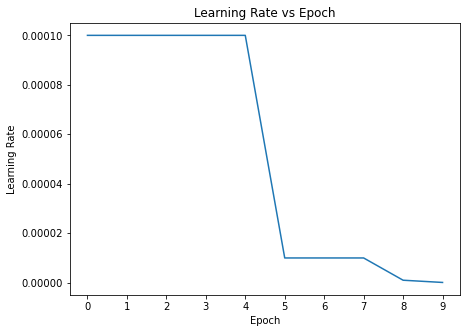

In [18]:
plot_learning_rate(history_dict)

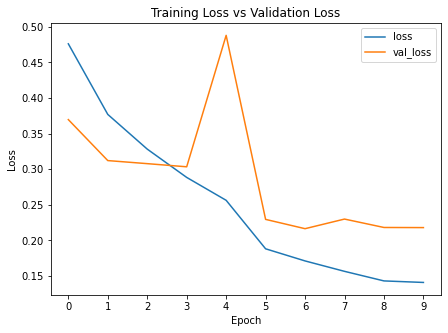

In [19]:
plot_metric(history_dict, 'loss')

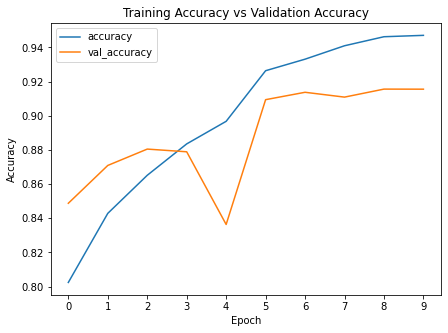

In [20]:
plot_metric(history_dict, 'accuracy')

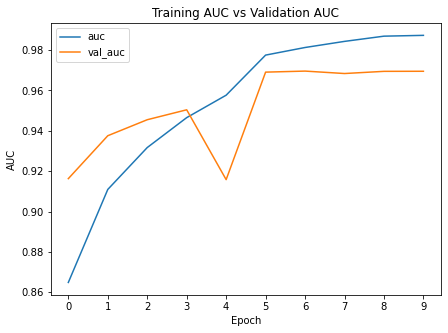

In [21]:
plot_metric(history_dict, 'auc')

---

## Calculate Performance on Test Set

In [22]:
test_metrics = model.evaluate(test_ds, verbose=1)
test_metrics = map_to_metrics(model.metrics_names, test_metrics)

  1/258 [..............................] - ETA: 20s - loss: 0.1330 - accuracy: 0.9375 - auc: 0.9922

 14/258 [>.............................] - ETA: 0s - loss: 0.1933 - accuracy: 0.9353 - auc: 0.9761 

 28/258 [==>...........................] - ETA: 0s - loss: 0.2152 - accuracy: 0.9263 - auc: 0.9695

 42/258 [===>..........................] - ETA: 0s - loss: 0.2238 - accuracy: 0.9152 - auc: 0.9679

 56/258 [=====>........................] - ETA: 0s - loss: 0.2162 - accuracy: 0.9152 - auc: 0.9705

 70/258 [=======>......................] - ETA: 0s - loss: 0.2140 - accuracy: 0.9161 - auc: 0.9707

 84/258 [========>.....................] - ETA: 0s - loss: 0.2130 - accuracy: 0.9156 - auc: 0.9710

 98/258 [==========>...................] - ETA: 0s - loss: 0.2153 - accuracy: 0.9136 - auc: 0.9702

112/258 [============>.................] - ETA: 0s - loss: 0.2140 - accuracy: 0.9135 - auc: 0.9700

126/258 [=============>................] - ETA: 0s - loss: 0.2173 - accuracy: 0.9102 - auc: 0.9694

140/258 [===============>..............] - ETA: 0s - loss: 0.2143 - accuracy: 0.9109 - auc: 0.9704

154/258 [================>.............] - ETA: 0s - loss: 0.2149 - accuracy: 0.9113 - auc: 0.9704

168/258 [==================>...........] - ETA: 0s - loss: 0.2163 - accuracy: 0.9103 - auc: 0.9699

182/258 [====================>.........] - ETA: 0s - loss: 0.2142 - accuracy: 0.9109 - auc: 0.9704

196/258 [=====================>........] - ETA: 0s - loss: 0.2174 - accuracy: 0.9102 - auc: 0.9696

210/258 [=======================>......] - ETA: 0s - loss: 0.2233 - accuracy: 0.9088 - auc: 0.9681

224/258 [=========================>....] - ETA: 0s - loss: 0.2229 - accuracy: 0.9082 - auc: 0.9684

238/258 [==========================>...] - ETA: 0s - loss: 0.2220 - accuracy: 0.9085 - auc: 0.9687

252/258 [============================>.] - ETA: 0s - loss: 0.2214 - accuracy: 0.9087 - auc: 0.9687

258/258 [==============================] - 1s 4ms/step - loss: 0.2226 - accuracy: 0.9087 - auc: 0.9684


In [23]:
# Save test metrics
json.dump(test_metrics, open(f"{model_output_dir}/{MODEL_NAME}/test_metrics.json", 'w'))

---